In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import LabelEncoder
import numpy as np 
import pandas as pd

In [3]:
# sample = pd.read_csv('/kaggle/input/iiitb2020-home-credit-default-risk/sample_submission.csv')a

We have defined a function to fill the nan values(RemoveNan).
*  It takes dataframe and a dictonary containing all the values which are to be filled for each column in the dataframe.

In [4]:
def RemoveNaN(df,nan_data):
    cols = list(df.columns[df.isnull().sum() != 0])

    print("==========List of Columns which has Nan entries in it===========")
    print(cols,end="\n\n")

    print("========Name_of_Column number_of_NaN_values percentage_of_NaN_value=====\n ========unique_values_of_that_columns======"\
          ,end="\n\n")
    for col in cols:
        print(col,end=" ")
        print(df[col].isna().sum(),end=" ")
        print(df[col].isna().sum()/df.shape[0]*100,end="\n")
        if(len(df[col].unique())<100):
            print(df[col].unique())
        else:
            print(col+" has more than 100 unique values")
#         replace_string = input("Give the <<Type>> <<Value to replace>> type is one of the following- int or string\n")
#         nan_data[col] = []
        tokens=0
        if(type(nan_data[col]) is list):    
            tokens=nan_data[col][1]
        else:
            tokens = nan_data[col]
        replace_type = tokens
#         if(replace_type.lower() == "int"):
#             replace_value = tokens[1]
#             df[col].fillna(int(replace_value),inplace=True)
#         elif(replace_type.lower() == "string"):
#             replace_value = tokens[1]
#             df[col].fillna(replace_value,inplace=True)
        if(replace_type == "mean"):
            df[col].fillna(df[col].mean(),inplace=True)
#             nan_data[col].append(df[col].mean())
        elif(replace_type == "min"):
            df[col].fillna(df[col].min(),inplace=True)
#             nan_data[col].append(df[col].min())
        elif(replace_type == "max"):
            df[col].fillna(df[col].max(),inplace=True)
#             nan_data[col].append(df[col].max())
        elif(replace_type == "std"):
            df[col].fillna(df[col].std(),inplace=True)
#             nan_data[col].append(df[col].std())
        elif(replace_type == "most"):
            df[col].fillna(df[col].value_counts().idxmax(),inplace=True)
#             nan_data[col].append(df[col].value_counts().idxmax())
        elif(replace_type == "median"):
            df[col].fillna(df[col].median(),inplace=True)
#             nan_data[col].append(df[col].median())
        else:
            df[col].fillna(replace_type,inplace=True)
#             nan_data[col].append(replace_type)
        print()
#     check_NaN(df)
    print(nan_data)

We have defined a function to merge two dataframes(merge).
* It takes two dataframes and a method by which we want to merge them.

In [5]:
def merge(df,parent_df,key,method):
    for col in df:
        print(col)
        if col == key:
            continue
        if col not in method:
            print(col)
            if(len(df[col].unique())<100):
                print(df[col].unique())
#             ipt = input()
#             ipt = ipt.split(" ")
#             method[col] = [ ipt[0], float(ipt[1])]
            method[col] = ['sum', 0.0]
        fn = method[col][0]
        val = method[col][1]
        if(fn == "ignore"):
            continue
        if(fn == "mode"):
            mf = df.groupby(key)[col].agg(lambda x: pd.Series.mode(x)[0]).reindex(parent_df[key].unique(), fill_value=val)
            parent_df = parent_df.join(mf,on=key,lsuffix='_1', rsuffix='_2')
            continue
        if(fn == "mean"):
            mf = df.groupby(key)[col].agg('mean').reindex(parent_df[key].unique(), fill_value=val)
            parent_df = parent_df.join(mf,on=key,lsuffix='_1', rsuffix='_2')
            continue
        mf = df.groupby(key)[col].agg(eval(fn)).reindex(parent_df[key].unique(), fill_value=val)
        parent_df = parent_df.join(mf,on=key,lsuffix='_1', rsuffix='_2')
    return parent_df

We have a defined a function to plot a graph for a feature.
* It takes dataframe and feature name as an input
* It plots a distplot with kde for a numerical feature
* It plot catplot for a categorical feature.
* At the end of the plot it diplays the number of unique values and the value counts of the starting 5 unique values of that feature

In [6]:
from scipy.stats import norm
import matplotlib.pylab as plat 
def plot_graph(dataset,col):
    if(dataset[col].dtypes != 'object'):
        plt.figure(figsize=(10,10))
#         sns.distplot(dataset[col].dropna(),color='blue',kde=True,kde_kws={'bw' :1.5})
        try:
            sns.distplot(dataset[col].dropna(),color='blue',kde=True)
        except RuntimeError as re:
            if str(re).startswith("Selected KDE bandwidth is 0. Cannot estimate density."):
                sns.distplot(dataset[col].dropna(),color='blue',kde=True,kde_kws={'bw' :1.5})
            else:
                raise re
        plt.show()
        print("There are {} unique values ".format(len(dataset[col].unique())))
        print(dataset[col].value_counts().head())
    else:
        plt.figure(figsize=(20,20))
        temp = pd.DataFrame()
        temp[col] = dataset[col].dropna()
        sns.catplot(x=col,data=temp,kind='count')
        plat.xticks(rotation=90)
        del (temp)
        plt.legend()
        plt.show()
        print("There are {} unique values ".format(len(dataset[col].unique())))
        print(dataset[col].value_counts().head())

# bureau part

In [7]:
bureau = pd.read_csv('/kaggle/input/iiitb2020-home-credit-default-risk/bureau.csv')

In [8]:
bureau.head()

SK_ID_CURR SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0     ue6oex      eoxbd6b        Closed      currency 1        -1835   
1     7bxax7      6oaorab        Closed      currency 1         -904   
2     axrrbx      d7xo7bb        Closed      currency 1         -893   
3     a7bd7r      o6drrx6        Closed      currency 1        -2246   
4     roaexd      a66our6        Closed      currency 1        -2584   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -739.0             -763.0   
1                   0               -722.0             -691.0   
2                   0               -809.0             -804.0   
3                   0               -420.0             -420.0   
4                   0              -2218.0            -2218.0   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0        675000.0   
1                 216.945                   0         31500.0   
2                   0.000                   0         45000.0   
3                   0.000                   0       2700000.0   
4                7042.365                   0         83205.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   0.0                     0.0   
1                  0.0                   0.0                     0.0   
2                  0.0                   0.0                     0.0   
3                  0.0                   0.0                     0.0   
4                  0.0                   0.0                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -612          0.0  
1  Consumer credit                -691          NaN  
2        Microloan                -796          NaN  
3  Consumer credit                -414          NaN  
4  Consumer credit               -2218          NaN

In [9]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              object 
 1   SK_ID_BUREAU            object 
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(4), object(5)
memory usage: 222.6+ MB


<Figure size 1440x1440 with 0 Axes>

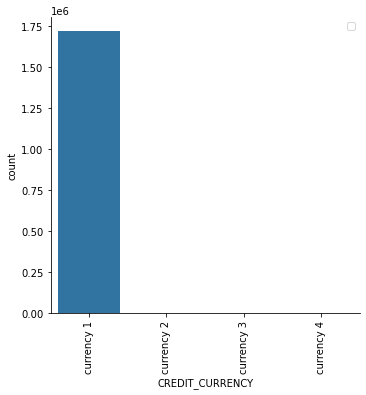

There are 4 unique values 
currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64


In [10]:
plot_graph(bureau,'CREDIT_CURRENCY')

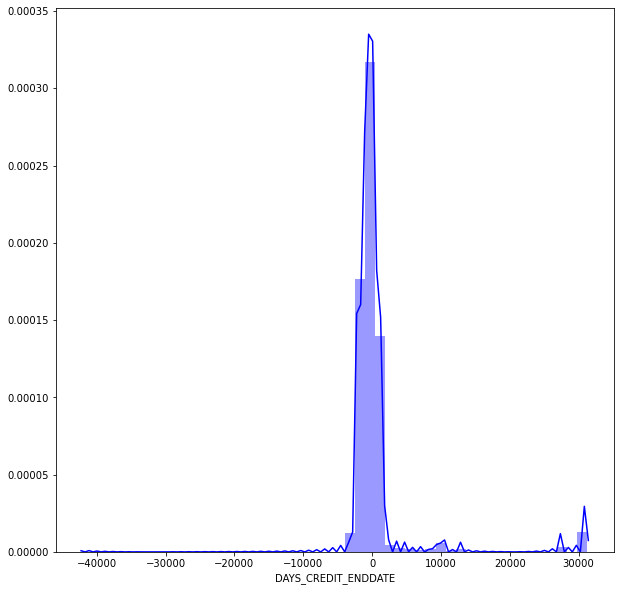

There are 14097 unique values 
 0.0     883
 3.0     845
-7.0     837
 1.0     830
-14.0    787
Name: DAYS_CREDIT_ENDDATE, dtype: int64


In [11]:
plot_graph(bureau,'DAYS_CREDIT_ENDDATE')

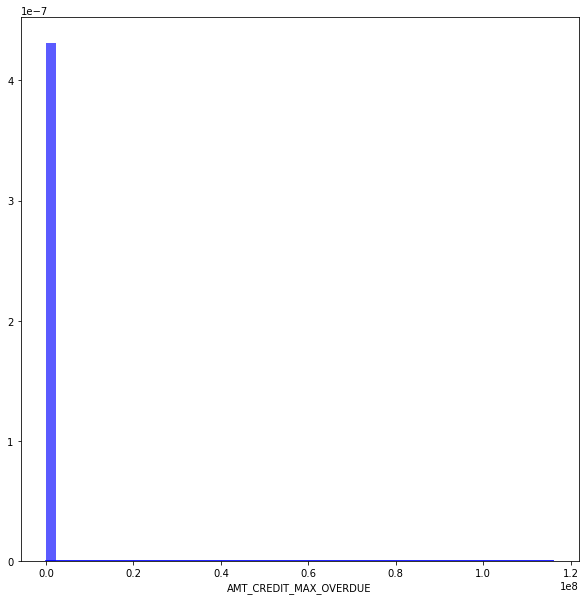

There are 68252 unique values 
0.0       470650
1440.0       688
225.0        405
45.0         377
4.5          315
Name: AMT_CREDIT_MAX_OVERDUE, dtype: int64


In [12]:
plot_graph(bureau,'AMT_CREDIT_MAX_OVERDUE')

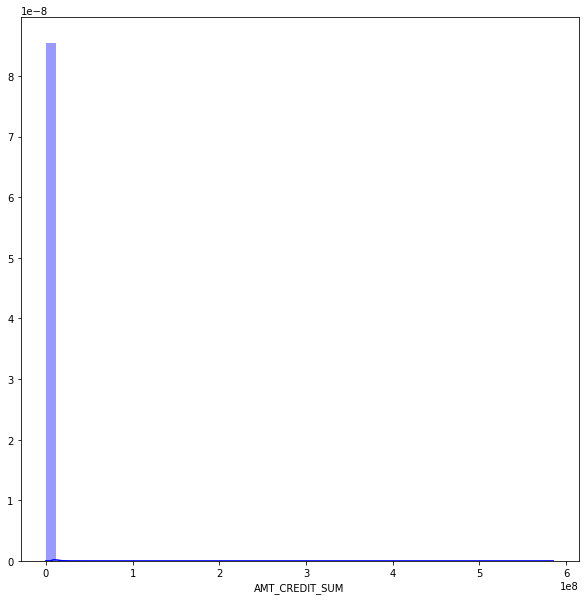

There are 236709 unique values 
0.0         66582
225000.0    57608
135000.0    50195
450000.0    37156
90000.0     36940
Name: AMT_CREDIT_SUM, dtype: int64


In [13]:
plot_graph(bureau,'AMT_CREDIT_SUM')

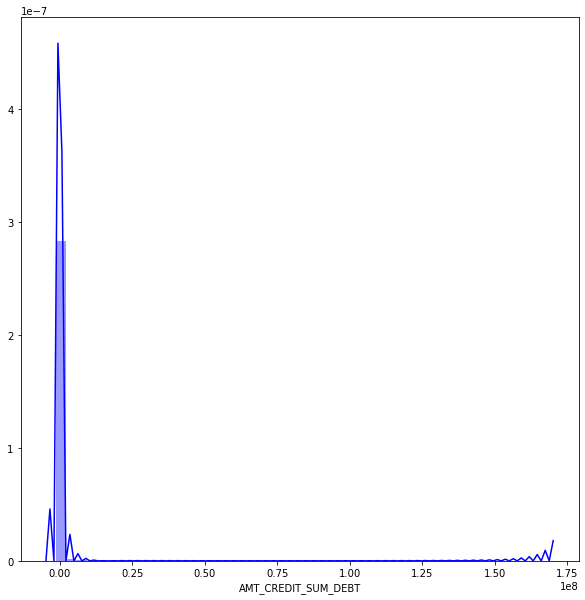

There are 226538 unique values 
 0.0         1016434
 4.5             653
-450.0           543
 135000.0        344
 90000.0         320
Name: AMT_CREDIT_SUM_DEBT, dtype: int64


In [14]:
plot_graph(bureau,'AMT_CREDIT_SUM_DEBT')

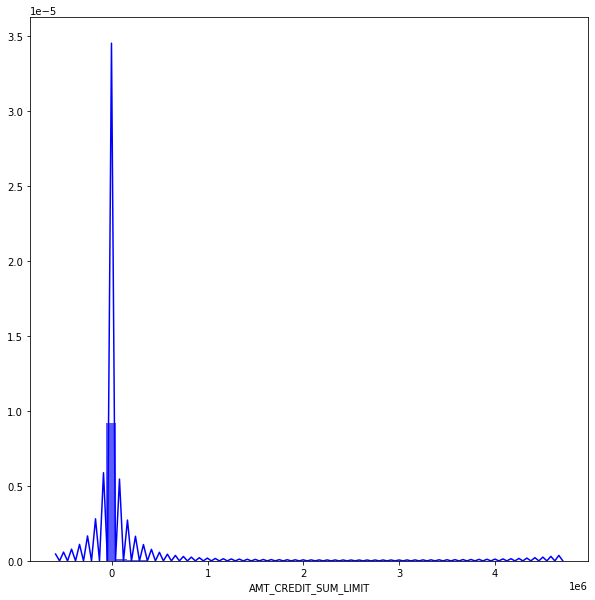

There are 51727 unique values 
0.0         1050142
135000.0       2178
4500.0         1474
45000.0        1335
90000.0         974
Name: AMT_CREDIT_SUM_LIMIT, dtype: int64


In [15]:
plot_graph(bureau,'AMT_CREDIT_SUM_LIMIT')

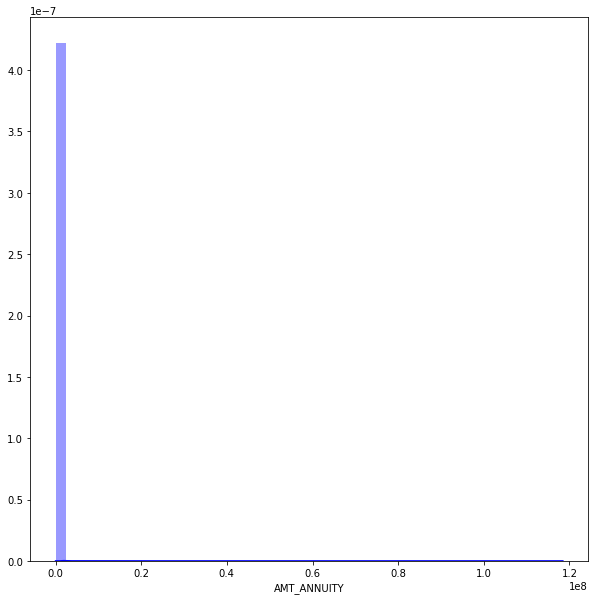

There are 40322 unique values 
0.0        256915
4500.0       5182
13500.0      3147
22500.0      2502
9000.0       1725
Name: AMT_ANNUITY, dtype: int64


In [16]:
plot_graph(bureau,'AMT_ANNUITY')

In [17]:
bureau_nan = {'DAYS_CREDIT_ENDDATE':0, 'DAYS_ENDDATE_FACT':0, 'AMT_CREDIT_MAX_OVERDUE':0,
              'AMT_CREDIT_SUM':0, 'AMT_CREDIT_SUM_DEBT':0, 'AMT_CREDIT_SUM_LIMIT':0, 'AMT_ANNUITY':0}

In [18]:
RemoveNaN(bureau,bureau_nan)

==========List of Columns which has Nan entries in it===========
['DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_ANNUITY']

========Name_of_Column number_of_NaN_values percentage_of_NaN_value=====
 ========unique_values_of_that_columns======

DAYS_CREDIT_ENDDATE 105553 6.149573416420613
DAYS_CREDIT_ENDDATE has more than 100 unique values

DAYS_ENDDATE_FACT 633653 36.916957775100386
DAYS_ENDDATE_FACT has more than 100 unique values

AMT_CREDIT_MAX_OVERDUE 1124488 65.51326359159837
AMT_CREDIT_MAX_OVERDUE has more than 100 unique values

AMT_CREDIT_SUM 13 0.0007573868522303295
AMT_CREDIT_SUM has more than 100 unique values

AMT_CREDIT_SUM_DEBT 257669 15.011931755948982
AMT_CREDIT_SUM_DEBT has more than 100 unique values

AMT_CREDIT_SUM_LIMIT 591780 34.47741472406649
AMT_CREDIT_SUM_LIMIT has more than 100 unique values

AMT_ANNUITY 1226791 71.4734902949614
AMT_ANNUITY has more than 100 unique value

In [19]:
#encoding
bureau['CREDIT_TYPE'] = LabelEncoder().fit_transform(bureau['CREDIT_TYPE'])
b_Onehot = ['CREDIT_ACTIVE','CREDIT_CURRENCY']
bureau = pd.get_dummies(bureau,columns=b_Onehot,drop_first=True)

In [20]:
bureau.head()

SK_ID_CURR SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
0     ue6oex      eoxbd6b        -1835                   0   
1     7bxax7      6oaorab         -904                   0   
2     axrrbx      d7xo7bb         -893                   0   
3     a7bd7r      o6drrx6        -2246                   0   
4     roaexd      a66our6        -2584                   0   

   DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
0               -739.0             -763.0                   0.000   
1               -722.0             -691.0                 216.945   
2               -809.0             -804.0                   0.000   
3               -420.0             -420.0                   0.000   
4              -2218.0            -2218.0                7042.365   

   CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  ...  \
0                   0        675000.0                  0.0  ...   
1                   0         31500.0                  0.0  ...   
2                   0         45000.0                  0.0  ...   
3                   0       2700000.0                  0.0  ...   
4                   0         83205.0                  0.0  ...   

   AMT_CREDIT_SUM_OVERDUE  CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  \
0                     0.0            3                -612          0.0   
1                     0.0            3                -691          0.0   
2                     0.0           10                -796          0.0   
3                     0.0            3                -414          0.0   
4                     0.0            3               -2218          0.0   

   CREDIT_ACTIVE_Bad debt  CREDIT_ACTIVE_Closed  CREDIT_ACTIVE_Sold  \
0                       0                     1                   0   
1                       0                     1                   0   
2                       0                     1                   0   
3                       0                     1                   0   
4                       0                     1                   0   

   CREDIT_CURRENCY_currency 2  CREDIT_CURRENCY_currency 3  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   CREDIT_CURRENCY_currency 4  
0                           0  
1                           0  
2                           0  
3                           0  
4                           0  

[5 rows x 21 columns]

# bureau_bal part

In [21]:
bureau_bal = pd.read_csv('/kaggle/input/iiitb2020-home-credit-default-risk/bureau_balance.csv')

In [22]:
bureau_bal.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0      rera7rb              -2      C
1      eoru6bb             -62      X
2      xebr7e6             -62      C
3      dre7676              -5      X
4      rrda6db             -70      C

In [23]:
bureau_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    object
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(1), object(2)
memory usage: 624.8+ MB


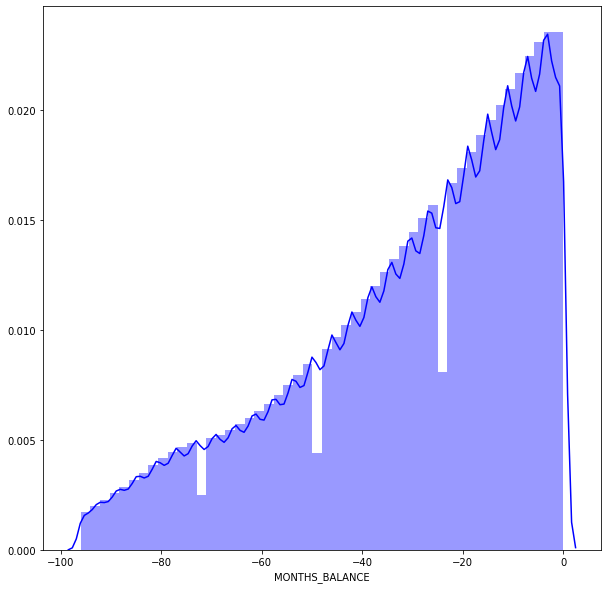

There are 97 unique values 
-1    622601
-2    619243
-3    615080
 0    610965
-4    609138
Name: MONTHS_BALANCE, dtype: int64


In [24]:
plot_graph(bureau_bal,'MONTHS_BALANCE')

In [25]:
# plot_graph(bureau_bal,'STATUS')

In [26]:
bb_Onehot = ['STATUS']
bureau_bal = pd.get_dummies(bureau_bal,columns=bb_Onehot,drop_first=True)

In [27]:
# bureau_bal.head()
# bureau_bal['STATUS'].unique()

## Merging bureau and bureau_bal

In [28]:
# bureau bal to bureau
bb_merge = {'MONTHS_BALANCE': ['min',0.0],
 'STATUS_1': ['sum', 0.0],
 'STATUS_2': ['sum', 0.0],
 'STATUS_3': ['sum', 0.0],
 'STATUS_4': ['sum', 0.0],
 'STATUS_5': ['sum', 0.0],
 'STATUS_C': ['sum', 0.0],
 'STATUS_X': ['sum', 0.0]}
bureau = merge(bureau_bal,bureau,'SK_ID_BUREAU',bb_merge)

SK_ID_BUREAU
MONTHS_BALANCE
STATUS_1
STATUS_2
STATUS_3
STATUS_4
STATUS_5
STATUS_C
STATUS_X


In [29]:
# bureau.head()
del bureau_bal
gc.collect()

41723

# Cash_bal part

In [30]:
cash_bal = pd.read_csv('/kaggle/input/iiitb2020-home-credit-default-risk/POS_CASH_balance.csv')

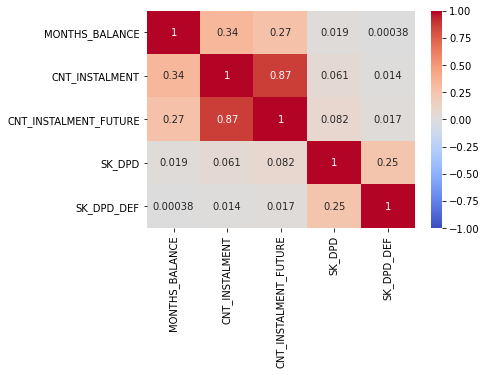

In [31]:
sns.heatmap(cash_bal.corr().abs(),vmin=-1,cmap='coolwarm',annot=True)

In [32]:
cash_bal.head()

SK_ID_PREV SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0    6a6uarx     ox6uar             -21            60.0   
1    uerooox     ouaa6x             -44            10.0   
2    oe7e66d     ud6aa7             -79             5.0   
3    6rbdrxd     o7eer7              -6            48.0   
4    76ede7x     xo7r6d             -24            18.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   56.0               Active       0           0  
1                    3.0               Active       0           0  
2                    1.0               Active       0           0  
3                   26.0               Active       0           0  
4                   14.0               Active       6           6

In [33]:
cash_bal_drop = ['CNT_INSTALMENT_FUTURE']
cash_bal.drop(columns = cash_bal_drop,axis=1,inplace = True)

In [34]:
cash_bal['SK_ID_PREV'].describe()

count     10001358
unique      936325
top        o7ou6ad
freq            96
Name: SK_ID_PREV, dtype: object

In [35]:
cash_bal.isna().sum()

SK_ID_PREV                  0
SK_ID_CURR                  0
MONTHS_BALANCE              0
CNT_INSTALMENT          26071
NAME_CONTRACT_STATUS        0
SK_DPD                      0
SK_DPD_DEF                  0
dtype: int64

In [36]:
cash_bal['CNT_INSTALMENT'].value_counts()

12.0    2496845
24.0    1517472
10.0    1243449
6.0     1065500
18.0     727394
         ...   
63.0          2
70.0          2
92.0          1
68.0          1
81.0          1
Name: CNT_INSTALMENT, Length: 73, dtype: int64

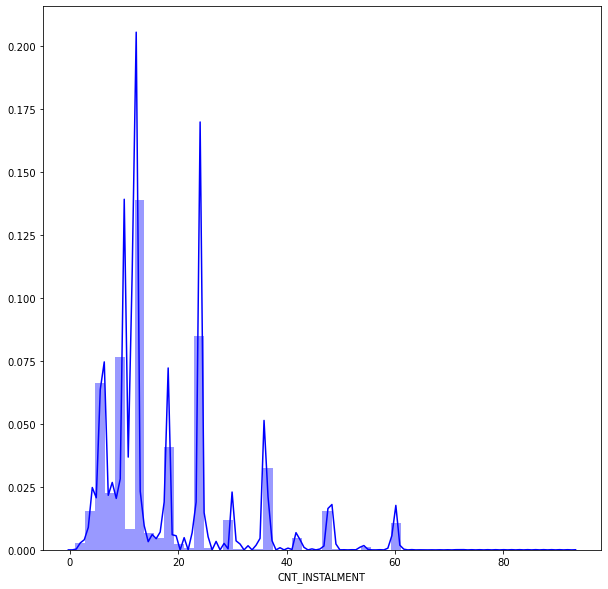

There are 74 unique values 
12.0    2496845
24.0    1517472
10.0    1243449
6.0     1065500
18.0     727394
Name: CNT_INSTALMENT, dtype: int64


In [37]:
plot_graph(cash_bal,'CNT_INSTALMENT')

In [38]:
cash_bal_nan = {'CNT_INSTALMENT': 'median'}

In [39]:
RemoveNaN(cash_bal,cash_bal_nan)

==========List of Columns which has Nan entries in it===========
['CNT_INSTALMENT']

========Name_of_Column number_of_NaN_values percentage_of_NaN_value=====
 ========unique_values_of_that_columns======

CNT_INSTALMENT 26071 0.26067460038926715
[60. 10.  5. 48. 18. 24. 12.  6. 36.  8. 13. 14. 42.  9. 11.  4. 15. 21.
  3. 25. nan 30. 20. 35.  1.  7. 54.  2. 17. 16. 23. 19. 41. 34. 37. 43.
 44. 61. 32. 45. 22. 40. 31. 33. 72. 27. 49. 29. 26. 53. 38. 28. 47. 46.
 39. 59. 84. 55. 66. 51. 63. 52. 50. 58. 57. 56. 70. 77. 62. 68. 64. 71.
 81. 92.]

{'CNT_INSTALMENT': 'median'}


In [40]:
cb_Onehot = ['NAME_CONTRACT_STATUS']
cash_bal = pd.get_dummies(cash_bal,columns=cb_Onehot,drop_first=True)

# Previous application

In [41]:
prev_app = pd.read_csv('/kaggle/input/iiitb2020-home-credit-default-risk/previous_application.csv')

In [42]:
prev_app.isna().sum()

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

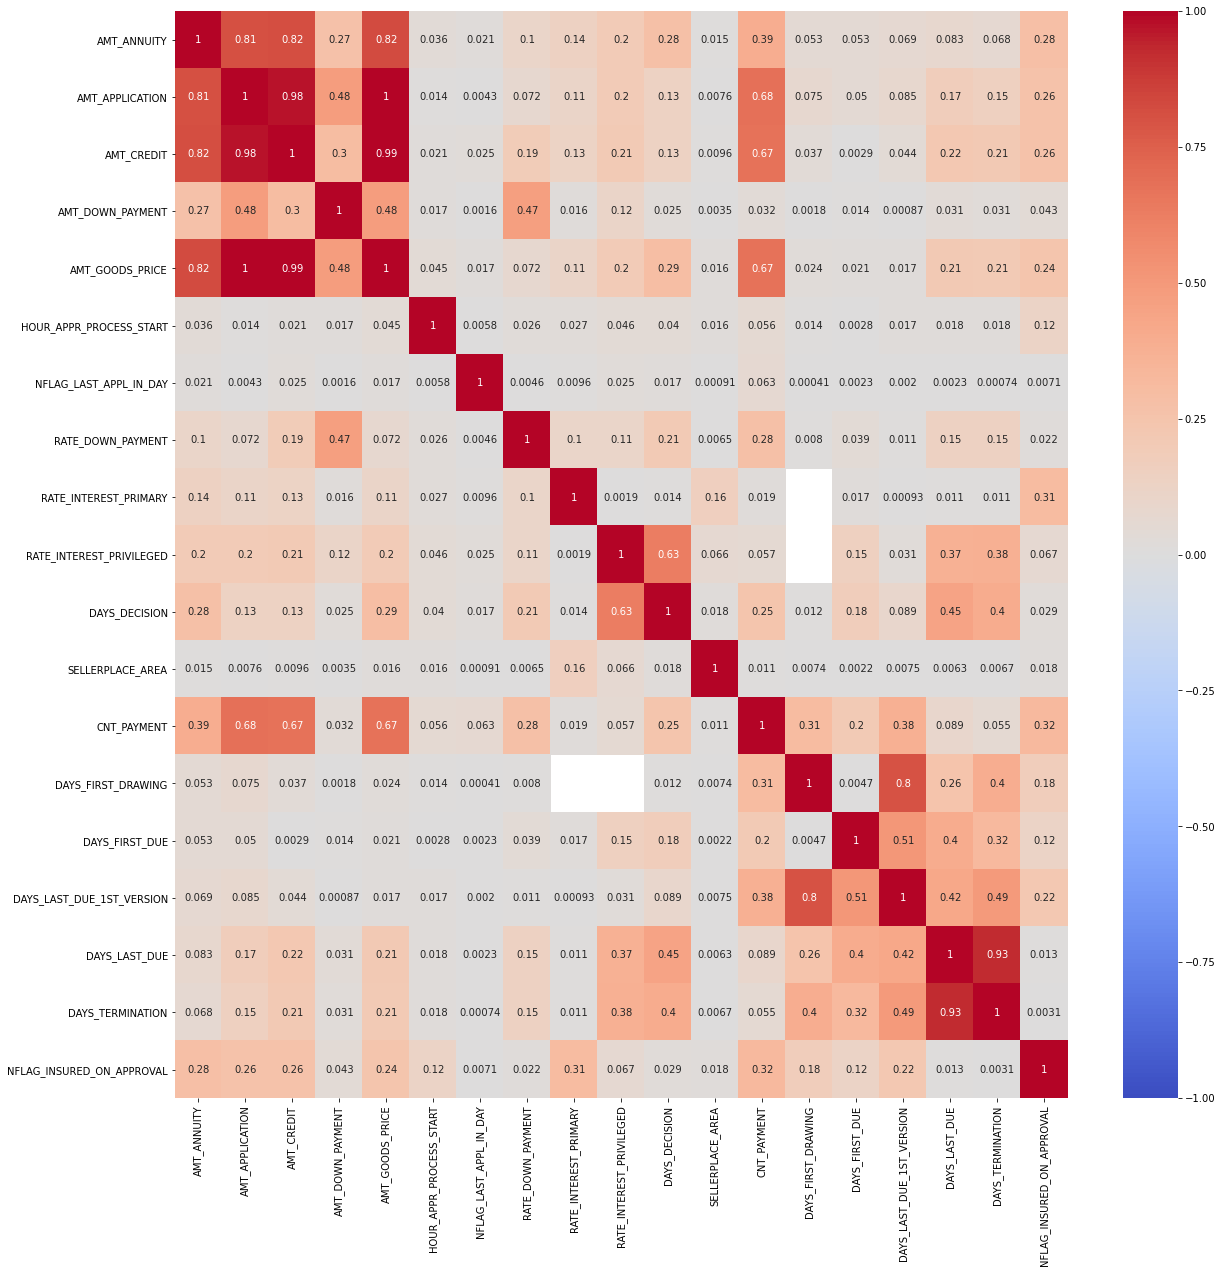

In [43]:
plt.figure(figsize=(20,20))
sns.heatmap(prev_app.corr().abs(),vmin=-1,cmap='coolwarm',annot=True)


In [44]:
upper = prev_app.corr().abs().where(np.triu(np.ones(prev_app.corr().shape), k=1).astype(np.bool))
to_drop_prev_app = [column for column in upper.columns if any(upper[column] >= 0.90)]
prev_app.drop(columns =to_drop_prev_app,axis=1,inplace = True)

In [45]:
to_drop_prev_app

['AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_TERMINATION']

In [46]:
prev_app.drop(columns=['RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED'],inplace=True)

In [47]:
prev_app['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      508970
Family             213263
Spouse, partner     67069
Children            31566
Other_B             17624
Other_A              9077
Group of people      2240
Name: NAME_TYPE_SUITE, dtype: int64

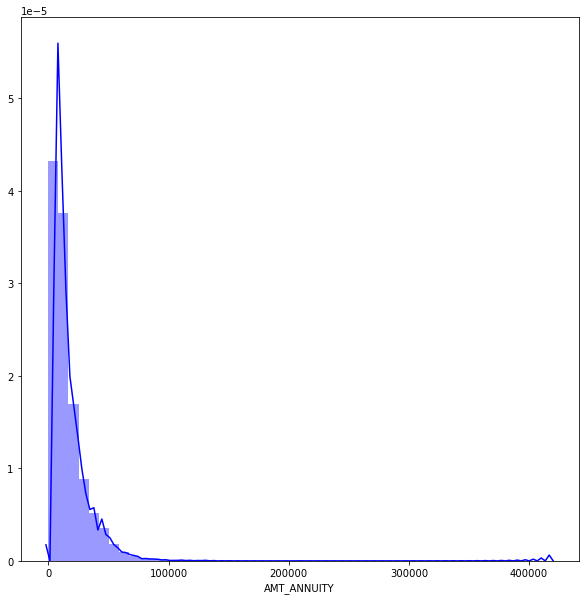

There are 357960 unique values 
2250.0     31865
11250.0    13974
6750.0     13442
9000.0     12496
22500.0    11903
Name: AMT_ANNUITY, dtype: int64


In [48]:
plot_graph(prev_app,'AMT_ANNUITY')
# 
# 

<Figure size 1440x1440 with 0 Axes>

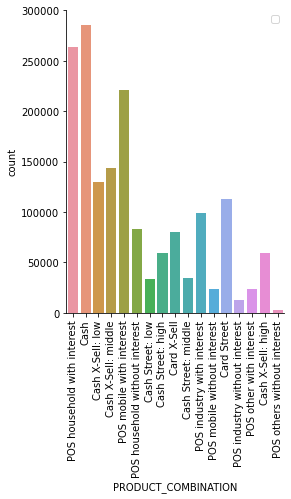

There are 18 unique values 
Cash                           285990
POS household with interest    263622
POS mobile with interest       220670
Cash X-Sell: middle            143883
Cash X-Sell: low               130248
Name: PRODUCT_COMBINATION, dtype: int64


In [49]:
plot_graph(prev_app,'PRODUCT_COMBINATION')

<Figure size 1440x1440 with 0 Axes>

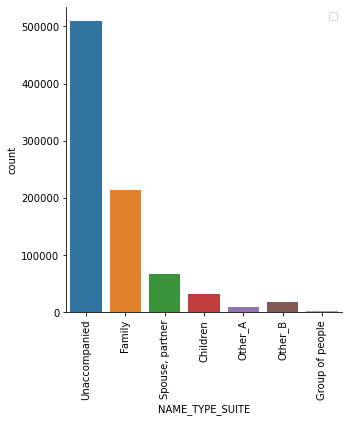

There are 8 unique values 
Unaccompanied      508970
Family             213263
Spouse, partner     67069
Children            31566
Other_B             17624
Name: NAME_TYPE_SUITE, dtype: int64


In [50]:
plot_graph(prev_app,'NAME_TYPE_SUITE')

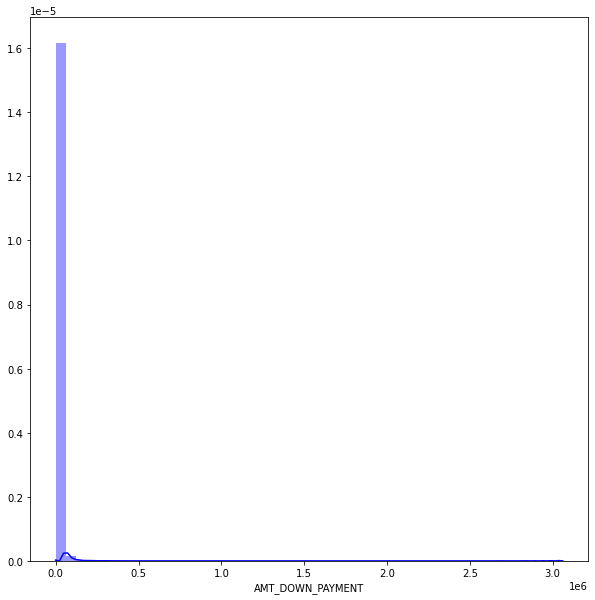

There are 29279 unique values 
0.0        369854
4500.0      21241
9000.0      14747
13500.0      9655
22500.0      8165
Name: AMT_DOWN_PAYMENT, dtype: int64


In [51]:
plot_graph(prev_app,'AMT_DOWN_PAYMENT')

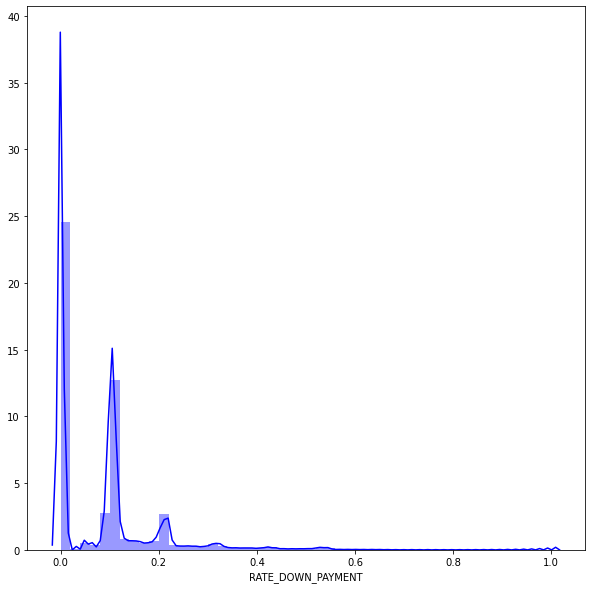

There are 207034 unique values 
0.000000    369854
0.108909     36341
0.217818      6482
0.326727      1081
0.544545       746
Name: RATE_DOWN_PAYMENT, dtype: int64


In [52]:
plot_graph(prev_app,'RATE_DOWN_PAYMENT')

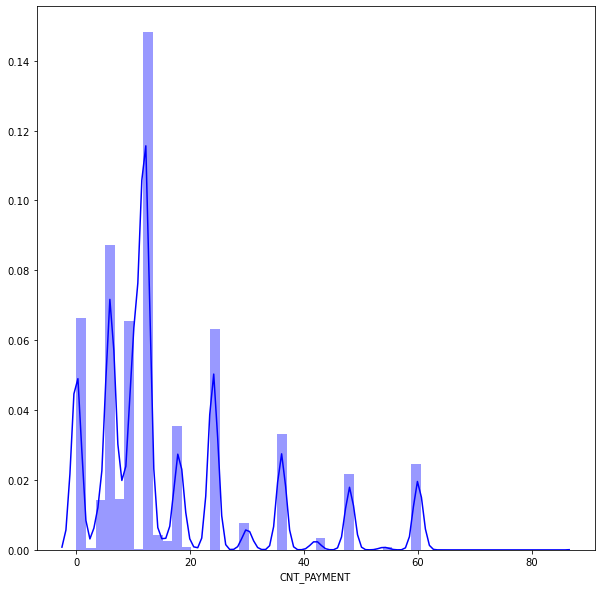

There are 50 unique values 
12.0    323049
6.0     190461
0.0     144985
10.0    141851
24.0    137764
Name: CNT_PAYMENT, dtype: int64


In [53]:
plot_graph(prev_app,'CNT_PAYMENT')

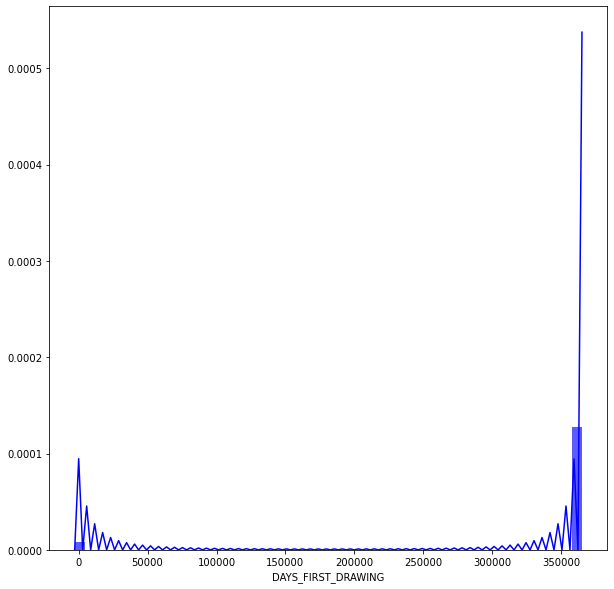

There are 2839 unique values 
 365243.0    934444
-228.0          123
-212.0          121
-224.0          121
-223.0          119
Name: DAYS_FIRST_DRAWING, dtype: int64


In [54]:
plot_graph(prev_app,'DAYS_FIRST_DRAWING')

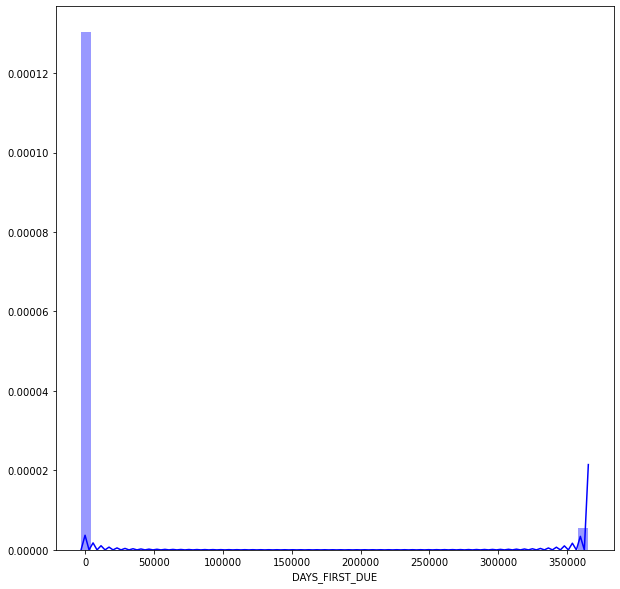

There are 2893 unique values 
 365243.0    40645
-334.0         772
-509.0         760
-208.0         751
-330.0         750
Name: DAYS_FIRST_DUE, dtype: int64


In [55]:
plot_graph(prev_app,'DAYS_FIRST_DUE')

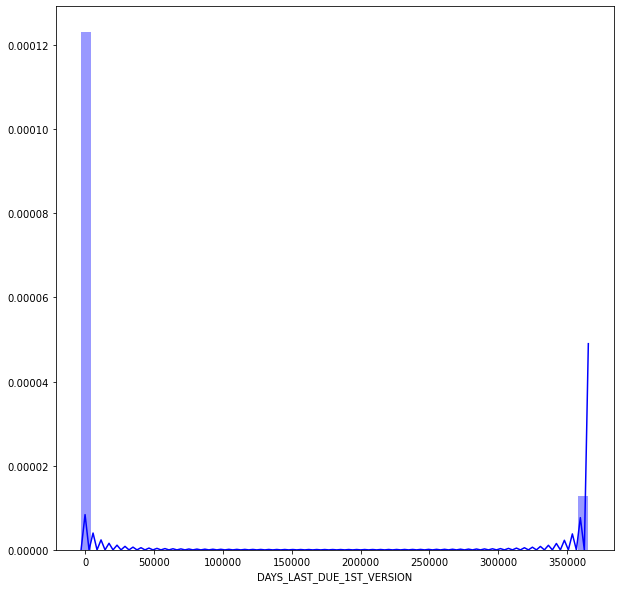

There are 4606 unique values 
365243.0    93864
9.0           720
8.0           706
0.0           705
5.0           702
Name: DAYS_LAST_DUE_1ST_VERSION, dtype: int64


In [56]:
plot_graph(prev_app,'DAYS_LAST_DUE_1ST_VERSION')

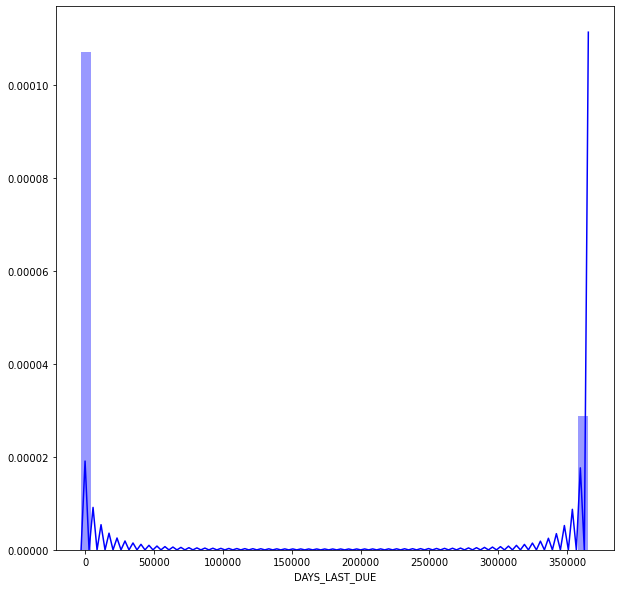

There are 2874 unique values 
 365243.0    211221
-245.0          658
-188.0          650
-239.0          642
-167.0          638
Name: DAYS_LAST_DUE, dtype: int64


In [57]:
plot_graph(prev_app,'DAYS_LAST_DUE')

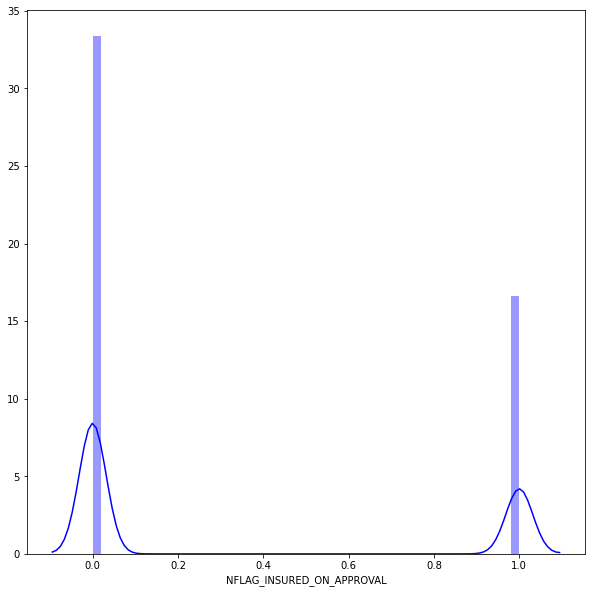

There are 3 unique values 
0.0    665527
1.0    331622
Name: NFLAG_INSURED_ON_APPROVAL, dtype: int64


In [58]:
plot_graph(prev_app,'NFLAG_INSURED_ON_APPROVAL')

In [59]:
prev_app_nan = {"AMT_ANNUITY":0,"AMT_DOWN_PAYMENT":0,"RATE_DOWN_PAYMENT":0,
                "NAME_TYPE_SUITE":"most","CNT_PAYMENT":0,"PRODUCT_COMBINATION":"most",
                "DAYS_FIRST_DRAWING":"most","DAYS_FIRST_DUE":"most","DAYS_LAST_DUE_1ST_VERSION":"most",
               "DAYS_LAST_DUE":"most","NFLAG_INSURED_ON_APPROVAL":0}

In [60]:
RemoveNaN(prev_app,prev_app_nan)

==========List of Columns which has Nan entries in it===========
['AMT_ANNUITY', 'AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'NAME_TYPE_SUITE', 'CNT_PAYMENT', 'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'NFLAG_INSURED_ON_APPROVAL']

========Name_of_Column number_of_NaN_values percentage_of_NaN_value=====
 ========unique_values_of_that_columns======

AMT_ANNUITY 372235 22.286665062081866
AMT_ANNUITY has more than 100 unique values

AMT_DOWN_PAYMENT 895844 53.636480115721696
AMT_DOWN_PAYMENT has more than 100 unique values

RATE_DOWN_PAYMENT 895844 53.636480115721696
RATE_DOWN_PAYMENT has more than 100 unique values

NAME_TYPE_SUITE 820405 49.11975351661524
['Unaccompanied' 'Family' nan 'Spouse, partner' 'Children' 'Other_A'
 'Other_B' 'Group of people']

CNT_PAYMENT 372230 22.286365699245724
[24. 12. nan  6.  8. 42. 30.  0. 60. 18.  4. 36. 16. 14.  5. 48. 10. 54.
  3. 15. 20.  9. 72.  7. 84. 11. 29. 13. 26. 66. 28. 41. 21. 32

In [61]:
# ADD encoding
categor_prev_app = [i for i in prev_app.columns if prev_app[i].dtypes == 'object']
categor_prev_app

['SK_ID_PREV',
 'SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

In [62]:
prev_app['PRODUCT_COMBINATION'].value_counts()

Cash                              286336
POS household with interest       263622
POS mobile with interest          220670
Cash X-Sell: middle               143883
Cash X-Sell: low                  130248
Card Street                       112582
POS industry with interest         98833
POS household without interest     82908
Card X-Sell                        80582
Cash Street: high                  59639
Cash X-Sell: high                  59301
Cash Street: middle                34658
Cash Street: low                   33834
POS mobile without interest        24082
POS other with interest            23879
POS industry without interest      12602
POS others without interest         2555
Name: PRODUCT_COMBINATION, dtype: int64

In [63]:
labelencoder = LabelEncoder()
Label_prev_app = ['FLAG_LAST_APPL_PER_CONTRACT','NAME_CONTRACT_STATUS','NAME_CASH_LOAN_PURPOSE','CODE_REJECT_REASON','NAME_CLIENT_TYPE',
        'NAME_GOODS_CATEGORY','NAME_PORTFOLIO','NAME_SELLER_INDUSTRY','CHANNEL_TYPE','PRODUCT_COMBINATION']
for i in Label_prev_app:
    prev_app[i] = labelencoder.fit_transform(prev_app[i])

In [64]:
# temp_label = []
# for i in temp_label:
#     prev_app[i] = labelencoder.fit_transform(prev_app[i])

In [65]:
# Ambigious_prev_App = ['NAME_SELLER_INDUSTRY','CHANNEL_TYPE','NAME_YIELD_GROUP','PRODUCT_COMBINATION']

In [66]:
Onehot_prev_app = ['WEEKDAY_APPR_PROCESS_START','NAME_PAYMENT_TYPE','NAME_TYPE_SUITE','NAME_CONTRACT_TYPE',
                   'NAME_PRODUCT_TYPE','NAME_YIELD_GROUP']
prev_app = pd.get_dummies(prev_app,columns=Onehot_prev_app,drop_first=True)

In [67]:
# temp2 = ['WEEKDAY_APPR_PROCESS_START']

## Merging cash_bal and prev_app

In [68]:
cp_merge={'SK_ID_CURR': ['ignore', 0.0],
 'MONTHS_BALANCE': ['min', 0.0],
 'CNT_INSTALMENT': ['max', 0.0],
 'SK_DPD': ['sum', 0.0],
 'SK_DPD_DEF': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Amortized debt': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Approved': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Canceled': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Completed': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Demand': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Returned to the store': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Signed': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_XNA': ['sum', 0.0]}
prev_app = merge(cash_bal,prev_app,'SK_ID_PREV',cp_merge)

SK_ID_PREV
SK_ID_CURR
MONTHS_BALANCE
CNT_INSTALMENT
SK_DPD
SK_DPD_DEF
NAME_CONTRACT_STATUS_Amortized debt
NAME_CONTRACT_STATUS_Approved
NAME_CONTRACT_STATUS_Canceled
NAME_CONTRACT_STATUS_Completed
NAME_CONTRACT_STATUS_Demand
NAME_CONTRACT_STATUS_Returned to the store
NAME_CONTRACT_STATUS_Signed
NAME_CONTRACT_STATUS_XNA


In [69]:
# cp_merge
del cash_bal
gc.collect()

50369

In [70]:
# prev_app.head()

# installment part


In [71]:
installment = pd.read_csv('/kaggle/input/iiitb2020-home-credit-default-risk/installments_payments.csv')

In [72]:
installment_nan = {"DAYS_ENTRY_PAYMENT":0,"AMT_PAYMENT":0}

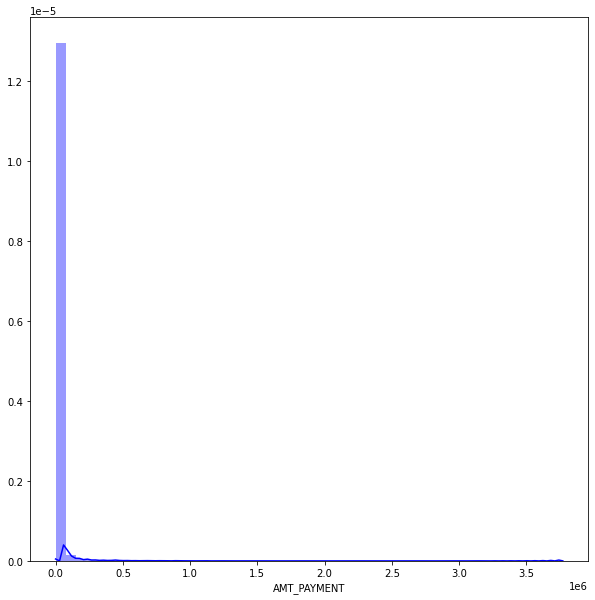

There are 944236 unique values 
9000.0    248757
2250.0    182654
4500.0    178309
6750.0    170360
3375.0    141832
Name: AMT_PAYMENT, dtype: int64


In [73]:
plot_graph(installment,'AMT_PAYMENT')

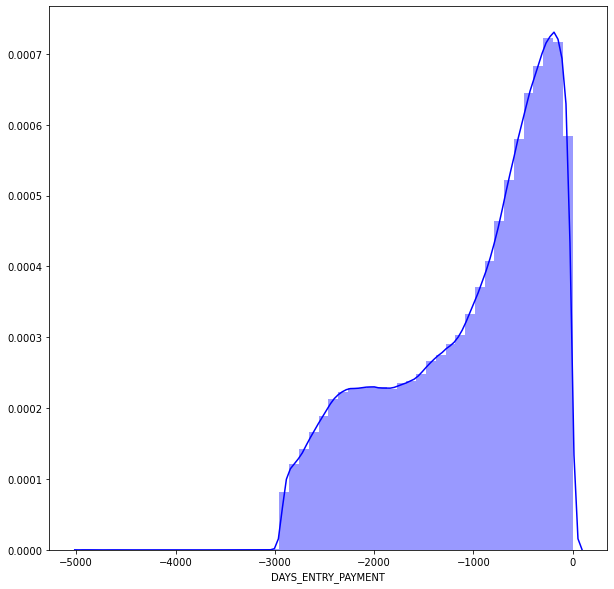

There are 3040 unique values 
-91.0     13103
-182.0    13090
-154.0    13071
-92.0     12646
-245.0    12405
Name: DAYS_ENTRY_PAYMENT, dtype: int64


In [74]:
plot_graph(installment,'DAYS_ENTRY_PAYMENT')

In [75]:
RemoveNaN(installment,installment_nan)

==========List of Columns which has Nan entries in it===========
['DAYS_ENTRY_PAYMENT', 'AMT_PAYMENT']

========Name_of_Column number_of_NaN_values percentage_of_NaN_value=====
 ========unique_values_of_that_columns======

DAYS_ENTRY_PAYMENT 2905 0.02135181462126695
DAYS_ENTRY_PAYMENT has more than 100 unique values

AMT_PAYMENT 2905 0.02135181462126695
AMT_PAYMENT has more than 100 unique values

{'DAYS_ENTRY_PAYMENT': 0, 'AMT_PAYMENT': 0}


In [76]:
installment['penalty_days']=installment['DAYS_ENTRY_PAYMENT']-installment['DAYS_INSTALMENT']
installment['penalty_amount']=installment['AMT_PAYMENT']-installment['AMT_INSTALMENT']

In [77]:
installment.drop(columns=['DAYS_ENTRY_PAYMENT','DAYS_INSTALMENT','AMT_PAYMENT','AMT_INSTALMENT'],inplace=True)
# upper = prev_app.corr().abs().where(np.triu(np.ones(prev_app.corr().shape), k=1).astype(np.bool))
# to_drop_prev_app = [column for column in upper.columns if any(upper[column] >= 0.90)]
# prev_app.drop(columns =to_drop_prev_app,axis=1,inplace = True)

In [78]:
installment.head()

SK_ID_PREV SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0    xaruuad     bru6rr                     3.0                     13   
1    ea77d7d     e6ed67                     0.0                    110   
2    o7eaxex     b7e6er                     1.0                      4   
3    xud6eed     b7ar6d                     0.0                     28   
4    oubddbx     7aubrx                     1.0                      2   

   penalty_days  penalty_amount  
0          -1.0             0.0  
1           0.0             0.0  
2          -2.0             0.0  
3          -5.0             0.0  
4         -22.0             0.0

## Merging installment and prev_app

In [79]:
ip_merge = {'SK_ID_CURR': ['ignore', 0.0],
 'NUM_INSTALMENT_VERSION': ['mode', 0.0],
 'NUM_INSTALMENT_NUMBER': ['max', 0.0],
 'penalty_days': ['sum', 0.0],
 'penalty_amount': ['sum', 0.0]}
prev_app = merge(installment,prev_app,'SK_ID_PREV',ip_merge)

SK_ID_PREV
SK_ID_CURR
NUM_INSTALMENT_VERSION
NUM_INSTALMENT_NUMBER
penalty_days
penalty_amount


In [80]:
# ip_merge
del installment
gc.collect()

11771

# Credit card balance part

In [81]:
cred_bal = pd.read_csv('/kaggle/input/iiitb2020-home-credit-default-risk/credit_card_balance.csv')

In [82]:
upper = cred_bal.corr().abs().where(np.triu(np.ones(cred_bal.corr().shape), k=1).astype(np.bool))
to_drop_cred_bal = [column for column in upper.columns if any(upper[column] >= 0.90)]
cred_bal.drop(columns =to_drop_cred_bal,axis=1,inplace = True)

In [83]:
to_drop_cred_bal

['AMT_PAYMENT_TOTAL_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'AMT_RECIVABLE',
 'AMT_TOTAL_RECEIVABLE',
 'CNT_DRAWINGS_POS_CURRENT']

In [84]:
# for i in credit_bal_nan:
#     print("plot_graph(credit_bal,\'"+i+"\')")
# 'CNT_DRAWINGS_POS_CURRENT'

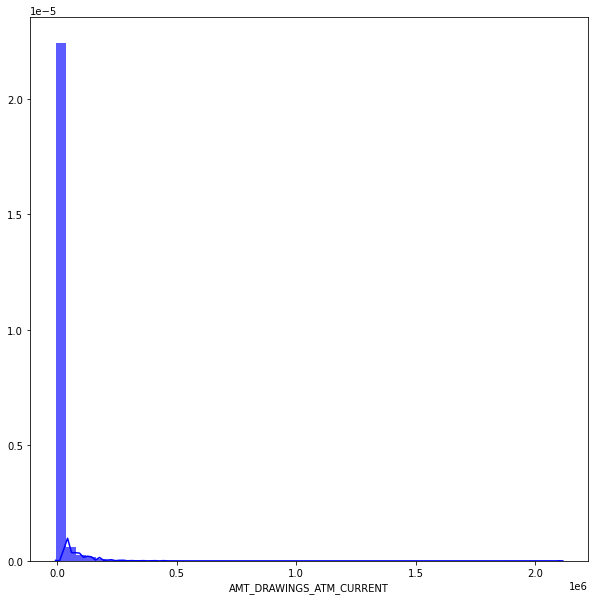

There are 2268 unique values 
0.0        2665718
4500.0       35851
9000.0       27726
45000.0      22946
2250.0       22854
Name: AMT_DRAWINGS_ATM_CURRENT, dtype: int64


In [85]:
plot_graph(cred_bal,'AMT_DRAWINGS_ATM_CURRENT')

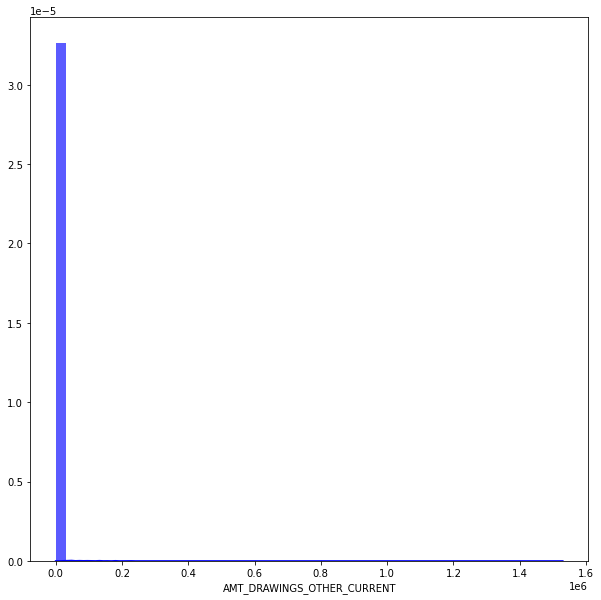

There are 1833 unique values 
0.0       3078163
3343.5        782
6682.5        460
4455.0        441
8910.0        319
Name: AMT_DRAWINGS_OTHER_CURRENT, dtype: int64


In [86]:
plot_graph(cred_bal,'AMT_DRAWINGS_OTHER_CURRENT')

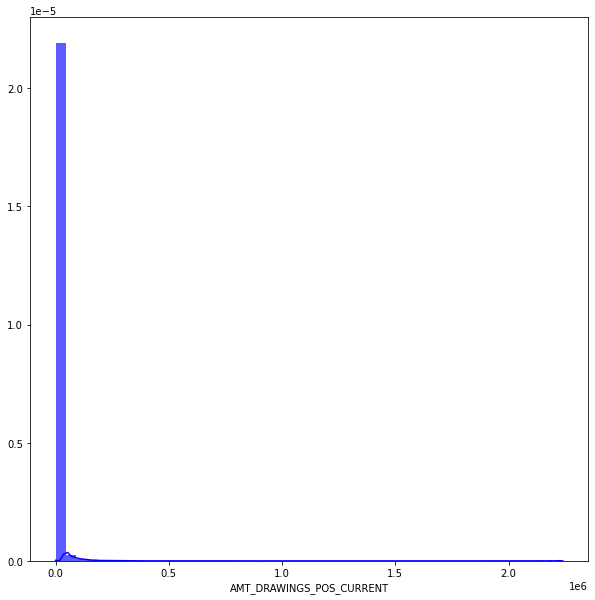

There are 168749 unique values 
0.0       2825595
450.0        1287
900.0         976
2250.0        910
4500.0        801
Name: AMT_DRAWINGS_POS_CURRENT, dtype: int64


In [87]:
plot_graph(cred_bal,'AMT_DRAWINGS_POS_CURRENT')

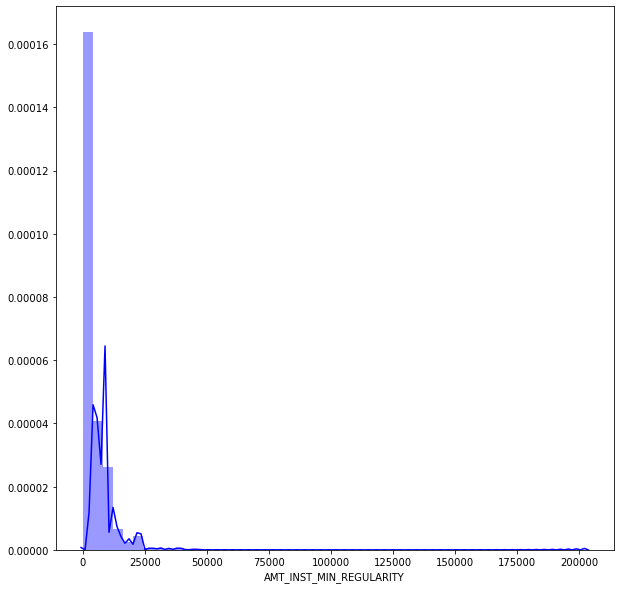

There are 312267 unique values 
0.0       1928864
9000.0     225429
6750.0     147469
3375.0     127613
4500.0     124979
Name: AMT_INST_MIN_REGULARITY, dtype: int64


In [88]:
plot_graph(cred_bal,'AMT_INST_MIN_REGULARITY')

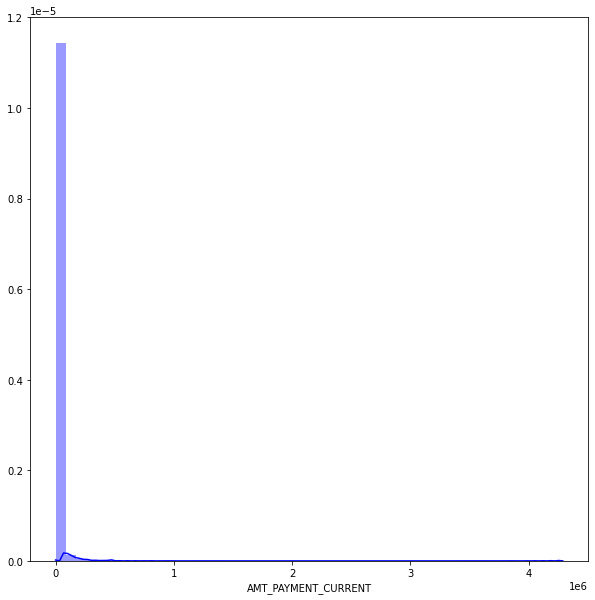

There are 163210 unique values 
0.0        390507
9000.0     257297
4500.0     143572
6750.0     128296
13500.0    100454
Name: AMT_PAYMENT_CURRENT, dtype: int64


In [89]:
plot_graph(cred_bal,'AMT_PAYMENT_CURRENT')

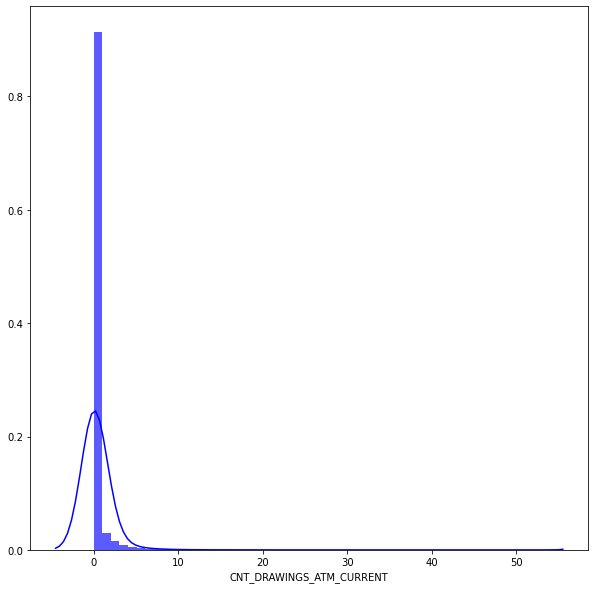

There are 45 unique values 
0.0    2665718
1.0     213460
2.0      95647
3.0      46730
4.0      26335
Name: CNT_DRAWINGS_ATM_CURRENT, dtype: int64


In [90]:
plot_graph(cred_bal,'CNT_DRAWINGS_ATM_CURRENT')

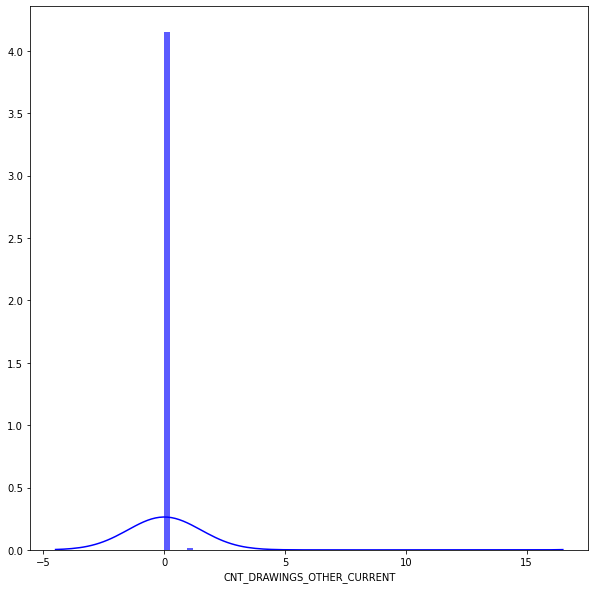

There are 12 unique values 
0.0    3077688
1.0      11354
2.0       1076
3.0        259
4.0         65
Name: CNT_DRAWINGS_OTHER_CURRENT, dtype: int64


In [91]:
plot_graph(cred_bal,'CNT_DRAWINGS_OTHER_CURRENT')

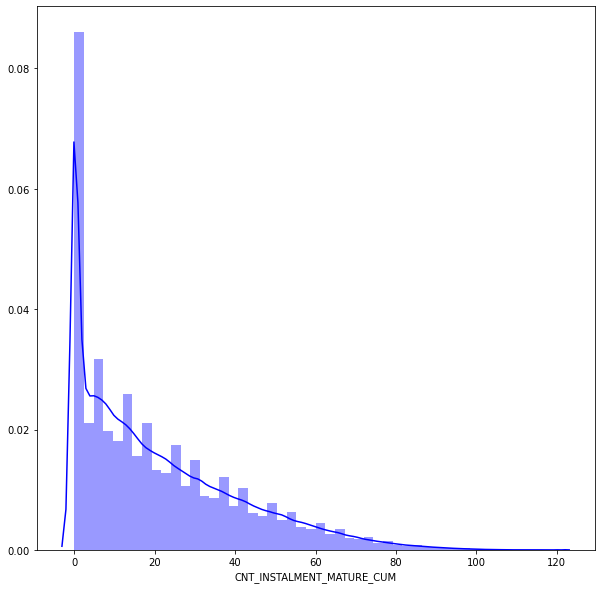

There are 122 unique values 
0.0    551467
5.0     91691
2.0     91035
4.0     89941
6.0     89829
Name: CNT_INSTALMENT_MATURE_CUM, dtype: int64


In [92]:
plot_graph(cred_bal,'CNT_INSTALMENT_MATURE_CUM')

In [93]:
credit_bal_nan = {'AMT_DRAWINGS_ATM_CURRENT': 0,'AMT_DRAWINGS_OTHER_CURRENT': 0,
                  'AMT_DRAWINGS_POS_CURRENT': 0, 'AMT_INST_MIN_REGULARITY': 0, 'AMT_PAYMENT_CURRENT': 0,
                  'CNT_DRAWINGS_ATM_CURRENT': 0, 'CNT_DRAWINGS_OTHER_CURRENT': 0, 
                  'CNT_INSTALMENT_MATURE_CUM': 0}

In [94]:
RemoveNaN(cred_bal,credit_bal_nan)

==========List of Columns which has Nan entries in it===========
['AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_INSTALMENT_MATURE_CUM']

========Name_of_Column number_of_NaN_values percentage_of_NaN_value=====
 ========unique_values_of_that_columns======

AMT_DRAWINGS_ATM_CURRENT 749816 19.52487193748841
AMT_DRAWINGS_ATM_CURRENT has more than 100 unique values

AMT_DRAWINGS_OTHER_CURRENT 749816 19.52487193748841
AMT_DRAWINGS_OTHER_CURRENT has more than 100 unique values

AMT_DRAWINGS_POS_CURRENT 749816 19.52487193748841
AMT_DRAWINGS_POS_CURRENT has more than 100 unique values

AMT_INST_MIN_REGULARITY 305236 7.948208374736219
AMT_INST_MIN_REGULARITY has more than 100 unique values

AMT_PAYMENT_CURRENT 767988 19.998062657409086
AMT_PAYMENT_CURRENT has more than 100 unique values

CNT_DRAWINGS_ATM_CURRENT 749816 19.52487193748841
[ 0.  2.

In [95]:
crb_Onehot = ['NAME_CONTRACT_STATUS']
cred_bal = pd.get_dummies(cred_bal,columns=crb_Onehot,drop_first=True)

## Merging cred_bal and prev_app

In [96]:
cred_merge = {'SK_ID_CURR': ['ignore', 0.0],
 'MONTHS_BALANCE': ['min', 0.0],
 'AMT_BALANCE': ['min', 0.0],
 'AMT_CREDIT_LIMIT_ACTUAL': ['mean', 0.0],
 'AMT_DRAWINGS_ATM_CURRENT': ['mean', 0.0],
 'AMT_DRAWINGS_CURRENT': ['mean', 0.0],
 'AMT_DRAWINGS_OTHER_CURRENT': ['mean', 0.0],
 'AMT_DRAWINGS_POS_CURRENT': ['mean', 0.0],
 'AMT_INST_MIN_REGULARITY': ['mean', 0.0],
 'AMT_PAYMENT_CURRENT': ['mean', 0.0],
 'CNT_DRAWINGS_ATM_CURRENT': ['sum', 0.0],
 'CNT_DRAWINGS_CURRENT': ['sum', 0.0],
 'CNT_DRAWINGS_OTHER_CURRENT': ['sum', 0.0],
 'CNT_INSTALMENT_MATURE_CUM': ['sum', 0.0],
 'SK_DPD': ['sum', 0.0],
 'SK_DPD_DEF': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Approved': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Completed': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Demand': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Refused': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Sent proposal': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Signed': ['sum', 0.0]}
prev_app = merge(cred_bal,prev_app,'SK_ID_PREV',cred_merge)

SK_ID_PREV
SK_ID_CURR
MONTHS_BALANCE
AMT_BALANCE
AMT_CREDIT_LIMIT_ACTUAL
AMT_DRAWINGS_ATM_CURRENT
AMT_DRAWINGS_CURRENT
AMT_DRAWINGS_OTHER_CURRENT
AMT_DRAWINGS_POS_CURRENT
AMT_INST_MIN_REGULARITY
AMT_PAYMENT_CURRENT
CNT_DRAWINGS_ATM_CURRENT
CNT_DRAWINGS_CURRENT
CNT_DRAWINGS_OTHER_CURRENT
CNT_INSTALMENT_MATURE_CUM
SK_DPD
SK_DPD_DEF
NAME_CONTRACT_STATUS_Approved
NAME_CONTRACT_STATUS_Completed
NAME_CONTRACT_STATUS_Demand
NAME_CONTRACT_STATUS_Refused
NAME_CONTRACT_STATUS_Sent proposal
NAME_CONTRACT_STATUS_Signed


In [97]:
del cred_bal
gc.collect()

14991

# Application train values

In [98]:
apptrain = pd.read_csv('/kaggle/input/iiitb2020-home-credit-default-risk/application_train.csv')

In [99]:
apptrain.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0     aou6ud       0         Cash loans           M            N   
1     xxbaad       0         Cash loans           F            N   
2     xdrbad       0         Cash loans           F            N   
3     rbdd7d       0         Cash loans           F            N   
4     rexddr       1         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          360000.0   1125000.0      33025.5   
1               Y             0          112500.0    251280.0      13630.5   
2               Y             0          225000.0    544491.0      15916.5   
3               N             2          211500.0    900000.0      26316.0   
4               Y             0           90000.0    113760.0       8406.0   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        NaN                       NaN   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         NaN                        NaN   
1                         0.0                        0.0   
2                         1.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        NaN                         NaN  
1                        0.0                         6.0  
2                        0.0                         2.0  
3                        0.0                         0.0  
4                        1.0                         2.0  

[5 rows x 122 columns]

In [100]:
apptrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199882 entries, 0 to 199881
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(17)
memory usage: 186.0+ MB


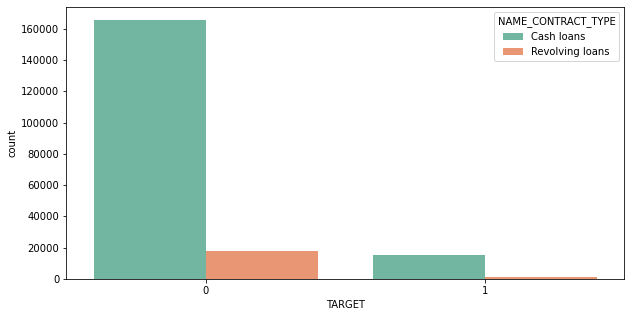

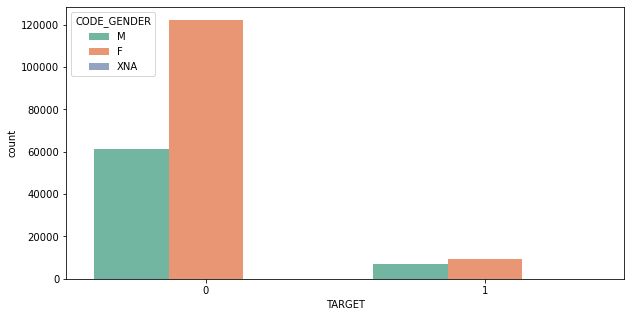

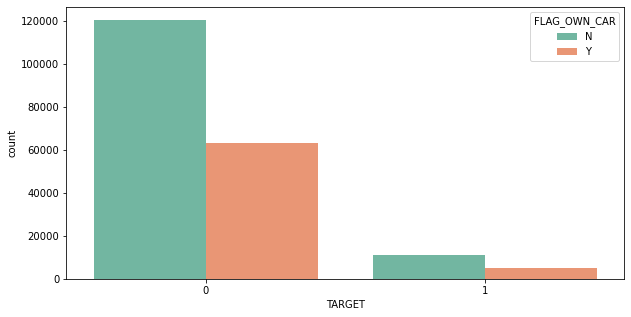

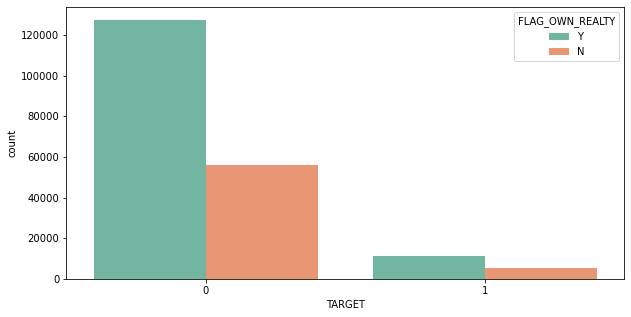

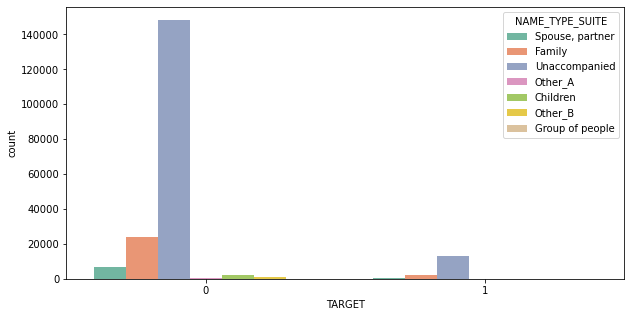

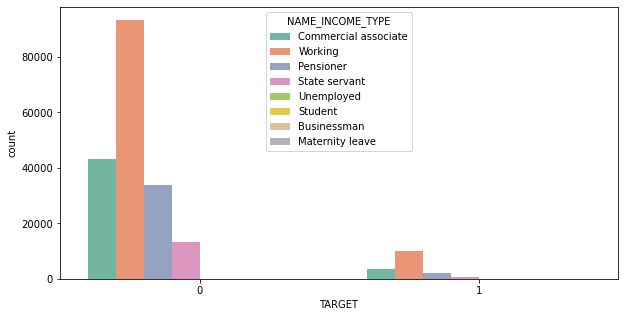

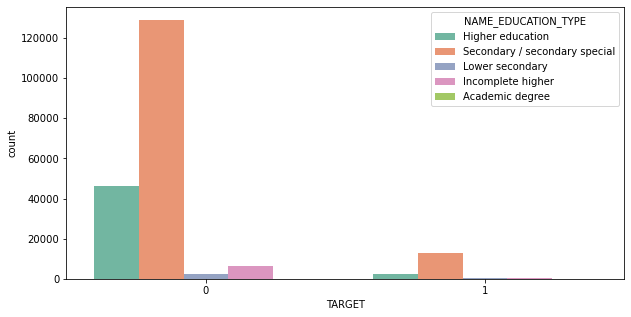

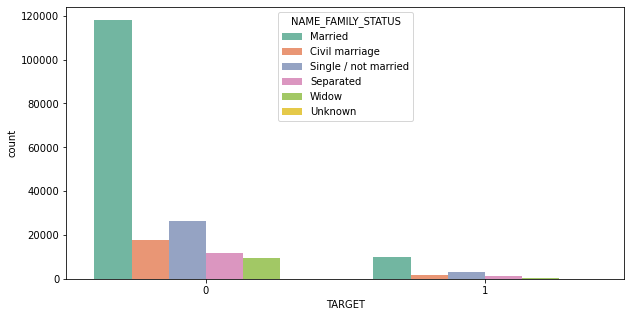

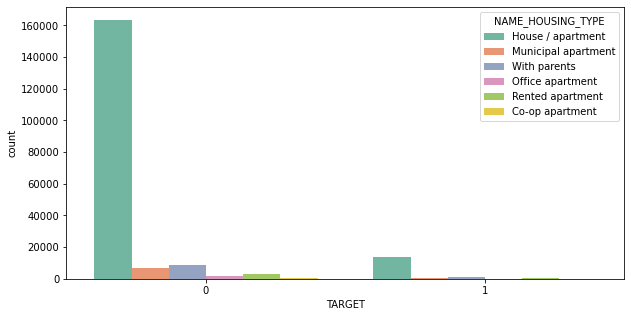

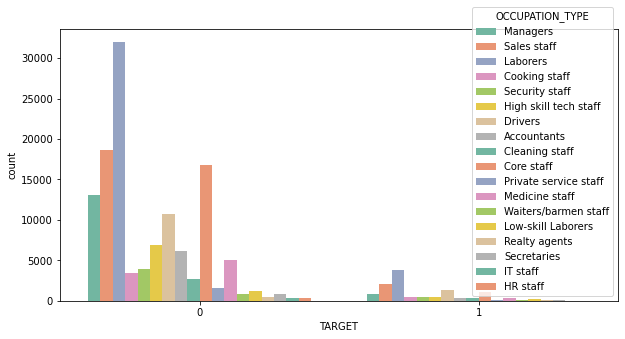

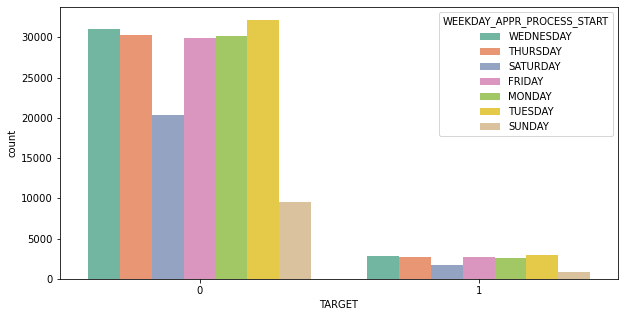

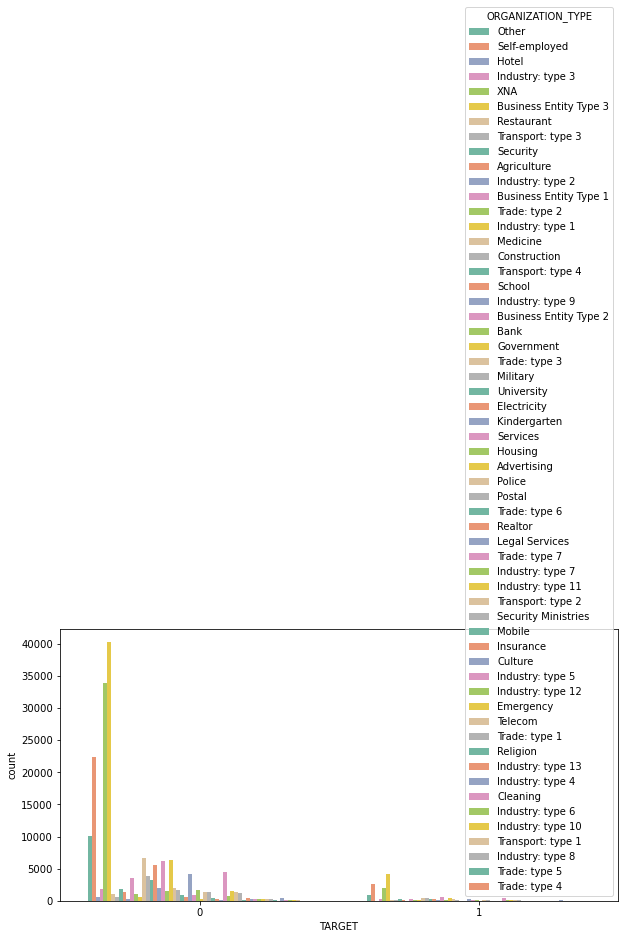

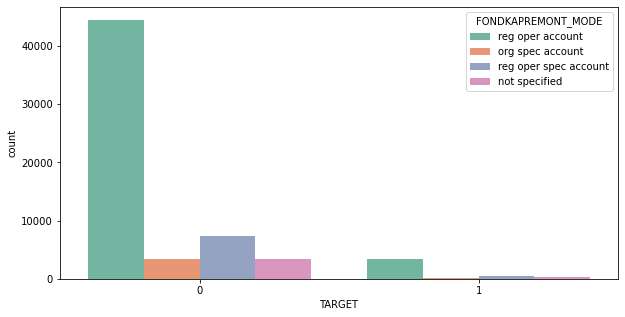

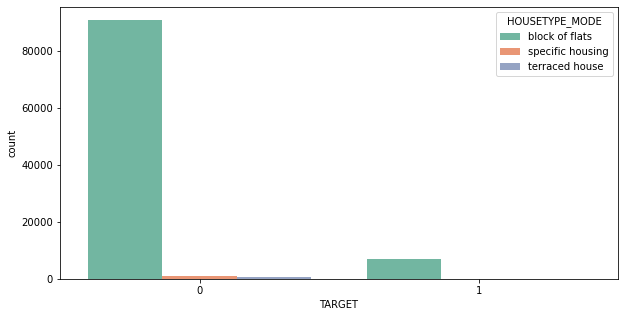

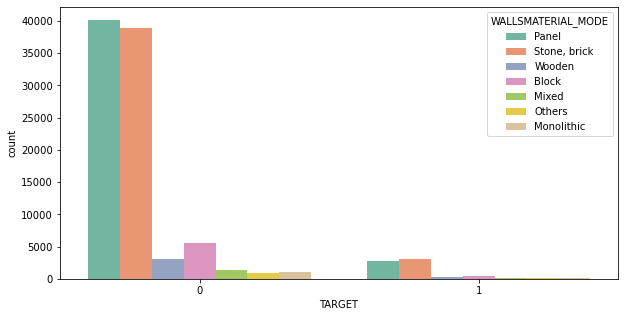

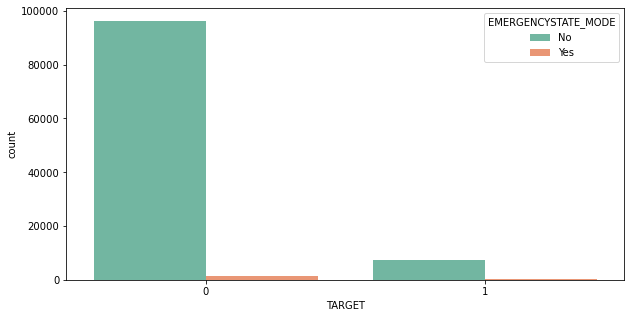

In [101]:
train=apptrain.drop(columns=['SK_ID_CURR'])
for i in train:
    if (train[i].dtype=='object'):
        plt.figure(figsize=(10,5))
        sns.countplot(data=train,x='TARGET',hue=i,palette="Set2")
#         plat.xticks(rotation=90)
        plt.show()

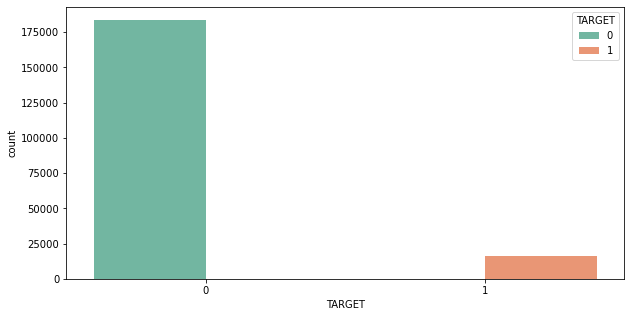

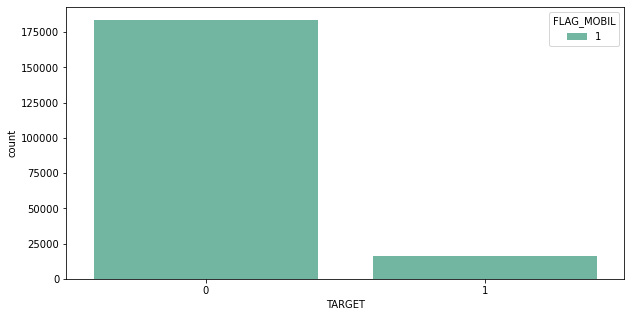

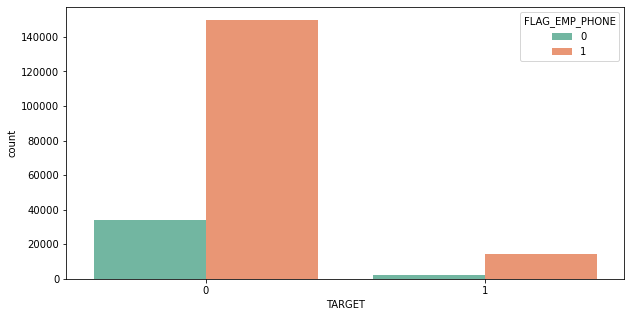

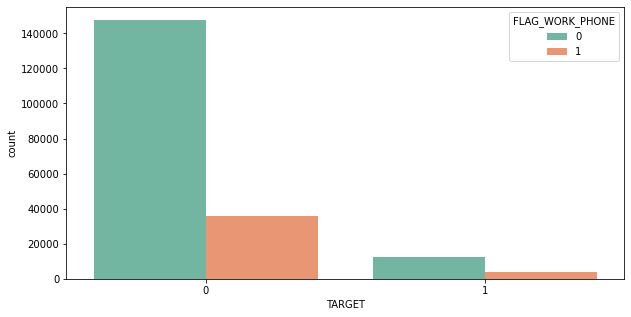

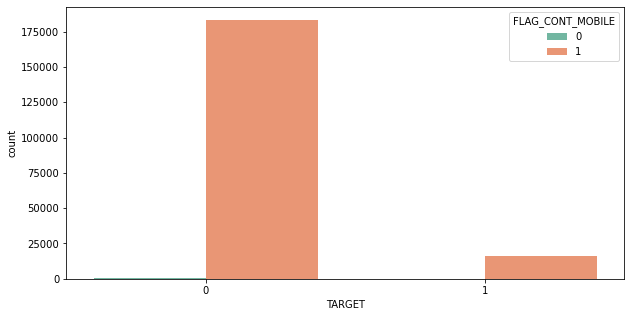

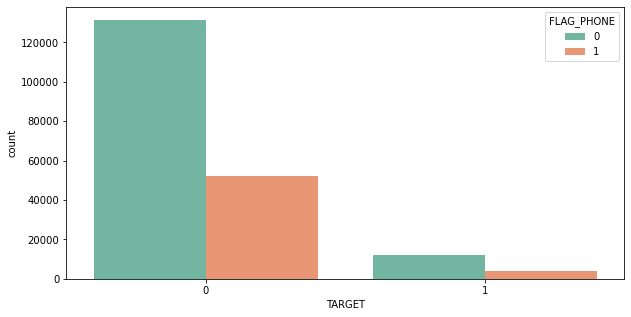

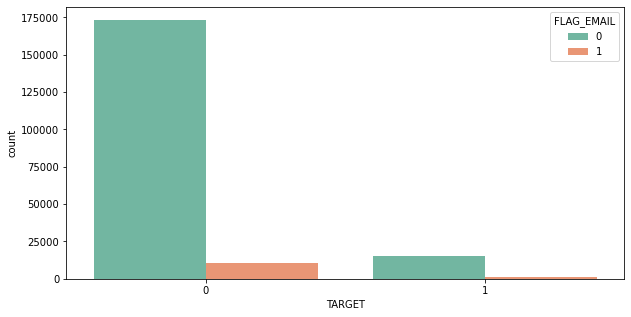

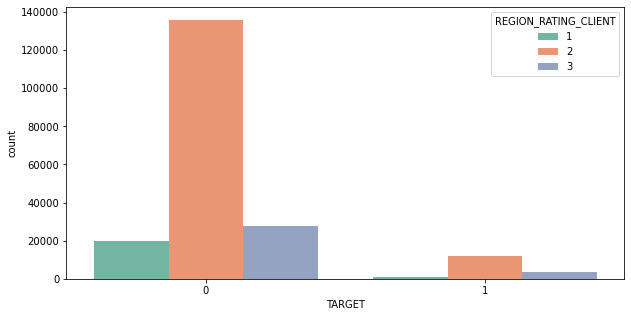

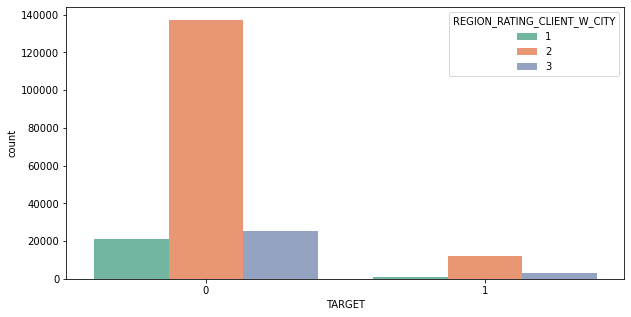

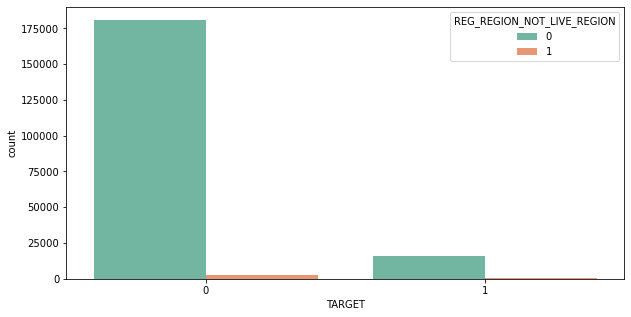

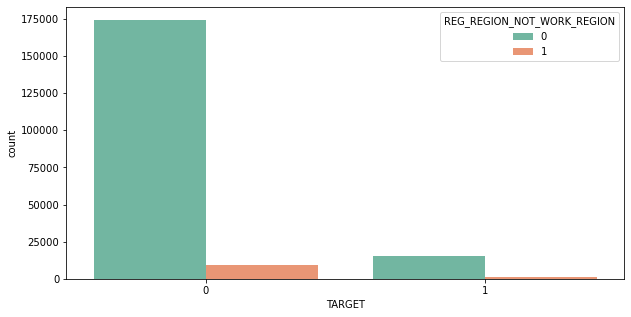

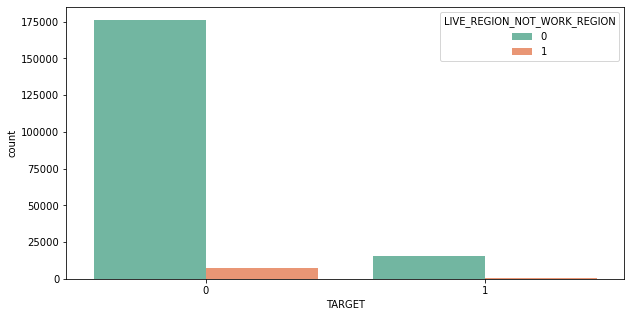

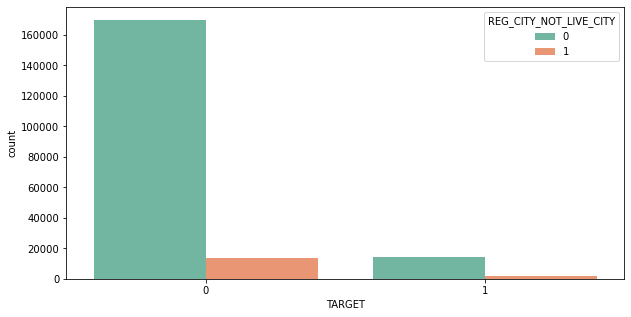

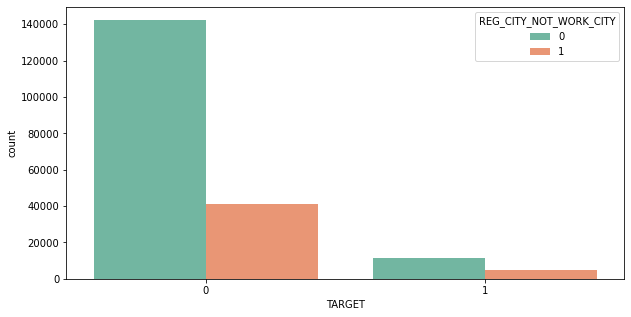

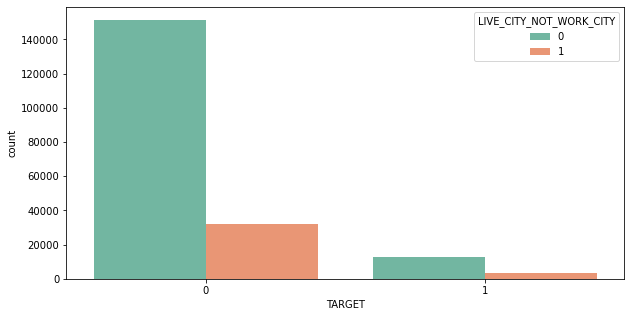

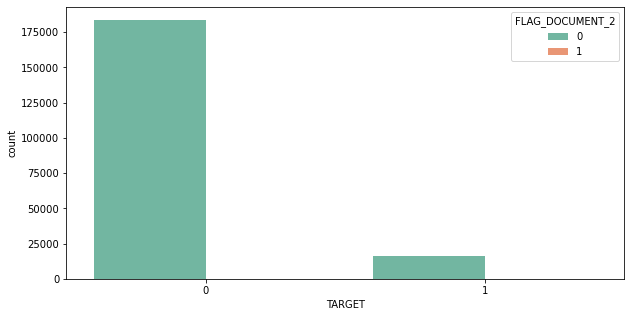

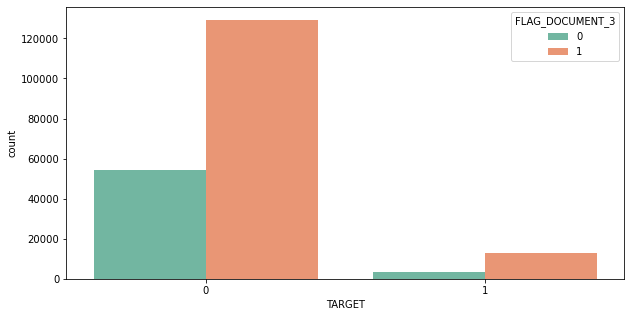

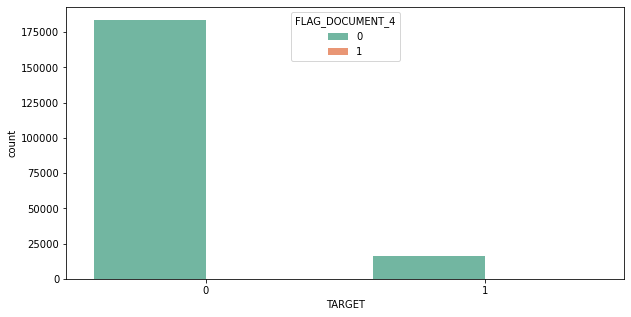

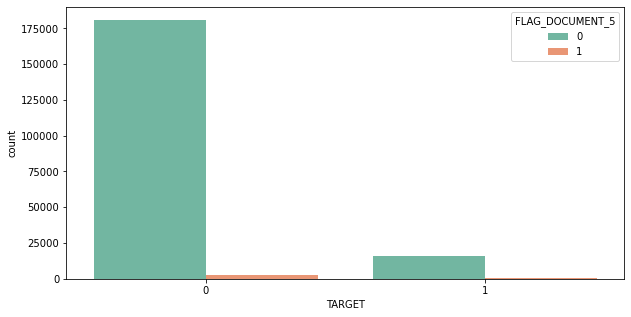

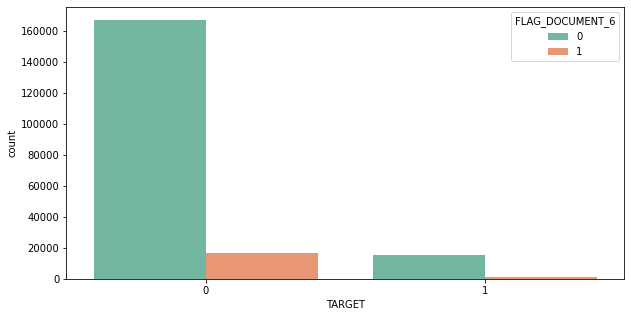

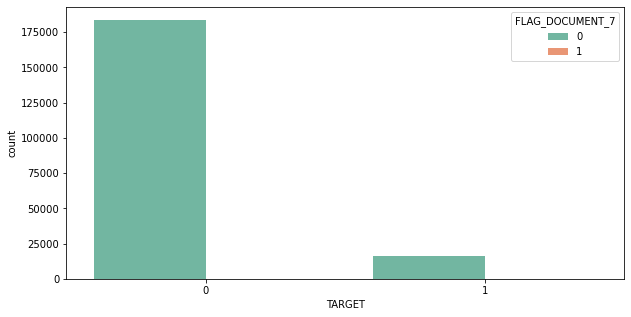

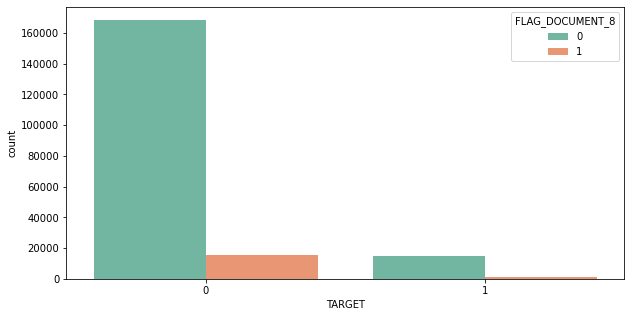

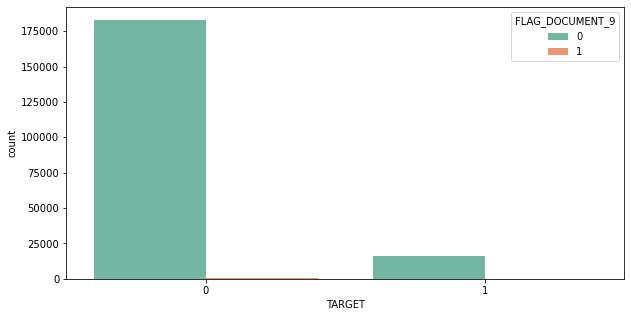

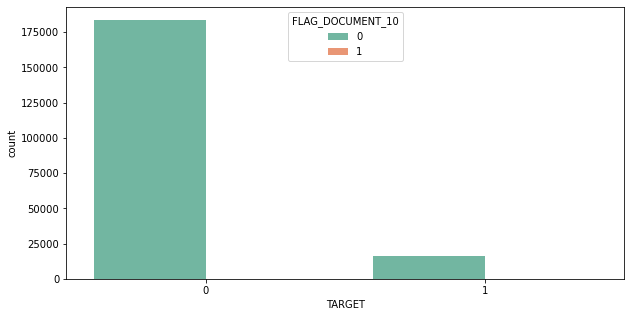

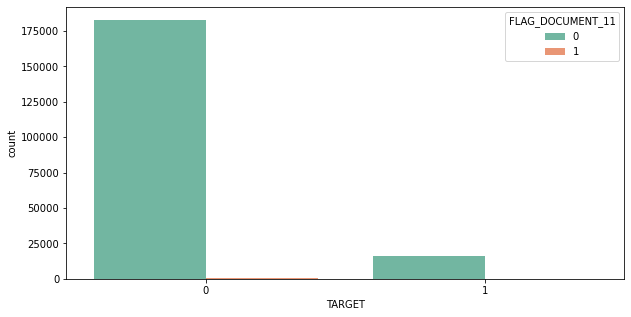

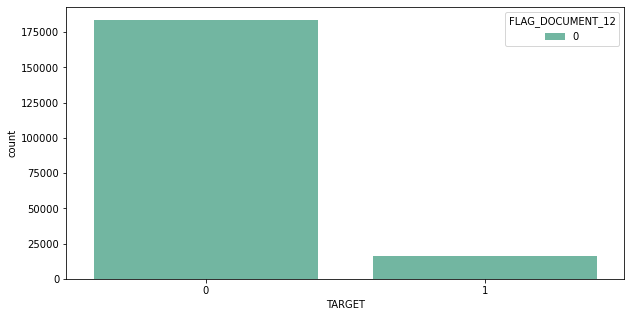

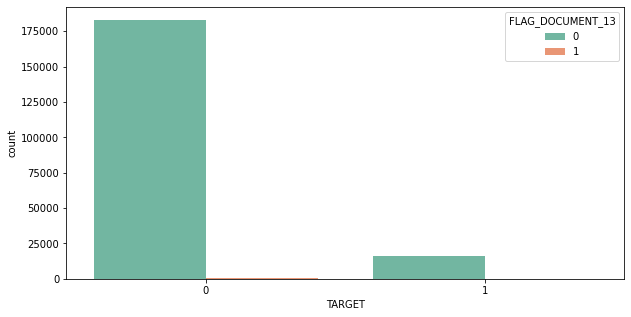

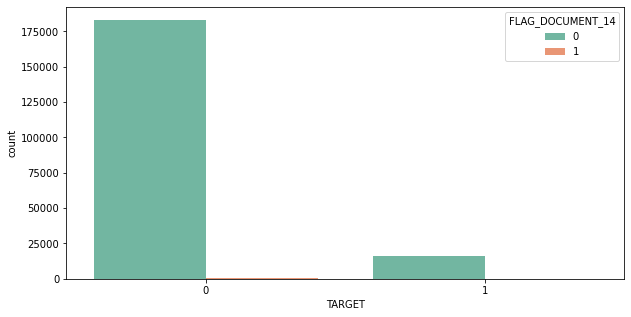

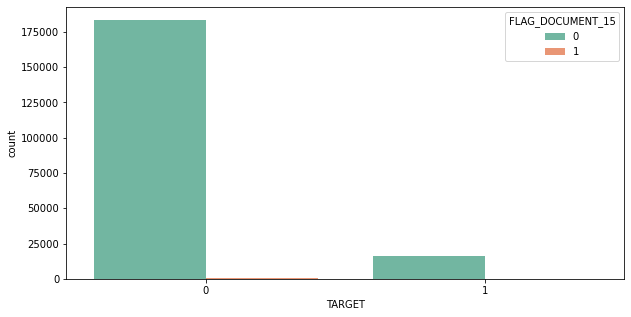

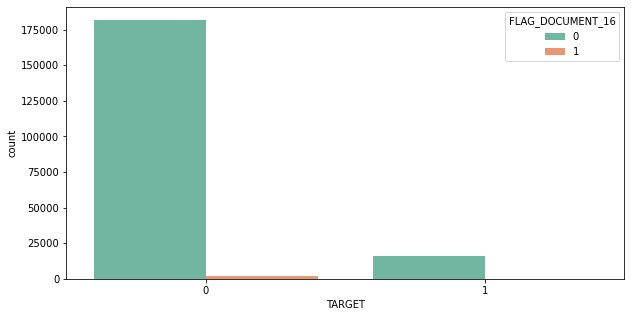

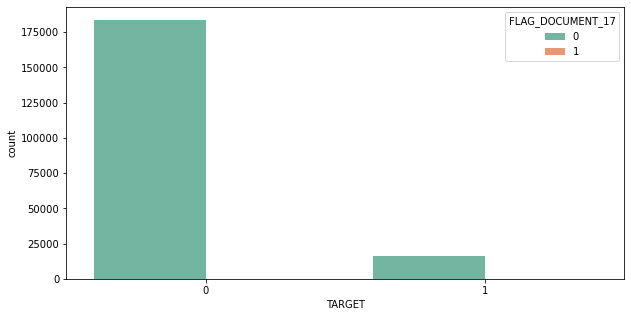

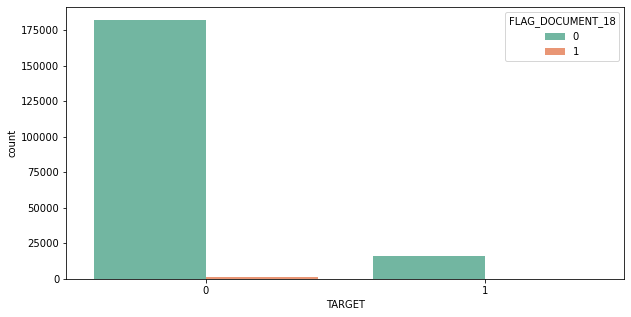

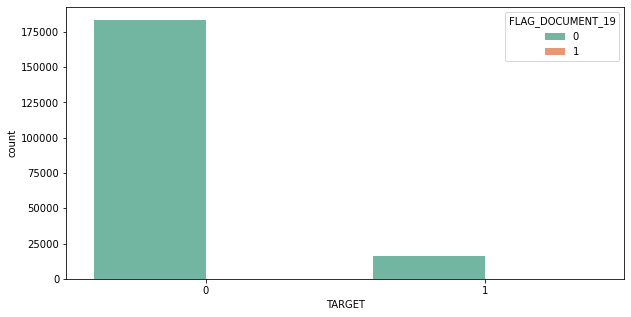

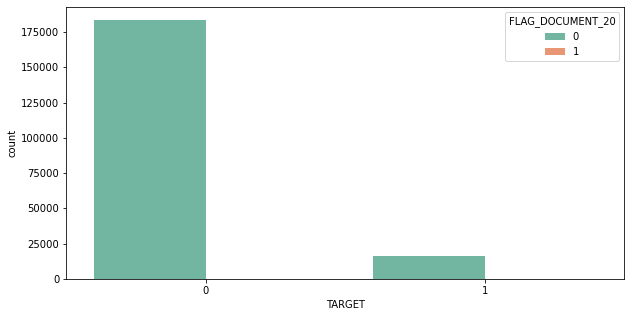

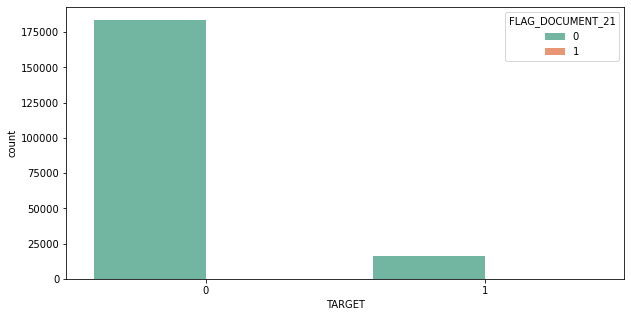

In [102]:
for i in train:
    if (len(train[i].unique())<=3 and not train[i].dtype=='object'):
        plt.figure(figsize=(10,5))
        sns.countplot(data=train,x='TARGET',hue=i,palette="Set2")
        plt.show()

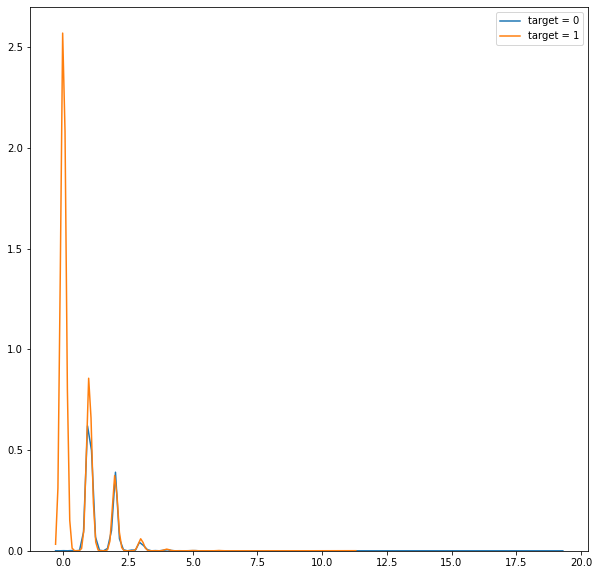

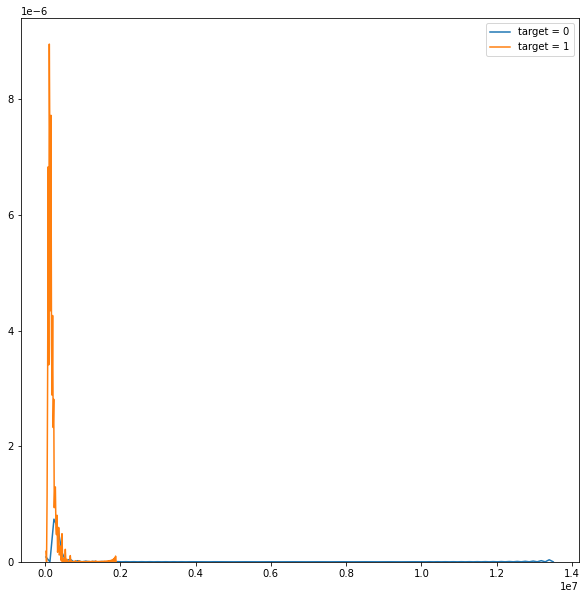

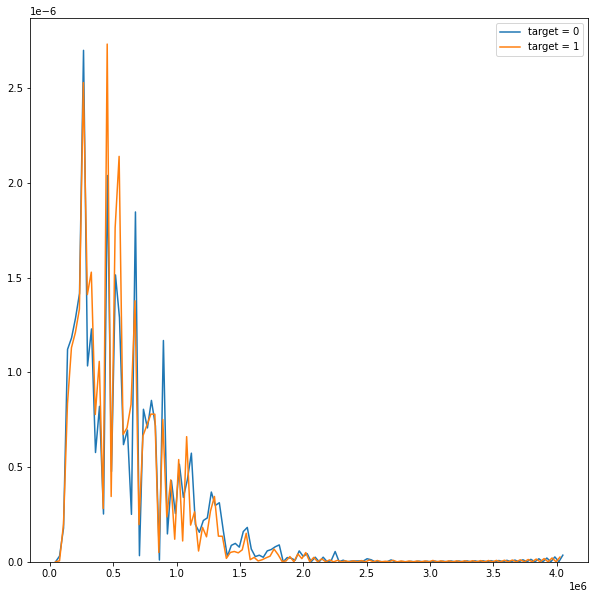

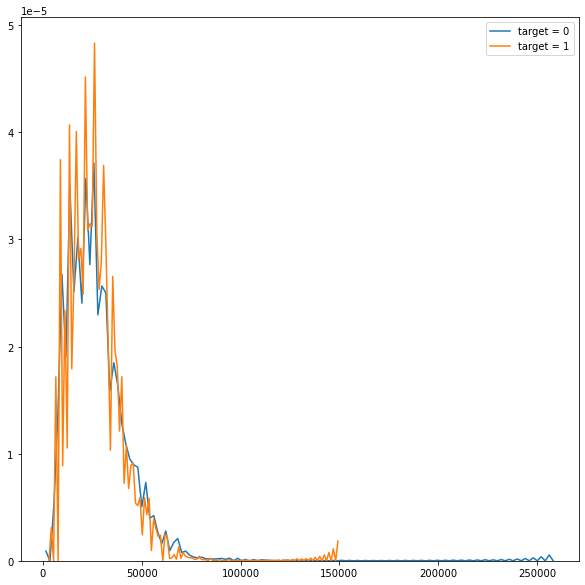

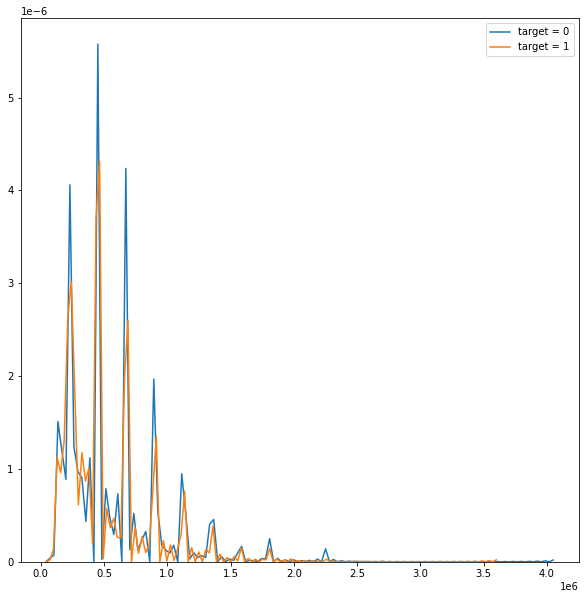

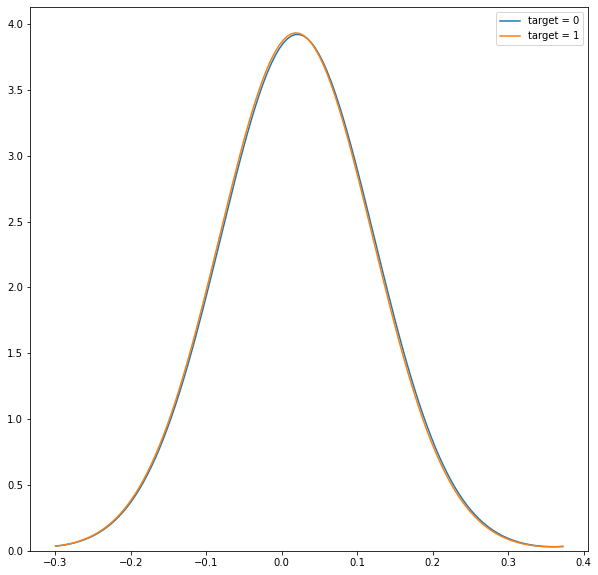

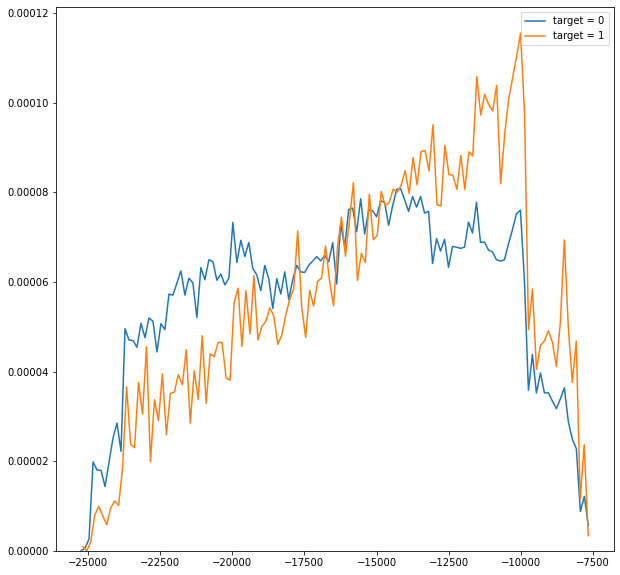

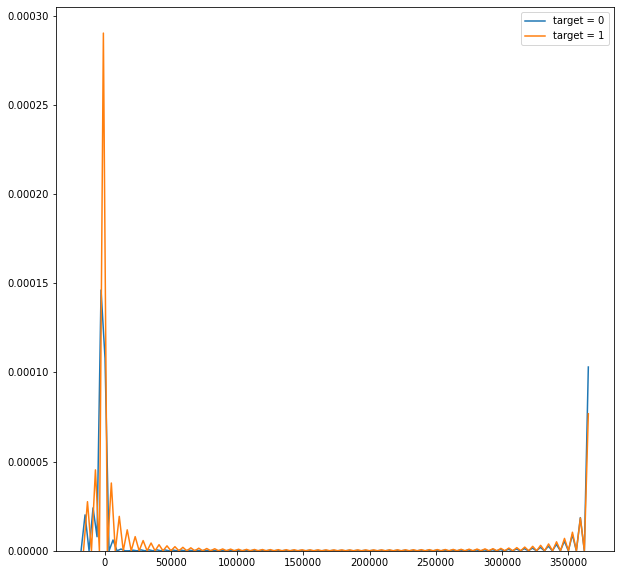

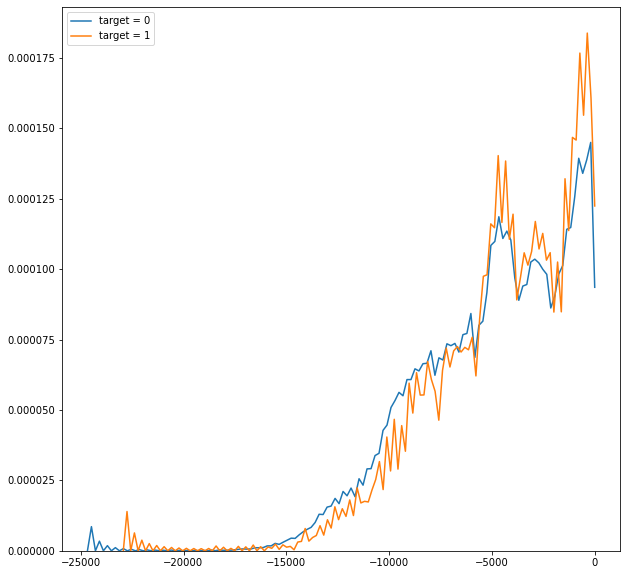

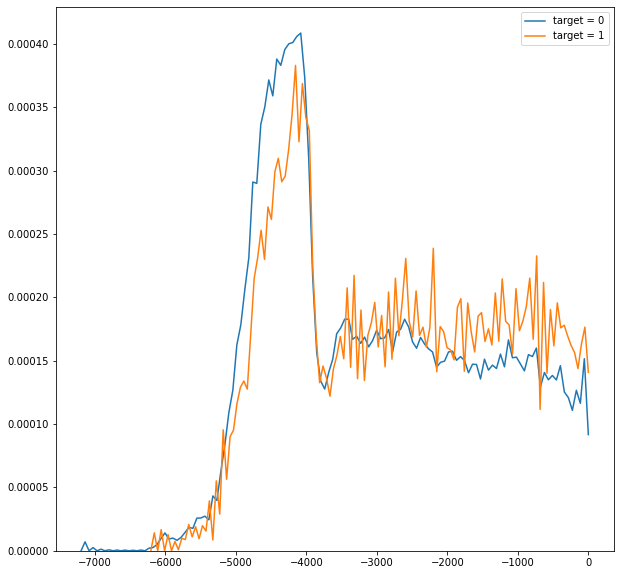

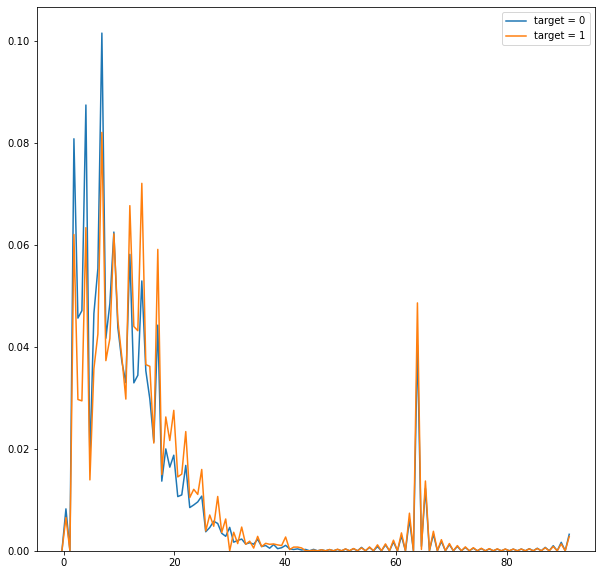

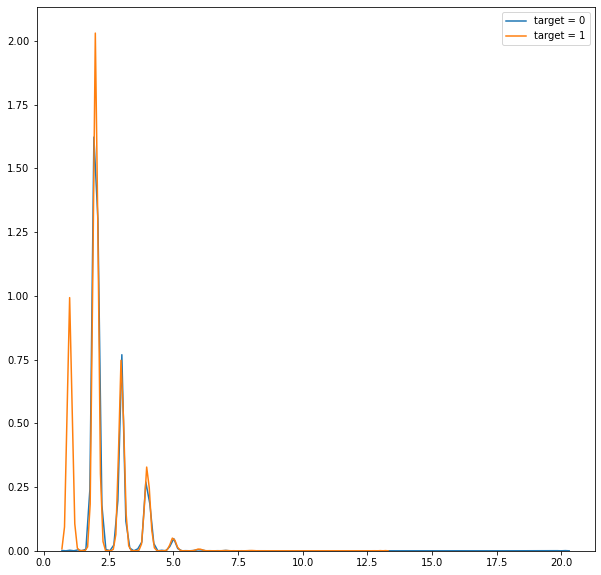

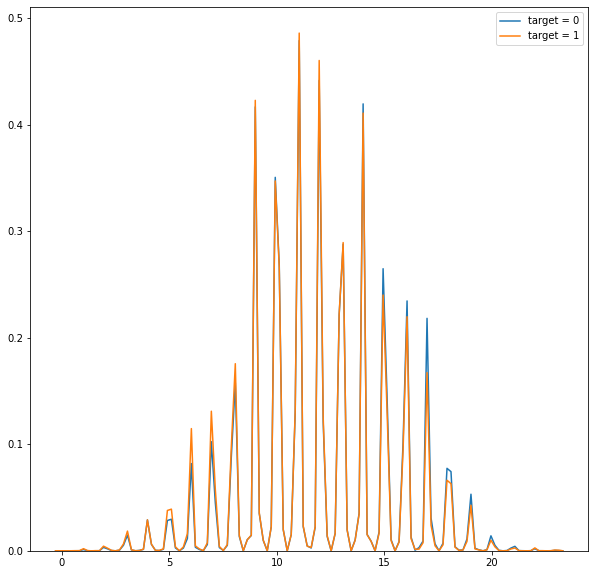

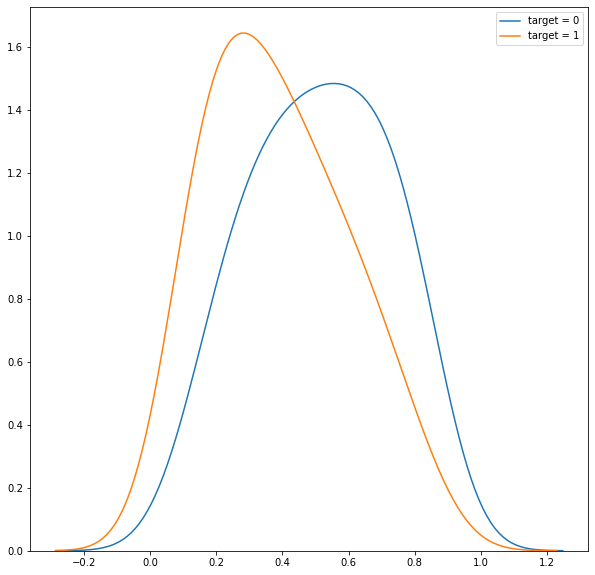

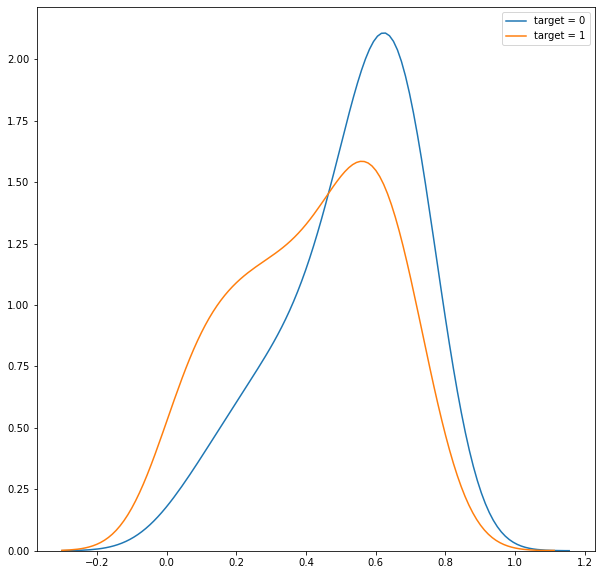

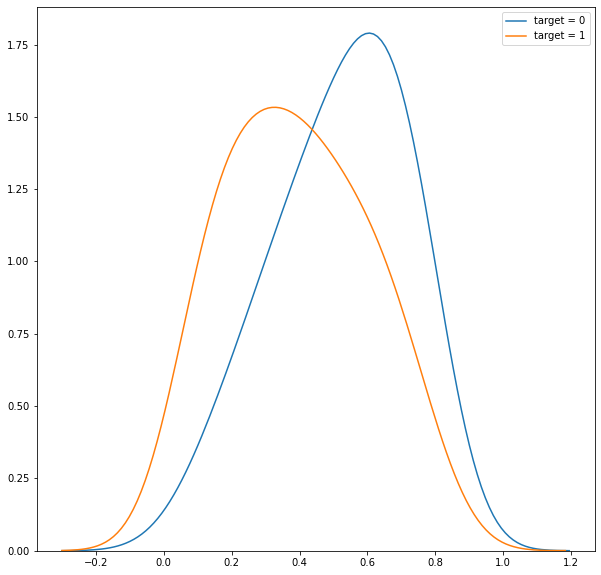

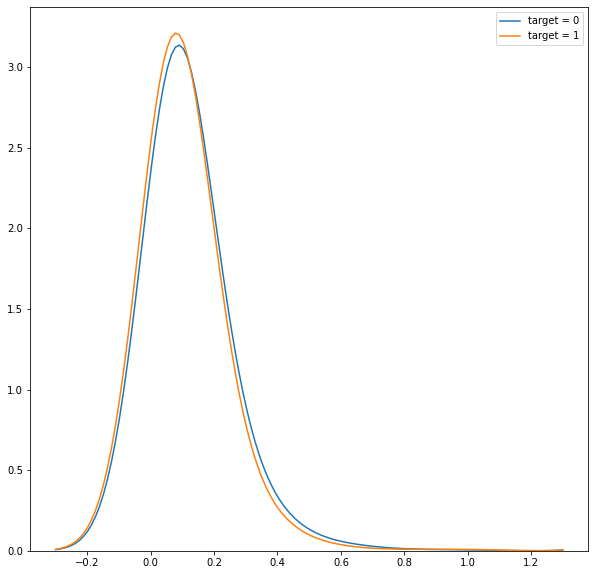

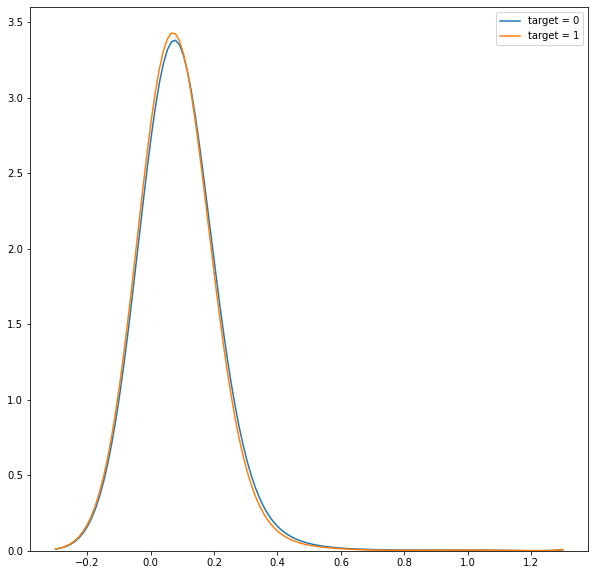

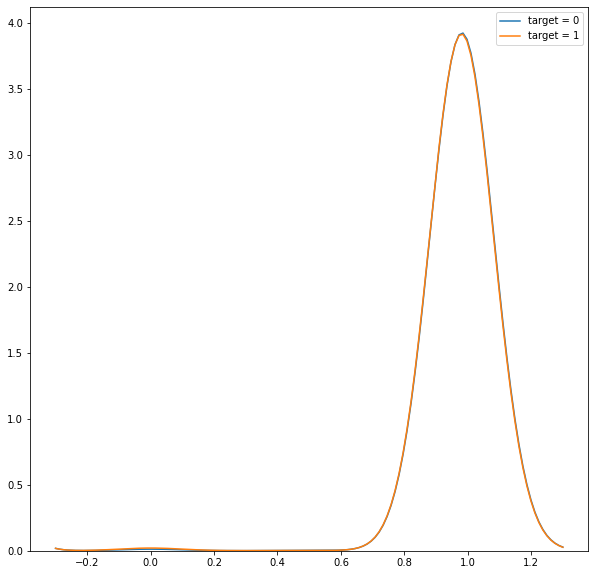

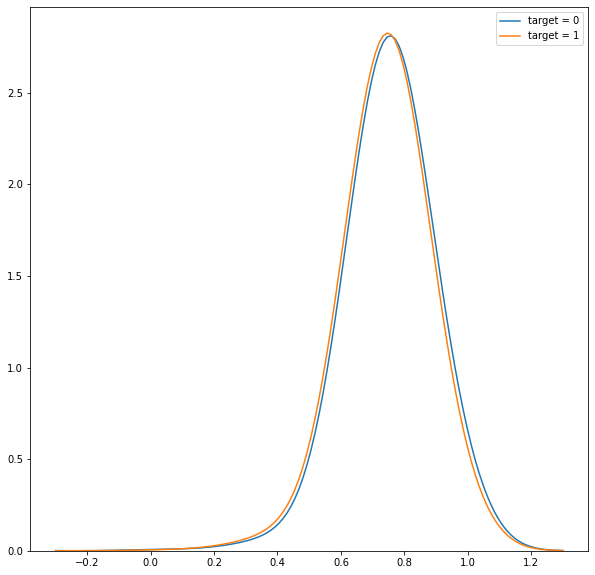

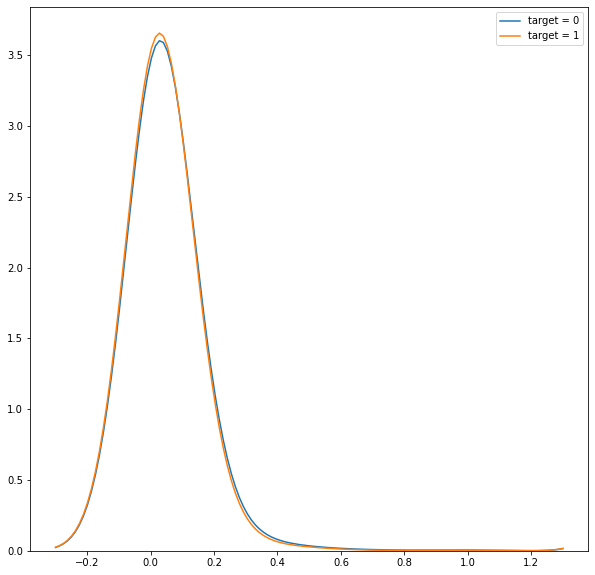

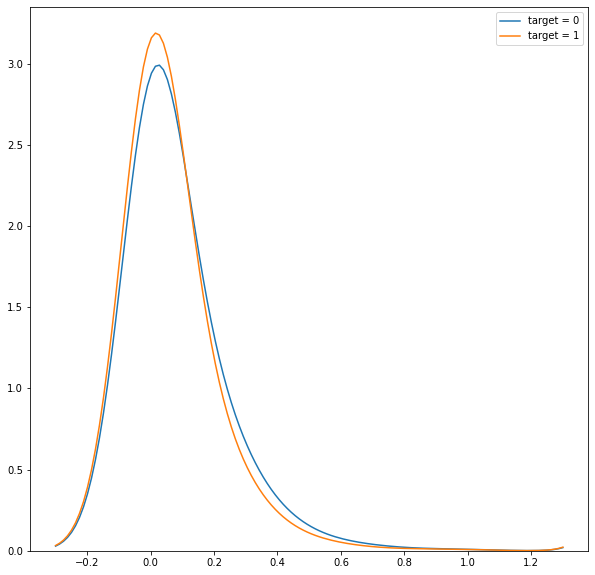

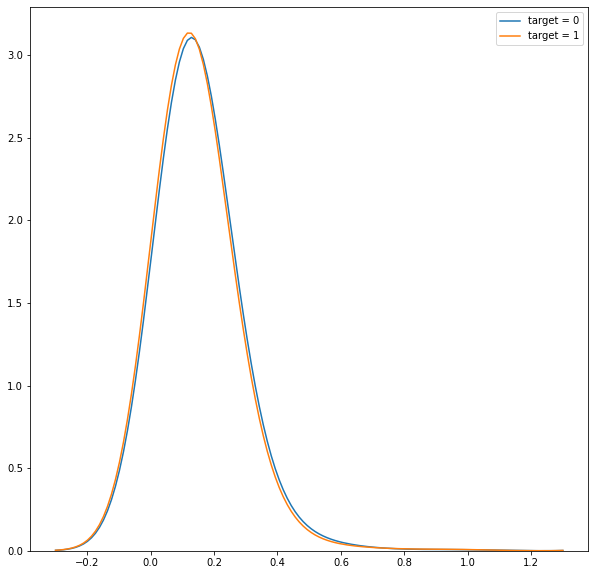

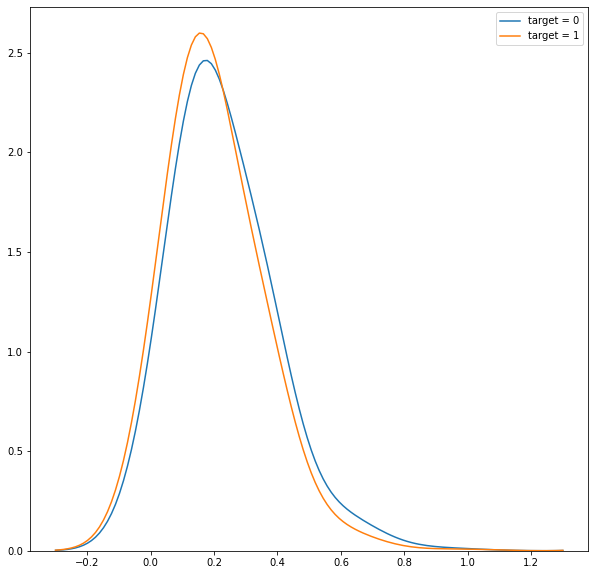

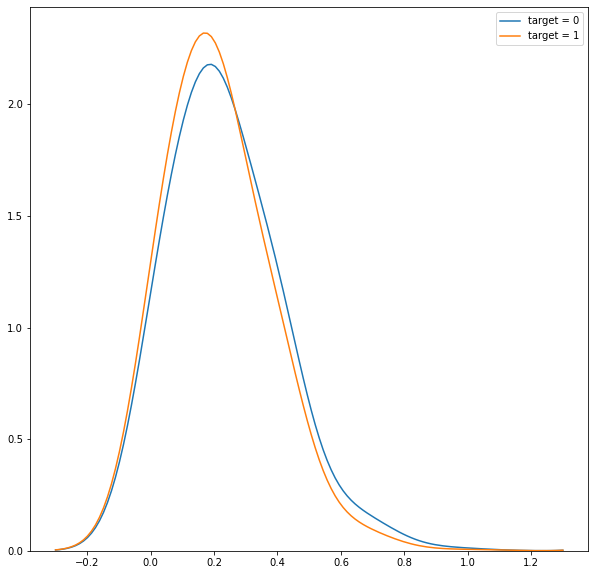

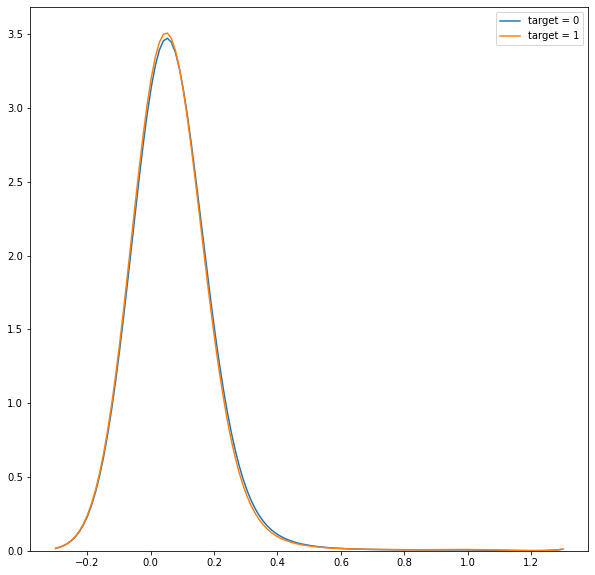

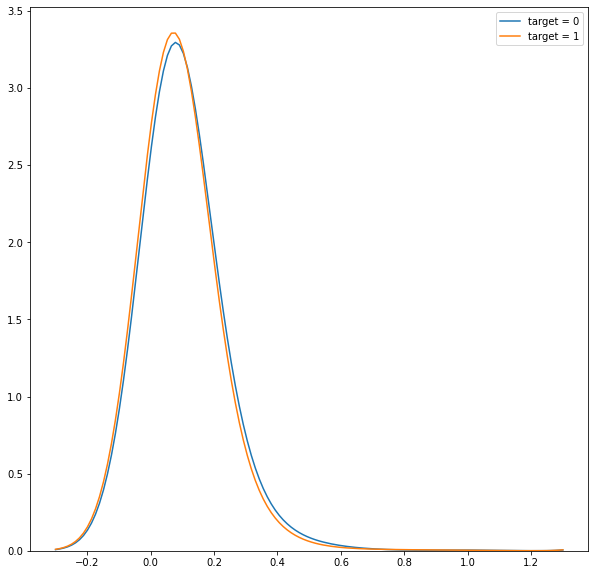

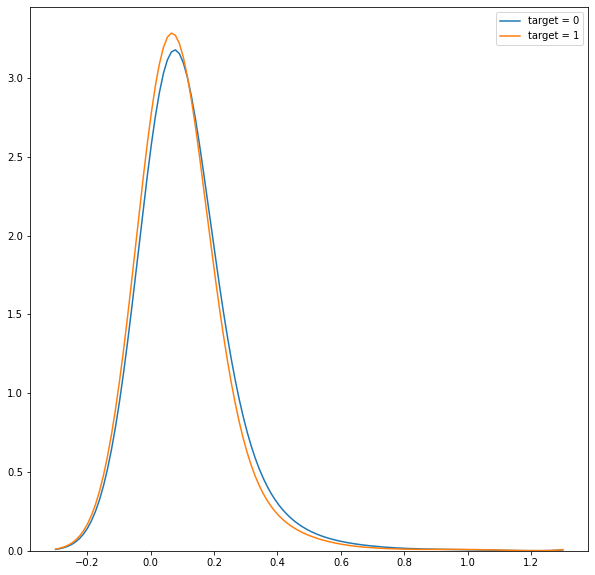

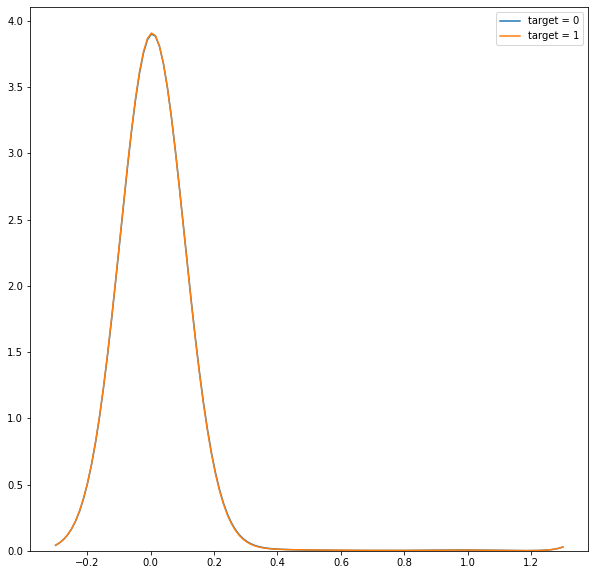

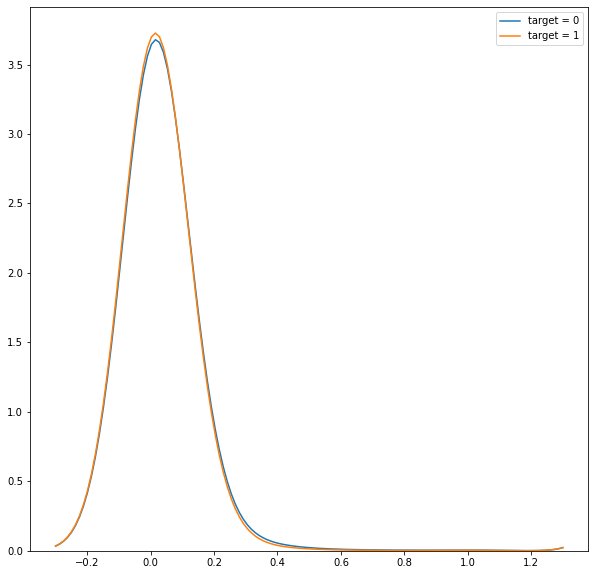

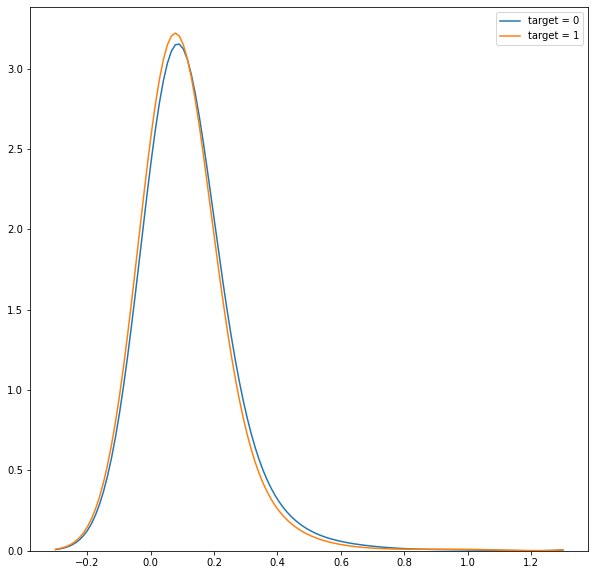

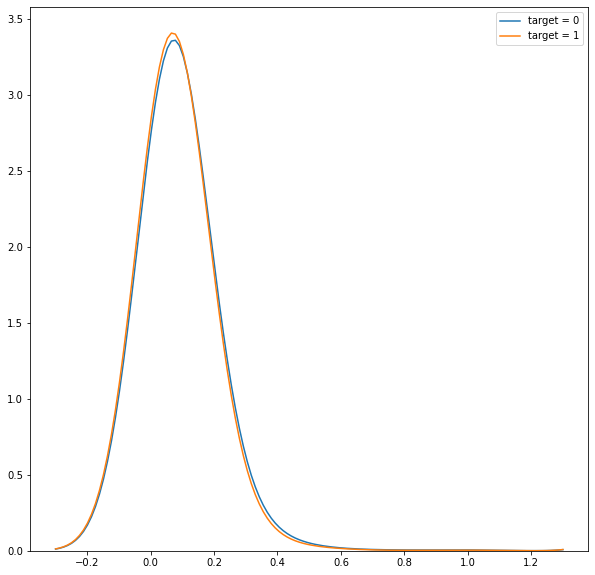

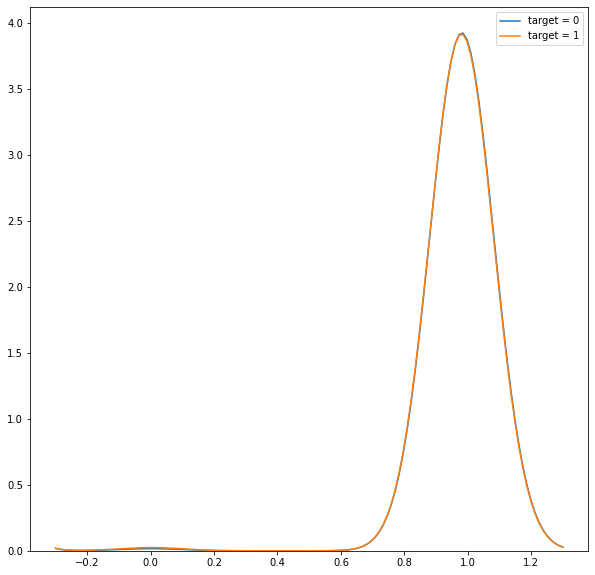

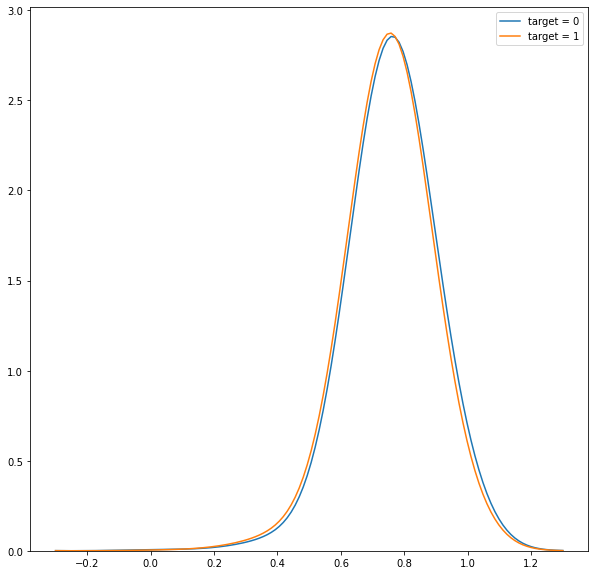

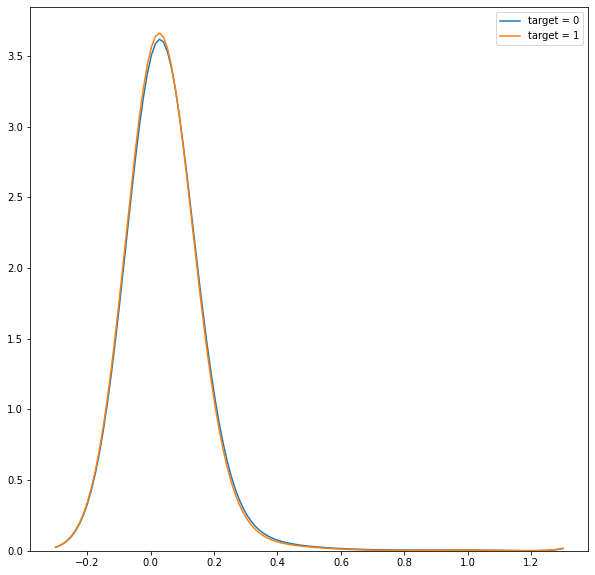

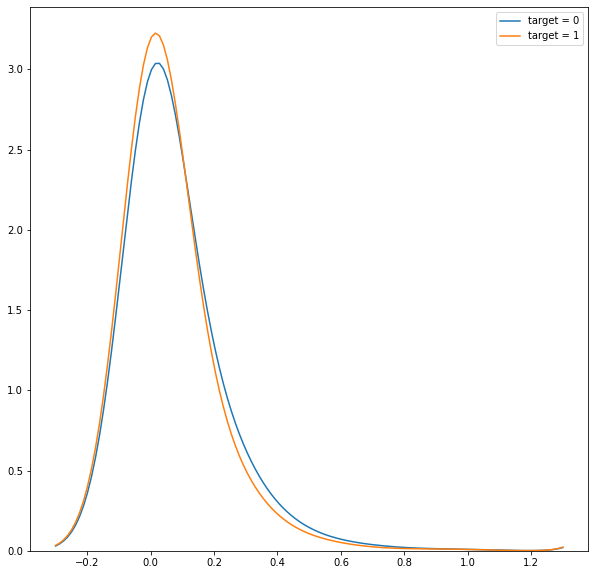

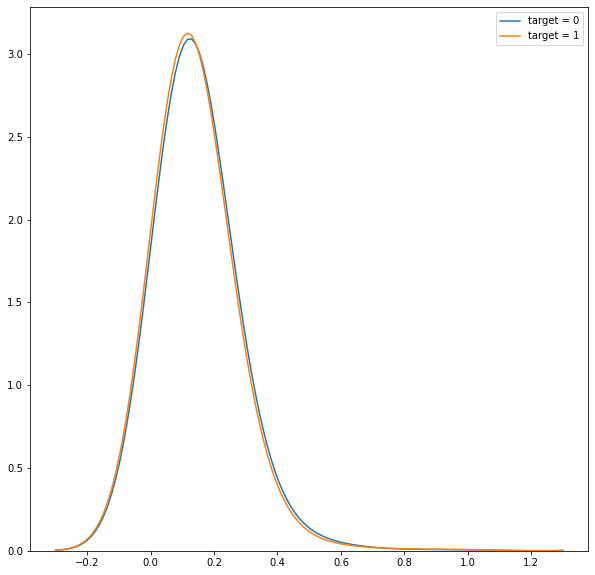

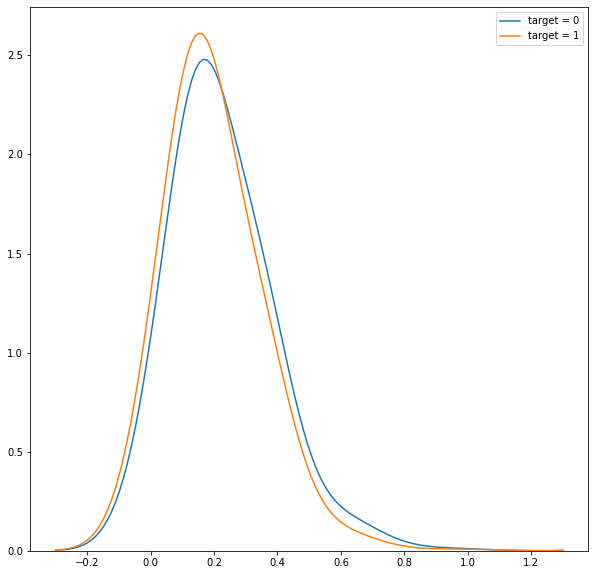

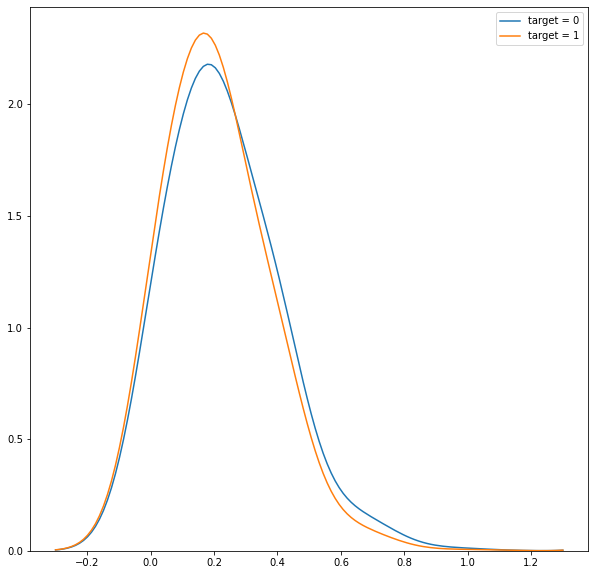

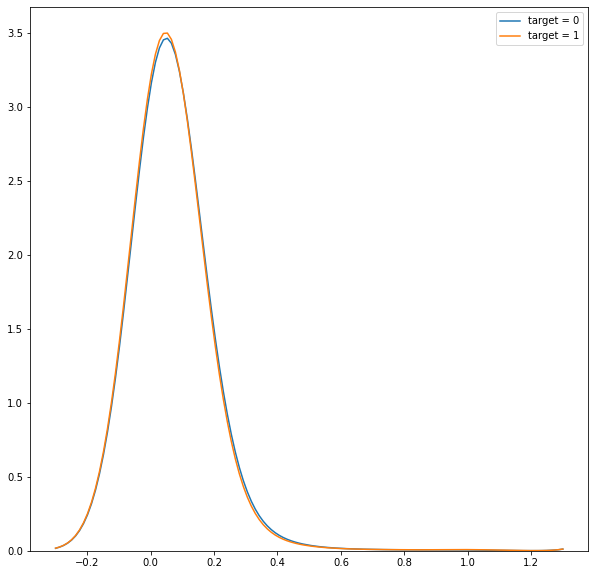

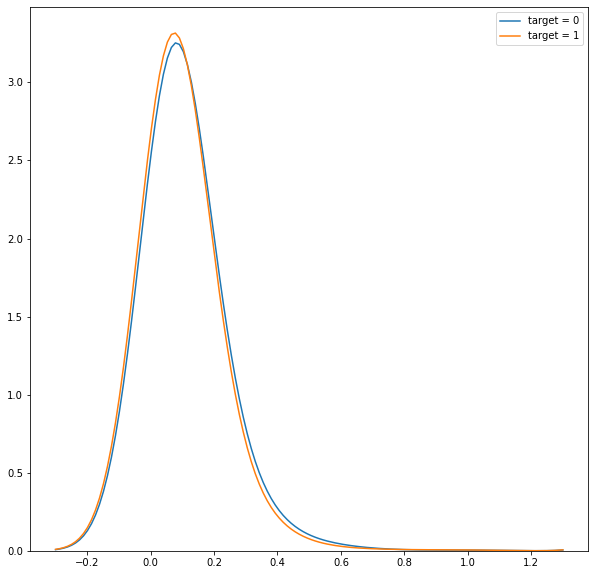

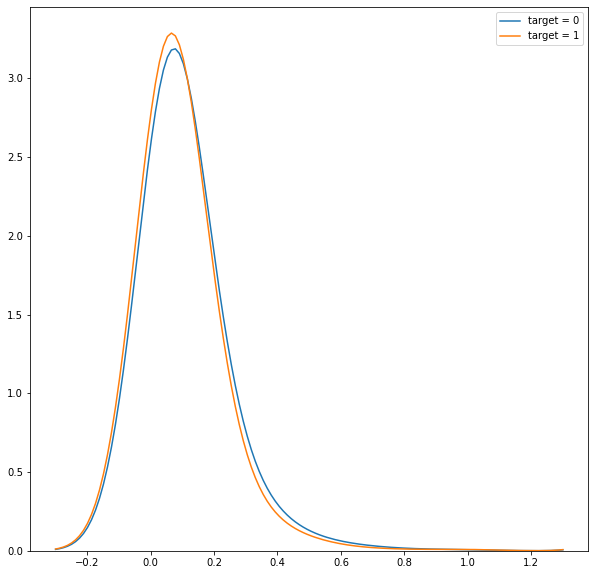

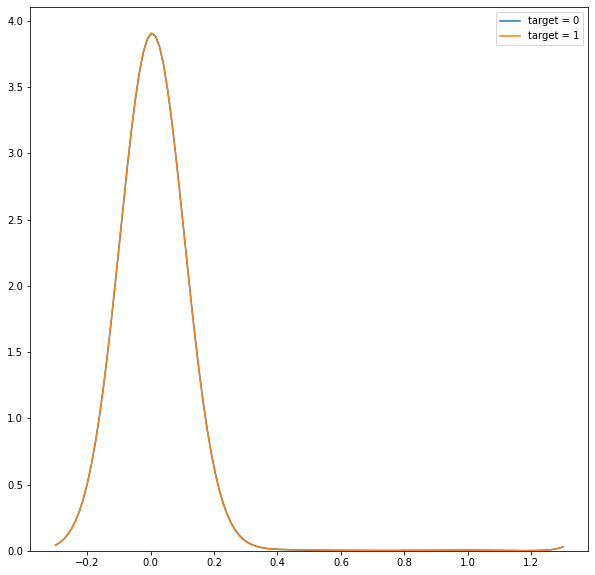

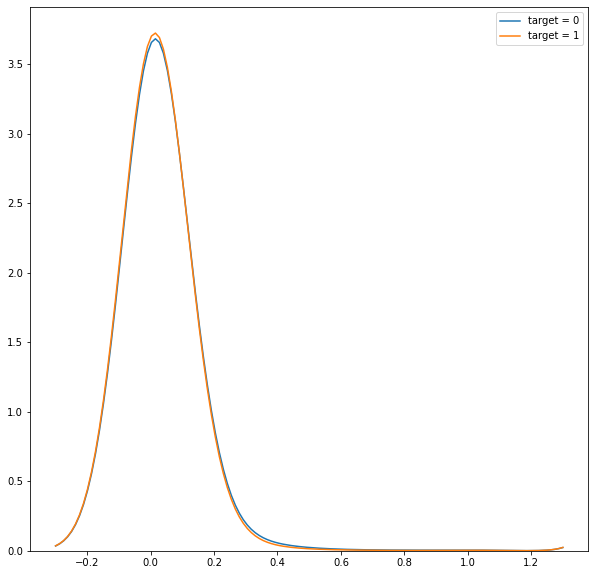

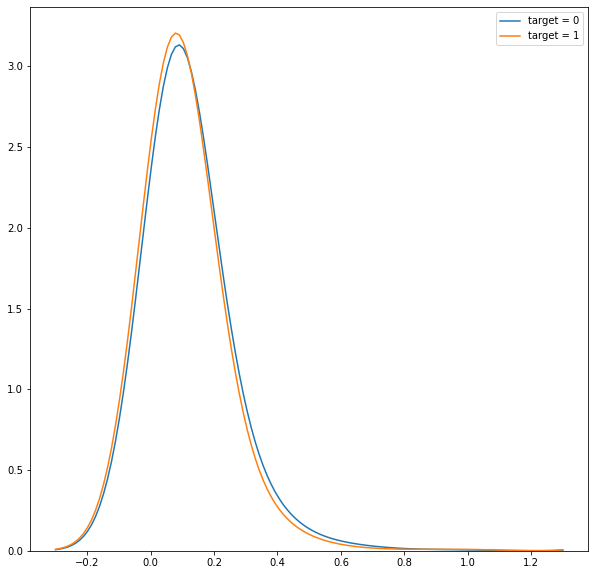

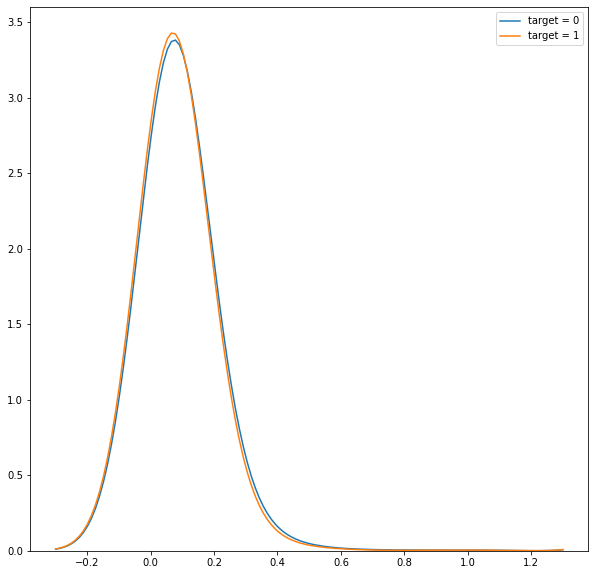

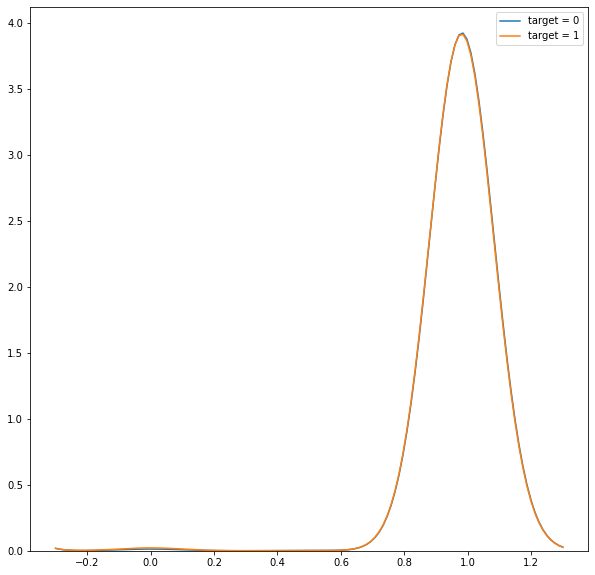

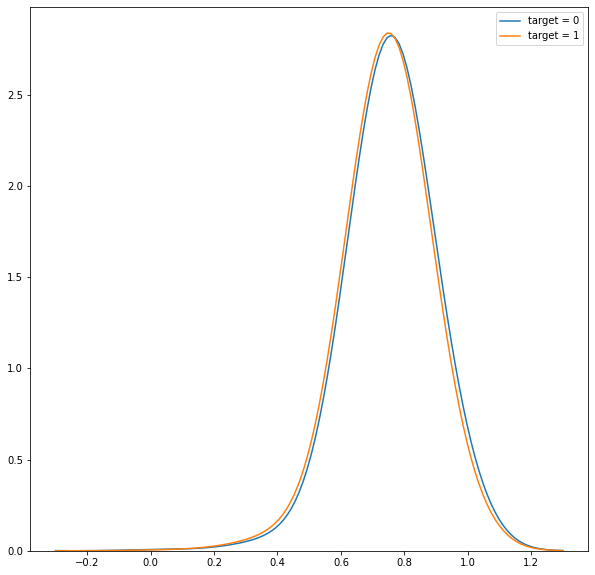

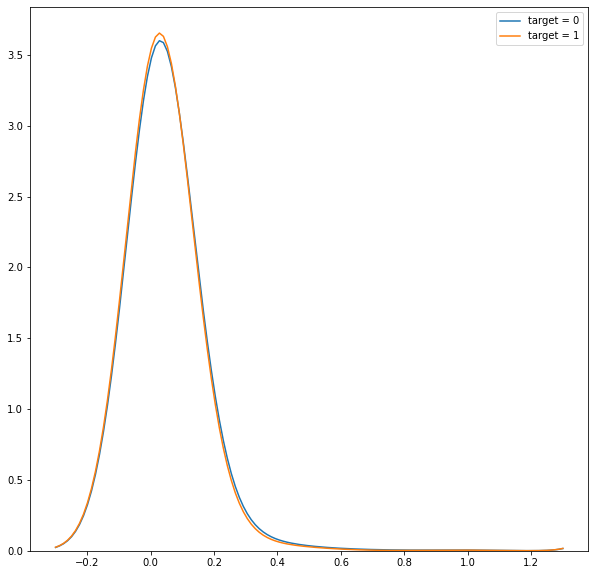

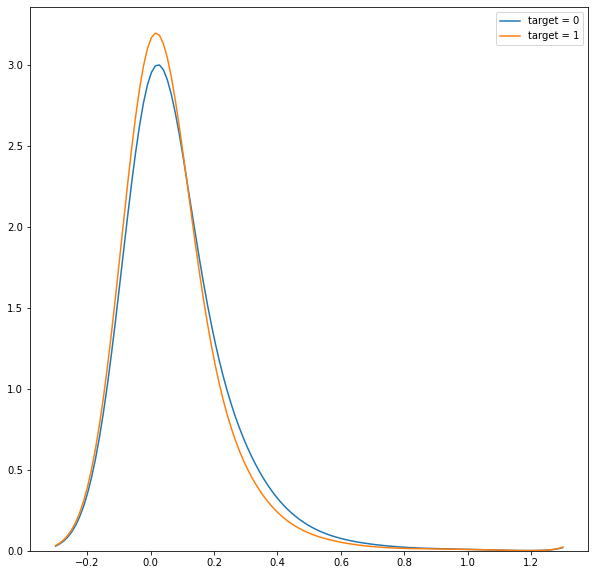

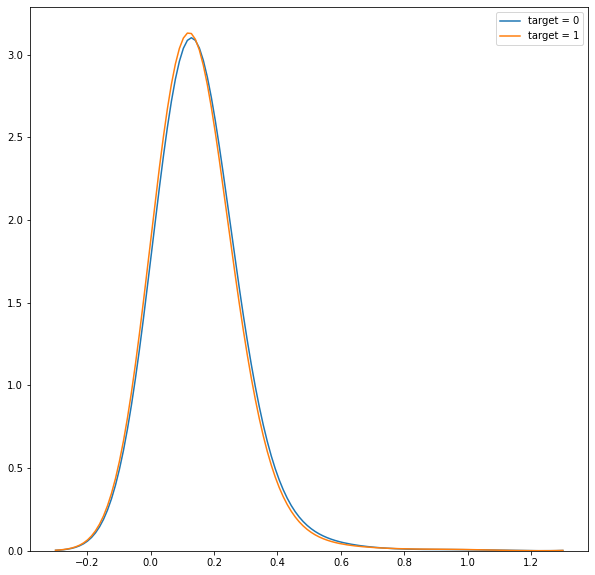

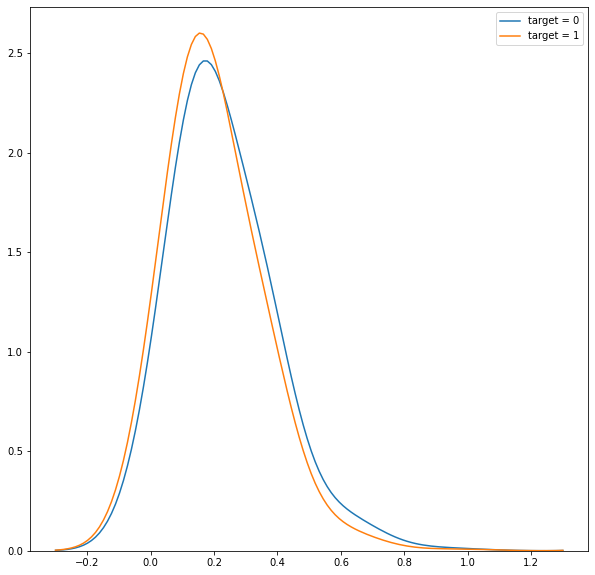

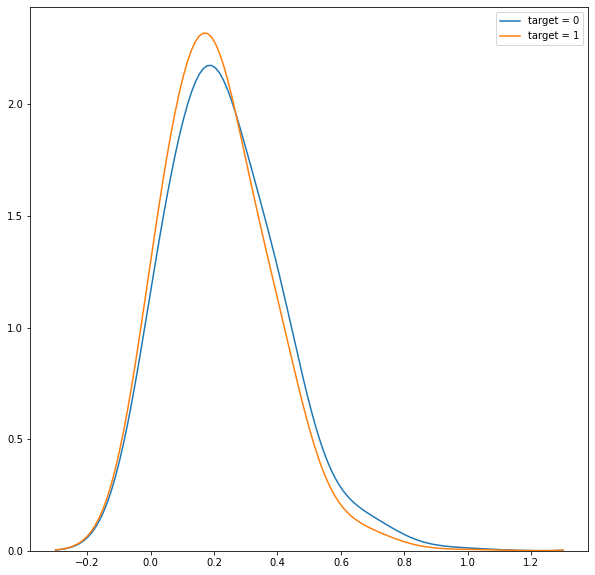

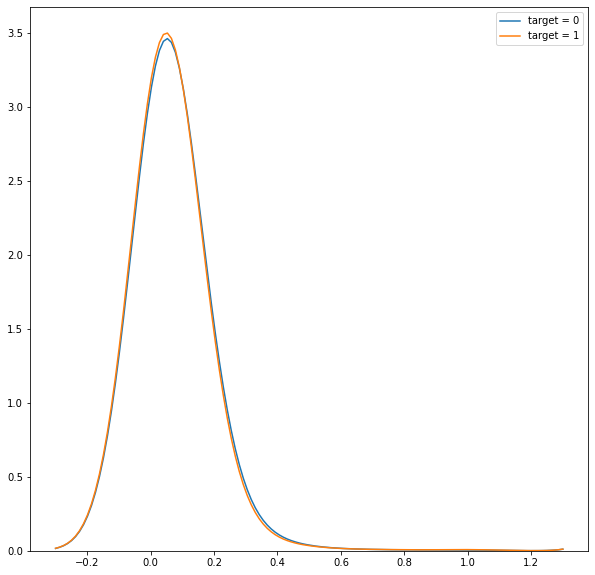

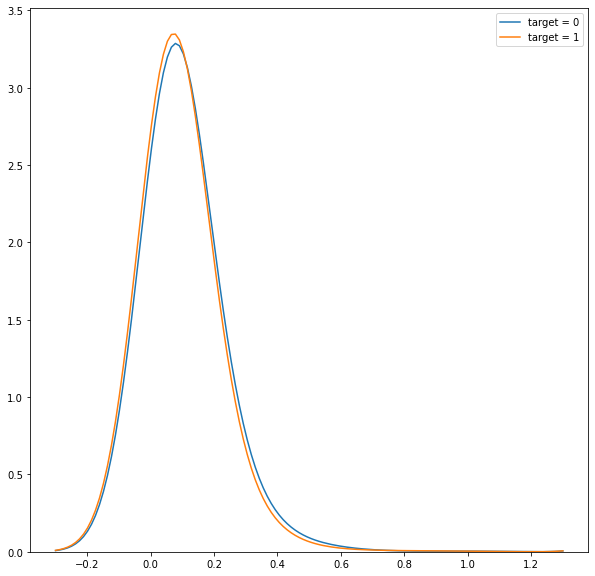

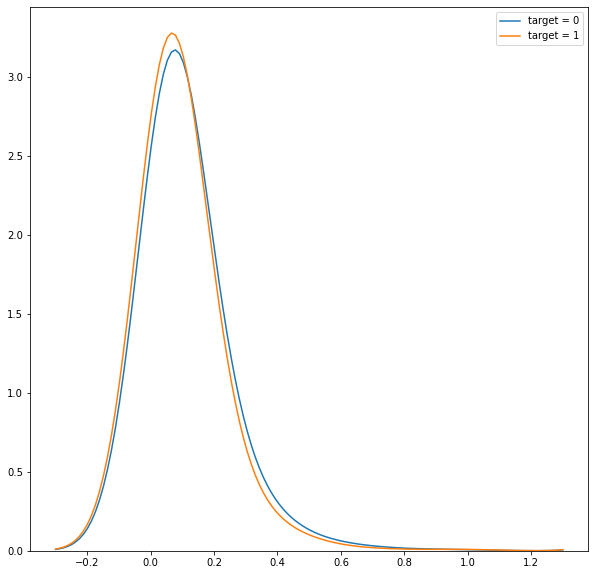

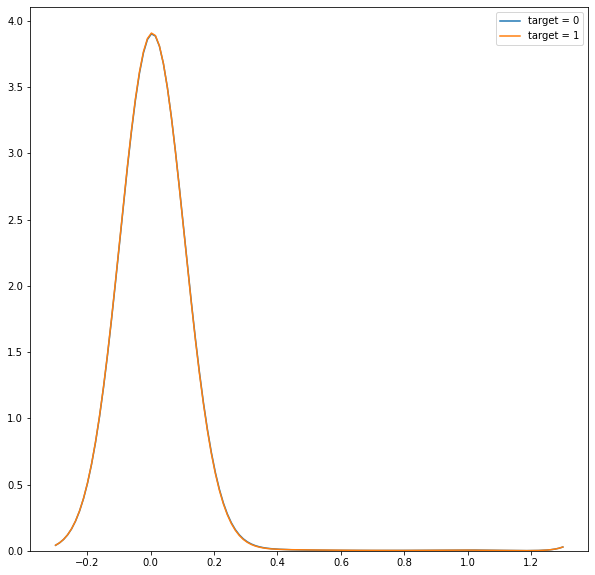

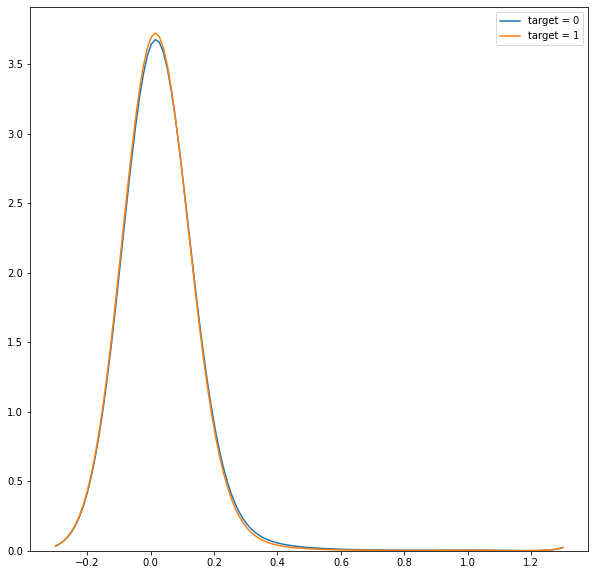

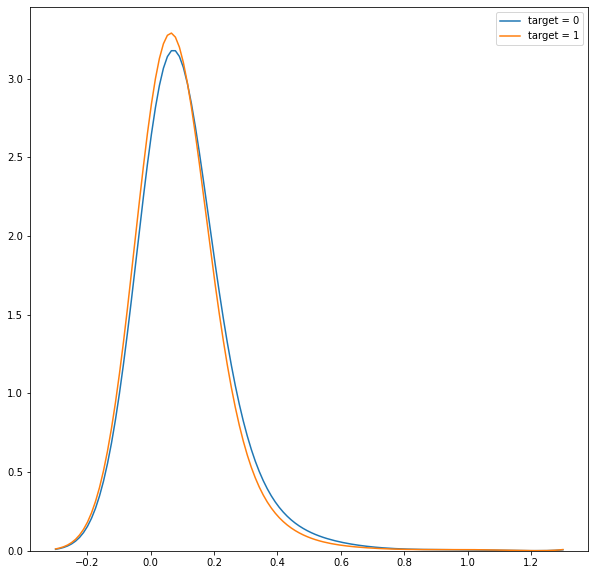

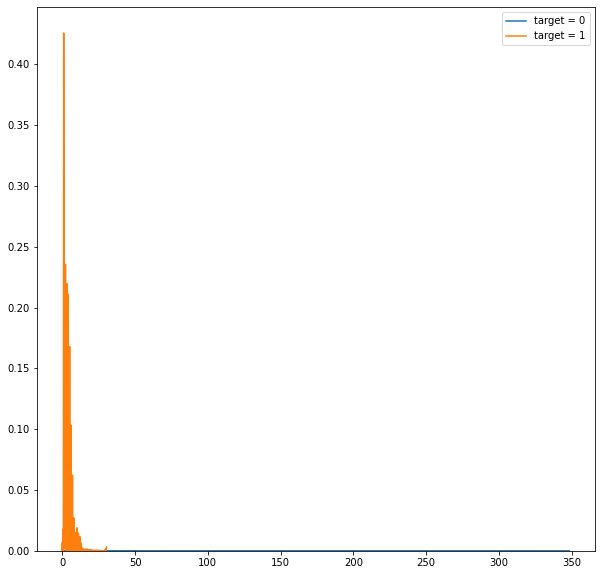

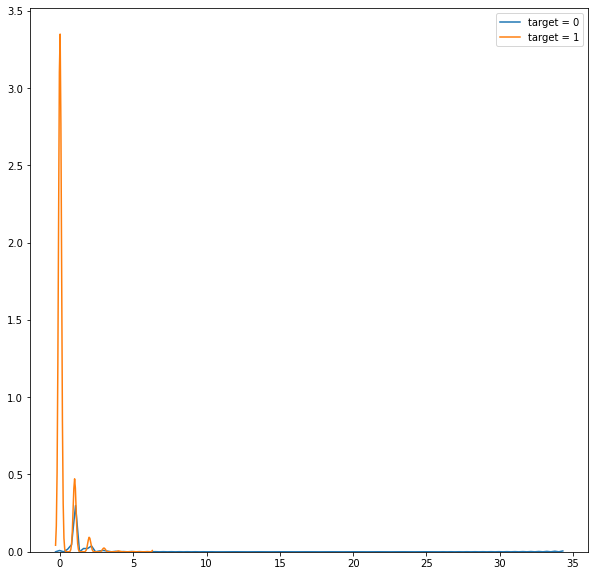

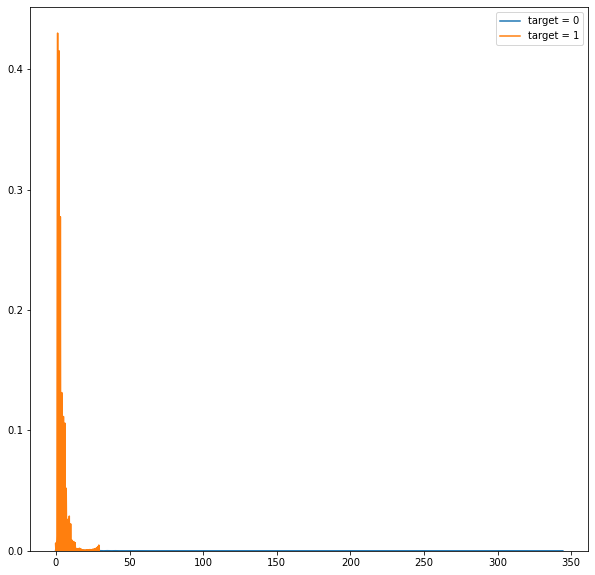

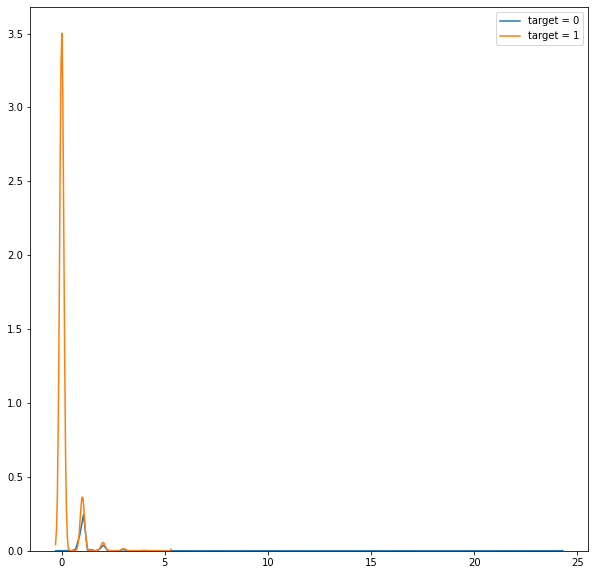

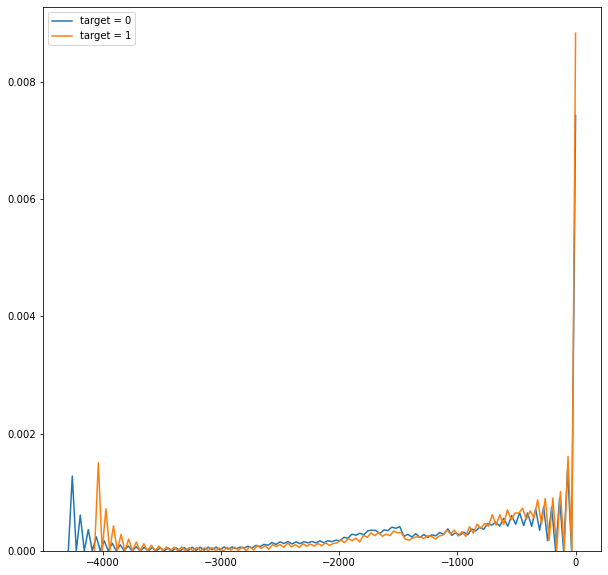

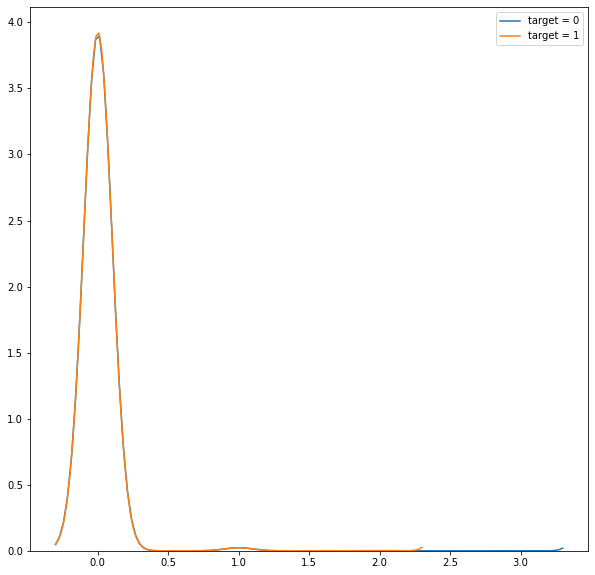

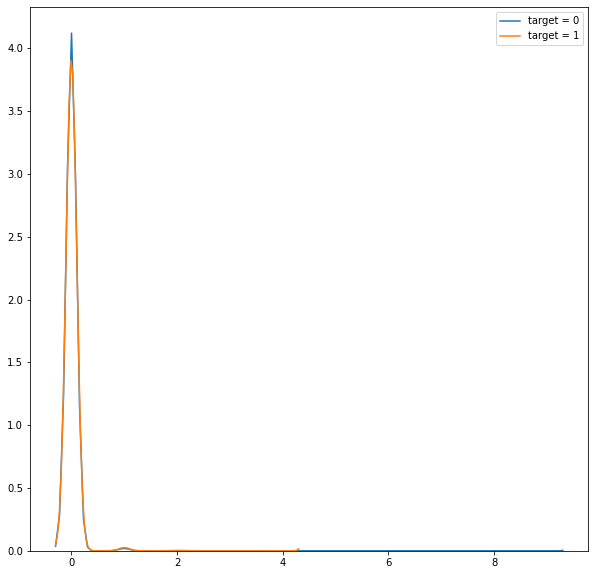

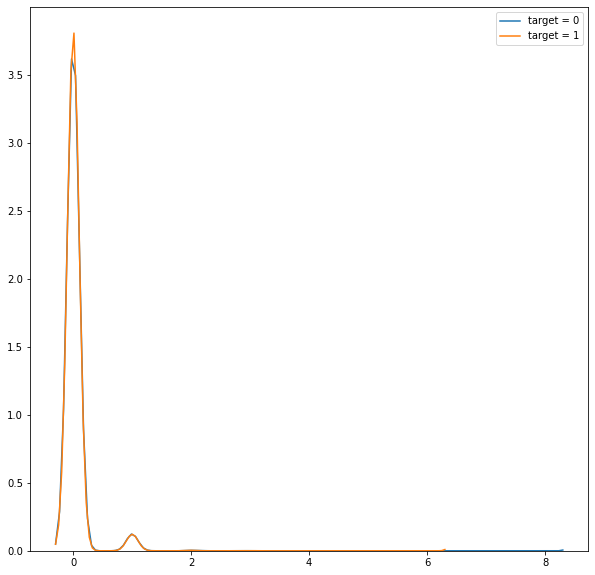

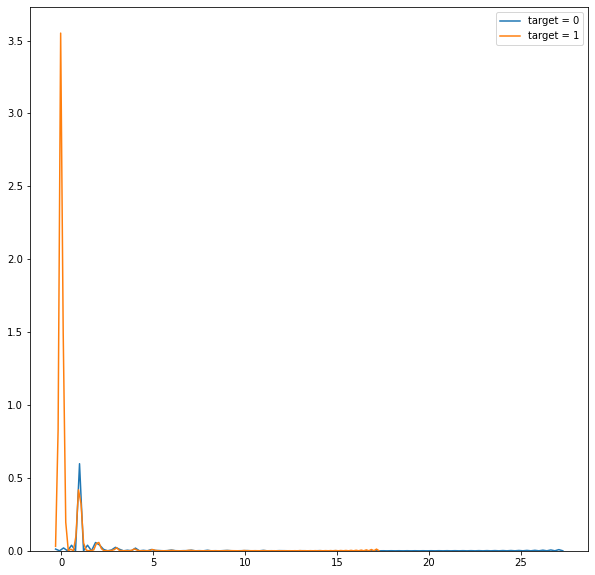

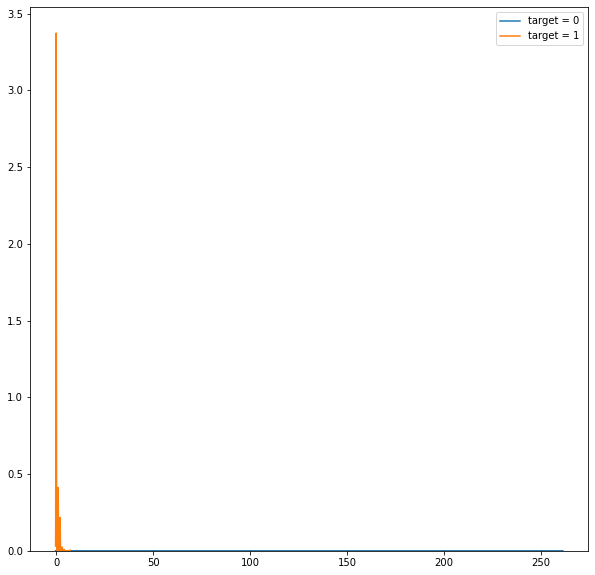

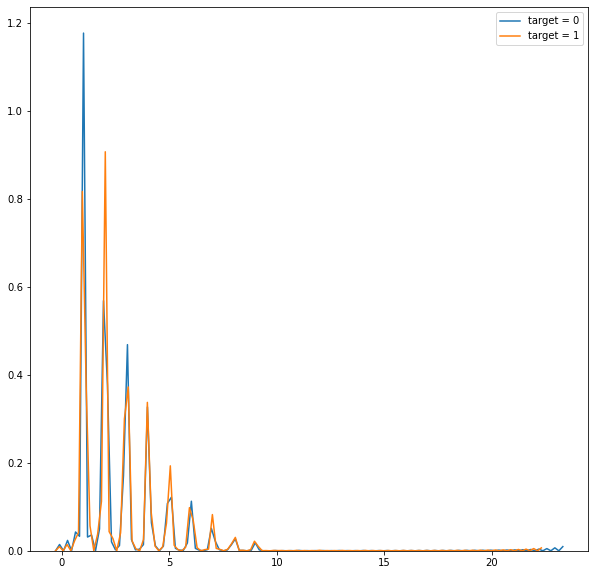

In [103]:
for i in train:
    if (len(train[i].unique())>3 and train[i].dtype != 'object'):
        plt.figure(figsize=(10,10))
        sns.kdeplot(train.loc[train['TARGET'] == 0, i], label = 'target = 0',bw=0.1)
        sns.kdeplot(train.loc[train['TARGET'] == 1, i], label = 'target = 1',bw=0.1)
        plt.legend()
        plt.show()

In [104]:
apptrain.isna().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     26983
AMT_REQ_CREDIT_BUREAU_WEEK    26983
AMT_REQ_CREDIT_BUREAU_MON     26983
AMT_REQ_CREDIT_BUREAU_QRT     26983
AMT_REQ_CREDIT_BUREAU_YEAR    26983
Length: 122, dtype: int64

In [105]:
apptrain_nan = {'AMT_ANNUITY': 0,
 'AMT_GOODS_PRICE': 0,
 'NAME_TYPE_SUITE': 'most',
 'OWN_CAR_AGE': -1,
 'OCCUPATION_TYPE': 'unknown',
 'CNT_FAM_MEMBERS': 1,
 'EXT_SOURCE_1': 'median',
 'EXT_SOURCE_2': 'median',
 'EXT_SOURCE_3': 'median',
 'APARTMENTS_AVG': 'median',
 'BASEMENTAREA_AVG': 'median',
 'YEARS_BEGINEXPLUATATION_AVG': 'median',
 'YEARS_BUILD_AVG': 'median',
 'COMMONAREA_AVG': 'median',
 'ELEVATORS_AVG': 'median',
 'ENTRANCES_AVG': 'median',
 'FLOORSMAX_AVG': 'median',
 'FLOORSMIN_AVG': 'median',
 'LANDAREA_AVG': 'median',
 'LIVINGAPARTMENTS_AVG': 'median',
 'LIVINGAREA_AVG': 'median',
 'NONLIVINGAPARTMENTS_AVG': 'median',
 'NONLIVINGAREA_AVG': 'median',
 'APARTMENTS_MODE': 'median',
 'BASEMENTAREA_MODE': 'median',
 'YEARS_BEGINEXPLUATATION_MODE': 'median',
 'YEARS_BUILD_MODE': 'median',
 'COMMONAREA_MODE': 'median',
 'ELEVATORS_MODE': 'median',
 'ENTRANCES_MODE': 'median',
 'FLOORSMAX_MODE': 'median',
 'FLOORSMIN_MODE': 'median',
 'LANDAREA_MODE': 'median',
 'LIVINGAPARTMENTS_MODE': 'median',
 'LIVINGAREA_MODE': 'median',
 'NONLIVINGAPARTMENTS_MODE': 'median',
 'NONLIVINGAREA_MODE': 'median',
 'APARTMENTS_MEDI': 'median',
 'BASEMENTAREA_MEDI': 'median',
 'YEARS_BEGINEXPLUATATION_MEDI': 'median',
 'YEARS_BUILD_MEDI': 'median',
 'COMMONAREA_MEDI': 'median',
 'ELEVATORS_MEDI': 'median',
 'ENTRANCES_MEDI': 'median',
 'FLOORSMAX_MEDI': 'median',
 'FLOORSMIN_MEDI': 'median',
 'LANDAREA_MEDI': 'median',
 'LIVINGAPARTMENTS_MEDI': 'median',
 'LIVINGAREA_MEDI': 'median',
 'NONLIVINGAPARTMENTS_MEDI': 'median',
 'NONLIVINGAREA_MEDI': 'median',
 'FONDKAPREMONT_MODE': 'not specified',
 'HOUSETYPE_MODE': 'unknown',
 'TOTALAREA_MODE': 'median',
 'WALLSMATERIAL_MODE': 'unknown',
 'EMERGENCYSTATE_MODE': 'No',
 'OBS_30_CNT_SOCIAL_CIRCLE': 0,
 'DEF_30_CNT_SOCIAL_CIRCLE': 0,
 'OBS_60_CNT_SOCIAL_CIRCLE': 0,
 'DEF_60_CNT_SOCIAL_CIRCLE':0,
 'AMT_REQ_CREDIT_BUREAU_HOUR': 0,
 'AMT_REQ_CREDIT_BUREAU_DAY': 0,
 'AMT_REQ_CREDIT_BUREAU_WEEK': 0,
 'AMT_REQ_CREDIT_BUREAU_MON': 0,
 'AMT_REQ_CREDIT_BUREAU_QRT': 0,
 'AMT_REQ_CREDIT_BUREAU_YEAR': 0}

In [106]:
RemoveNaN(apptrain,apptrain_nan)

==========List of Columns which has Nan entries in it===========
['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVIN

HOUSETYPE_MODE 100429 50.24414404498654
[nan 'block of flats' 'specific housing' 'terraced house']

TOTALAREA_MODE 96610 48.33351677489719
TOTALAREA_MODE has more than 100 unique values

WALLSMATERIAL_MODE 101759 50.9095366266097
[nan 'Panel' 'Stone, brick' 'Wooden' 'Block' 'Mixed' 'Others' 'Monolithic']

EMERGENCYSTATE_MODE 94844 47.44999549734344
[nan 'No' 'Yes']

OBS_30_CNT_SOCIAL_CIRCLE 681 0.3407010135980228
[  0.   3.   2.   1.   4.   6.   7.   5.  12.   8.  10.   9.  14.  11.
  15.  nan  16.  21.  13.  22.  17.  18.  24.  20.  19.  25.  27.  23.
  28.  26.  47. 348.  30.]

DEF_30_CNT_SOCIAL_CIRCLE 681 0.3407010135980228
[ 0.  1.  2.  8. nan  3.  4.  5.  6.  7. 34.]

OBS_60_CNT_SOCIAL_CIRCLE 681 0.3407010135980228
[  0.   3.   2.   1.   4.   6.   7.   5.  12.   8.  10.   9.  14.  15.
  11.  nan  16.  21.  13.  22.  17.  18.  24.  20.  19.  25.  27.  23.
  28.  47. 344.  29.  26.]

DEF_60_CNT_SOCIAL_CIRCLE 681 0.3407010135980228
[ 0.  1.  2.  6. nan  3.  4.  7.  5. 24.]

AMT_REQ_C

In [107]:
temp_cols = []
for i in apptrain:
    if(i.find('AVG')!=-1 ):
        temp_cols.append(i)

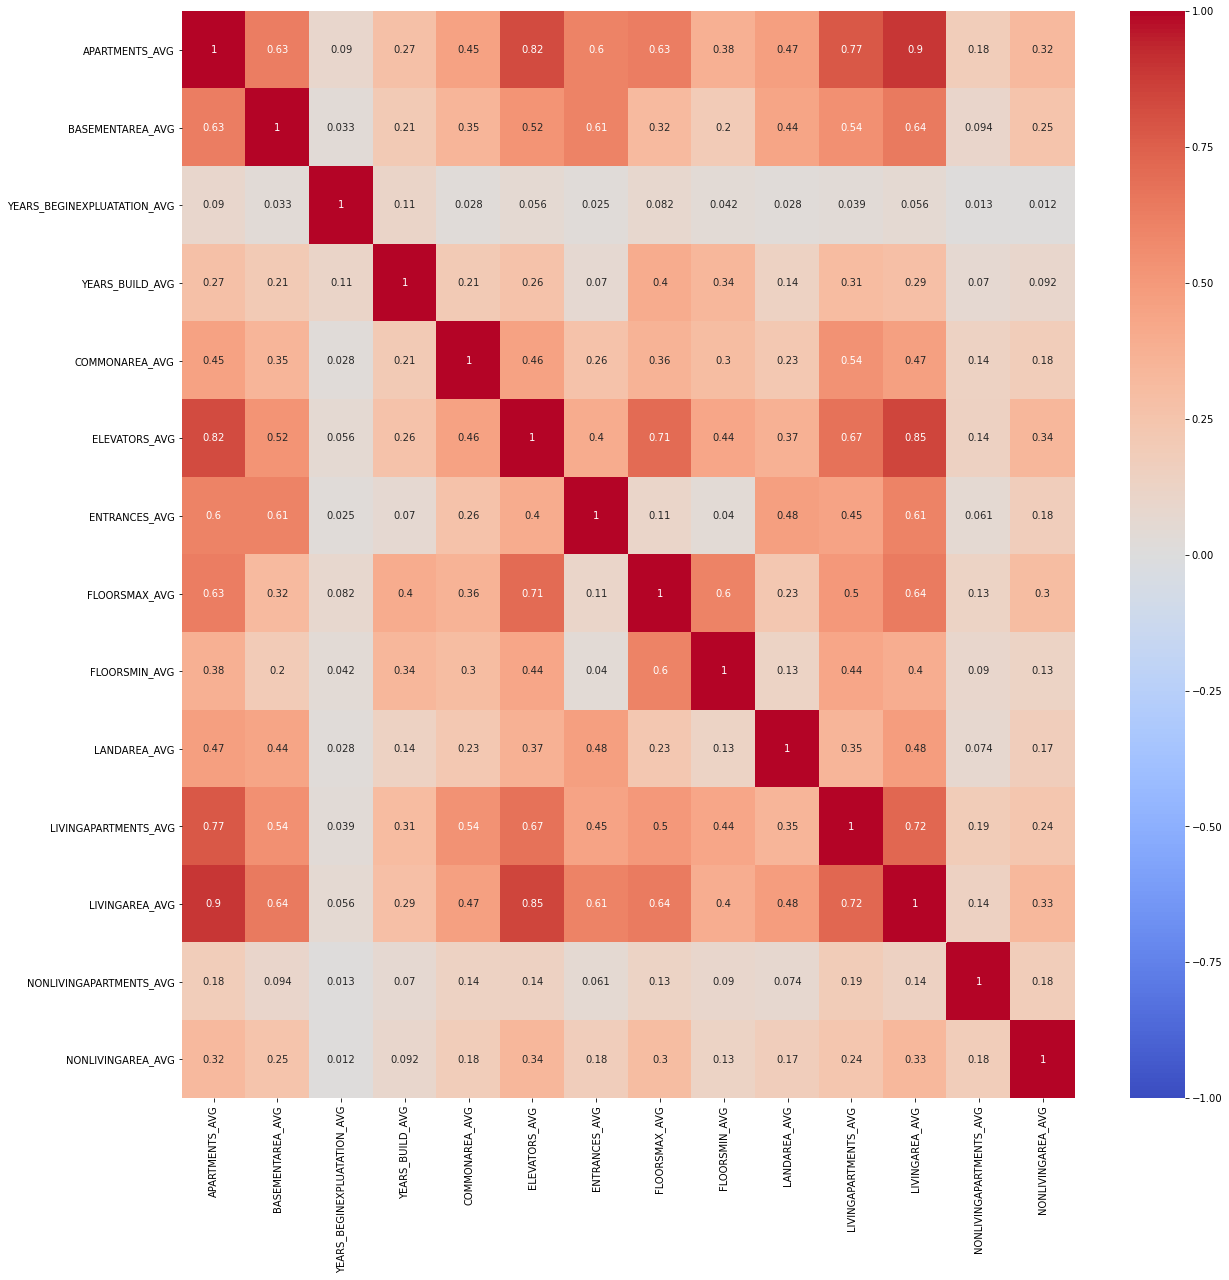

In [108]:
plt.figure(figsize=(20,20))
sns.heatmap(apptrain.loc[:,temp_cols].corr().abs(),vmin=-1,cmap='coolwarm',annot=True)

In [109]:
upper = apptrain.corr().abs().where(np.triu(np.ones(apptrain.corr().shape), k=1).astype(np.bool))
apptrain_drop = [column for column in upper.columns if any(upper[column] >= 0.90)]
apptrain.drop(columns =apptrain_drop,axis=1,inplace = True)

In [110]:
# plt.figure(figsize=(50,50))
# sns.heatmap(apptrain.corr().abs(),vmin=-1,cmap='coolwarm',annot=True)

In [111]:
# plt.figure(figsize=(50,50))
# sns.heatmap(apptrain.corr().abs(),vmin=-1,cmap='coolwarm',annot=True)
apptrain_drop

['AMT_GOODS_PRICE',
 'FLAG_EMP_PHONE',
 'REGION_RATING_CLIENT_W_CITY',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_60_CNT_SOCIAL_CIRCLE']

In [112]:
# nan_data
# apptrain['EMERGENCYSTATE_MODE'].value_counts()

In [113]:
# apptrain.isna().sum()
categor_apptrain = [i for i in apptrain.columns if apptrain[i].dtypes == 'object']
categor_apptrain

['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [114]:
apptrain['WALLSMATERIAL_MODE'].value_counts()

unknown         101759
Panel            42916
Stone, brick     42087
Block             6031
Wooden            3401
Mixed             1496
Monolithic        1146
Others            1046
Name: WALLSMATERIAL_MODE, dtype: int64

In [115]:
# Encoding
labelencoder = LabelEncoder()
Label_apptrain = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
         'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE','EMERGENCYSTATE_MODE','NAME_TYPE_SUITE','WEEKDAY_APPR_PROCESS_START','FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE']
for i in Label_apptrain:
    apptrain[i] = labelencoder.fit_transform(apptrain[i])

In [116]:
# Ambigous_apptrain = ['FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE']

In [117]:
# Onehot_apptrain = ['NAME_TYPE_SUITE','WEEKDAY_APPR_PROCESS_START','FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE']
# apptrain = pd.get_dummies(apptrain,columns=Onehot_apptrain,drop_first=True)

## Merging apptrain and prev_app

In [118]:
# apptrain.info()
apptrain_merge = {'SK_ID_PREV': ['ignore', 0.0],
 'AMT_ANNUITY': ['mean', 0.0],
 'AMT_APPLICATION': ['mean', 0.0],
 'AMT_DOWN_PAYMENT': ['mean', 0.0],
 'HOUR_APPR_PROCESS_START': ['ignore', 0.0],
 'FLAG_LAST_APPL_PER_CONTRACT': ['sum', 0.0],
 'NFLAG_LAST_APPL_IN_DAY': ['sum', 0.0],
 'RATE_DOWN_PAYMENT': ['mean', 0.0],
 'NAME_CASH_LOAN_PURPOSE': ['mode', 0.0],
 'NAME_CONTRACT_STATUS': ['mode', 0.0],
 'DAYS_DECISION': ['min', 0.0],
 'CODE_REJECT_REASON': ['mode', 0.0],
 'NAME_CLIENT_TYPE': ['sum', 0.0],
 'NAME_GOODS_CATEGORY': ['sum', 0.0],
 'NAME_PORTFOLIO': ['sum', 0.0],
 'CHANNEL_TYPE': ['mode', 0.0],
 'SELLERPLACE_AREA': ['mode', 0.0],
 'NAME_SELLER_INDUSTRY': ['mode', 0.0],
 'CNT_PAYMENT': ['sum', 0.0],
 'PRODUCT_COMBINATION': ['mode', 0.0],
 'DAYS_FIRST_DRAWING': ['min', 0.0],
 'DAYS_FIRST_DUE': ['min', 0.0],
 'DAYS_LAST_DUE_1ST_VERSION': ['min', 0.0],
 'DAYS_LAST_DUE': ['min', 0.0],
 'NFLAG_INSURED_ON_APPROVAL': ['sum', 0.0],
 'WEEKDAY_APPR_PROCESS_START_MONDAY': ['sum', 0.0],
 'WEEKDAY_APPR_PROCESS_START_SATURDAY': ['sum', 0.0],
 'WEEKDAY_APPR_PROCESS_START_SUNDAY': ['sum', 0.0],
 'WEEKDAY_APPR_PROCESS_START_THURSDAY': ['sum', 0.0],
 'WEEKDAY_APPR_PROCESS_START_TUESDAY': ['sum', 0.0],
 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY': ['sum', 0.0],
 'NAME_PAYMENT_TYPE_Cashless from the account of the employer': ['sum', 0.0],
 'NAME_PAYMENT_TYPE_Non-cash from your account': ['sum', 0.0],
 'NAME_PAYMENT_TYPE_XNA': ['sum', 0.0],
 'NAME_TYPE_SUITE_Family': ['sum', 0.0],
 'NAME_TYPE_SUITE_Group of people': ['sum', 0.0],
 'NAME_TYPE_SUITE_Other_A': ['sum', 0.0],
 'NAME_TYPE_SUITE_Other_B': ['sum', 0.0],
 'NAME_TYPE_SUITE_Spouse, partner': ['sum', 0.0],
 'NAME_TYPE_SUITE_Unaccompanied': ['sum', 0.0],
 'NAME_CONTRACT_TYPE_Consumer loans': ['sum', 0.0],
 'NAME_CONTRACT_TYPE_Revolving loans': ['sum', 0.0],
 'NAME_CONTRACT_TYPE_XNA': ['sum', 0.0],
 'NAME_PRODUCT_TYPE_walk-in': ['sum', 0.0],
 'NAME_PRODUCT_TYPE_x-sell': ['sum', 0.0],
 'NAME_YIELD_GROUP_high': ['sum', 0.0],
 'NAME_YIELD_GROUP_low_action': ['sum', 0.0],
 'NAME_YIELD_GROUP_low_normal': ['sum', 0.0],
 'NAME_YIELD_GROUP_middle': ['sum', 0.0],
 'MONTHS_BALANCE_1': ['max', 0.0],
 'CNT_INSTALMENT': ['sum', 0.0],
 'SK_DPD_1': ['sum', 0.0],
 'SK_DPD_DEF_1': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Amortized debt': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Approved_1': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Canceled': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Completed_1': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Demand_1': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Returned to the store': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Signed_1': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_XNA': ['sum', 0.0],
 'NUM_INSTALMENT_VERSION': ['mode', 0.0],
 'NUM_INSTALMENT_NUMBER': ['max', 0.0],
 'penalty_days': ['sum', 0.0],
 'penalty_amount': ['sum', 0.0],
 'MONTHS_BALANCE_2': ['max', 0.0],
 'AMT_BALANCE': ['mean', 0.0],
 'AMT_CREDIT_LIMIT_ACTUAL': ['mean', 0.0],
 'AMT_DRAWINGS_ATM_CURRENT': ['mean', 0.0],
 'AMT_DRAWINGS_CURRENT': ['mean', 0.0],
 'AMT_DRAWINGS_OTHER_CURRENT': ['mean', 0.0],
 'AMT_DRAWINGS_POS_CURRENT': ['mean', 0.0],
 'AMT_INST_MIN_REGULARITY': ['mean', 0.0],
 'AMT_PAYMENT_CURRENT': ['mean', 0.0],
 'CNT_DRAWINGS_ATM_CURRENT': ['sum', 0.0],
 'CNT_DRAWINGS_CURRENT': ['sum', 0.0],
 'CNT_DRAWINGS_OTHER_CURRENT': ['sum', 0.0],
 'CNT_INSTALMENT_MATURE_CUM': ['sum', 0.0],
 'SK_DPD_2': ['sum', 0.0],
 'SK_DPD_DEF_2': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Approved_2': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Completed_2': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Demand_2': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Refused': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Sent proposal': ['sum', 0.0],
 'NAME_CONTRACT_STATUS_Signed_2': ['sum', 0.0]}
apptrain = merge(prev_app,apptrain,'SK_ID_CURR',apptrain_merge)

SK_ID_PREV
SK_ID_CURR
AMT_ANNUITY
AMT_APPLICATION
AMT_DOWN_PAYMENT
HOUR_APPR_PROCESS_START
FLAG_LAST_APPL_PER_CONTRACT
NFLAG_LAST_APPL_IN_DAY
RATE_DOWN_PAYMENT
NAME_CASH_LOAN_PURPOSE
NAME_CONTRACT_STATUS
DAYS_DECISION
CODE_REJECT_REASON
NAME_CLIENT_TYPE
NAME_GOODS_CATEGORY
NAME_PORTFOLIO
CHANNEL_TYPE
SELLERPLACE_AREA
NAME_SELLER_INDUSTRY
CNT_PAYMENT
PRODUCT_COMBINATION
DAYS_FIRST_DRAWING
DAYS_FIRST_DUE
DAYS_LAST_DUE_1ST_VERSION
DAYS_LAST_DUE
NFLAG_INSURED_ON_APPROVAL
WEEKDAY_APPR_PROCESS_START_MONDAY
WEEKDAY_APPR_PROCESS_START_SATURDAY
WEEKDAY_APPR_PROCESS_START_SUNDAY
WEEKDAY_APPR_PROCESS_START_THURSDAY
WEEKDAY_APPR_PROCESS_START_TUESDAY
WEEKDAY_APPR_PROCESS_START_WEDNESDAY
NAME_PAYMENT_TYPE_Cashless from the account of the employer
NAME_PAYMENT_TYPE_Non-cash from your account
NAME_PAYMENT_TYPE_XNA
NAME_TYPE_SUITE_Family
NAME_TYPE_SUITE_Group of people
NAME_TYPE_SUITE_Other_A
NAME_TYPE_SUITE_Other_B
NAME_TYPE_SUITE_Spouse, partner
NAME_TYPE_SUITE_Unaccompanied
NAME_CONTRACT_TYPE_Consu

In [119]:
# apptrain_merge
# del prev_app
# gc.collect()

## Merging apptrain and bureau

In [120]:
bat = {'SK_ID_BUREAU': ['ignore', 0.0],
 'DAYS_CREDIT': ['min', 0.0],
 'CREDIT_DAY_OVERDUE': ['min', 0.0],
 'DAYS_CREDIT_ENDDATE': ['min', 0.0],
 'DAYS_ENDDATE_FACT': ['sum', 0.0],
 'AMT_CREDIT_MAX_OVERDUE': ['max', 0.0],
 'CNT_CREDIT_PROLONG': ['sum', 0.0],
 'AMT_CREDIT_SUM': ['mean', 0.0],
 'AMT_CREDIT_SUM_DEBT': ['mean', 0.0],
 'AMT_CREDIT_SUM_LIMIT': ['mean', 0.0],
 'AMT_CREDIT_SUM_OVERDUE': ['mean', 0.0],
 'CREDIT_TYPE': ['mode', 0.0],
 'DAYS_CREDIT_UPDATE': ['min', 0.0],
 'AMT_ANNUITY': ['mean', 0.0],
 'CREDIT_ACTIVE_Bad debt': ['sum', 0.0],
 'CREDIT_ACTIVE_Closed': ['sum', 0.0],
 'CREDIT_ACTIVE_Sold': ['sum', 0.0],
 'CREDIT_CURRENCY_currency 2': ['sum', 0.0],
 'CREDIT_CURRENCY_currency 3': ['sum', 0.0],
 'CREDIT_CURRENCY_currency 4': ['sum', 0.0],
 'MONTHS_BALANCE': ['min', 0.0],
 'STATUS_1': ['sum', 0.0],
 'STATUS_2': ['sum', 0.0],
 'STATUS_3': ['sum', 0.0],
 'STATUS_4': ['sum', 0.0],
 'STATUS_5': ['sum', 0.0],
 'STATUS_C': ['sum', 0.0],
 'STATUS_X': ['sum', 0.0]}
apptrain = merge(bureau,apptrain,'SK_ID_CURR',bat)

SK_ID_CURR
SK_ID_BUREAU
DAYS_CREDIT
CREDIT_DAY_OVERDUE
DAYS_CREDIT_ENDDATE
DAYS_ENDDATE_FACT
AMT_CREDIT_MAX_OVERDUE
CNT_CREDIT_PROLONG
AMT_CREDIT_SUM
AMT_CREDIT_SUM_DEBT
AMT_CREDIT_SUM_LIMIT
AMT_CREDIT_SUM_OVERDUE
CREDIT_TYPE
DAYS_CREDIT_UPDATE
AMT_ANNUITY
CREDIT_ACTIVE_Bad debt
CREDIT_ACTIVE_Closed
CREDIT_ACTIVE_Sold
CREDIT_CURRENCY_currency 2
CREDIT_CURRENCY_currency 3
CREDIT_CURRENCY_currency 4
MONTHS_BALANCE
STATUS_1
STATUS_2
STATUS_3
STATUS_4
STATUS_5
STATUS_C
STATUS_X


In [121]:
apptrain.shape

(199882, 200)

In [122]:
apptrain.to_csv("trainapp.csv",index=False)

# Application test nan values

In [123]:
apptest = pd.read_csv('/kaggle/input/iiitb2020-home-credit-default-risk/application_test.csv')

In [124]:
apptest.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0     7auxod         Cash loans           F            N               Y   
1     xur7ur         Cash loans           F            N               Y   
2     eau6rx         Cash loans           F            N               N   
3     obdr67    Revolving loans           F            N               N   
4     7xbu7d         Cash loans           F            N               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          225000.0    728460.0      44694.0         675000.0   
1             0          171000.0    630000.0      22756.5         630000.0   
2             0          117000.0    724981.5      27742.5         648000.0   
3             2          135000.0    180000.0       9000.0         180000.0   
4             0          225000.0    248760.0      29650.5         225000.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                1                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        1.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         3.0  
1                        2.0                         6.0  
2                        0.0                         0.0  
3                        0.0                         1.0  
4                        0.0                         0.0  

[5 rows x 121 columns]

In [125]:
apptest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107629 entries, 0 to 107628
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(39), object(17)
memory usage: 99.4+ MB


In [126]:
apptest_nan={'AMT_ANNUITY': [0, 0], 'AMT_GOODS_PRICE': [0, 0], 'NAME_TYPE_SUITE': ['Unaccompanied', 'Unaccompanied'],
             'OWN_CAR_AGE': [-1, -1], 'OCCUPATION_TYPE': ['unknown', 'unknown'], 'CNT_FAM_MEMBERS': [1, 1],
             'EXT_SOURCE_1': ['median', 0.5066961392817232], 'EXT_SOURCE_2': ['median', 0.5660097711985461],
             'EXT_SOURCE_3': ['median', 0.5352762504724826], 'APARTMENTS_AVG': ['median', 0.0876],
             'BASEMENTAREA_AVG': ['median', 0.0764], 'YEARS_BEGINEXPLUATATION_AVG': ['median', 0.9816],
             'YEARS_BUILD_AVG': ['median', 0.7552], 'COMMONAREA_AVG': ['median', 0.0211],
             'ELEVATORS_AVG': ['median', 0.0],'ENTRANCES_AVG': ['median', 0.1379], 'FLOORSMAX_AVG': ['median', 0.1667],
             'FLOORSMIN_AVG': ['median', 0.2083], 'LANDAREA_AVG': ['median', 0.0482],
             'LIVINGAPARTMENTS_AVG': ['median', 0.0756], 'LIVINGAREA_AVG': ['median', 0.0746],
             'NONLIVINGAPARTMENTS_AVG': ['median', 0.0], 'NONLIVINGAREA_AVG': ['median', 0.0036],
             'APARTMENTS_MODE': ['median', 0.084], 'BASEMENTAREA_MODE': ['median', 0.0748],
             'YEARS_BEGINEXPLUATATION_MODE': ['median', 0.9816], 'YEARS_BUILD_MODE': ['median', 0.7648],
             'COMMONAREA_MODE': ['median', 0.0191], 'ELEVATORS_MODE': ['median', 0.0],
             'ENTRANCES_MODE': ['median', 0.1379], 'FLOORSMAX_MODE': ['median', 0.1667],
             'FLOORSMIN_MODE': ['median', 0.2083], 'LANDAREA_MODE': ['median', 0.0459],
             'LIVINGAPARTMENTS_MODE': ['median', 0.0771], 'LIVINGAREA_MODE': ['median', 0.0731],
             'NONLIVINGAPARTMENTS_MODE': ['median', 0.0], 'NONLIVINGAREA_MODE': ['median', 0.0011],
             'APARTMENTS_MEDI': ['median', 0.0874], 'BASEMENTAREA_MEDI': ['median', 0.076],
             'YEARS_BEGINEXPLUATATION_MEDI': ['median', 0.9816], 'YEARS_BUILD_MEDI': ['median', 0.7585],
             'COMMONAREA_MEDI': ['median', 0.0209], 'ELEVATORS_MEDI': ['median', 0.0],
             'ENTRANCES_MEDI': ['median', 0.1379], 'FLOORSMAX_MEDI': ['median', 0.1667],
             'FLOORSMIN_MEDI': ['median', 0.2083], 'LANDAREA_MEDI': ['median', 0.0487],
             'LIVINGAPARTMENTS_MEDI': ['median', 0.0765], 'LIVINGAREA_MEDI': ['median', 0.0749],
             'NONLIVINGAPARTMENTS_MEDI': ['median', 0.0], 'NONLIVINGAREA_MEDI': ['median', 0.0031],
             'FONDKAPREMONT_MODE': ['not specified', 'not specified'], 'HOUSETYPE_MODE': ['unknown', 'unknown'],
             'TOTALAREA_MODE': ['median', 0.0688], 'WALLSMATERIAL_MODE': ['unknown', 'unknown'],
             'EMERGENCYSTATE_MODE': ['No', 'No'], 'OBS_30_CNT_SOCIAL_CIRCLE': [0,0], 'DEF_30_CNT_SOCIAL_CIRCLE': [0,0],
             'OBS_60_CNT_SOCIAL_CIRCLE': [0,0], 'DEF_60_CNT_SOCIAL_CIRCLE': [0,0],'DAYS_LAST_PHONE_CHANGE':[0,0],
             'AMT_REQ_CREDIT_BUREAU_HOUR': [0,0], 'AMT_REQ_CREDIT_BUREAU_DAY': [0,0], 'AMT_REQ_CREDIT_BUREAU_WEEK': [0,0],
             'AMT_REQ_CREDIT_BUREAU_MON': [0,0], 'AMT_REQ_CREDIT_BUREAU_QRT': [0,0], 'AMT_REQ_CREDIT_BUREAU_YEAR': [0,0]}

In [127]:
RemoveNaN(apptest,apptest_nan)

==========List of Columns which has Nan entries in it===========
['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVIN

[nan 'reg oper account' 'reg oper spec account' 'not specified'
 'org spec account']

HOUSETYPE_MODE 53868 50.04970779250946
[nan 'block of flats' 'terraced house' 'specific housing']

TOTALAREA_MODE 51821 48.14780403051222
TOTALAREA_MODE has more than 100 unique values

WALLSMATERIAL_MODE 54582 50.71309777104683
[nan 'Block' 'Panel' 'Stone, brick' 'Others' 'Mixed' 'Monolithic' 'Wooden']

EMERGENCYSTATE_MODE 50911 47.30230699904301
[nan 'No' 'Yes']

OBS_30_CNT_SOCIAL_CIRCLE 340 0.3158999897797062
[ 0.  6.  4.  2.  7.  8. 12.  1.  5.  9.  3. 10. 22. 11. nan 16. 13. 14.
 21. 15. 23. 25. 19. 24. 20. 17. 18. 27. 26. 30. 29.]

DEF_30_CNT_SOCIAL_CIRCLE 340 0.3158999897797062
[ 0.  3.  1.  2. nan  4.  5.  6.]

OBS_60_CNT_SOCIAL_CIRCLE 340 0.3158999897797062
[ 0.  6.  4.  2.  7.  8. 12.  1.  5.  9.  3. 10. 22. 11. nan 16. 13. 14.
 21. 15. 23. 24. 18. 19. 20. 17. 25. 27. 30. 29.]

DEF_60_CNT_SOCIAL_CIRCLE 340 0.3158999897797062
[ 0.  3.  1.  2. nan  4.  5.]

DAYS_LAST_PHONE_CHANGE 1 0.000929117

In [128]:
# drop code
upper = apptest.corr().abs().where(np.triu(np.ones(apptest.corr().shape), k=1).astype(np.bool))
apptest_drop = [column for column in upper.columns if any(upper[column] >= 0.90)]
apptest.drop(columns =apptest_drop,axis=1,inplace = True)

In [129]:
# encode
categor_apptest = [i for i in apptest.columns if apptest[i].dtypes == 'object']
categor_apptest

['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [130]:
labelencoder = LabelEncoder()
Label_apptest = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_INCOME_TYPE',
                 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE',
                 'EMERGENCYSTATE_MODE','NAME_TYPE_SUITE','WEEKDAY_APPR_PROCESS_START','FONDKAPREMONT_MODE',
                 'HOUSETYPE_MODE','WALLSMATERIAL_MODE']
for i in Label_apptest:
    apptest[i] = labelencoder.fit_transform(apptest[i])

In [131]:
# Ambigous_apptest = []

In [132]:
# Onehot_test = ['NAME_TYPE_SUITE','WEEKDAY_APPR_PROCESS_START','FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE']
# apptest = pd.get_dummies(apptest,columns=Onehot_test,drop_first=True)

## Merging apptest and prev_app

In [133]:
apptest = merge(prev_app,apptest,'SK_ID_CURR',apptrain_merge)

SK_ID_PREV
SK_ID_CURR
AMT_ANNUITY
AMT_APPLICATION
AMT_DOWN_PAYMENT
HOUR_APPR_PROCESS_START
FLAG_LAST_APPL_PER_CONTRACT
NFLAG_LAST_APPL_IN_DAY
RATE_DOWN_PAYMENT
NAME_CASH_LOAN_PURPOSE
NAME_CONTRACT_STATUS
DAYS_DECISION
CODE_REJECT_REASON
NAME_CLIENT_TYPE
NAME_GOODS_CATEGORY
NAME_PORTFOLIO
CHANNEL_TYPE
SELLERPLACE_AREA
NAME_SELLER_INDUSTRY
CNT_PAYMENT
PRODUCT_COMBINATION
DAYS_FIRST_DRAWING
DAYS_FIRST_DUE
DAYS_LAST_DUE_1ST_VERSION
DAYS_LAST_DUE
NFLAG_INSURED_ON_APPROVAL
WEEKDAY_APPR_PROCESS_START_MONDAY
WEEKDAY_APPR_PROCESS_START_SATURDAY
WEEKDAY_APPR_PROCESS_START_SUNDAY
WEEKDAY_APPR_PROCESS_START_THURSDAY
WEEKDAY_APPR_PROCESS_START_TUESDAY
WEEKDAY_APPR_PROCESS_START_WEDNESDAY
NAME_PAYMENT_TYPE_Cashless from the account of the employer
NAME_PAYMENT_TYPE_Non-cash from your account
NAME_PAYMENT_TYPE_XNA
NAME_TYPE_SUITE_Family
NAME_TYPE_SUITE_Group of people
NAME_TYPE_SUITE_Other_A
NAME_TYPE_SUITE_Other_B
NAME_TYPE_SUITE_Spouse, partner
NAME_TYPE_SUITE_Unaccompanied
NAME_CONTRACT_TYPE_Consu

## Merging apptest and bureau

In [134]:
apptest = merge(bureau,apptest,'SK_ID_CURR',bat)

SK_ID_CURR
SK_ID_BUREAU
DAYS_CREDIT
CREDIT_DAY_OVERDUE
DAYS_CREDIT_ENDDATE
DAYS_ENDDATE_FACT
AMT_CREDIT_MAX_OVERDUE
CNT_CREDIT_PROLONG
AMT_CREDIT_SUM
AMT_CREDIT_SUM_DEBT
AMT_CREDIT_SUM_LIMIT
AMT_CREDIT_SUM_OVERDUE
CREDIT_TYPE
DAYS_CREDIT_UPDATE
AMT_ANNUITY
CREDIT_ACTIVE_Bad debt
CREDIT_ACTIVE_Closed
CREDIT_ACTIVE_Sold
CREDIT_CURRENCY_currency 2
CREDIT_CURRENCY_currency 3
CREDIT_CURRENCY_currency 4
MONTHS_BALANCE
STATUS_1
STATUS_2
STATUS_3
STATUS_4
STATUS_5
STATUS_C
STATUS_X


In [135]:
del prev_app
del bureau
gc.collect()

20

In [136]:
apptest.to_csv("testapp.csv",index=False)

# Final Data Cleaning

In [137]:
X = apptrain.drop(columns=['SK_ID_CURR'])
Y = apptest.drop(columns=['SK_ID_CURR'])
y=X['TARGET']
X=X.drop(columns =['TARGET'])

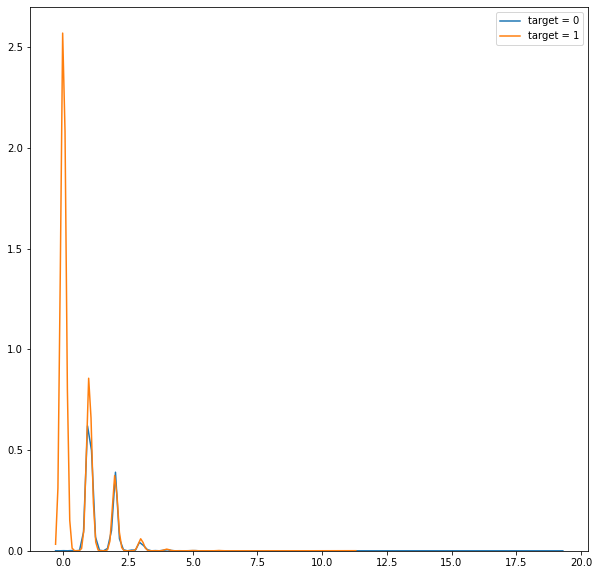

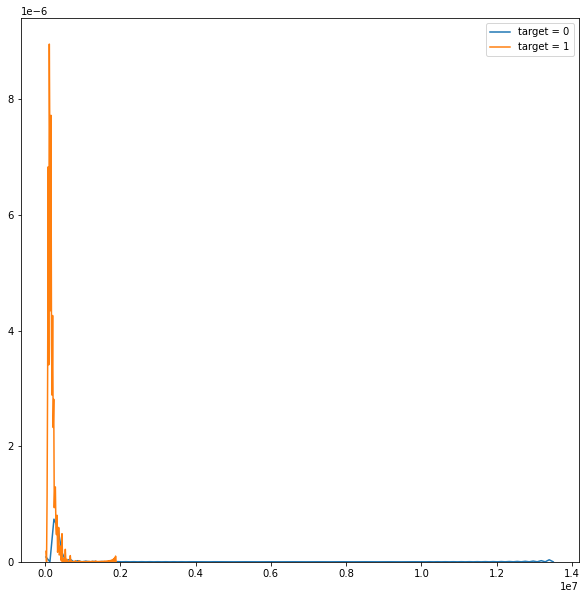

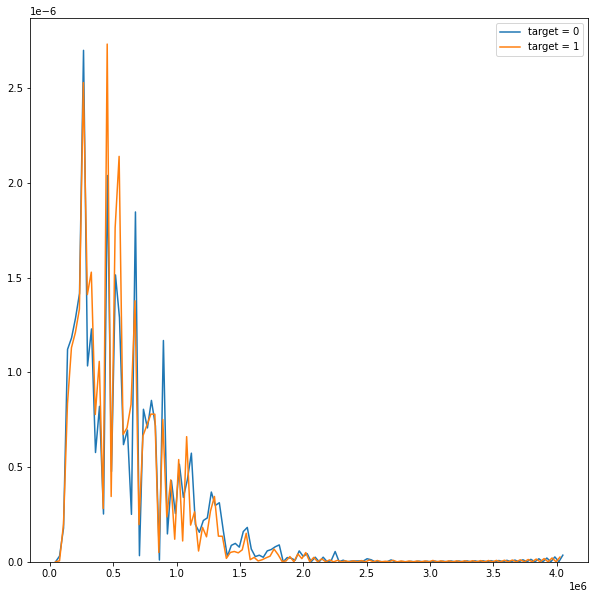

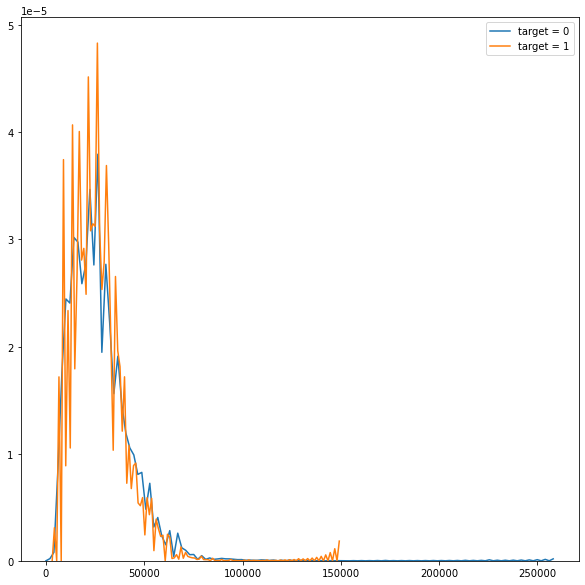

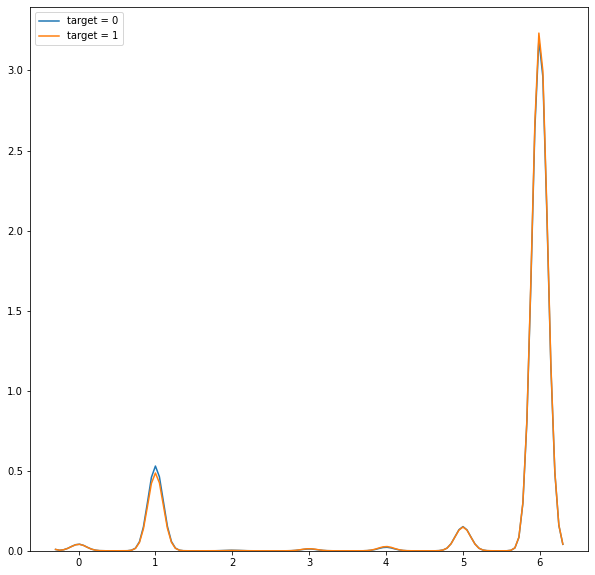

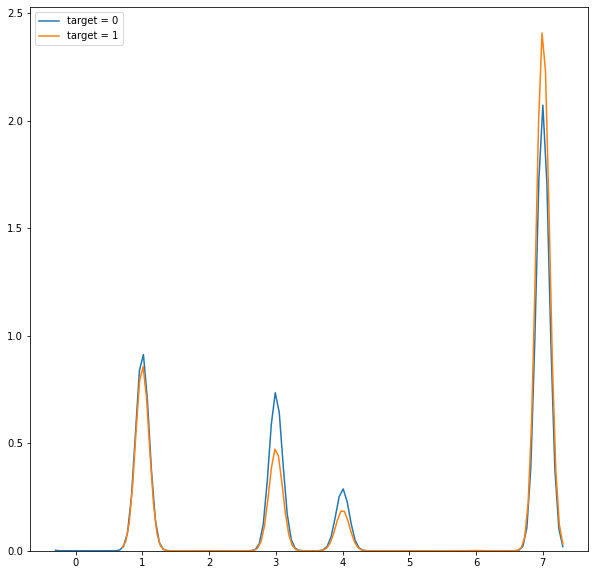

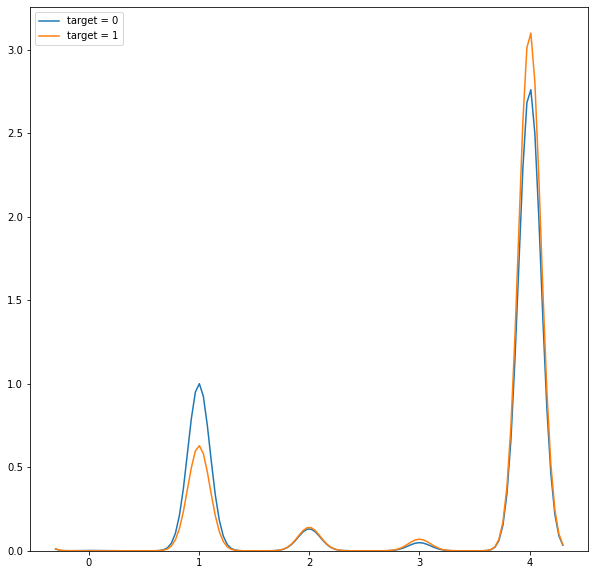

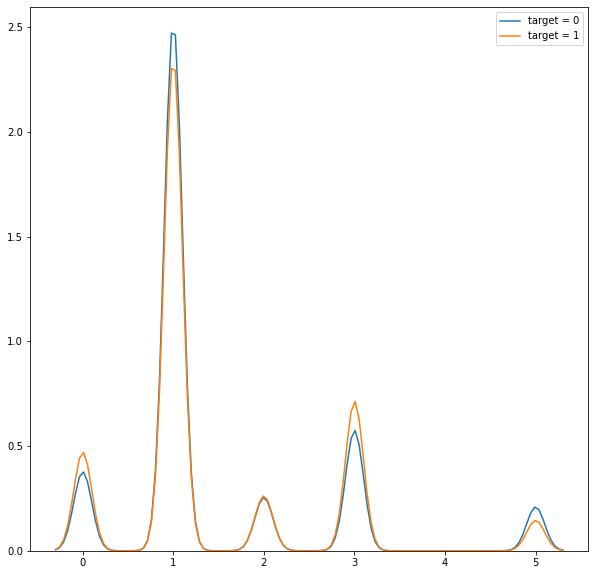

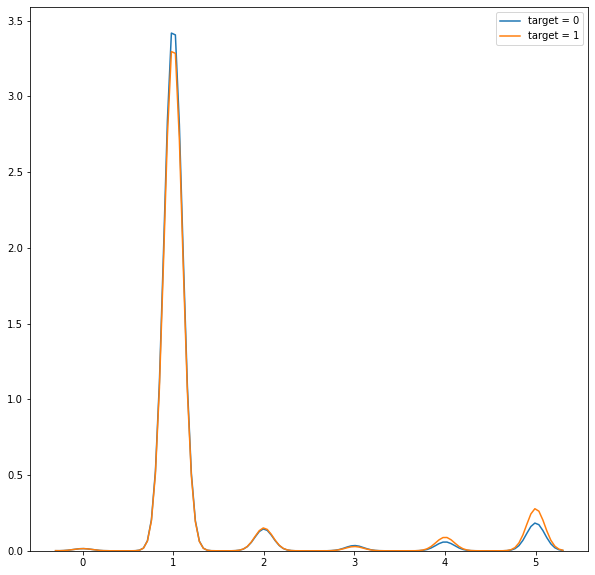

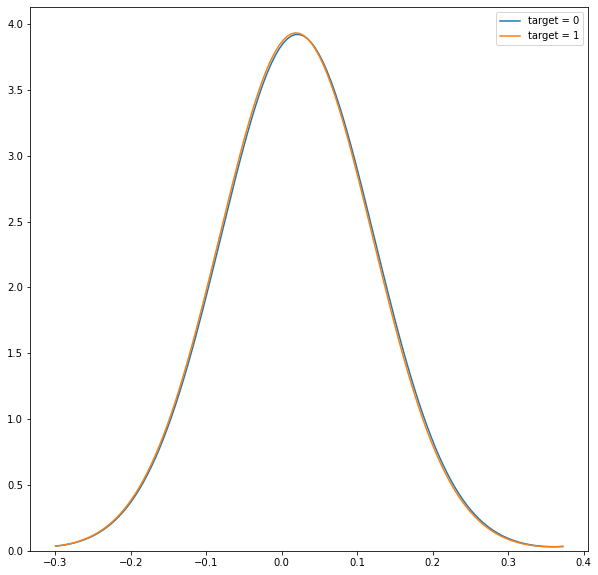

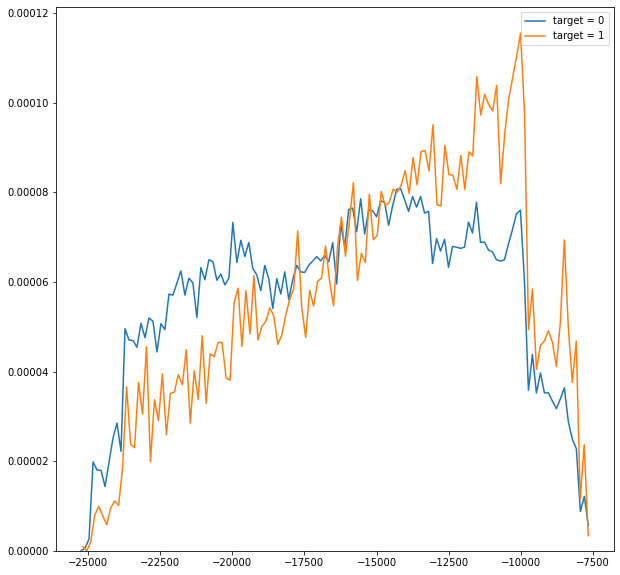

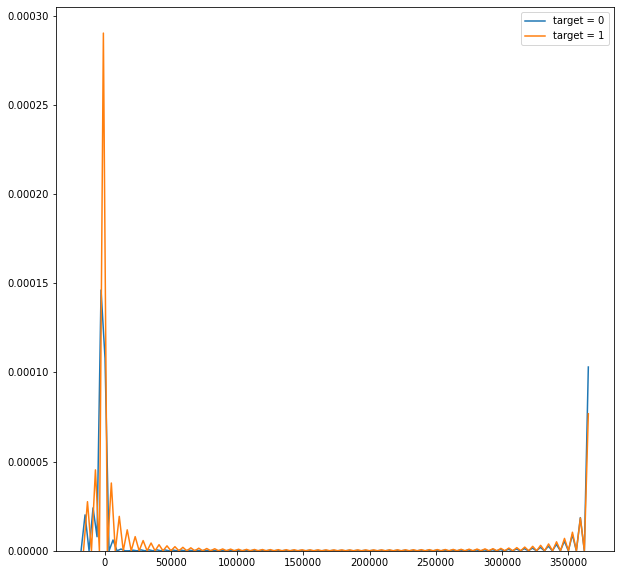

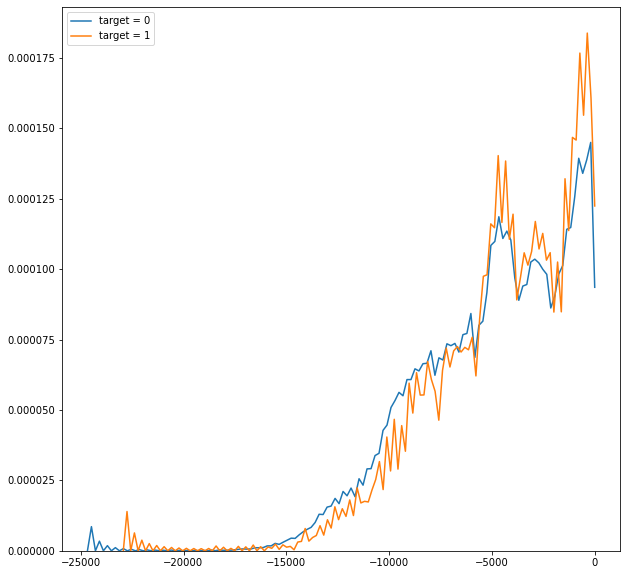

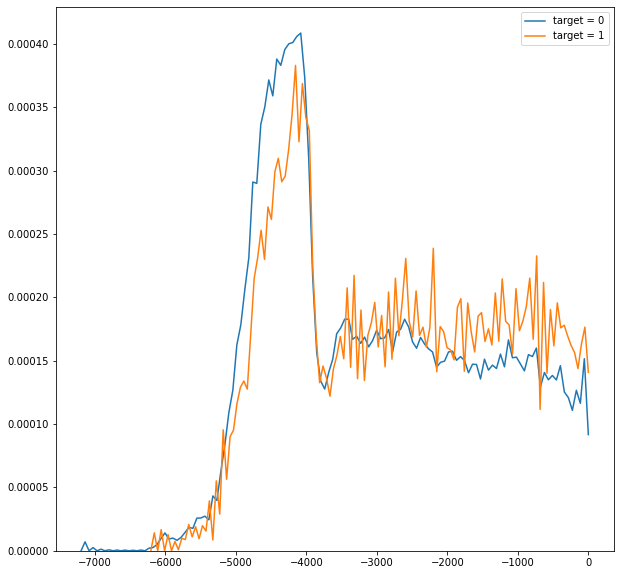

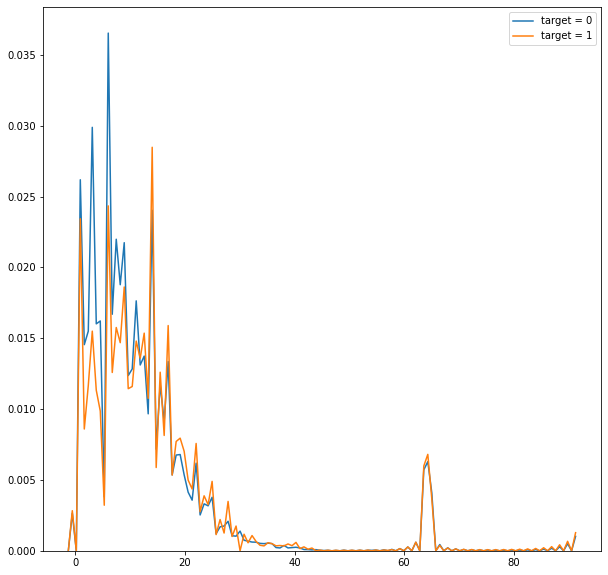

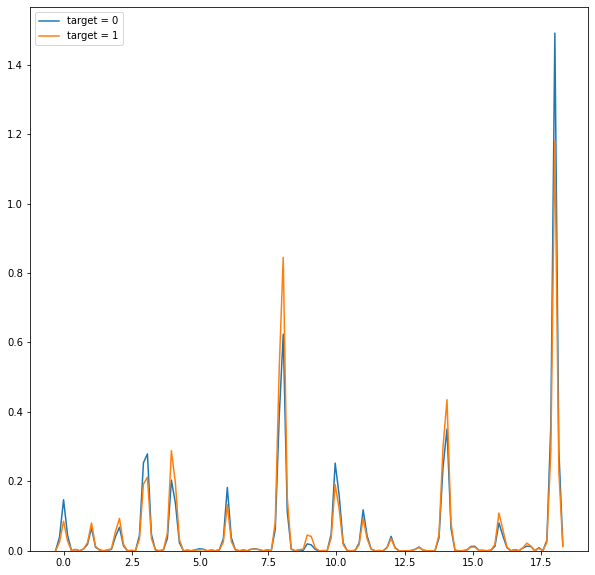

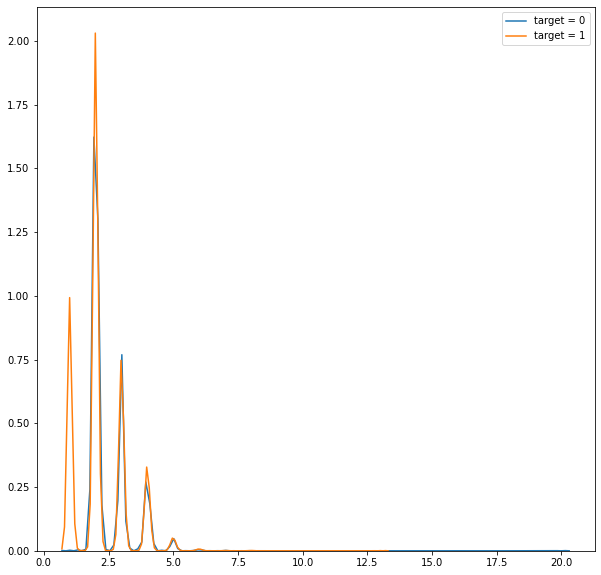

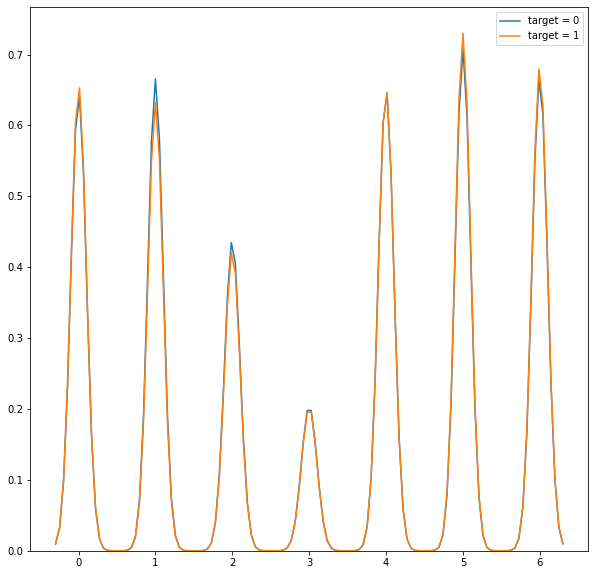

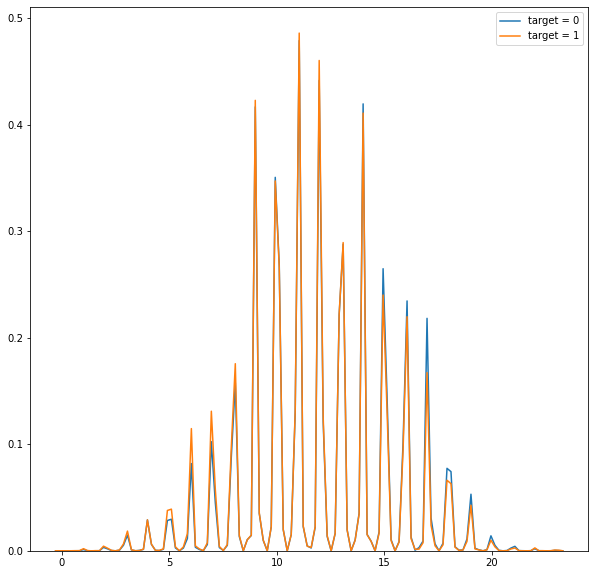

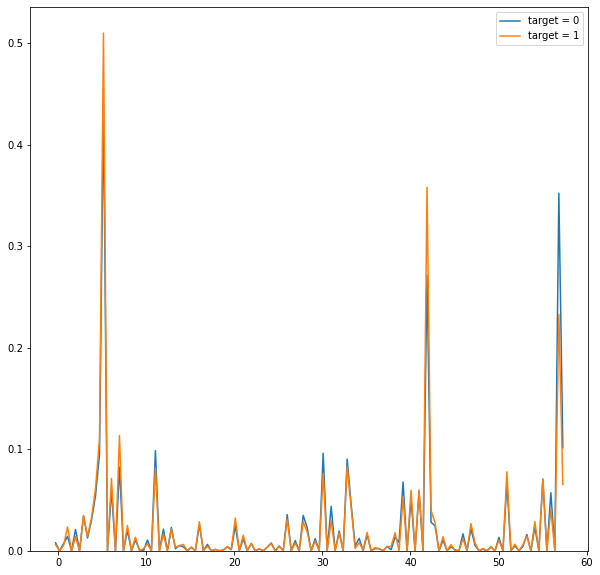

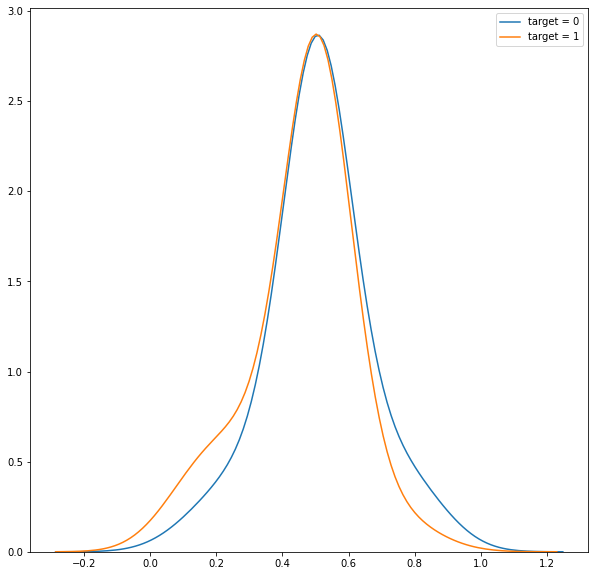

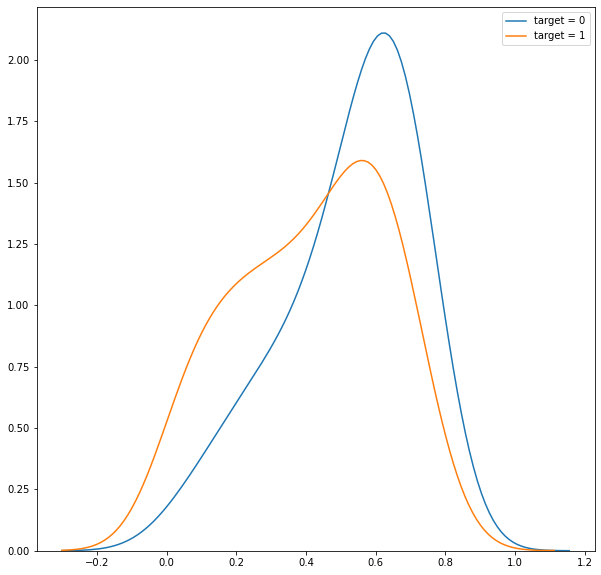

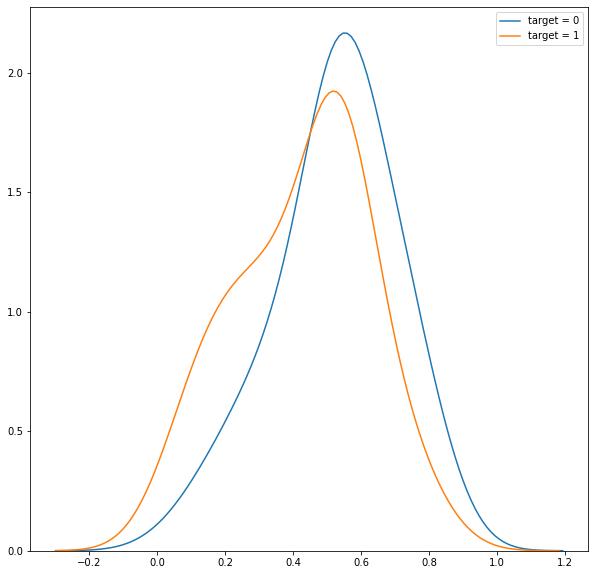

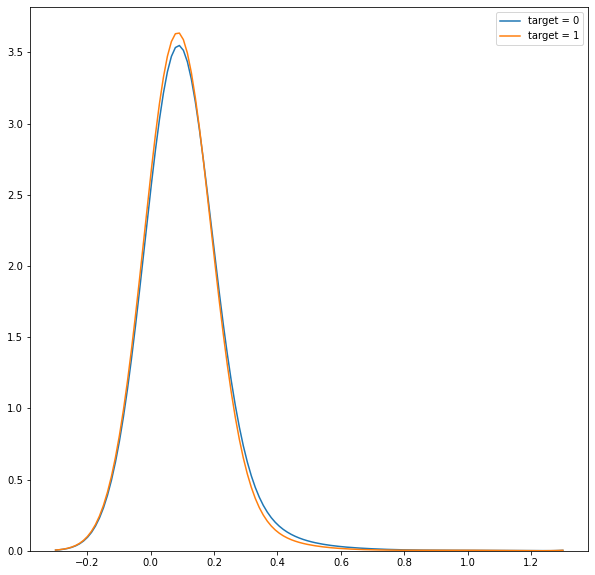

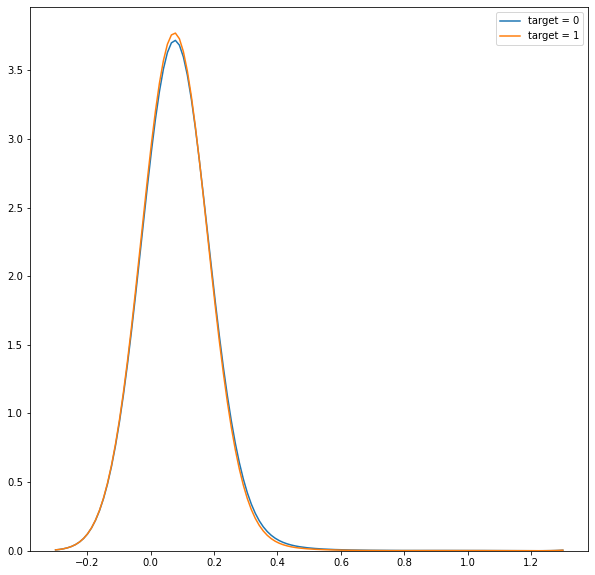

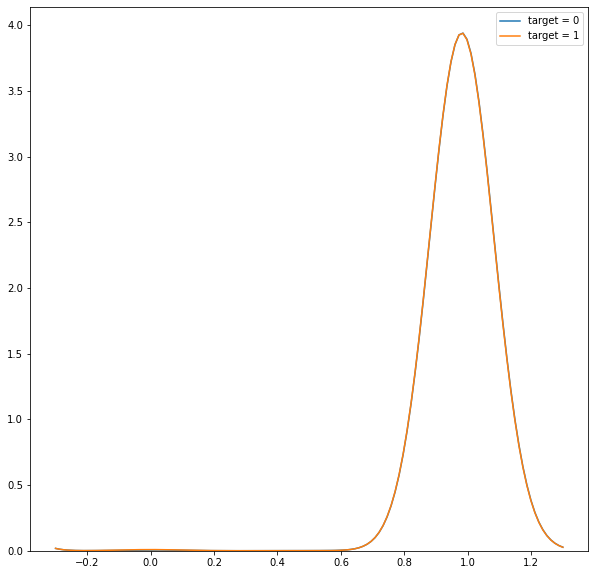

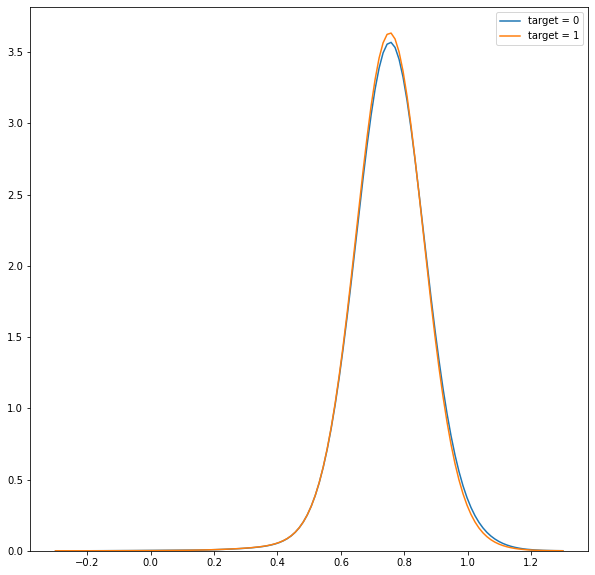

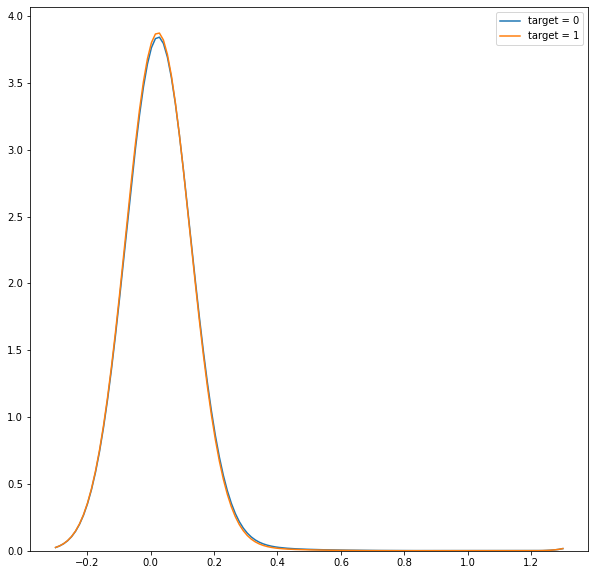

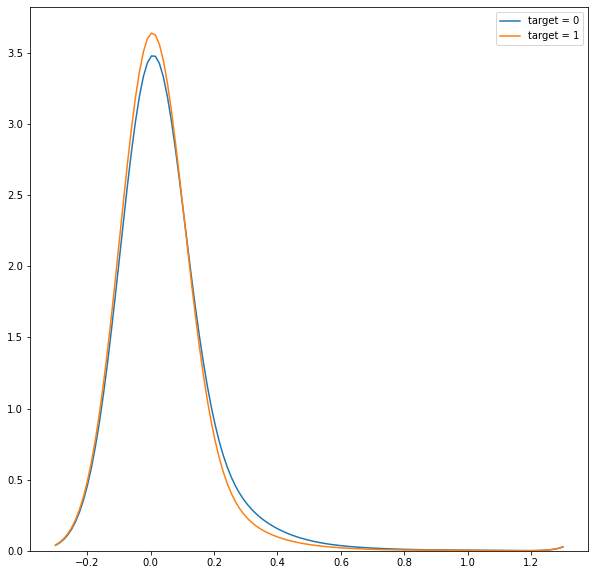

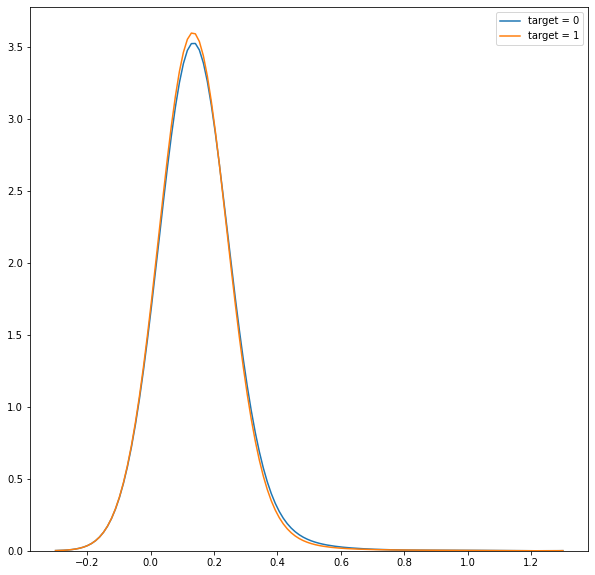

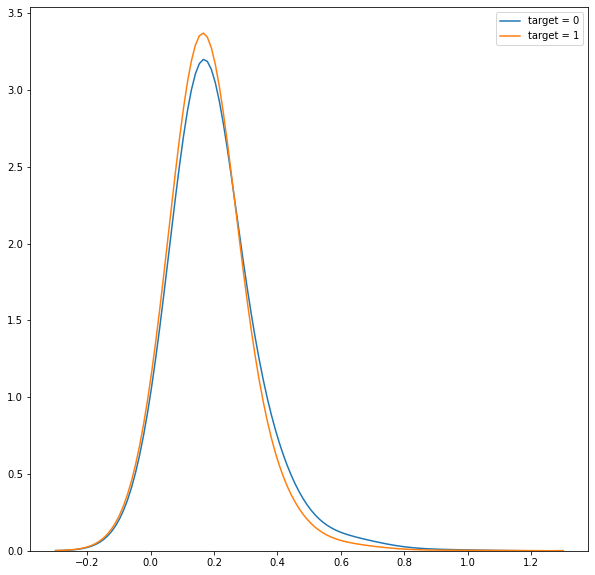

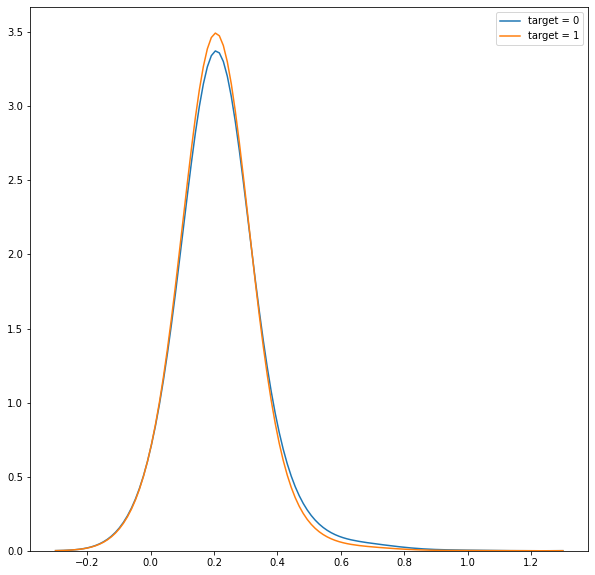

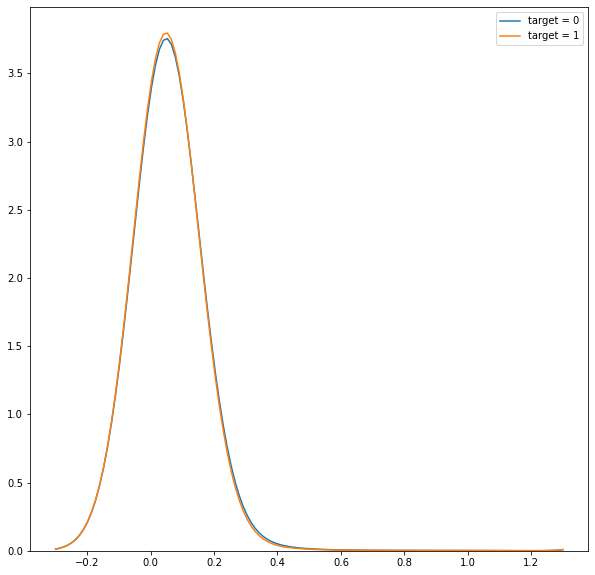

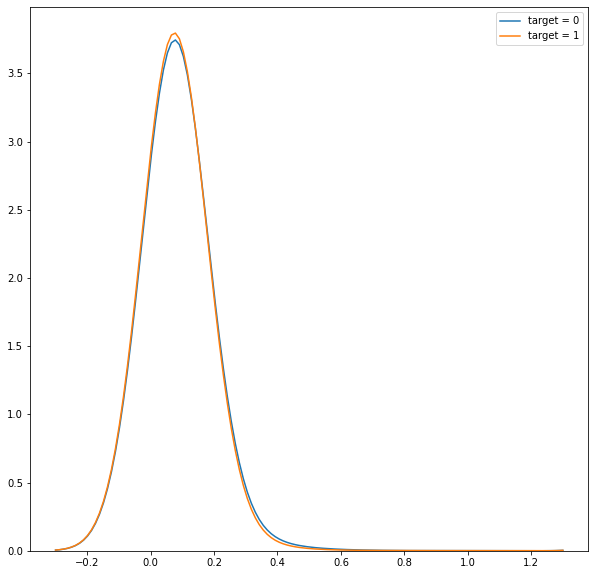

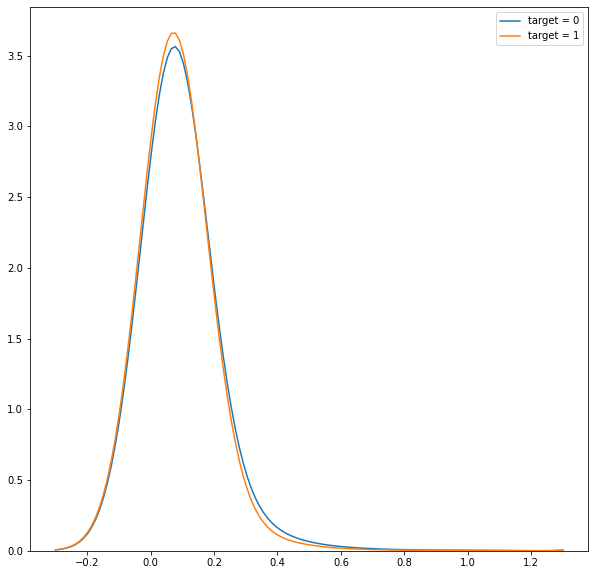

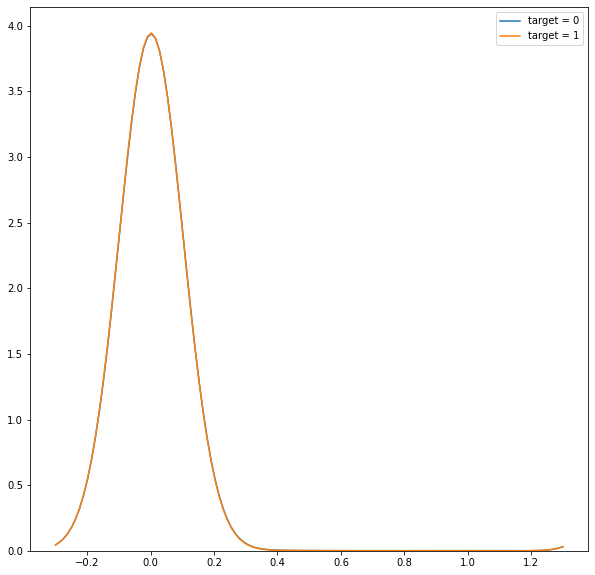

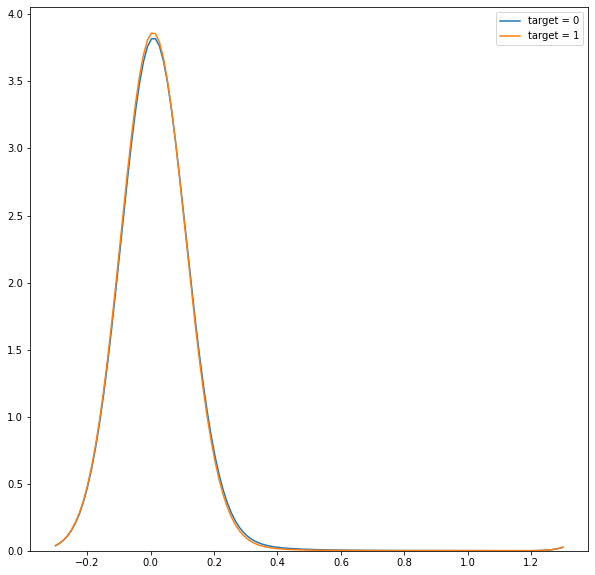

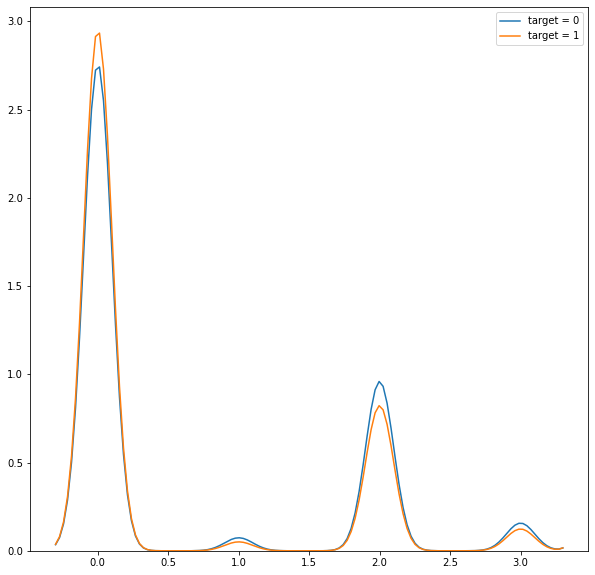

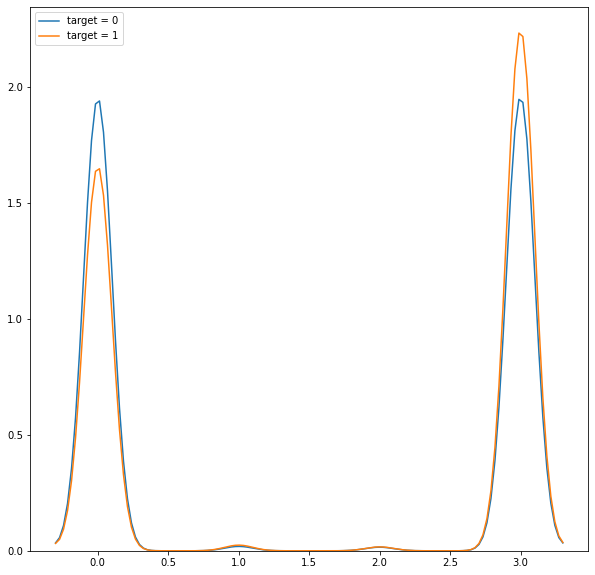

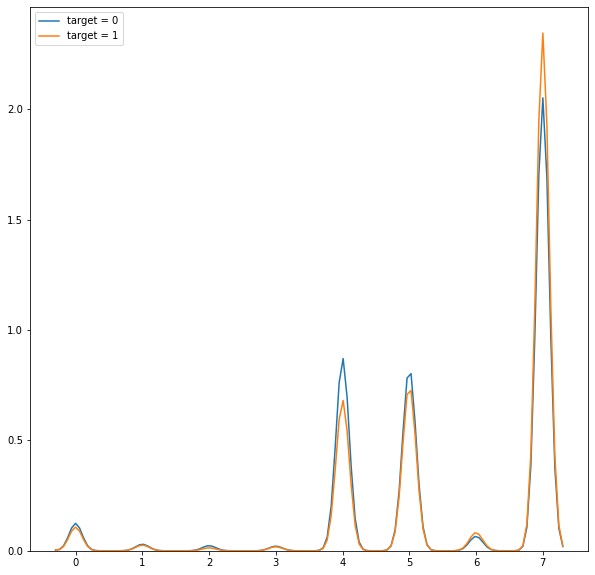

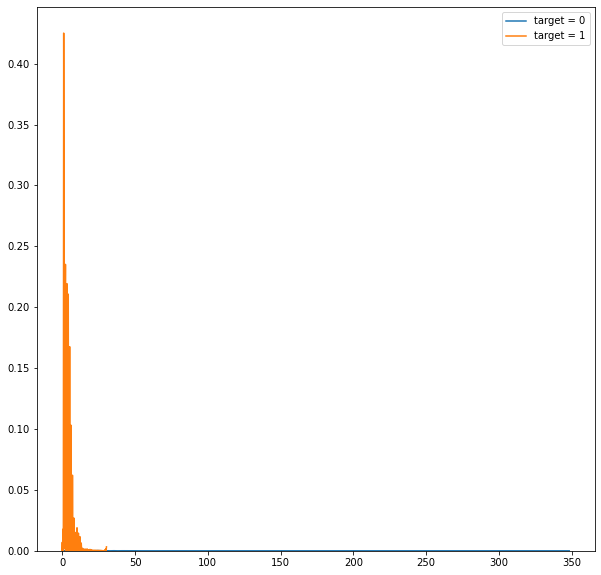

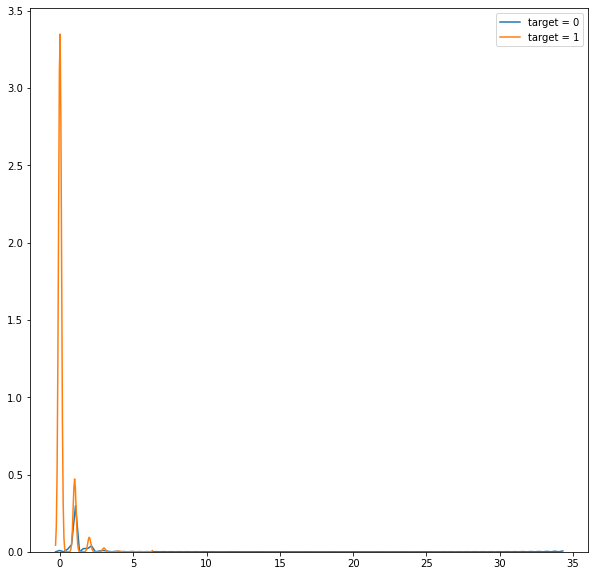

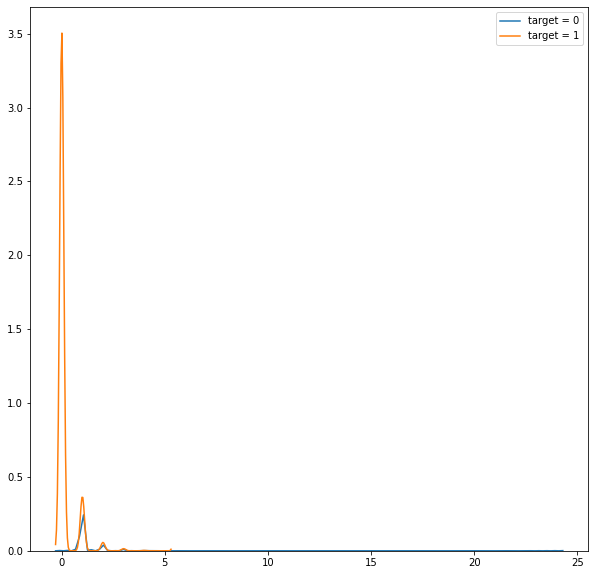

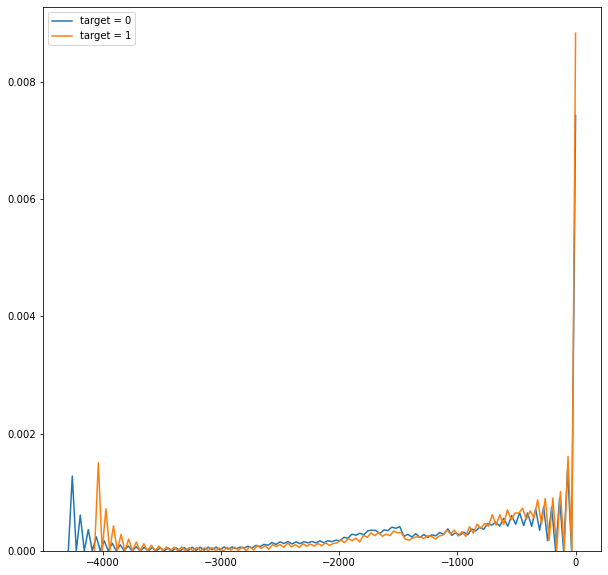

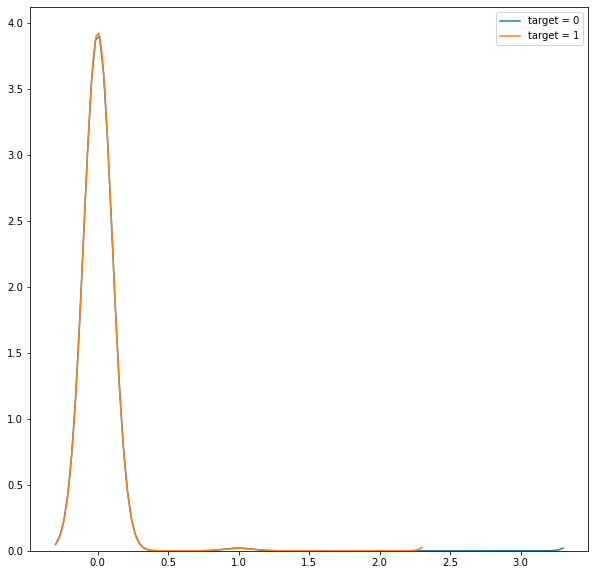

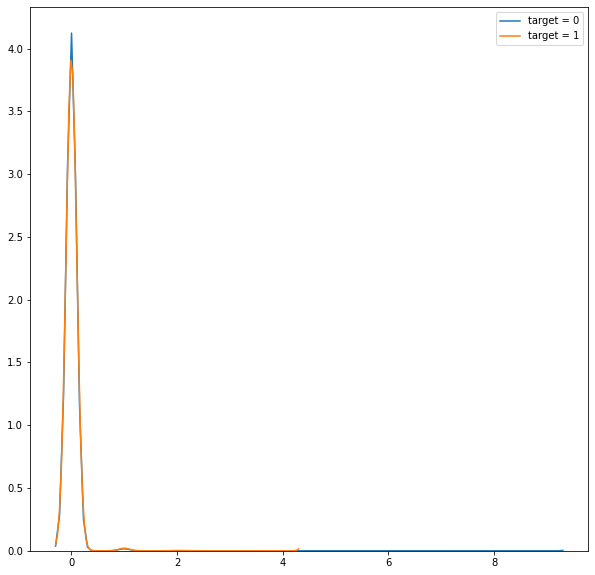

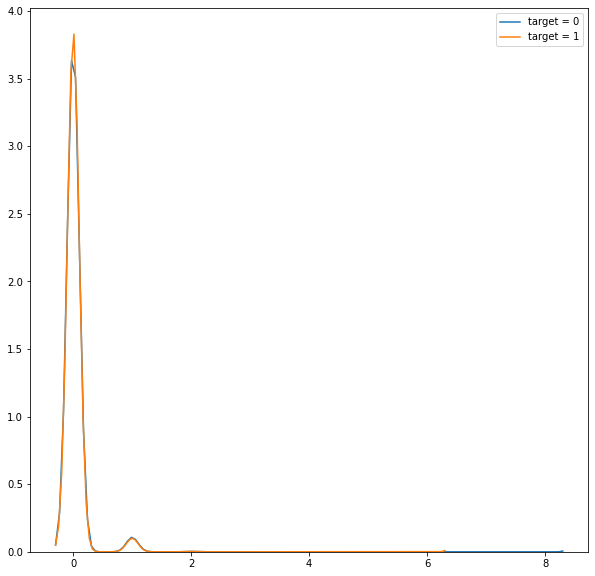

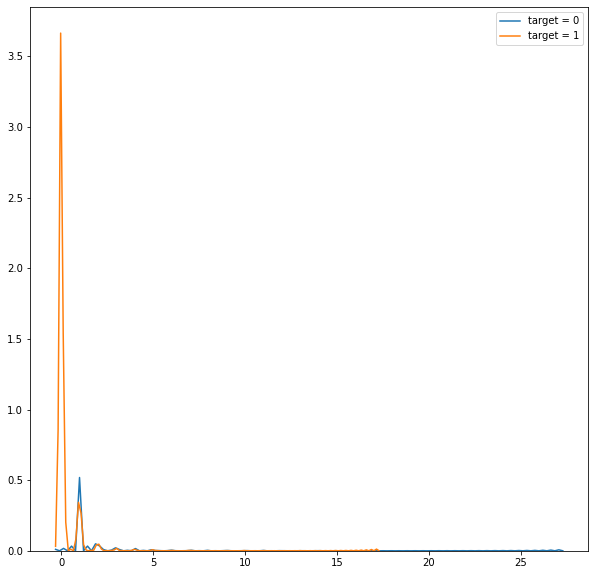

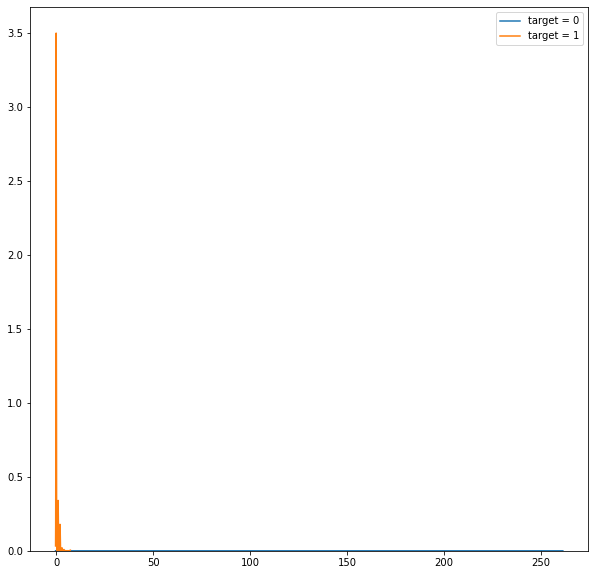

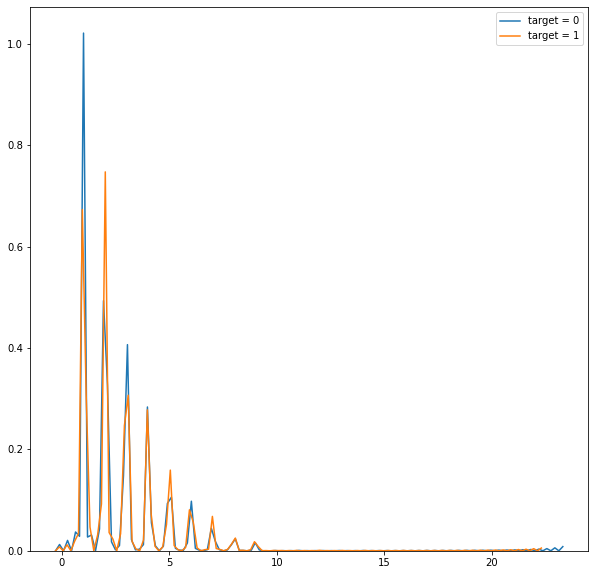

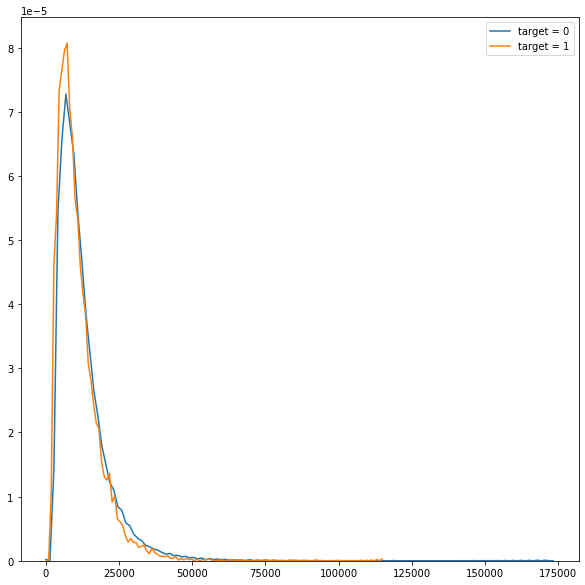

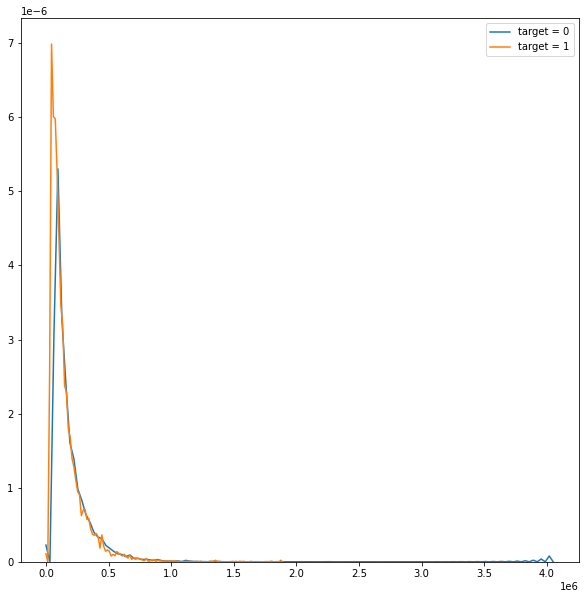

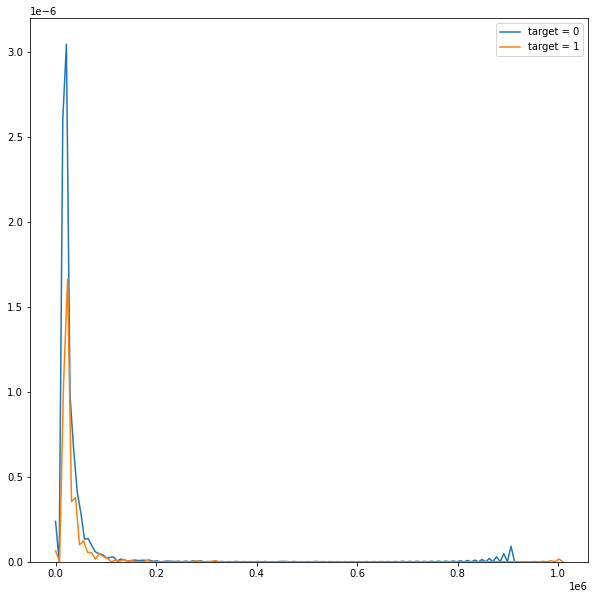

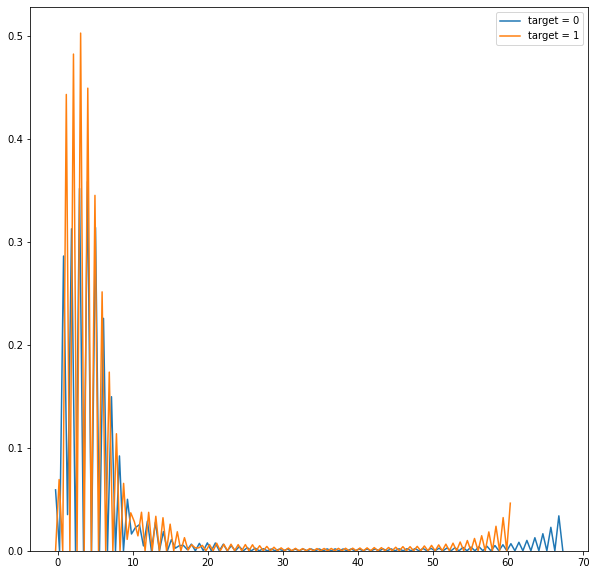

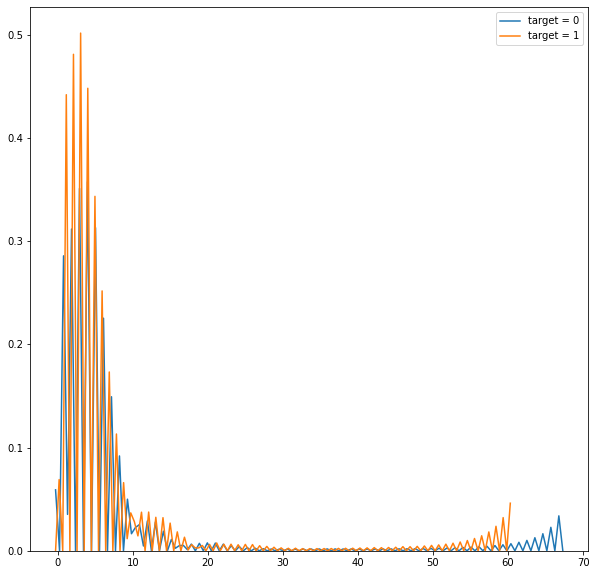

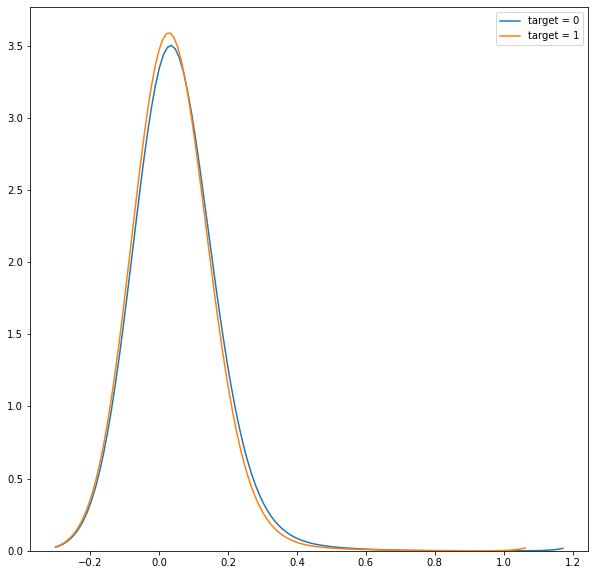

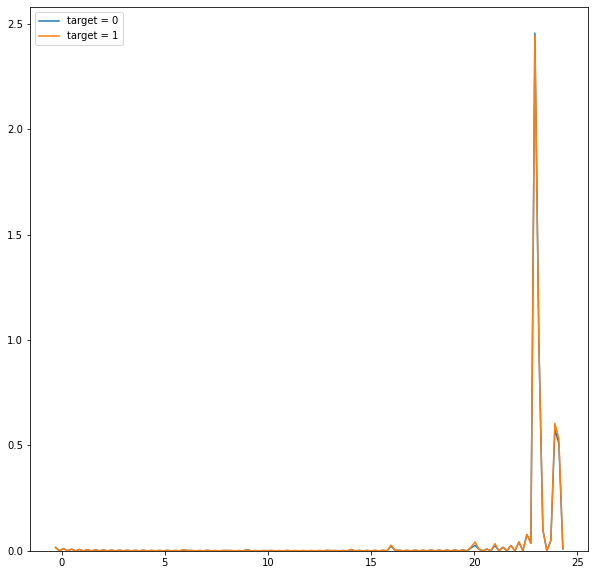

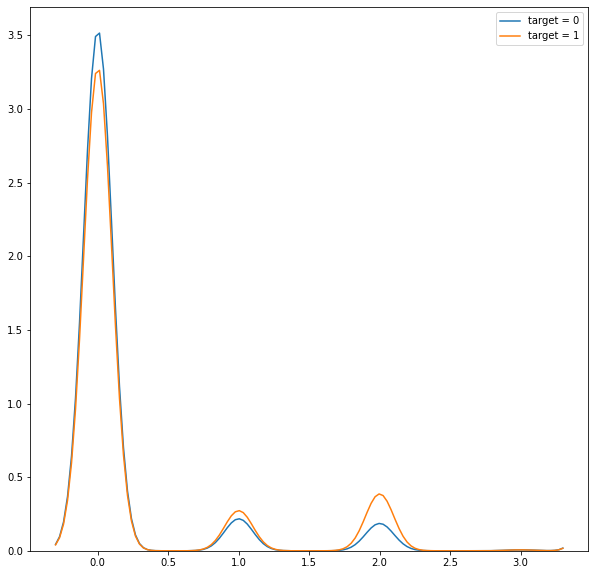

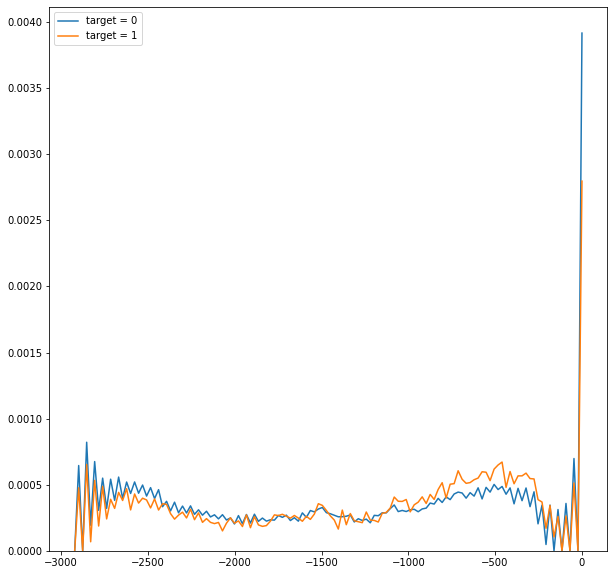

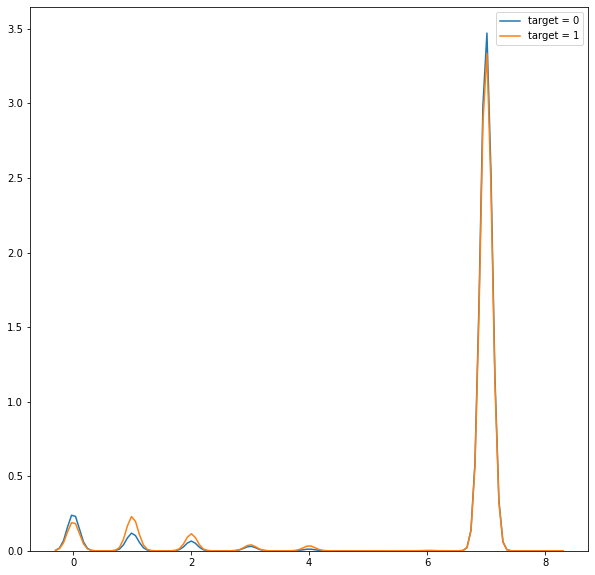

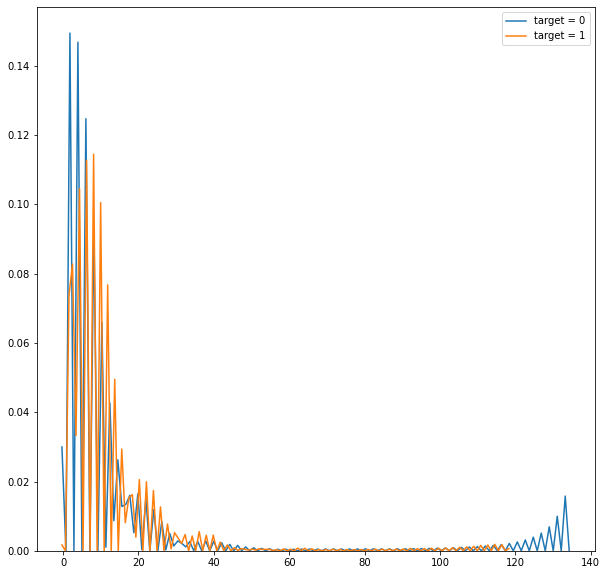

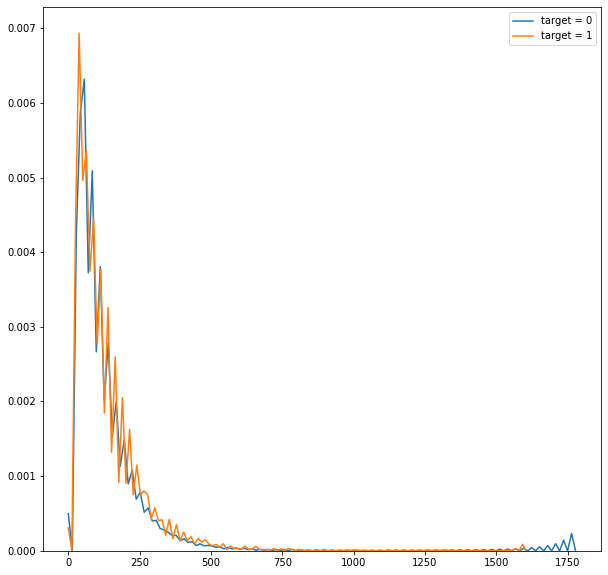

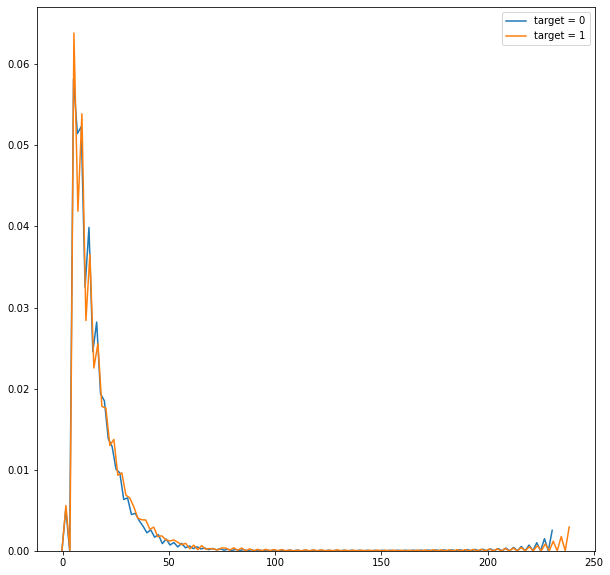

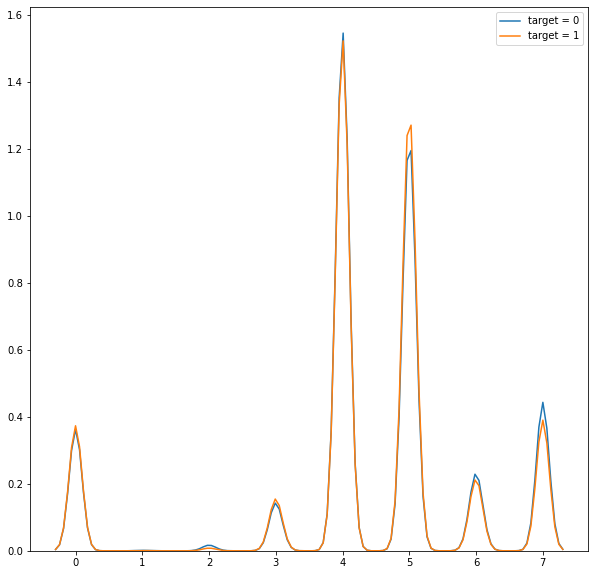

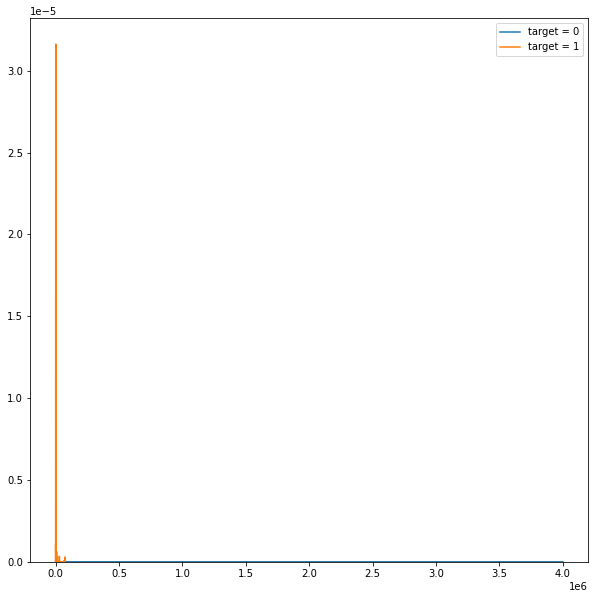

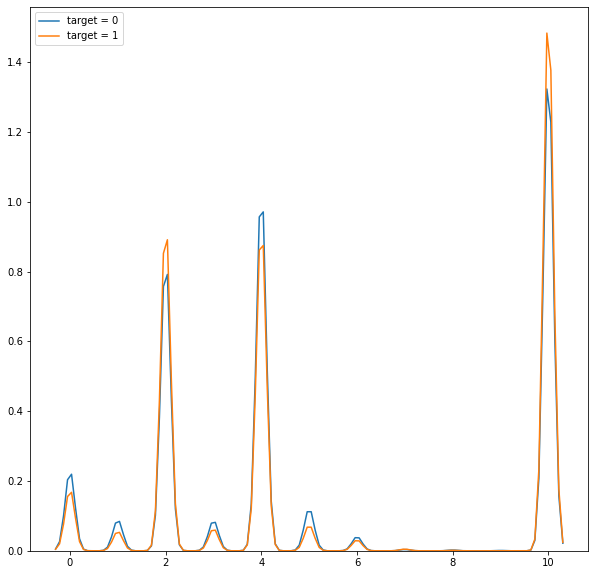

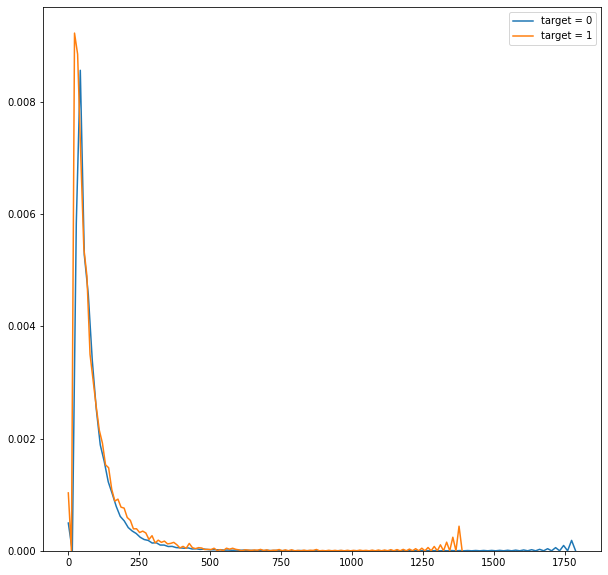

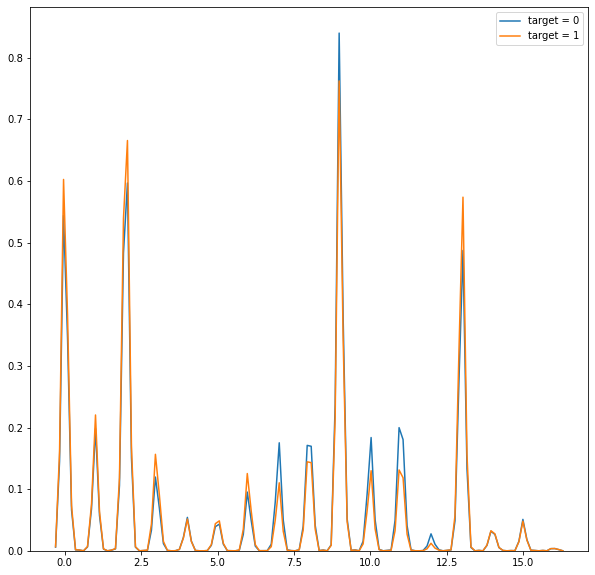

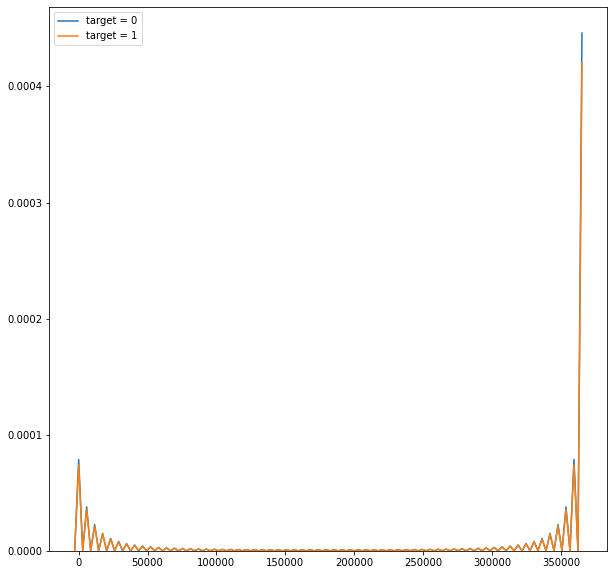

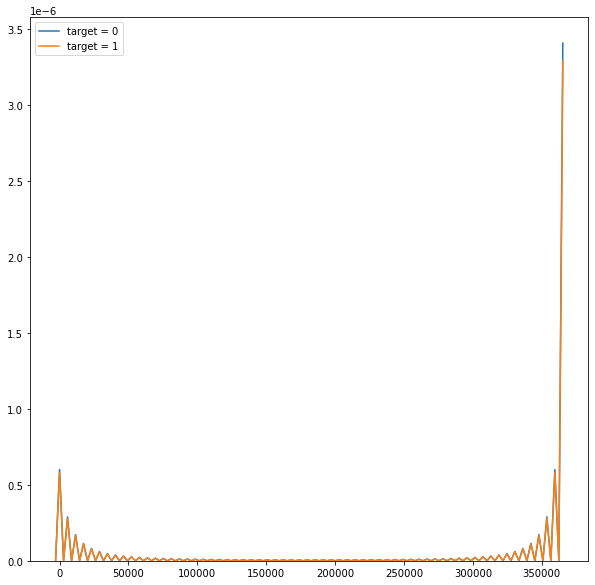

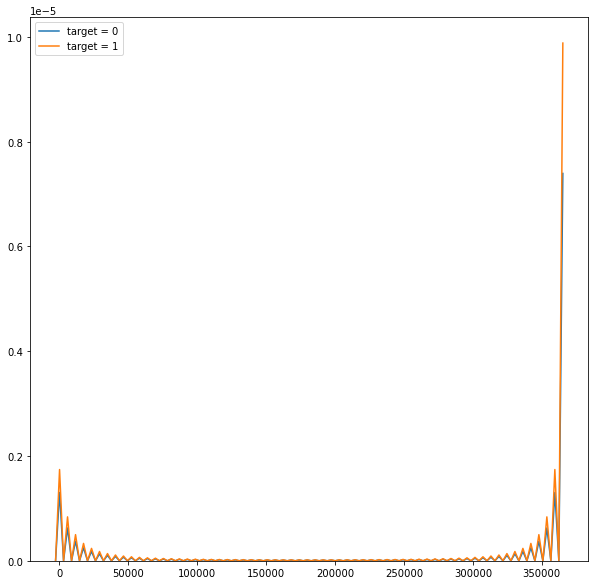

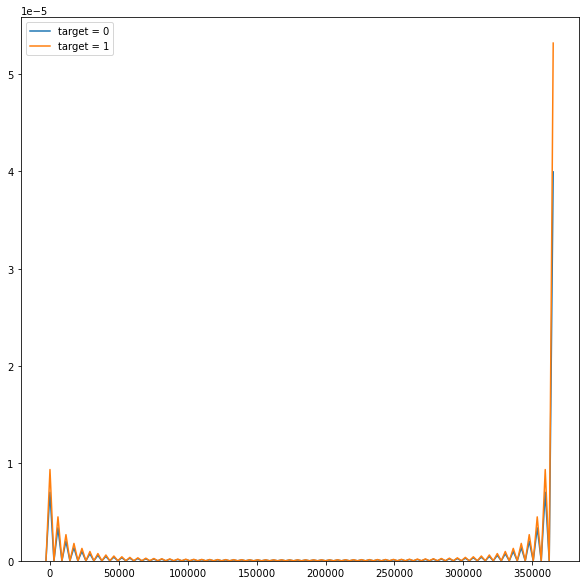

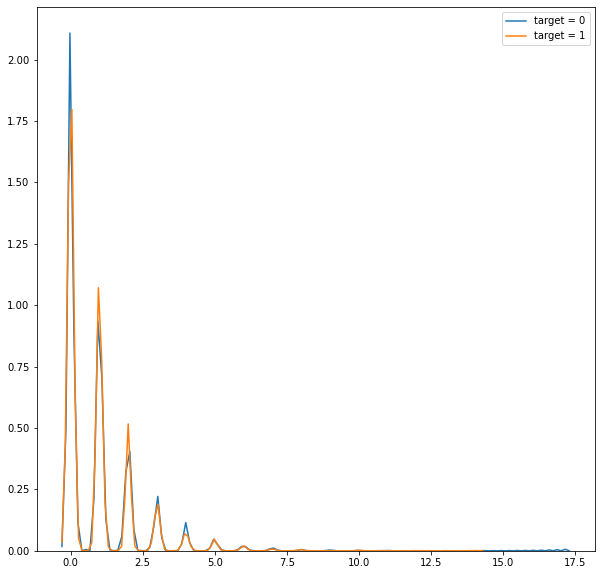

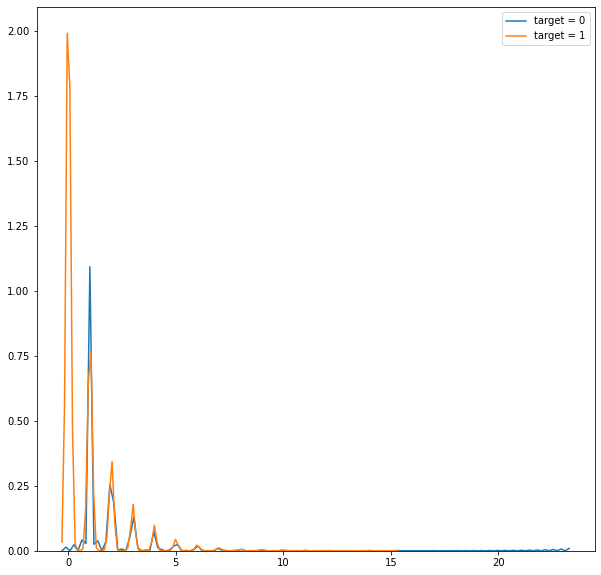

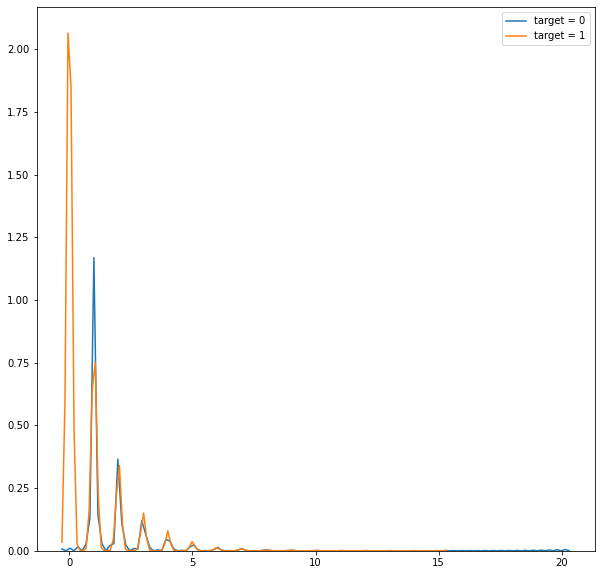

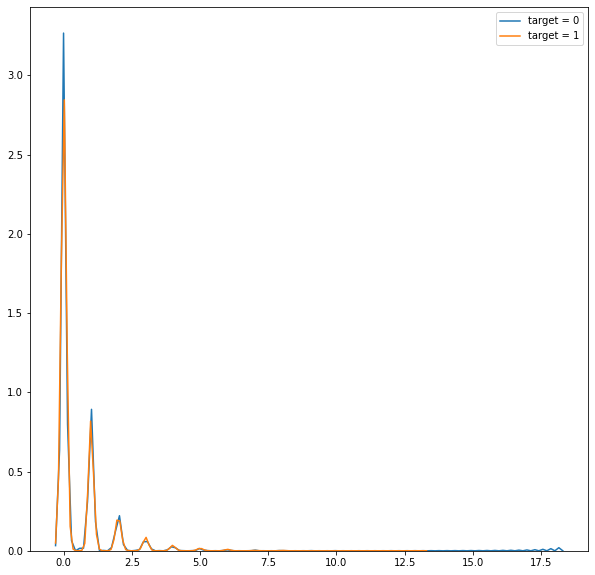

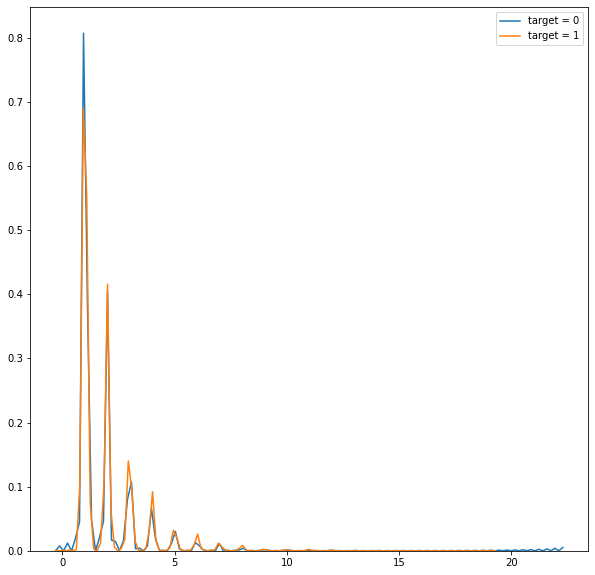

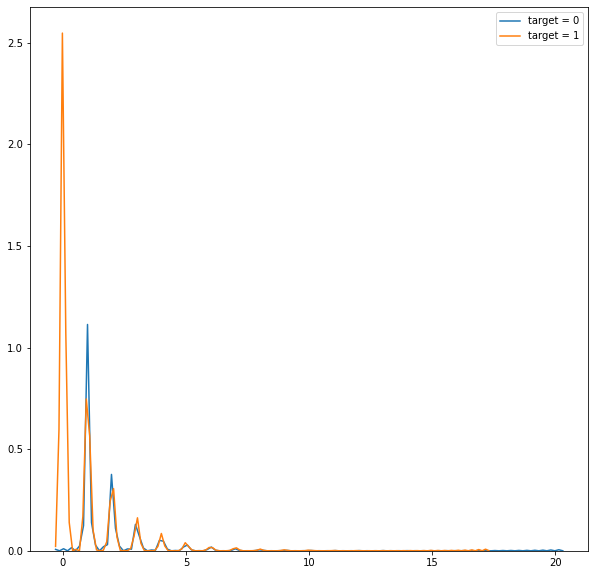

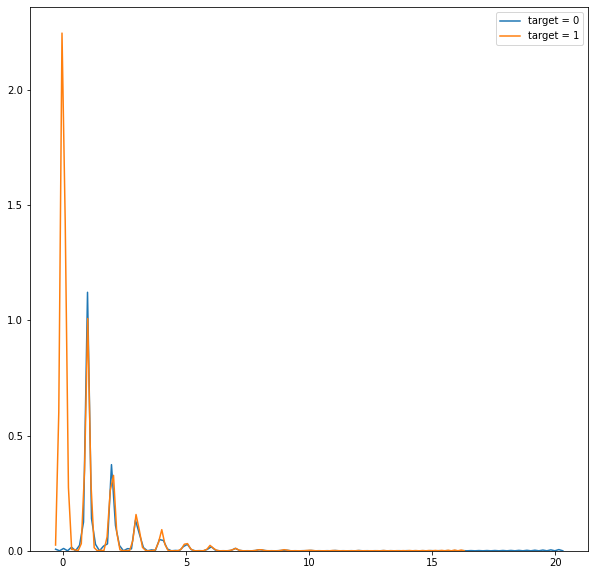

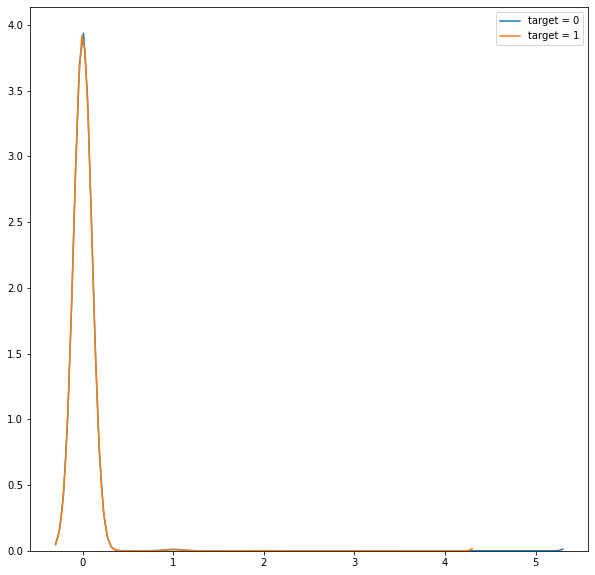

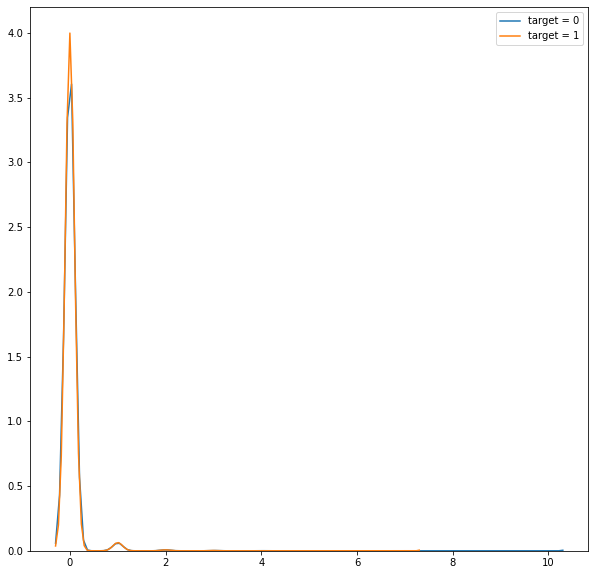

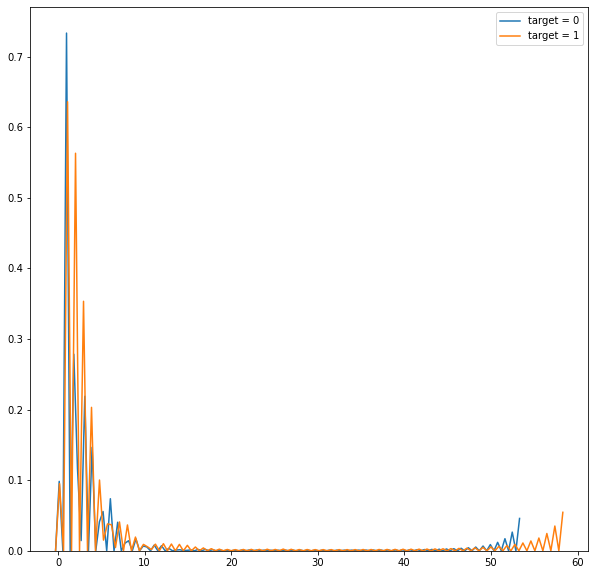

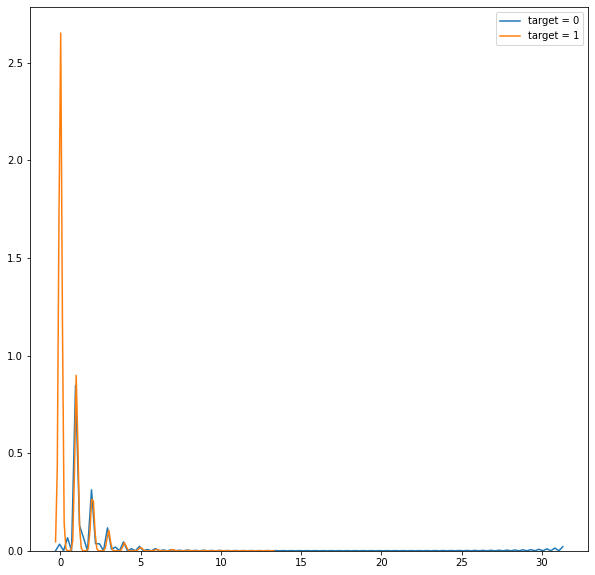

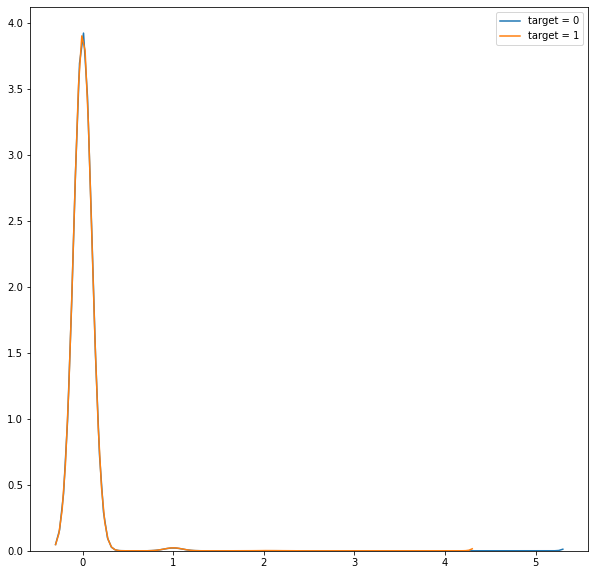

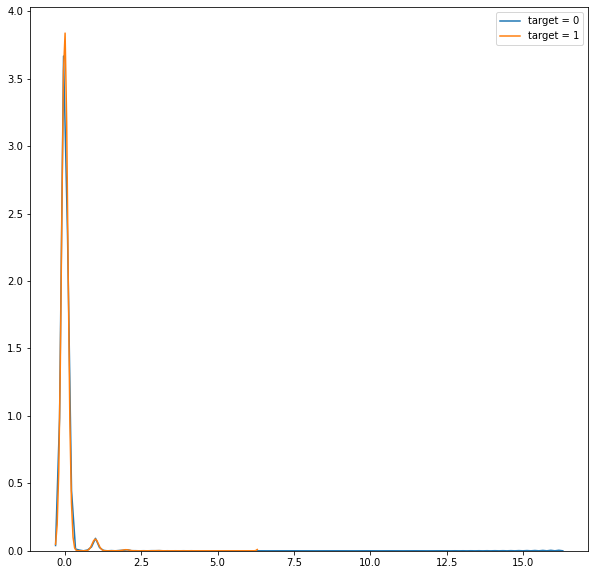

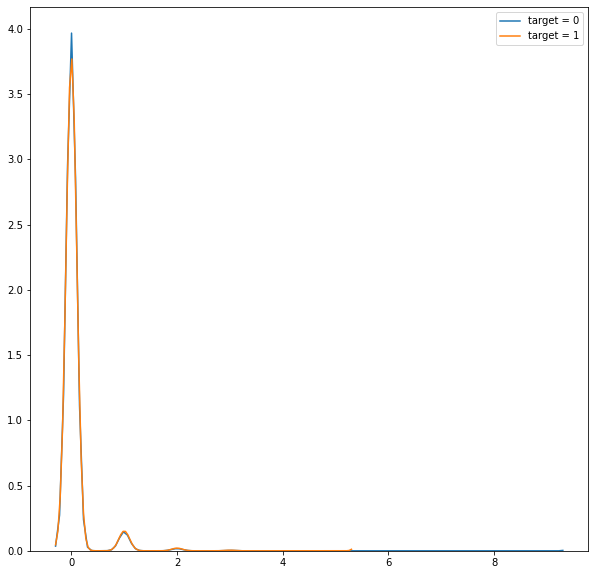

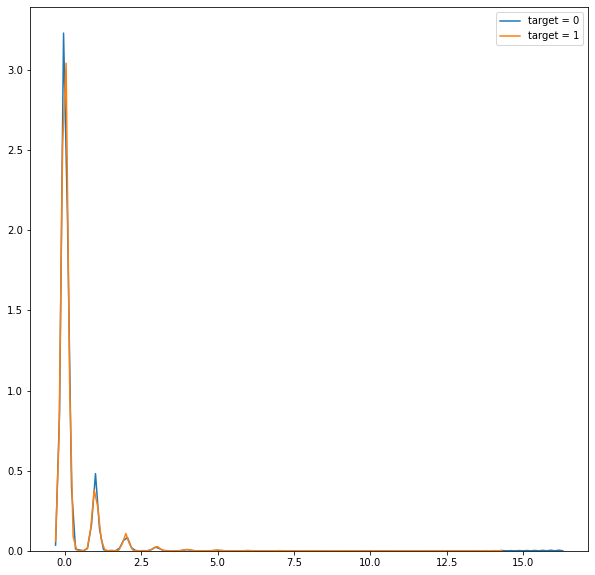

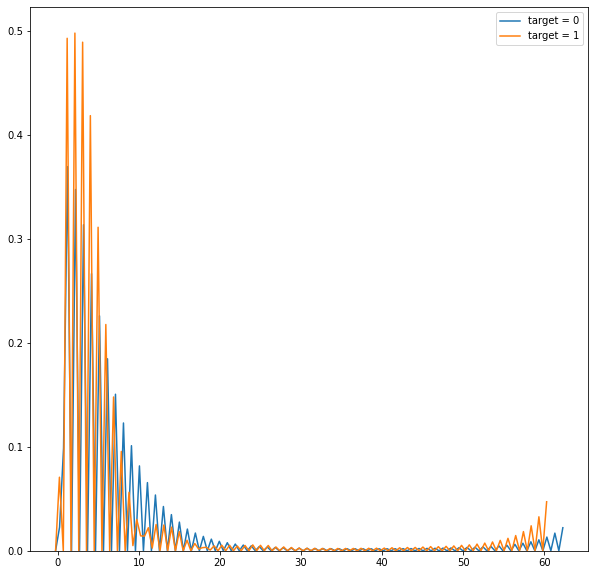

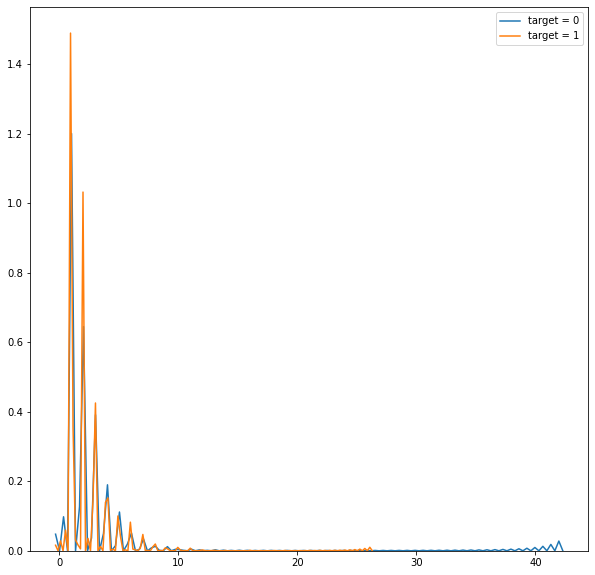

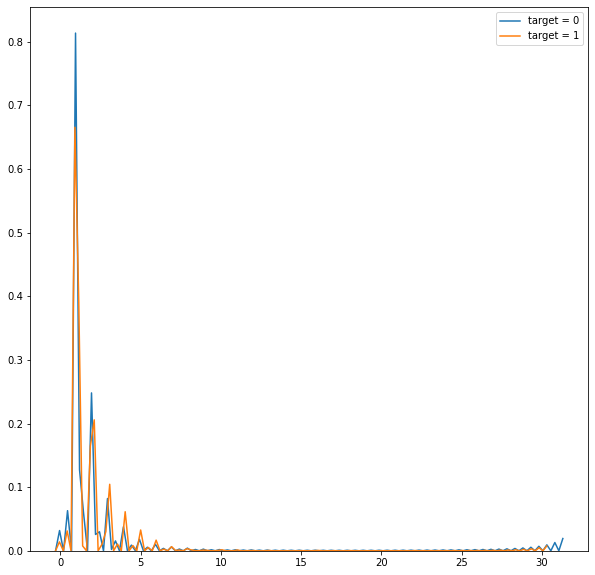

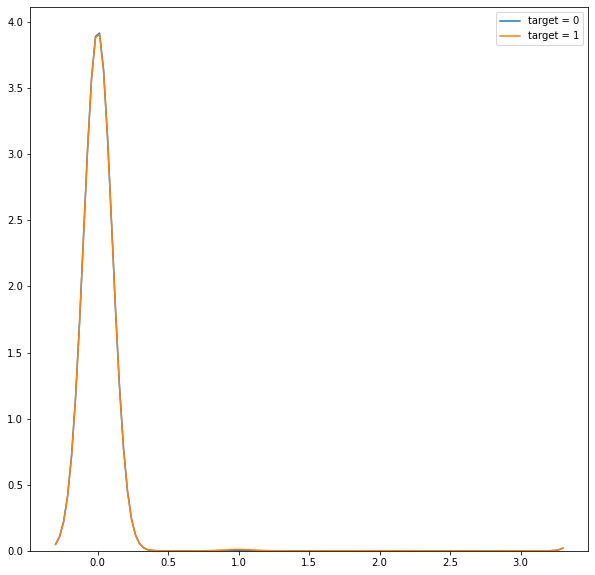

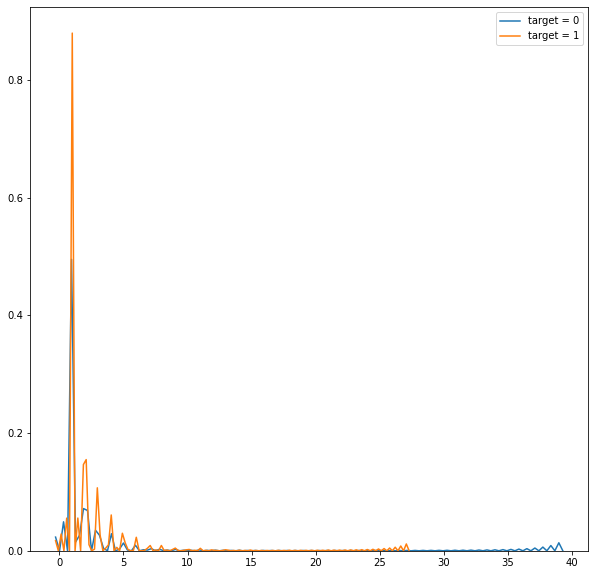

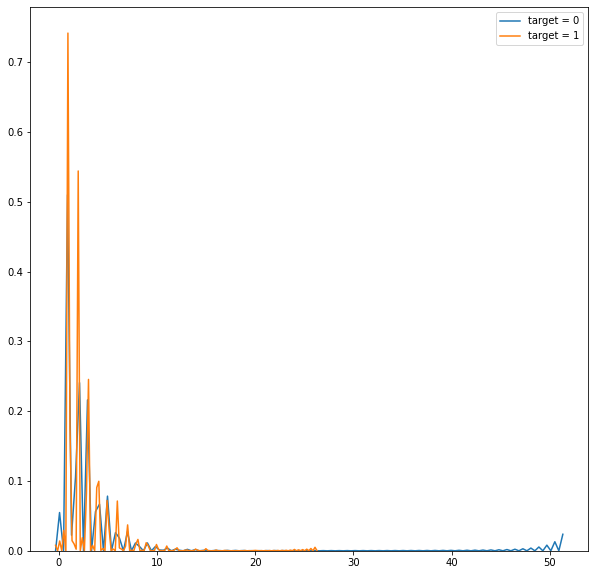

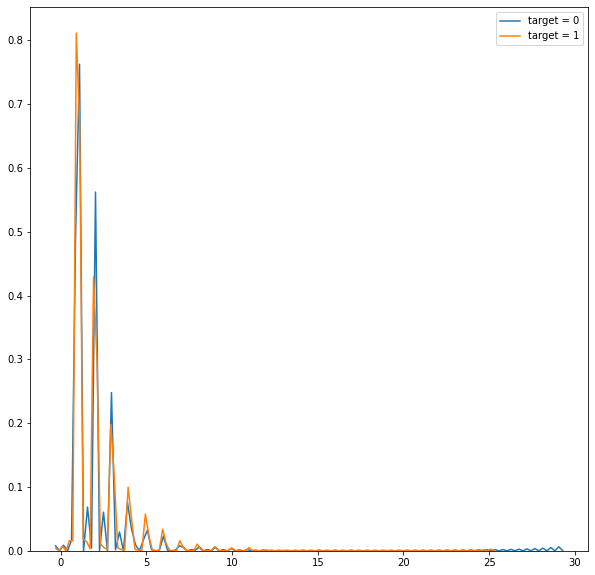

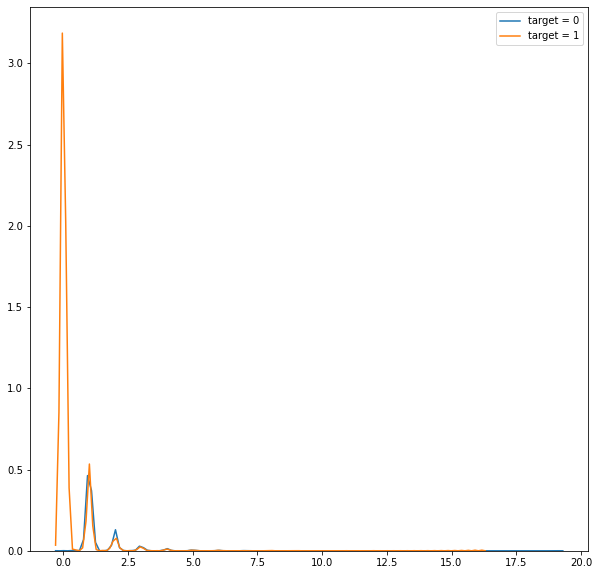

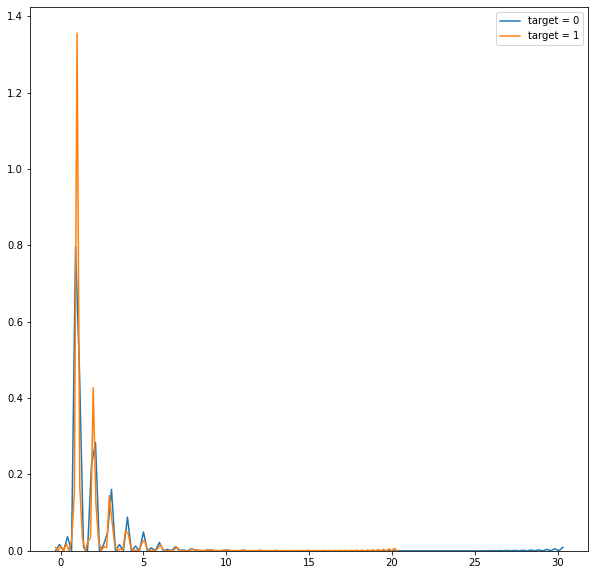

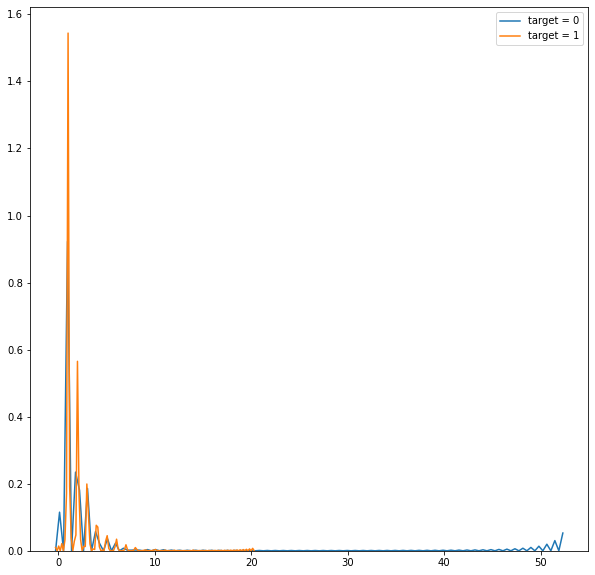

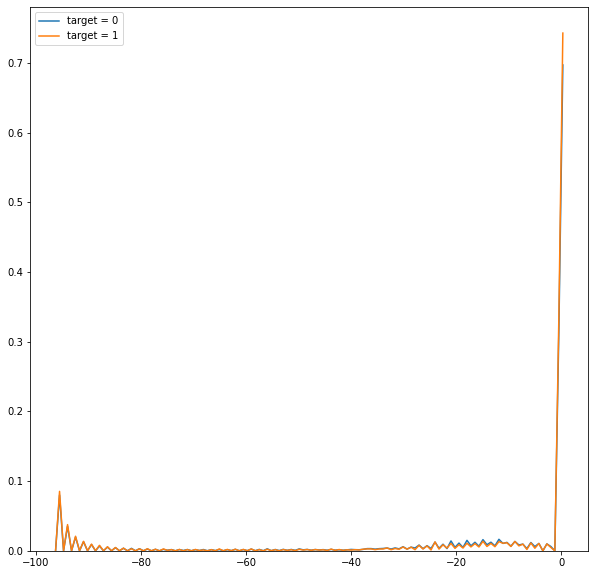

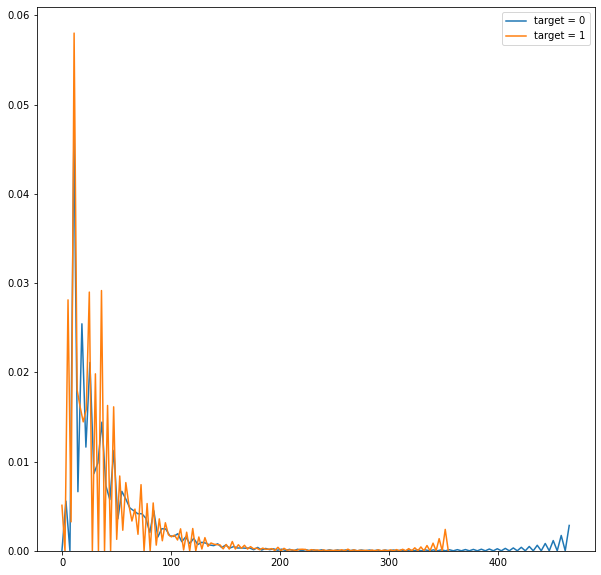

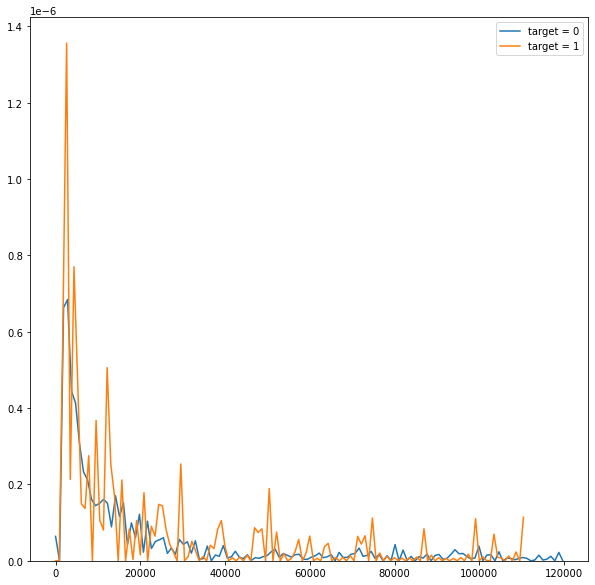

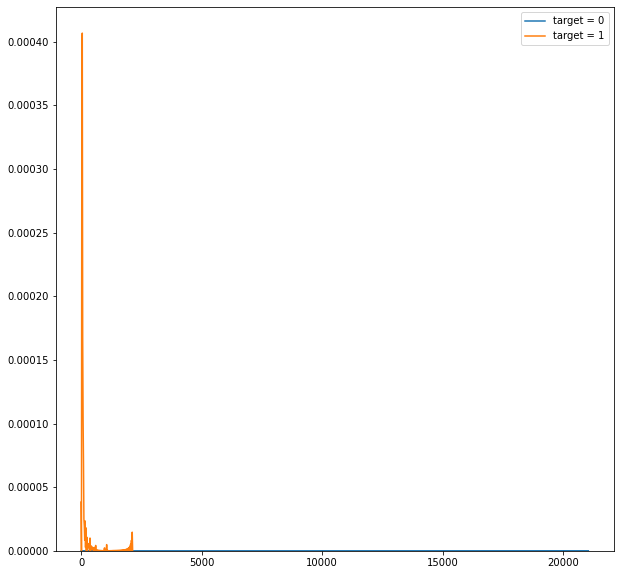

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


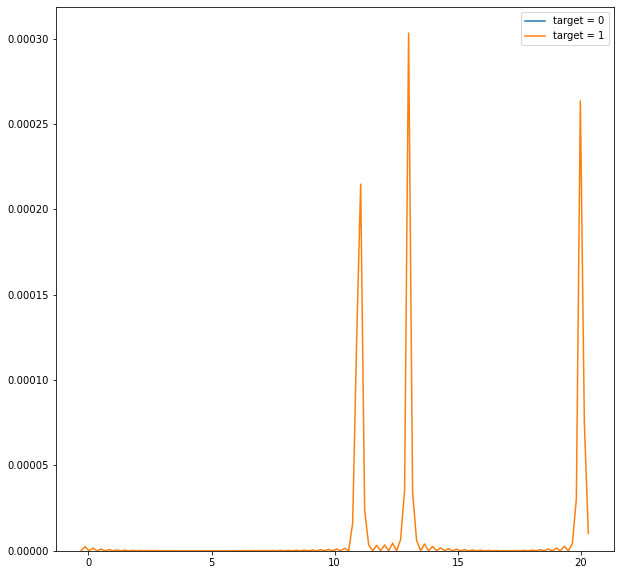

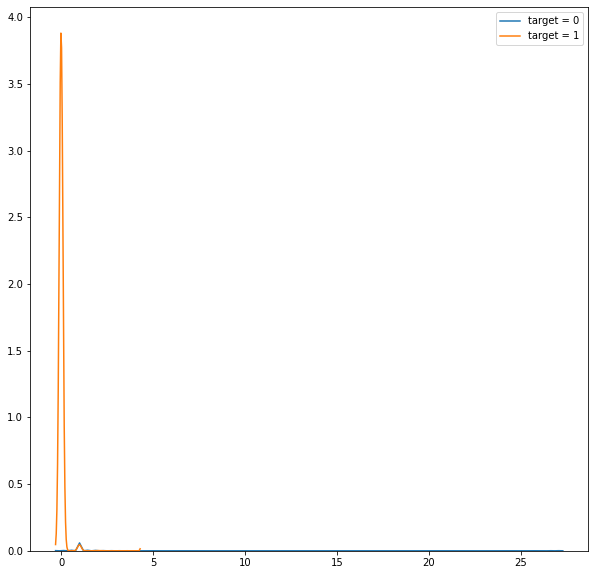

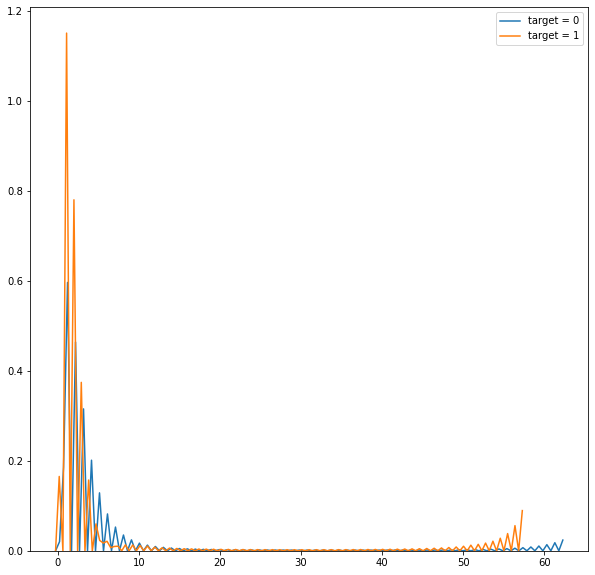

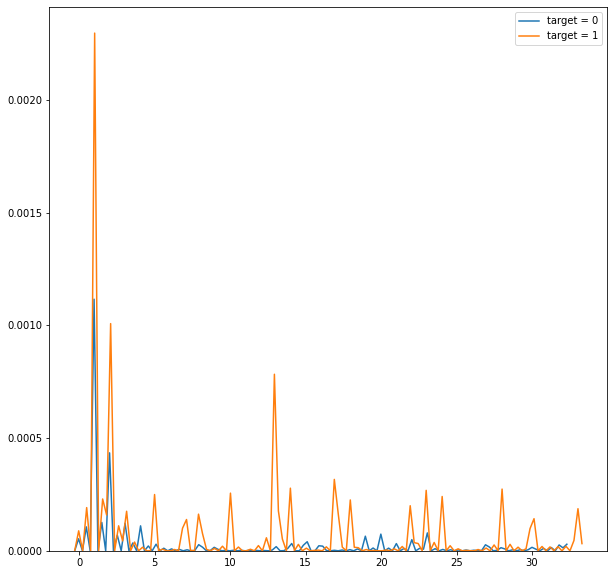

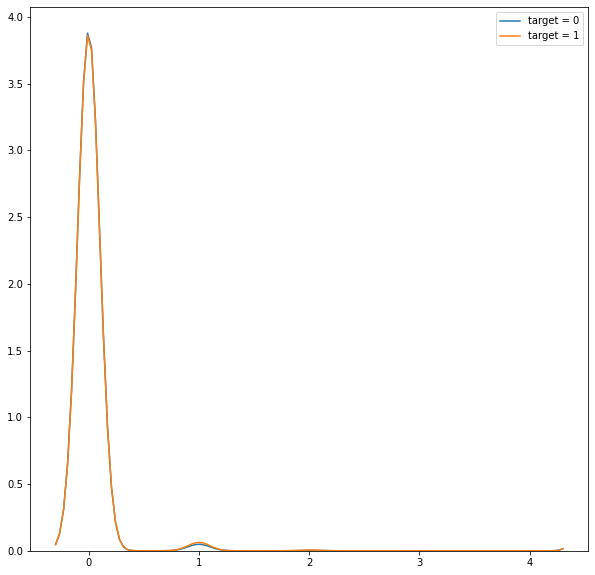

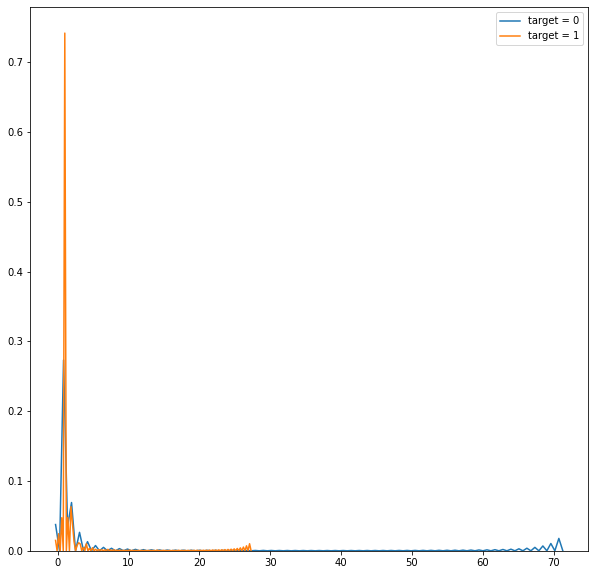

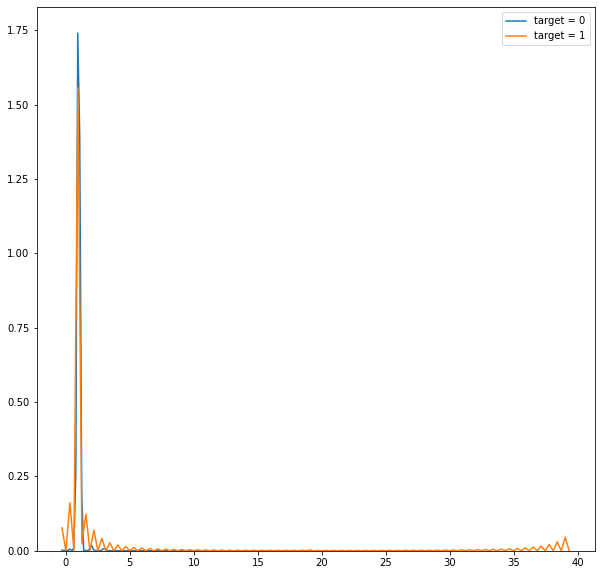

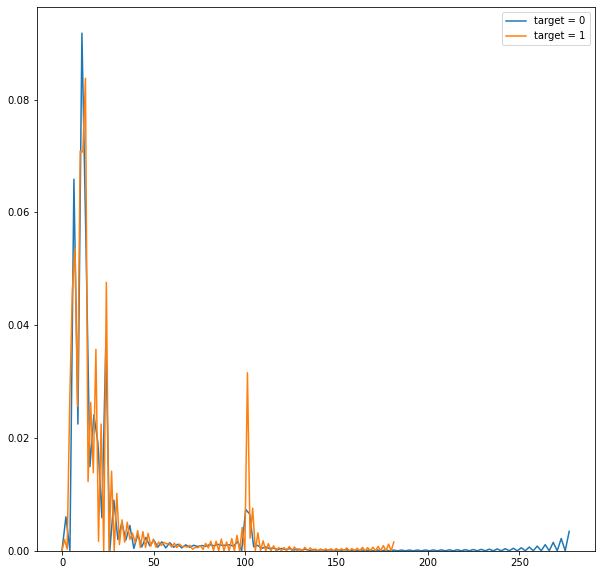

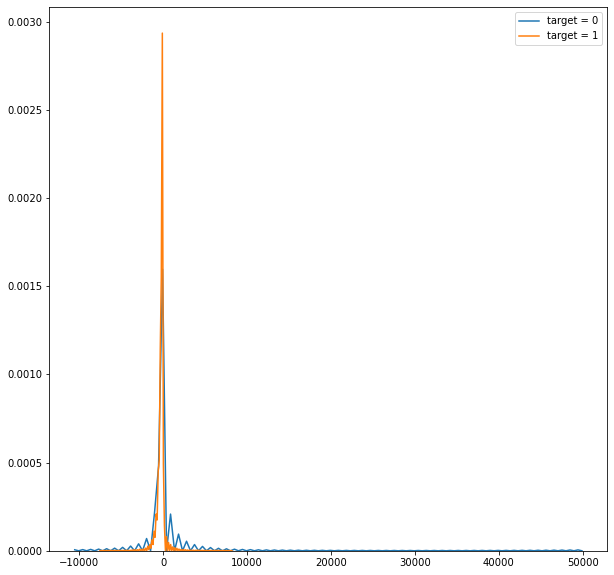

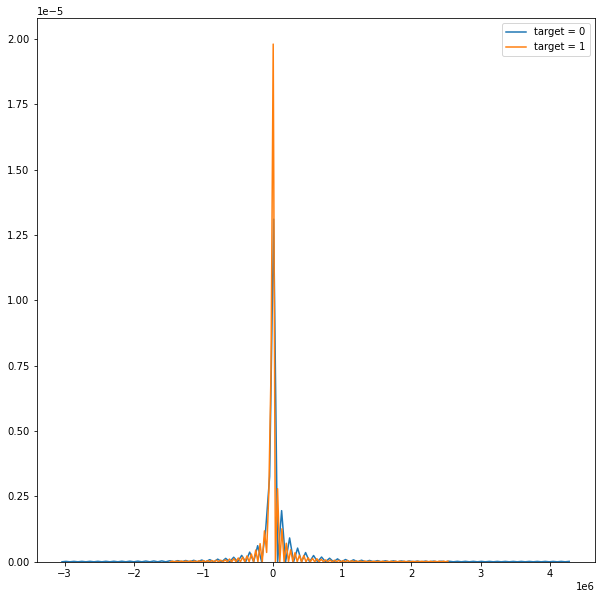

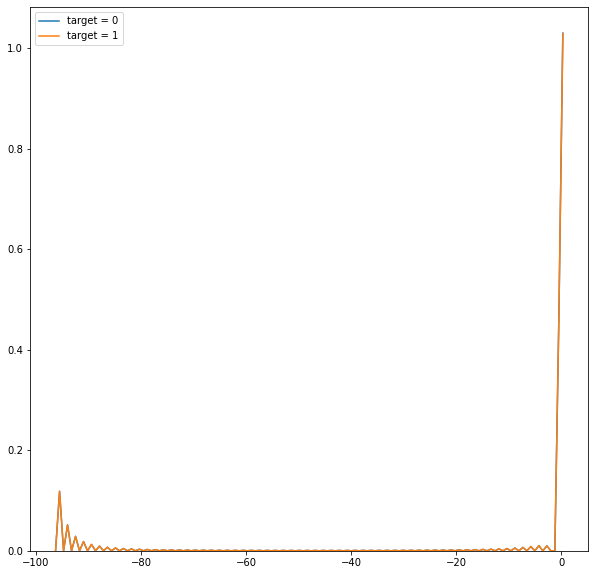

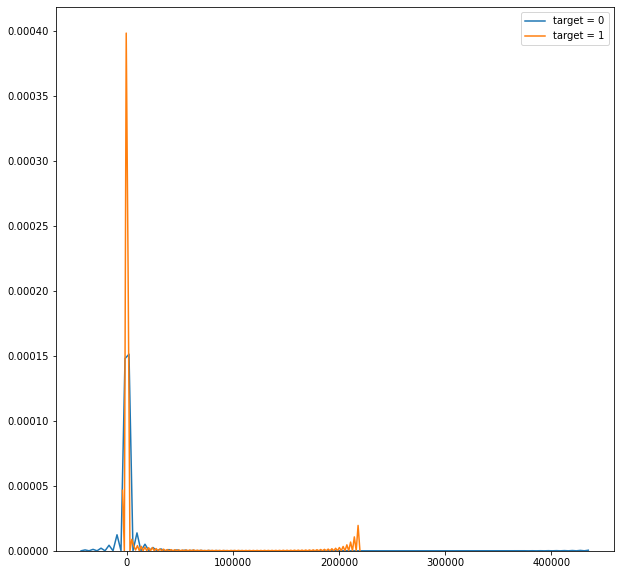

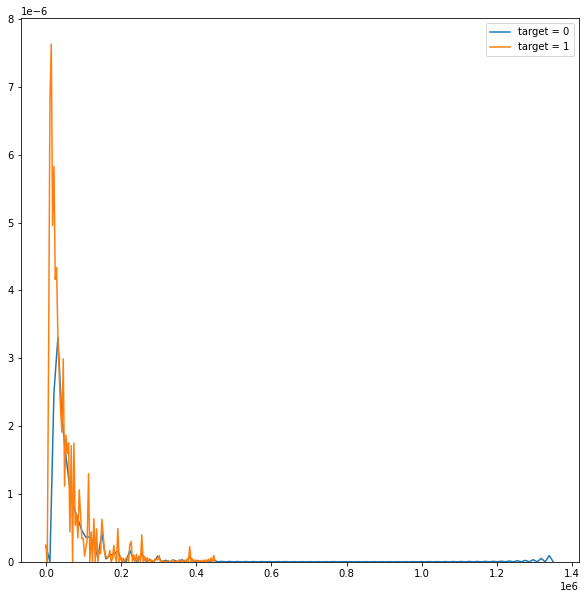

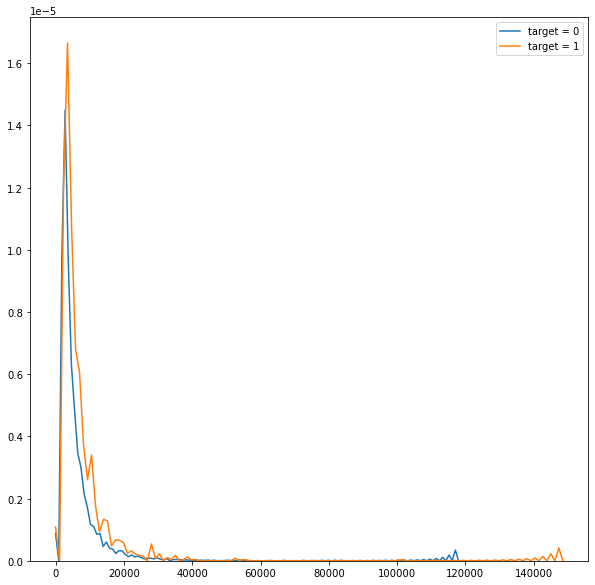

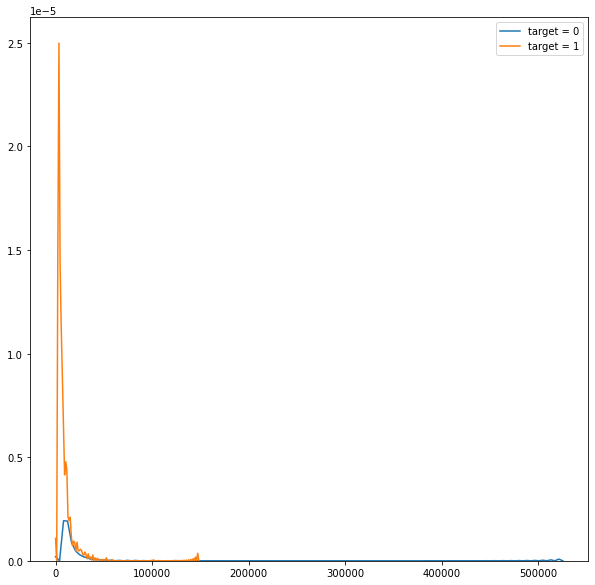

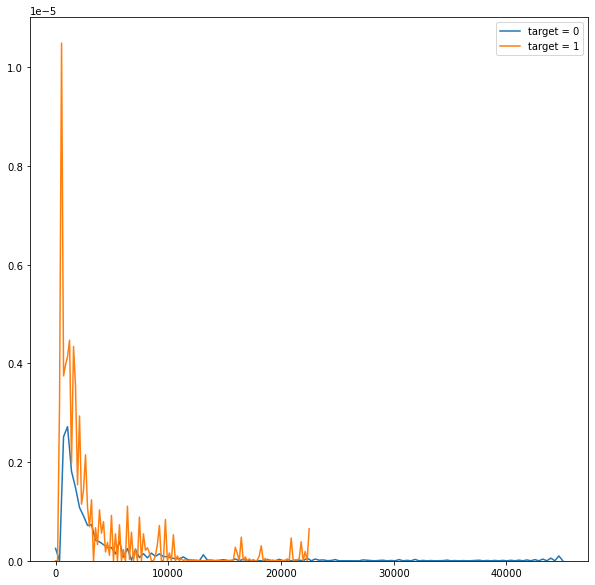

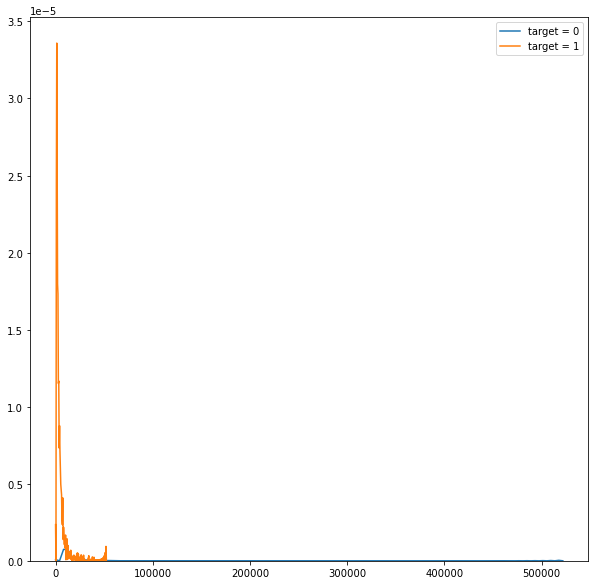

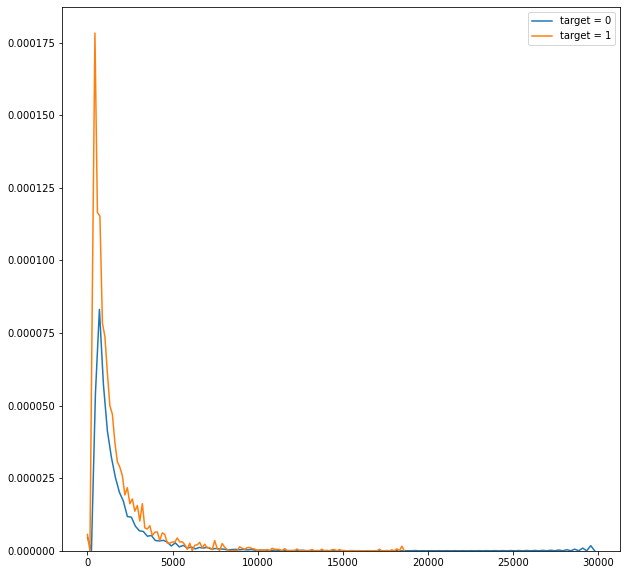

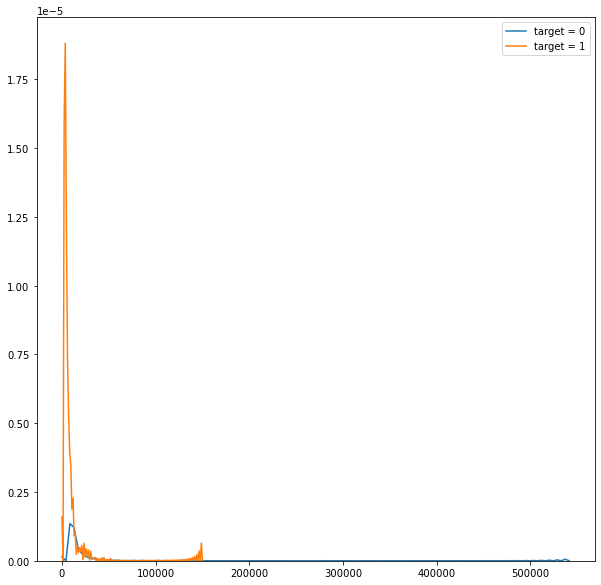

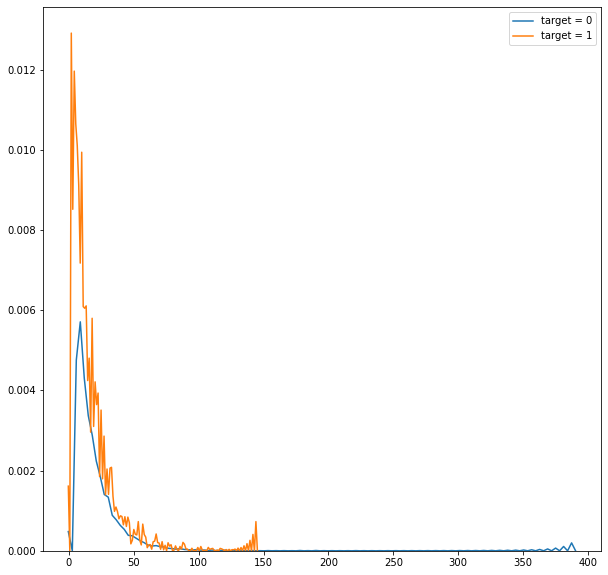

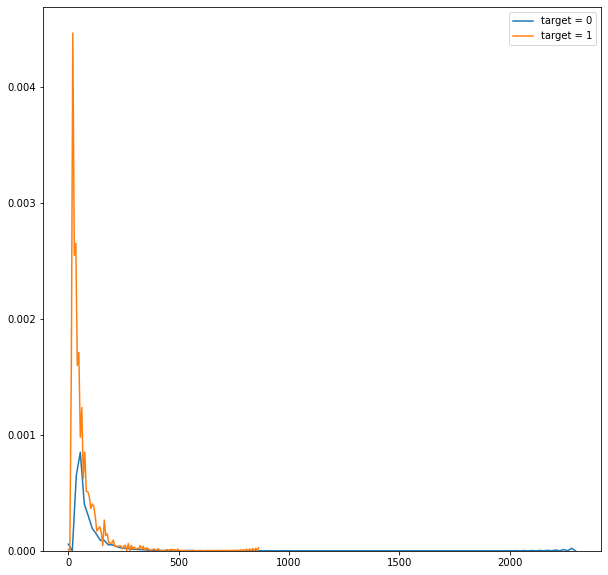

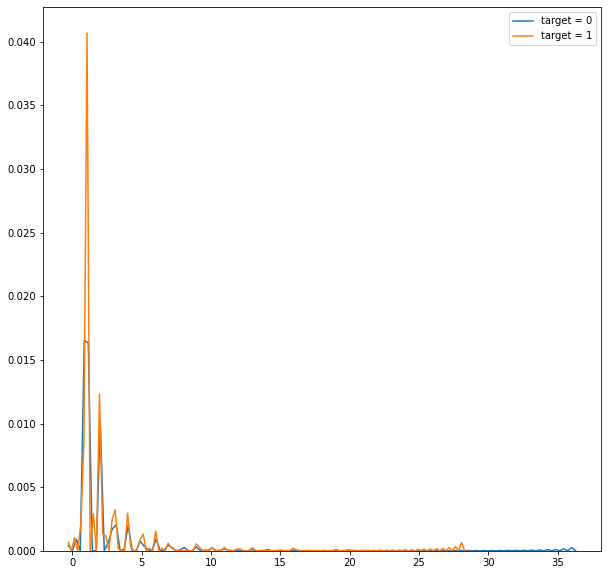

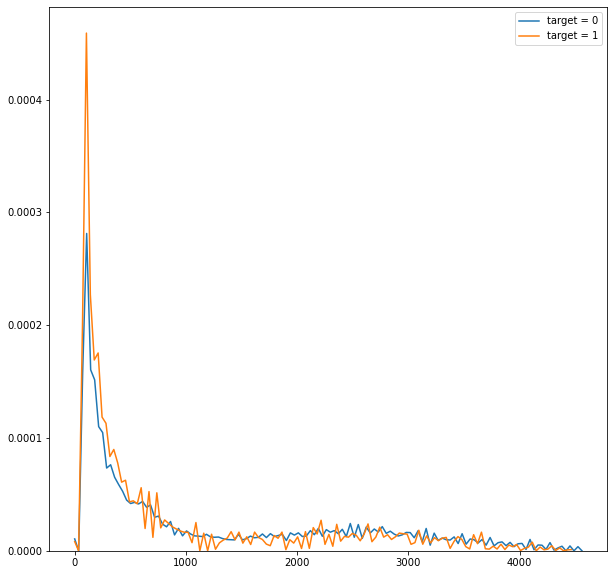

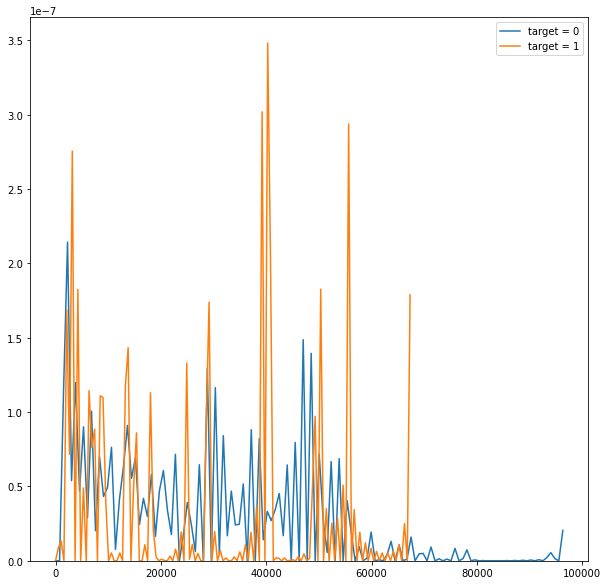

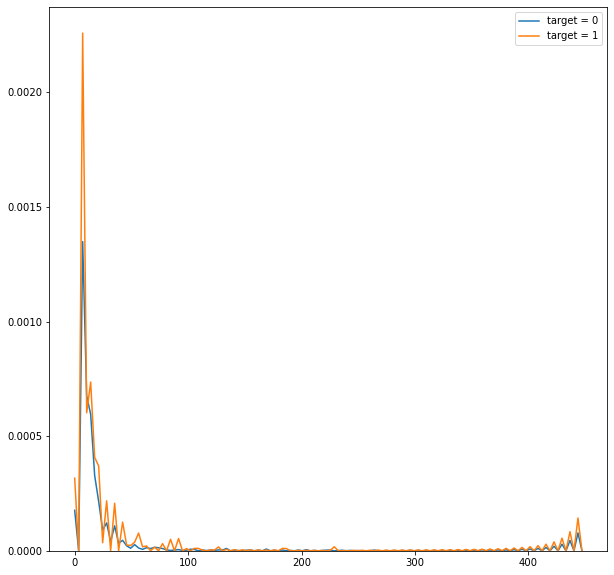

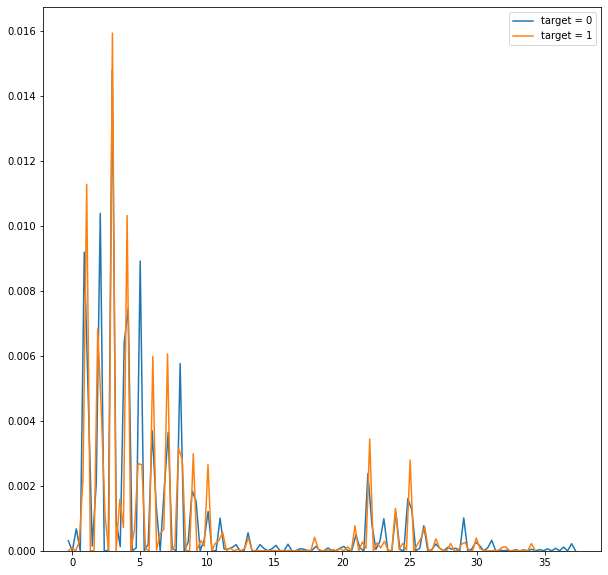

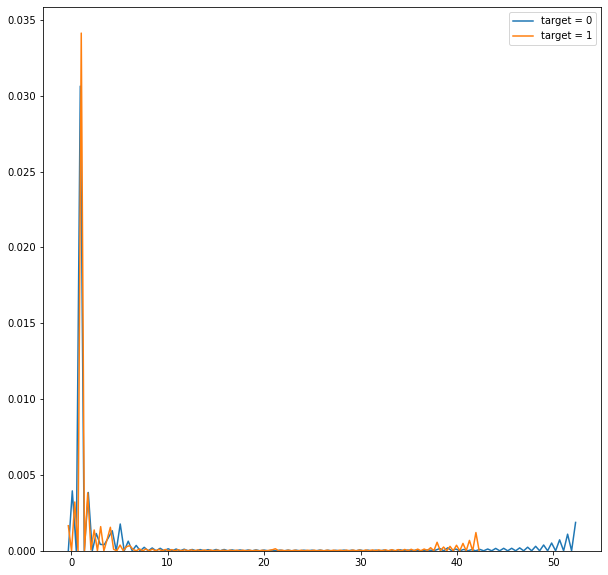

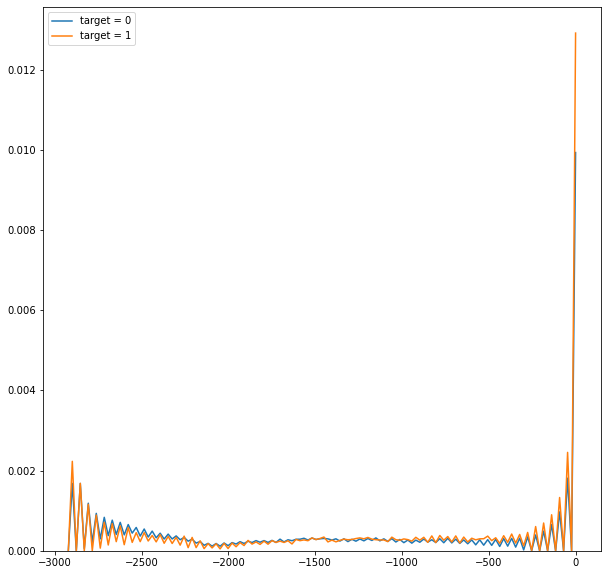

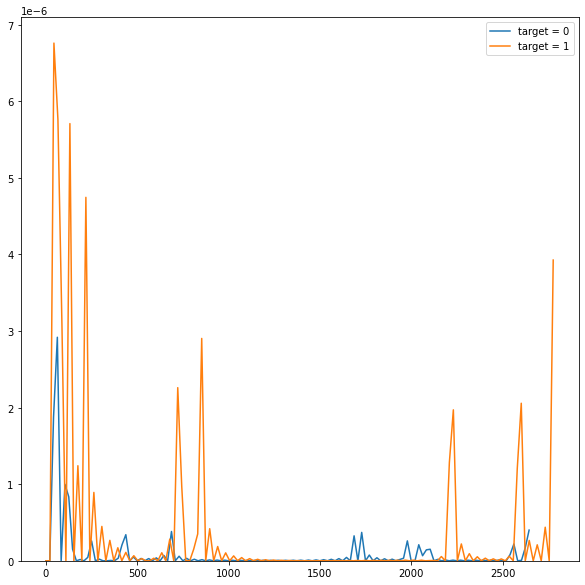

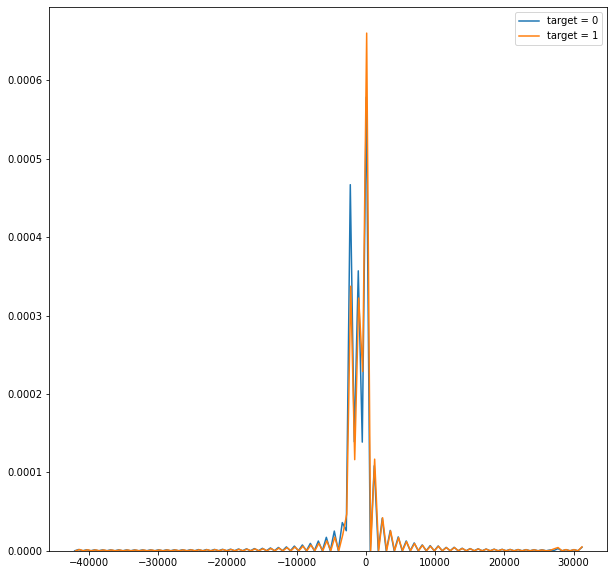

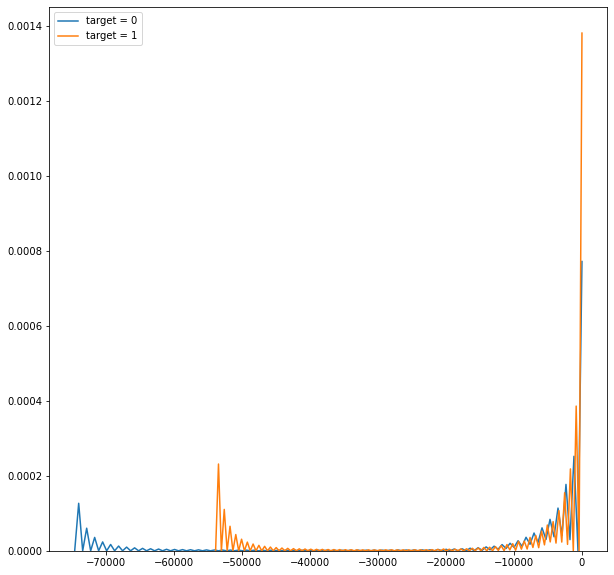

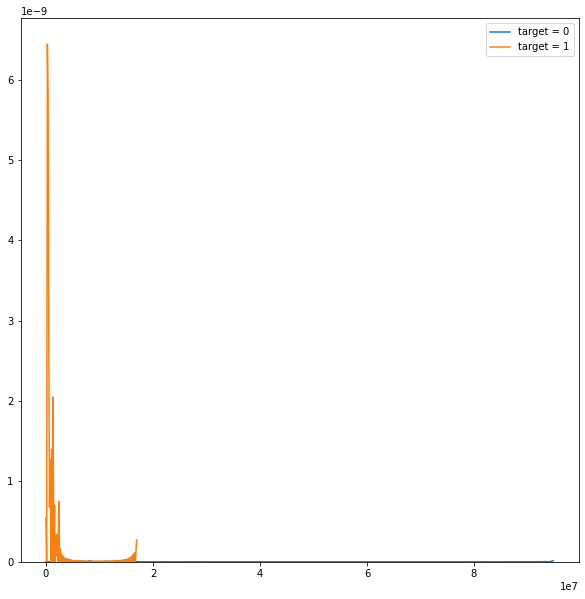

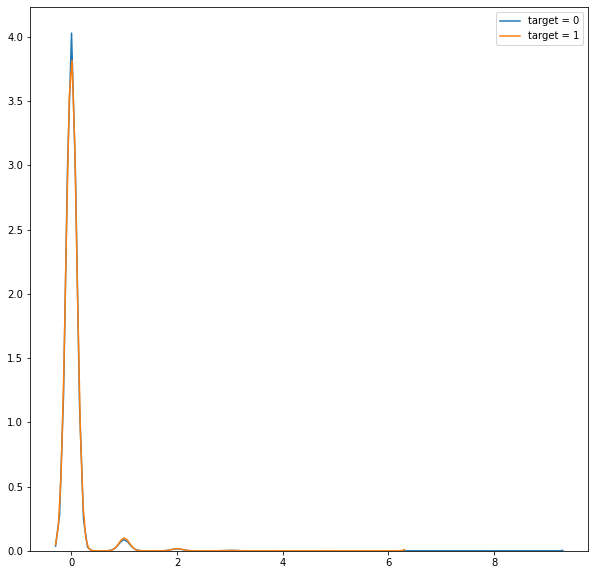

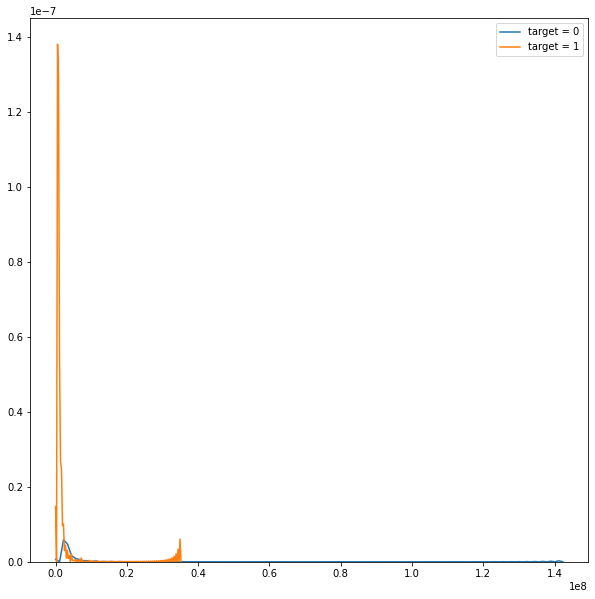

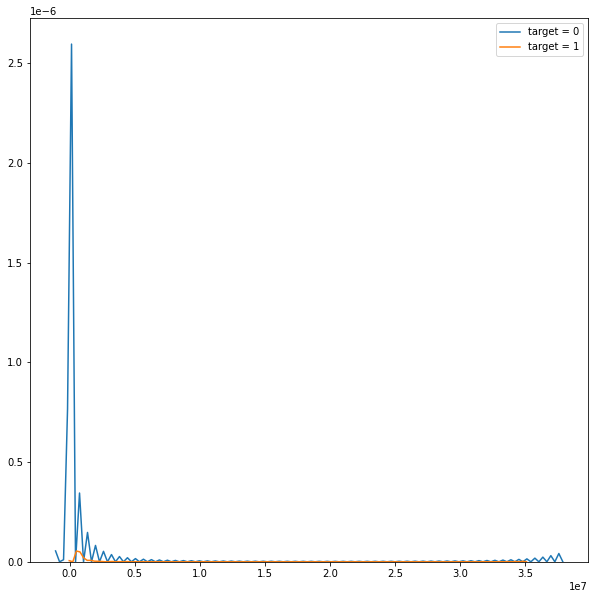

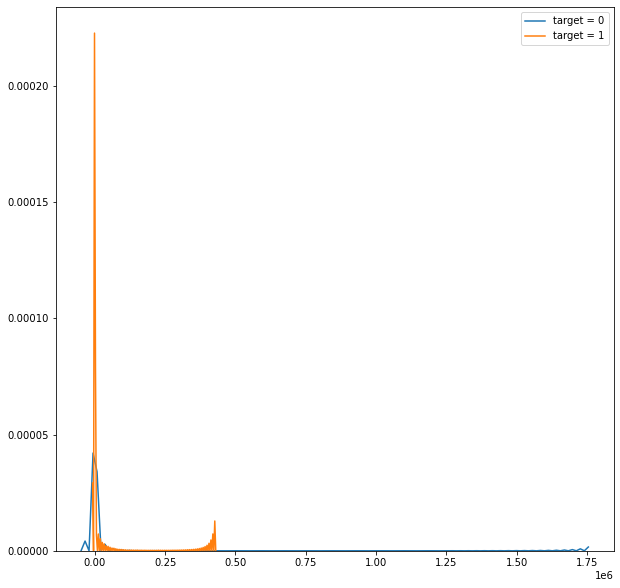

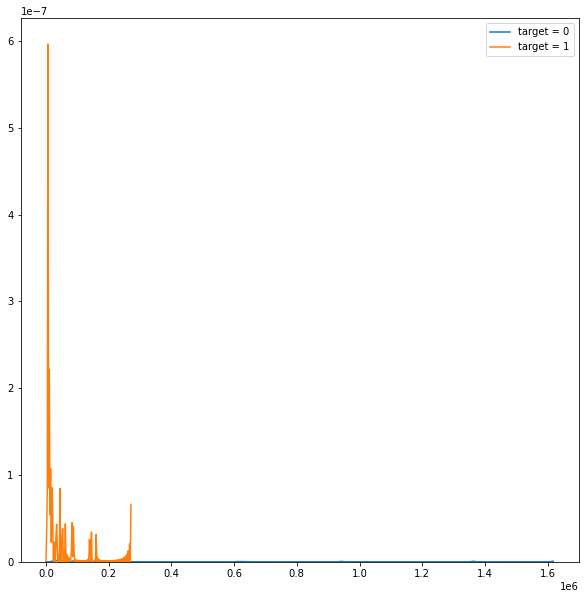

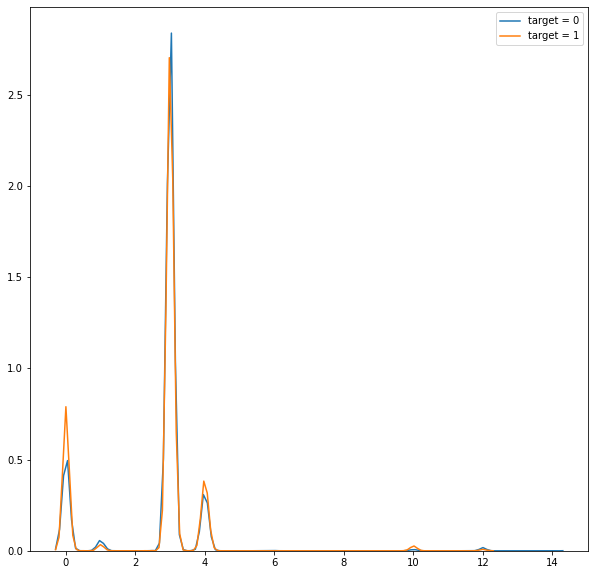

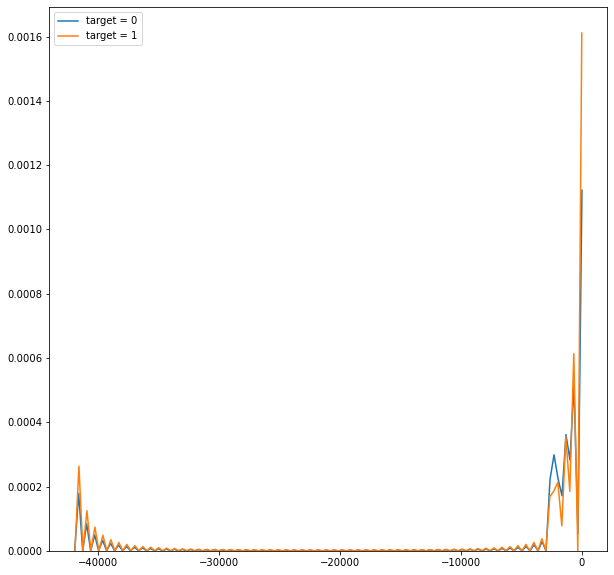

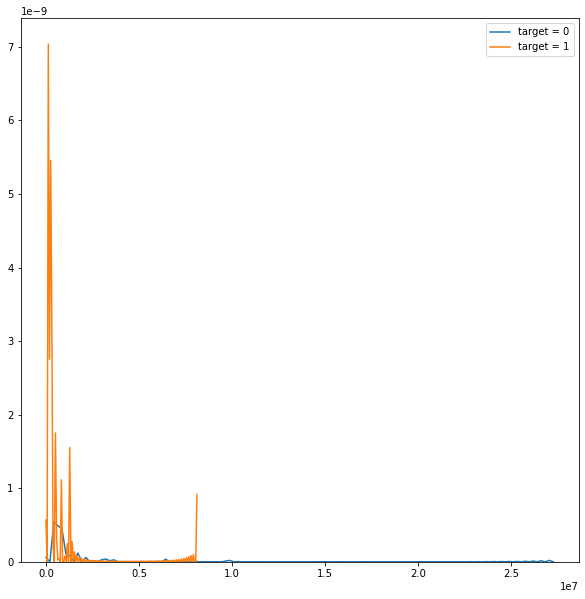

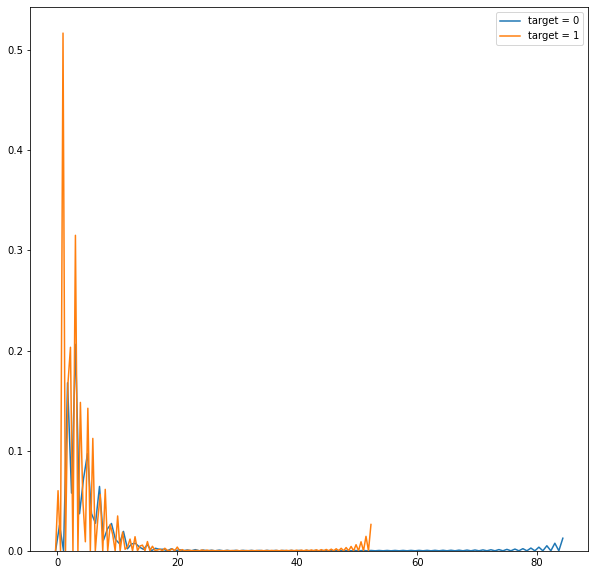

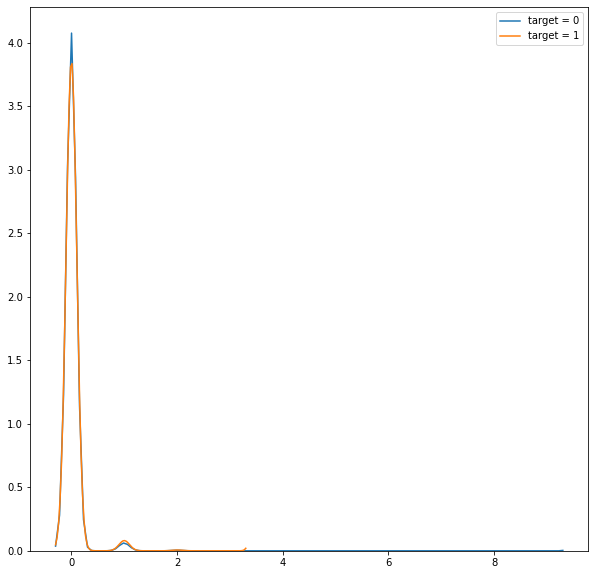

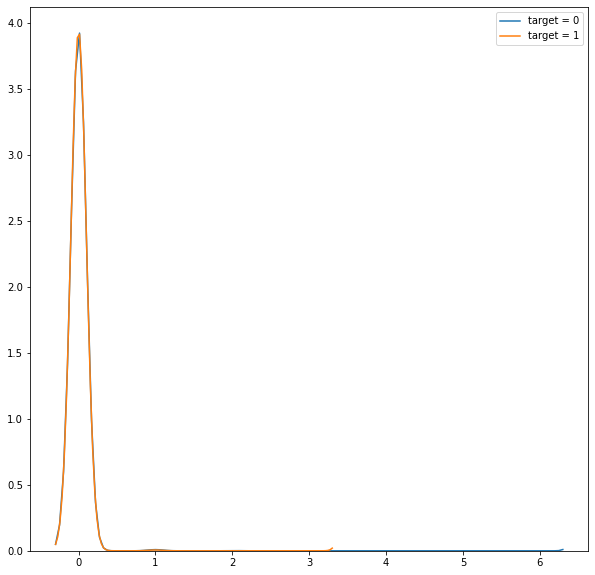

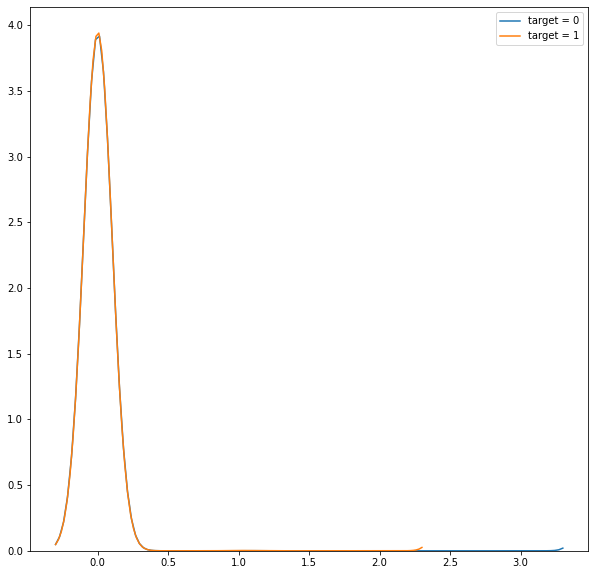

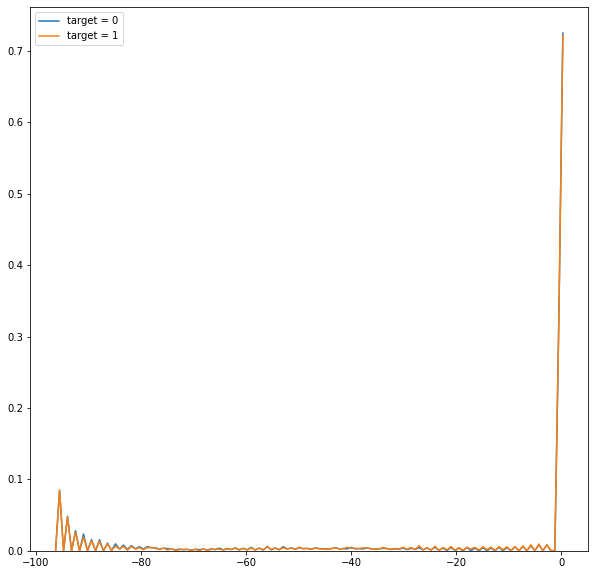

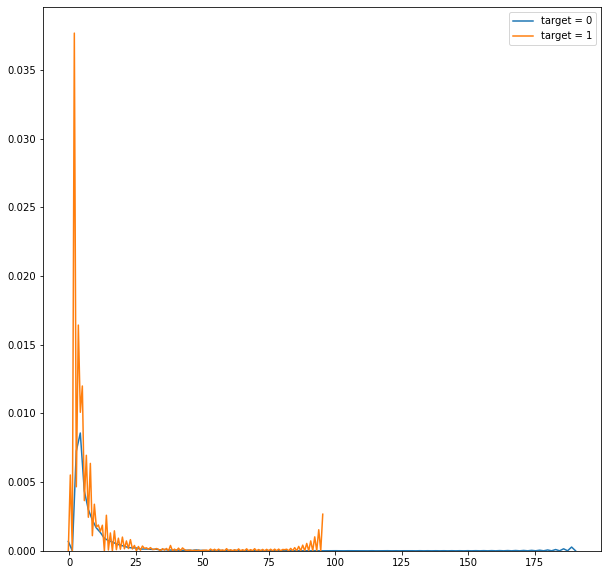

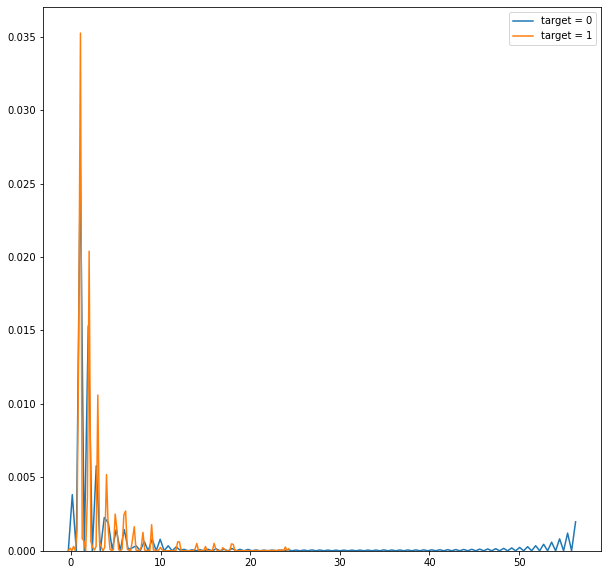

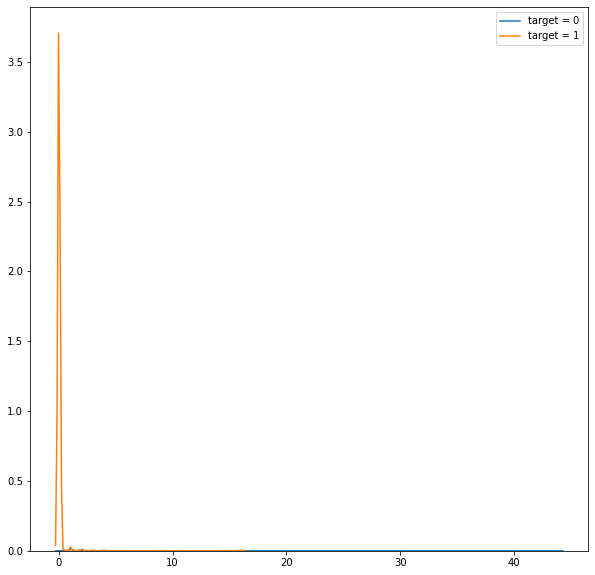

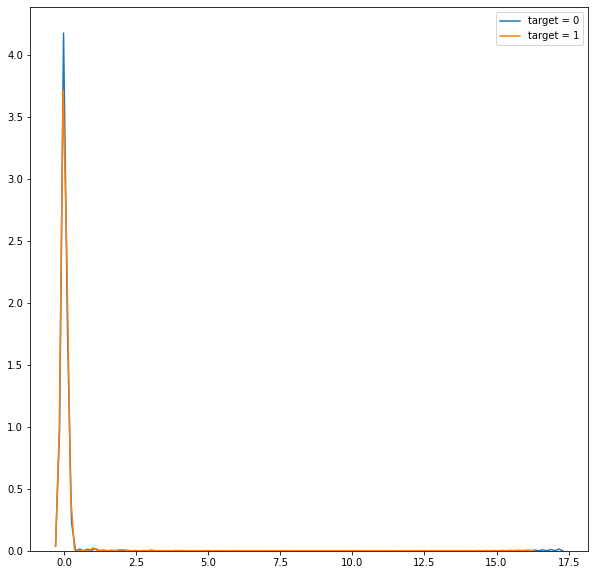

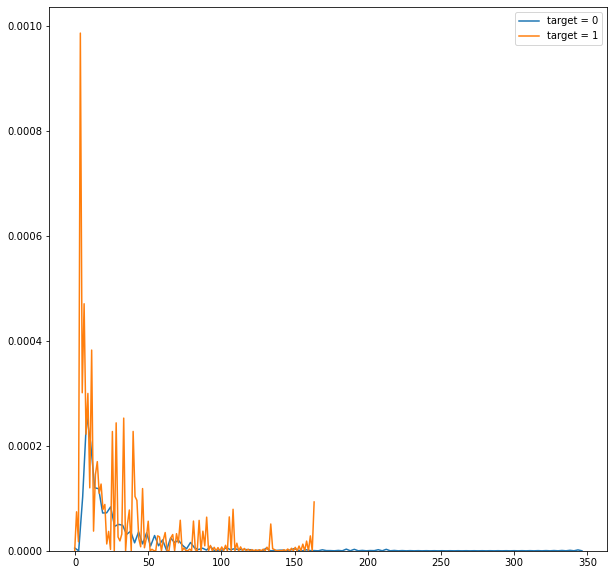

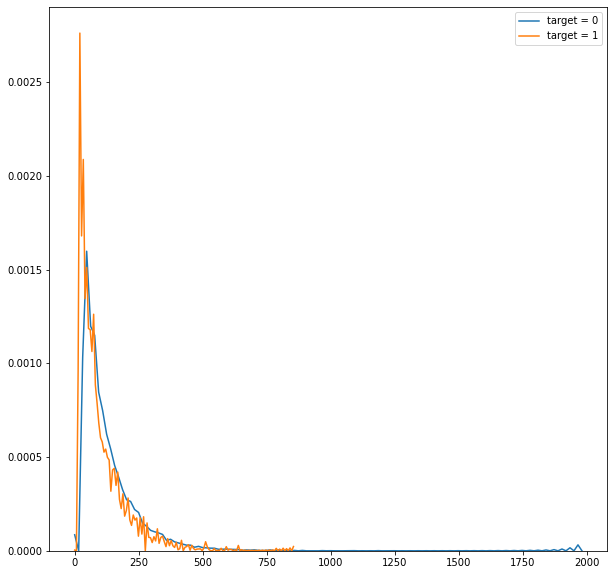

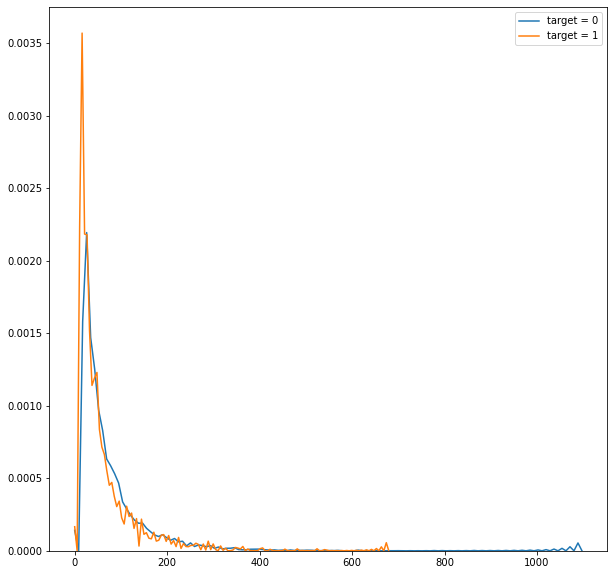

In [138]:
for i in X:
    if (len(X[i].unique())>3):
        plt.figure(figsize=(10,10))
        sns.kdeplot(X.loc[apptrain['TARGET'] == 0, i], label = 'target = 0',bw=0.1)
        sns.kdeplot(X.loc[apptrain['TARGET'] == 1, i], label = 'target = 1',bw=0.1)
        plt.legend()
        plt.show()

##### Creating new features by taking ratio of different combination of these features 

In [139]:
ratio=['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY_1',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY_2',
 'AMT_APPLICATION',
 'AMT_DOWN_PAYMENT',
 'RATE_DOWN_PAYMENT',
 'DAYS_CREDIT',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT']

In [140]:
for i in ratio:
    for j in ratio:
        if(i!=j):
            X[i+'by'+j]=X[i]/X[j]
            Y[i+'by'+j]=Y[i]/Y[j]

In [141]:
X = X.fillna(0)
Y = Y.fillna(0)

In [142]:
col = list(X.columns[X.max()>1e10])
col1= list(X.columns[X.min()<-1e10])

In [143]:
for i in col1:
    if(i not in col):
        col.append(i)
col.append('AMT_CREDIT_SUM_DEBTbyDAYS_CREDIT')

In [144]:
X.drop(columns =col,axis=1,inplace = True)
Y.drop(columns =col,axis=1,inplace = True)

## OUTLIERS

In [145]:
def getrange(x):
    q1 = x.quantile(q=0.25)
    q3 = x.quantile(q=0.75)
    iqr = q3 - q1
    outlier_range = iqr*1.5
    lower_bound = q1 - outlier_range
    upper_bound = q3 + outlier_range
    return lower_bound,upper_bound

In [146]:
pd.set_option('mode.chained_assignment', None)
for i in X:
    print(i)
    if(X[i].max()>2 and not X[i].median()==0):
        minv,maxv=getrange(X[i])
        X[i].loc[X[i].astype('float64') > maxv]  = maxv
        X[i].loc[X[i].astype('float64') < minv]  = minv
        Y[i].loc[Y[i].astype('float64') > maxv]  = maxv
        Y[i].loc[Y[i].astype('float64') < minv]  = minv

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY_1
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
OBS_30_

##### Some more features

In [147]:
X['DAYS_BIRTH']=X['DAYS_BIRTH']/-365
Y['DAYS_BIRTH']=Y['DAYS_BIRTH']/-365

## Standardization

In [148]:
from sklearn.preprocessing import StandardScaler
for i in X:
    if X[i].max()>3 or X[i].min()<-3:
        print(i)
        scaler = StandardScaler()
        X[[i]]= scaler.fit_transform(X[[i]])
        Y[[i]]= scaler.transform(Y[[i]])

CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY_1
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
OCCUPATION_TYPE
CNT_FAM_MEMBERS
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
ORGANIZATION_TYPE
WALLSMATERIAL_MODE
OBS_30_CNT_SOCIAL_CIRCLE
DEF_30_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
DAYS_LAST_PHONE_CHANGE
AMT_REQ_CREDIT_BUREAU_DAY
AMT_REQ_CREDIT_BUREAU_WEEK
AMT_REQ_CREDIT_BUREAU_MON
AMT_REQ_CREDIT_BUREAU_QRT
AMT_REQ_CREDIT_BUREAU_YEAR
AMT_ANNUITY_2
AMT_APPLICATION
AMT_DOWN_PAYMENT
FLAG_LAST_APPL_PER_CONTRACT
NFLAG_LAST_APPL_IN_DAY
NAME_CASH_LOAN_PURPOSE
DAYS_DECISION
CODE_REJECT_REASON
NAME_CLIENT_TYPE
NAME_GOODS_CATEGORY
NAME_PORTFOLIO
CHANNEL_TYPE
SELLERPLACE_AREA
NAME_SELLER_INDUSTRY
CNT_PAYMENT
PRODUCT_COMBINATION
DAYS_FIRST_DRAWING
DAYS_FIRST_DUE
DAYS_LAST_DUE_1ST_VERSION
DAYS_LAST_DUE
NFLAG_INSURED_ON_APPROVAL
WEEKDAY_APPR_PROCESS_START_MONDAY
WEEKDAY_APPR_PROCESS_START_SA

##### Removing highly correlated columns 

In [149]:
upper = X.corr().abs().where(np.triu(np.ones(X.corr().shape), k=1).astype(np.bool))
to_drop_X = [column for column in upper.columns if any(upper[column] >= 0.90)]
X.drop(columns =to_drop_X,axis=1,inplace = True)
Y.drop(columns =to_drop_X,axis=1,inplace = True)

In [150]:
col=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']
for i in col:
    X[i+'_squared']=X[i]**2
    Y[i+'_squared']=Y[i]**2
    X[i+'_cubed']=X[i]**3
    Y[i+'_cubed']=Y[i]**3

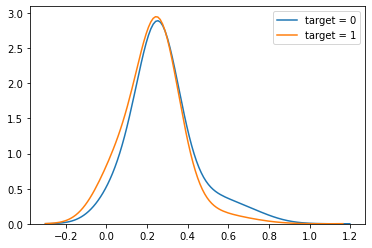

In [153]:
sns.kdeplot(X.loc[apptrain['TARGET'] == 0, 'EXT_SOURCE_1_squared'], label = 'target = 0',bw=0.1)
sns.kdeplot(X.loc[apptrain['TARGET'] == 1, 'EXT_SOURCE_1_squared'], label = 'target = 1',bw=0.1)
plt.legend()

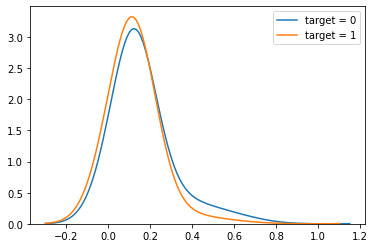

In [154]:
sns.kdeplot(X.loc[apptrain['TARGET'] == 0, 'EXT_SOURCE_1_cubed'], label = 'target = 0',bw=0.1)
sns.kdeplot(X.loc[apptrain['TARGET'] == 1, 'EXT_SOURCE_1_cubed'], label = 'target = 1',bw=0.1)
plt.legend()

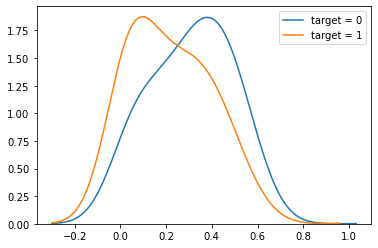

In [155]:
sns.kdeplot(X.loc[apptrain['TARGET'] == 0, 'EXT_SOURCE_2_squared'], label = 'target = 0',bw=0.1)
sns.kdeplot(X.loc[apptrain['TARGET'] == 1, 'EXT_SOURCE_2_squared'], label = 'target = 1',bw=0.1)
plt.legend()

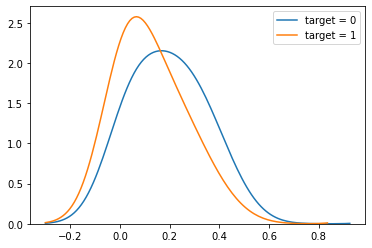

In [156]:
sns.kdeplot(X.loc[apptrain['TARGET'] == 0, 'EXT_SOURCE_2_cubed'], label = 'target = 0',bw=0.1)
sns.kdeplot(X.loc[apptrain['TARGET'] == 1, 'EXT_SOURCE_2_cubed'], label = 'target = 1',bw=0.1)
plt.legend()

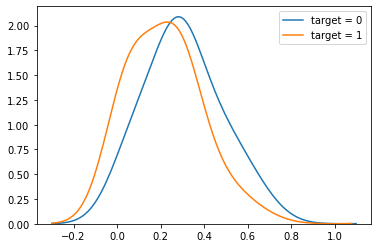

In [157]:
sns.kdeplot(X.loc[apptrain['TARGET'] == 0, 'EXT_SOURCE_3_squared'], label = 'target = 0',bw=0.1)
sns.kdeplot(X.loc[apptrain['TARGET'] == 1, 'EXT_SOURCE_3_squared'], label = 'target = 1',bw=0.1)
plt.legend()

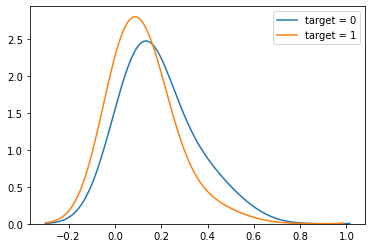

In [158]:
sns.kdeplot(X.loc[apptrain['TARGET'] == 0, 'EXT_SOURCE_3_cubed'], label = 'target = 0',bw=0.1)
sns.kdeplot(X.loc[apptrain['TARGET'] == 1, 'EXT_SOURCE_3_cubed'], label = 'target = 1',bw=0.1)
plt.legend()

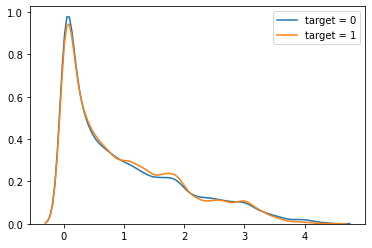

In [159]:
sns.kdeplot(X.loc[apptrain['TARGET'] == 0, 'DAYS_BIRTH_squared'], label = 'target = 0',bw=0.1)
sns.kdeplot(X.loc[apptrain['TARGET'] == 1, 'DAYS_BIRTH_squared'], label = 'target = 1',bw=0.1)
plt.legend()

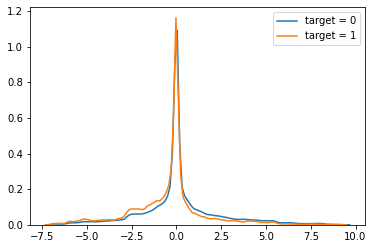

In [160]:
sns.kdeplot(X.loc[apptrain['TARGET'] == 0, 'DAYS_BIRTH_cubed'], label = 'target = 0',bw=0.1)
sns.kdeplot(X.loc[apptrain['TARGET'] == 1, 'DAYS_BIRTH_cubed'], label = 'target = 1',bw=0.1)
plt.legend()

##### Removing columns with very less correlation with TARGET

In [161]:
X['TARGET']=y
c=X.corr()['TARGET']

In [162]:
todrop=[]
for i in X:
    if(not (c[i]>0.005 or c[i]<-0.005)):
        todrop.append(i)
X.drop(columns =todrop,axis=1,inplace = True)
Y.drop(columns =todrop,axis=1,inplace = True)

# MODELS

In [163]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

In [164]:
trainX = X.drop(columns=['TARGET'],axis=1)
trainY = y
test_table = Y

In [184]:
import re
trainX = trainX.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_table = test_table.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [167]:
# USED TO FIND BEST PARAMETERS
# from optuna.integration.lightgbm import LightGBMTunerCV
# from lightgbm import Dataset
# train_file = Dataset(trainX, label=trainY,free_raw_data=False)
# params = {
#         "objective": "binary",
#         "metric": "binary_logloss",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#     }

# tuner = LightGBMTunerCV(
#         params, train_file, early_stopping_rounds=100, folds=KFold(n_splits=5)
#     )

# tuner.run()
    
# print("Best score:", tuner.best_score)
# best_params = tuner.best_params
# print("Best params:", best_params)
# print("  Params: ")
# for key, value in best_params.items():
#     print("    {}: {}".format(key, value))

In [185]:
model_svm = svm.SVC()
model_svm_linear = svm.LinearSVC()
model_svm_poly = svm.SVC(kernel='poly',probability=True)
model_svm_sigmoid = svm.SVC(kernel='sigmoid',probability=True)
model_svm_nusvc = svm.NuSVC(probability=True)
model_LR = LogisticRegression(max_iter=500,class_weight='balanced',solver='liblinear')
model_random_forest = RandomForestClassifier(random_state=0)
model_naive_bayes = GaussianNB()
model_lgbm = LGBMClassifier(verbosity = -1,
         feature_pre_filter = False,
         lambda_l1= 0.0007099817067951657,
         lambda_l2= 2.2721620492879536e-07,
         num_leaves= 64,
         feature_fraction= 0.4,
         bagging_fraction= 0.9938087600649544,
         bagging_freq= 1,
         min_child_samples= 20,
         learning_rate= 0.01,
         n_estimators= 1000,
         class_weight= 'balanced')
model_adaboost = AdaBoostClassifier(random_state=0,n_estimators=200)
model_catboost = CatBoostClassifier(thread_count=-1,random_state=0,border_count=5000,depth=4)
model_gb = GradientBoostingClassifier(random_state=0,learning_rate= 0.01,n_estimators= 1000,max_depth=6)
model_xgb = XGBClassifier(n_estimators= 1000,learning_rate= 0.1,scale_pos_weight=2)

In [186]:
level0 = []
level0.append(('LR',model_LR))
level0.append(('lgbm',model_lgbm))
level0.append(('rf',model_random_forest))
level0.append(('catboost',model_catboost))
level0.append(('xgb',model_xgb))
cv = StratifiedKFold(n_splits=5)
model_stack_final = StackingClassifier(estimators=level0,final_estimator=model_LR,cv=cv,stack_method='predict_proba',n_jobs=-1,verbose=3)

## Cross-Validation

In [170]:
cv = StratifiedKFold(n_splits=5)
scores = cross_val_score(model_catboost,trainX ,trainY,scoring='roc_auc', cv=cv, n_jobs=-1,verbose=11)
print('Mean ROC AUC: %.5f' % np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.2min remaining: 12.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  8.2min remaining:  5.4min


Mean ROC AUC: 0.77701


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.2min finished


Logistic Regression : 0.76094  
Random Forest : 0.75026      
Lightgbm : 0.77585  
Adaboost : 0.76586  
catboost : 0.77701  
XG Boost : 0.77570  
Gradient Boost : 0.77298  

## Ensemble check

Here we a taking a sample test to check different combinations for ensemble. For saving the runtime we have commented it for now. 

In [187]:
sample_trainX,sample_testX,sample_trainY,sample_testY = train_test_split(trainX,trainY,train_size=0.8,stratify=trainY)

Below we have defined two functions which will be using to train the models and predict the values.
* fit sample will simply train and predict
* fit_calb_sample will use CalibratedClassifierCV module with cv=5 and isotonic scaling

In [188]:
def fit_calb_sample(model,x,y,z):
    isotonic_prob = CalibratedClassifierCV(
    base_estimator=model,
    method='isotonic', cv=cv)
    isotonic_prob.fit(x,y)
    y_pred = isotonic_prob.predict_proba(z)
    y_final = [i[1] for i in y_pred]
    y_final = pd.DataFrame(y_final)
    return y_final

In [189]:
def fit_sample(model,x,y,z):
    model.fit(x,y)
    y_pred = model.predict_proba(z)
    y_final = [i[1] for i in y_pred]
    y_final = pd.DataFrame(y_final)
    return y_final

In [174]:
# y_sample_catboost = fit_calb_sample(model_catboost,sample_trainX,sample_trainY,sample_testX)

In [175]:
# y_sample_lgbm = fit_calb_sample(model_lgbm,sample_trainX,sample_trainY,sample_testX)

In [176]:
# y_sample_LR = fit_calb_sample(model_LR,sample_trainX,sample_trainY,sample_testX)

In [177]:
# y_sample_gb = fit_sample(model_gb,sample_trainX,sample_trainY,sample_testX)

In [178]:
# y_sample_xgb = fit_calb_sample(model_xgb,sample_trainX,sample_trainY,sample_testX)

In [179]:
# y_sample_rf = fit_sample(model_random_forest,sample_trainX,sample_trainY,sample_testX)

In [180]:
# y_ensemble = 0.4*y_sample_catboost + 0.1*y_sample_lgbm + 0.4*y_sample_xgb + 0.1*y_sample_rf

In [181]:
# roc_auc_score(sample_testY,y_ensemble)

catboost : 0.7748506305010502    
Lightgbm : 0.7725437722585644  
Logistic Regression : 0.7593572296015061  
XGB : 0.7616103340646833  
Random Forest : 0.7191983841223095  
### Without calibration
cat:lgbm:LR = 5:5:0 = 0.7748948144469693  
cat:lgbm:LR = 8:2:0 = 0.7759271738530747  
cat:lgbm:LR:xgb = 5:1:0:4 = 0.7759566717531883  
cat:lgbm:LR:xgb = 5:2:0:3 = 0.7764404389924968  
cat:lgbm:LR:xgb = 6:1:0:3 = 0.7766554876586641  
cat:lgbm:LR:xgb = 7:1:0:2 = 0.7769492756726465  
cat:lgbm:LR:xgb:rf = 6:1:0:2:1 = 0.7772929090151405  
### With calibration
cat:lgbm:LR:xgb:rf = 5:1:0:3:1 = 0.7789411765238718     
cat:lgbm:LR:xgb:rf = 4:1:0:4:1 = 0.779104207568059    

# Final Submission

In [190]:
model_svm = svm.SVC()
model_svm_linear = svm.LinearSVC()
model_svm_poly = svm.SVC(kernel='poly',probability=True)
model_svm_sigmoid = svm.SVC(kernel='sigmoid',probability=True)
model_svm_nusvc = svm.NuSVC(probability=True)
model_LR = LogisticRegression(max_iter=500,class_weight='balanced',solver='liblinear')
model_random_forest = RandomForestClassifier(random_state=0)
model_naive_bayes = GaussianNB()
model_lgbm = LGBMClassifier(verbosity = -1,
         feature_pre_filter = False,
         lambda_l1= 0.0007099817067951657,
         lambda_l2= 2.2721620492879536e-07,
         num_leaves= 64,
         feature_fraction= 0.4,
         bagging_fraction= 0.9938087600649544,
         bagging_freq= 1,
         min_child_samples= 20,
         learning_rate= 0.01,
         n_estimators= 1000,
         class_weight= 'balanced')
model_adaboost = AdaBoostClassifier(random_state=0,n_estimators=200)
model_catboost = CatBoostClassifier(thread_count=-1,random_state=0,border_count=5000,depth=4)
model_gb = GradientBoostingClassifier(random_state=0,learning_rate= 0.01,n_estimators= 1000,max_depth=6)
model_xgb = XGBClassifier(n_estimators= 1000,learning_rate= 0.1,scale_pos_weight=2)

In [197]:
y_pred_cat = fit_calb_sample(model_catboost,trainX,trainY,test_table)
y_pred_cat.to_csv('Catboost_calibrated.csv',index=False)

Learning rate set to 0.089946
0:	learn: 0.6041724	total: 164ms	remaining: 2m 44s
1:	learn: 0.5318711	total: 300ms	remaining: 2m 29s
2:	learn: 0.4761359	total: 428ms	remaining: 2m 22s
3:	learn: 0.4349914	total: 551ms	remaining: 2m 17s
4:	learn: 0.4006494	total: 664ms	remaining: 2m 12s
5:	learn: 0.3714367	total: 781ms	remaining: 2m 9s
6:	learn: 0.3496696	total: 909ms	remaining: 2m 8s
7:	learn: 0.3323785	total: 1.03s	remaining: 2m 7s
8:	learn: 0.3196745	total: 1.15s	remaining: 2m 6s
9:	learn: 0.3080261	total: 1.27s	remaining: 2m 6s
10:	learn: 0.2988167	total: 1.4s	remaining: 2m 6s
11:	learn: 0.2916458	total: 1.53s	remaining: 2m 5s
12:	learn: 0.2858001	total: 1.65s	remaining: 2m 5s
13:	learn: 0.2812124	total: 1.77s	remaining: 2m 4s
14:	learn: 0.2767743	total: 1.89s	remaining: 2m 3s
15:	learn: 0.2732460	total: 2.02s	remaining: 2m 4s
16:	learn: 0.2707313	total: 2.13s	remaining: 2m 3s
17:	learn: 0.2684807	total: 2.26s	remaining: 2m 3s
18:	learn: 0.2661904	total: 2.38s	remaining: 2m 2s
19:	lea

159:	learn: 0.2417603	total: 20.2s	remaining: 1m 45s
160:	learn: 0.2417123	total: 20.3s	remaining: 1m 45s
161:	learn: 0.2416881	total: 20.4s	remaining: 1m 45s
162:	learn: 0.2416539	total: 20.5s	remaining: 1m 45s
163:	learn: 0.2416136	total: 20.7s	remaining: 1m 45s
164:	learn: 0.2415801	total: 20.8s	remaining: 1m 45s
165:	learn: 0.2415482	total: 20.9s	remaining: 1m 44s
166:	learn: 0.2414941	total: 21s	remaining: 1m 44s
167:	learn: 0.2414562	total: 21.1s	remaining: 1m 44s
168:	learn: 0.2414188	total: 21.3s	remaining: 1m 44s
169:	learn: 0.2413870	total: 21.4s	remaining: 1m 44s
170:	learn: 0.2413374	total: 21.5s	remaining: 1m 44s
171:	learn: 0.2413023	total: 21.6s	remaining: 1m 44s
172:	learn: 0.2412650	total: 21.7s	remaining: 1m 43s
173:	learn: 0.2412289	total: 21.9s	remaining: 1m 43s
174:	learn: 0.2411698	total: 22s	remaining: 1m 43s
175:	learn: 0.2411377	total: 22.1s	remaining: 1m 43s
176:	learn: 0.2410849	total: 22.2s	remaining: 1m 43s
177:	learn: 0.2410309	total: 22.3s	remaining: 1m 4

315:	learn: 0.2364961	total: 39.3s	remaining: 1m 25s
316:	learn: 0.2364647	total: 39.4s	remaining: 1m 24s
317:	learn: 0.2364404	total: 39.6s	remaining: 1m 24s
318:	learn: 0.2364100	total: 39.7s	remaining: 1m 24s
319:	learn: 0.2363698	total: 39.8s	remaining: 1m 24s
320:	learn: 0.2363466	total: 39.9s	remaining: 1m 24s
321:	learn: 0.2363128	total: 40.1s	remaining: 1m 24s
322:	learn: 0.2362895	total: 40.4s	remaining: 1m 24s
323:	learn: 0.2362681	total: 40.5s	remaining: 1m 24s
324:	learn: 0.2362458	total: 40.7s	remaining: 1m 24s
325:	learn: 0.2362134	total: 40.9s	remaining: 1m 24s
326:	learn: 0.2361853	total: 41s	remaining: 1m 24s
327:	learn: 0.2361694	total: 41.2s	remaining: 1m 24s
328:	learn: 0.2361427	total: 41.3s	remaining: 1m 24s
329:	learn: 0.2361030	total: 41.4s	remaining: 1m 24s
330:	learn: 0.2360620	total: 41.6s	remaining: 1m 24s
331:	learn: 0.2360382	total: 41.7s	remaining: 1m 23s
332:	learn: 0.2360182	total: 41.8s	remaining: 1m 23s
333:	learn: 0.2360004	total: 41.9s	remaining: 1m

472:	learn: 0.2325411	total: 59.2s	remaining: 1m 5s
473:	learn: 0.2325150	total: 59.3s	remaining: 1m 5s
474:	learn: 0.2324871	total: 59.4s	remaining: 1m 5s
475:	learn: 0.2324746	total: 59.6s	remaining: 1m 5s
476:	learn: 0.2324621	total: 59.7s	remaining: 1m 5s
477:	learn: 0.2324469	total: 59.8s	remaining: 1m 5s
478:	learn: 0.2324152	total: 59.9s	remaining: 1m 5s
479:	learn: 0.2323959	total: 1m	remaining: 1m 5s
480:	learn: 0.2323697	total: 1m	remaining: 1m 4s
481:	learn: 0.2323387	total: 1m	remaining: 1m 4s
482:	learn: 0.2323055	total: 1m	remaining: 1m 4s
483:	learn: 0.2322794	total: 1m	remaining: 1m 4s
484:	learn: 0.2322466	total: 1m	remaining: 1m 4s
485:	learn: 0.2322283	total: 1m	remaining: 1m 4s
486:	learn: 0.2322019	total: 1m	remaining: 1m 4s
487:	learn: 0.2321418	total: 1m 1s	remaining: 1m 4s
488:	learn: 0.2321149	total: 1m 1s	remaining: 1m 3s
489:	learn: 0.2320884	total: 1m 1s	remaining: 1m 3s
490:	learn: 0.2320636	total: 1m 1s	remaining: 1m 3s
491:	learn: 0.2320346	total: 1m 1s	r

630:	learn: 0.2291216	total: 1m 18s	remaining: 46s
631:	learn: 0.2291003	total: 1m 18s	remaining: 45.8s
632:	learn: 0.2290697	total: 1m 18s	remaining: 45.7s
633:	learn: 0.2290511	total: 1m 18s	remaining: 45.6s
634:	learn: 0.2290265	total: 1m 19s	remaining: 45.5s
635:	learn: 0.2289991	total: 1m 19s	remaining: 45.3s
636:	learn: 0.2289729	total: 1m 19s	remaining: 45.2s
637:	learn: 0.2289641	total: 1m 19s	remaining: 45.1s
638:	learn: 0.2289403	total: 1m 19s	remaining: 45s
639:	learn: 0.2289103	total: 1m 19s	remaining: 44.8s
640:	learn: 0.2288823	total: 1m 19s	remaining: 44.7s
641:	learn: 0.2288615	total: 1m 19s	remaining: 44.6s
642:	learn: 0.2288509	total: 1m 20s	remaining: 44.5s
643:	learn: 0.2288325	total: 1m 20s	remaining: 44.3s
644:	learn: 0.2288066	total: 1m 20s	remaining: 44.2s
645:	learn: 0.2287833	total: 1m 20s	remaining: 44.1s
646:	learn: 0.2287594	total: 1m 20s	remaining: 43.9s
647:	learn: 0.2287437	total: 1m 20s	remaining: 43.8s
648:	learn: 0.2287199	total: 1m 20s	remaining: 43.

786:	learn: 0.2258888	total: 1m 37s	remaining: 26.5s
787:	learn: 0.2258758	total: 1m 38s	remaining: 26.4s
788:	learn: 0.2258591	total: 1m 38s	remaining: 26.2s
789:	learn: 0.2258462	total: 1m 38s	remaining: 26.1s
790:	learn: 0.2258323	total: 1m 38s	remaining: 26s
791:	learn: 0.2258295	total: 1m 38s	remaining: 25.9s
792:	learn: 0.2258134	total: 1m 38s	remaining: 25.7s
793:	learn: 0.2257981	total: 1m 38s	remaining: 25.6s
794:	learn: 0.2257806	total: 1m 38s	remaining: 25.5s
795:	learn: 0.2257661	total: 1m 38s	remaining: 25.4s
796:	learn: 0.2257386	total: 1m 39s	remaining: 25.2s
797:	learn: 0.2257222	total: 1m 39s	remaining: 25.1s
798:	learn: 0.2257119	total: 1m 39s	remaining: 25s
799:	learn: 0.2257035	total: 1m 39s	remaining: 24.9s
800:	learn: 0.2256873	total: 1m 39s	remaining: 24.7s
801:	learn: 0.2256700	total: 1m 39s	remaining: 24.6s
802:	learn: 0.2256512	total: 1m 39s	remaining: 24.5s
803:	learn: 0.2256352	total: 1m 39s	remaining: 24.4s
804:	learn: 0.2256162	total: 1m 40s	remaining: 24.

943:	learn: 0.2232623	total: 1m 57s	remaining: 6.98s
944:	learn: 0.2232390	total: 1m 57s	remaining: 6.86s
945:	learn: 0.2232239	total: 1m 57s	remaining: 6.73s
946:	learn: 0.2232076	total: 1m 58s	remaining: 6.61s
947:	learn: 0.2231873	total: 1m 58s	remaining: 6.48s
948:	learn: 0.2231740	total: 1m 58s	remaining: 6.36s
949:	learn: 0.2231542	total: 1m 58s	remaining: 6.23s
950:	learn: 0.2231407	total: 1m 58s	remaining: 6.11s
951:	learn: 0.2231175	total: 1m 58s	remaining: 5.99s
952:	learn: 0.2230942	total: 1m 58s	remaining: 5.86s
953:	learn: 0.2230765	total: 1m 58s	remaining: 5.74s
954:	learn: 0.2230755	total: 1m 59s	remaining: 5.61s
955:	learn: 0.2230588	total: 1m 59s	remaining: 5.49s
956:	learn: 0.2230417	total: 1m 59s	remaining: 5.36s
957:	learn: 0.2230196	total: 1m 59s	remaining: 5.24s
958:	learn: 0.2229996	total: 1m 59s	remaining: 5.11s
959:	learn: 0.2229756	total: 1m 59s	remaining: 4.99s
960:	learn: 0.2229597	total: 1m 59s	remaining: 4.86s
961:	learn: 0.2229557	total: 1m 59s	remaining:

103:	learn: 0.2450983	total: 13.2s	remaining: 1m 54s
104:	learn: 0.2450418	total: 13.4s	remaining: 1m 53s
105:	learn: 0.2449642	total: 13.5s	remaining: 1m 53s
106:	learn: 0.2449084	total: 13.6s	remaining: 1m 53s
107:	learn: 0.2448495	total: 13.8s	remaining: 1m 53s
108:	learn: 0.2447390	total: 13.9s	remaining: 1m 53s
109:	learn: 0.2446755	total: 14.1s	remaining: 1m 53s
110:	learn: 0.2446094	total: 14.2s	remaining: 1m 53s
111:	learn: 0.2445679	total: 14.3s	remaining: 1m 53s
112:	learn: 0.2445405	total: 14.4s	remaining: 1m 53s
113:	learn: 0.2444742	total: 14.6s	remaining: 1m 53s
114:	learn: 0.2444235	total: 14.7s	remaining: 1m 52s
115:	learn: 0.2443447	total: 14.8s	remaining: 1m 52s
116:	learn: 0.2442699	total: 14.9s	remaining: 1m 52s
117:	learn: 0.2441830	total: 15s	remaining: 1m 52s
118:	learn: 0.2441146	total: 15.2s	remaining: 1m 52s
119:	learn: 0.2440744	total: 15.3s	remaining: 1m 52s
120:	learn: 0.2440188	total: 15.4s	remaining: 1m 51s
121:	learn: 0.2439831	total: 15.5s	remaining: 1m

260:	learn: 0.2383821	total: 33s	remaining: 1m 33s
261:	learn: 0.2383545	total: 33.2s	remaining: 1m 33s
262:	learn: 0.2383226	total: 33.4s	remaining: 1m 33s
263:	learn: 0.2382965	total: 33.5s	remaining: 1m 33s
264:	learn: 0.2382500	total: 33.7s	remaining: 1m 33s
265:	learn: 0.2382145	total: 33.9s	remaining: 1m 33s
266:	learn: 0.2381883	total: 34s	remaining: 1m 33s
267:	learn: 0.2381717	total: 34.2s	remaining: 1m 33s
268:	learn: 0.2381440	total: 34.3s	remaining: 1m 33s
269:	learn: 0.2381132	total: 34.4s	remaining: 1m 33s
270:	learn: 0.2380790	total: 34.6s	remaining: 1m 32s
271:	learn: 0.2380437	total: 34.7s	remaining: 1m 32s
272:	learn: 0.2380408	total: 34.8s	remaining: 1m 32s
273:	learn: 0.2379984	total: 34.9s	remaining: 1m 32s
274:	learn: 0.2379604	total: 35.1s	remaining: 1m 32s
275:	learn: 0.2379394	total: 35.2s	remaining: 1m 32s
276:	learn: 0.2379062	total: 35.3s	remaining: 1m 32s
277:	learn: 0.2378671	total: 35.4s	remaining: 1m 32s
278:	learn: 0.2378346	total: 35.6s	remaining: 1m 3

416:	learn: 0.2340577	total: 52.6s	remaining: 1m 13s
417:	learn: 0.2340311	total: 52.7s	remaining: 1m 13s
418:	learn: 0.2340186	total: 52.8s	remaining: 1m 13s
419:	learn: 0.2339906	total: 53s	remaining: 1m 13s
420:	learn: 0.2339576	total: 53.1s	remaining: 1m 12s
421:	learn: 0.2339207	total: 53.2s	remaining: 1m 12s
422:	learn: 0.2338850	total: 53.3s	remaining: 1m 12s
423:	learn: 0.2338538	total: 53.5s	remaining: 1m 12s
424:	learn: 0.2338238	total: 53.6s	remaining: 1m 12s
425:	learn: 0.2338003	total: 53.7s	remaining: 1m 12s
426:	learn: 0.2337710	total: 53.8s	remaining: 1m 12s
427:	learn: 0.2337526	total: 53.9s	remaining: 1m 12s
428:	learn: 0.2337198	total: 54s	remaining: 1m 11s
429:	learn: 0.2336983	total: 54.2s	remaining: 1m 11s
430:	learn: 0.2336680	total: 54.3s	remaining: 1m 11s
431:	learn: 0.2336392	total: 54.4s	remaining: 1m 11s
432:	learn: 0.2336134	total: 54.5s	remaining: 1m 11s
433:	learn: 0.2335908	total: 54.6s	remaining: 1m 11s
434:	learn: 0.2335678	total: 54.8s	remaining: 1m 1

576:	learn: 0.2304214	total: 1m 12s	remaining: 53.2s
577:	learn: 0.2304075	total: 1m 12s	remaining: 53s
578:	learn: 0.2303922	total: 1m 12s	remaining: 52.9s
579:	learn: 0.2303709	total: 1m 12s	remaining: 52.8s
580:	learn: 0.2303461	total: 1m 12s	remaining: 52.6s
581:	learn: 0.2303223	total: 1m 13s	remaining: 52.5s
582:	learn: 0.2303037	total: 1m 13s	remaining: 52.4s
583:	learn: 0.2302781	total: 1m 13s	remaining: 52.2s
584:	learn: 0.2302694	total: 1m 13s	remaining: 52.1s
585:	learn: 0.2302642	total: 1m 13s	remaining: 52s
586:	learn: 0.2302322	total: 1m 13s	remaining: 51.9s
587:	learn: 0.2302031	total: 1m 13s	remaining: 51.7s
588:	learn: 0.2301786	total: 1m 13s	remaining: 51.6s
589:	learn: 0.2301499	total: 1m 14s	remaining: 51.5s
590:	learn: 0.2301243	total: 1m 14s	remaining: 51.4s
591:	learn: 0.2300987	total: 1m 14s	remaining: 51.2s
592:	learn: 0.2300877	total: 1m 14s	remaining: 51.1s
593:	learn: 0.2300714	total: 1m 14s	remaining: 51s
594:	learn: 0.2300576	total: 1m 14s	remaining: 50.8s

732:	learn: 0.2272457	total: 1m 32s	remaining: 33.6s
733:	learn: 0.2272254	total: 1m 32s	remaining: 33.5s
734:	learn: 0.2272035	total: 1m 32s	remaining: 33.3s
735:	learn: 0.2271861	total: 1m 32s	remaining: 33.2s
736:	learn: 0.2271577	total: 1m 32s	remaining: 33.1s
737:	learn: 0.2271536	total: 1m 32s	remaining: 33s
738:	learn: 0.2271313	total: 1m 32s	remaining: 32.8s
739:	learn: 0.2271085	total: 1m 33s	remaining: 32.7s
740:	learn: 0.2270906	total: 1m 33s	remaining: 32.6s
741:	learn: 0.2270693	total: 1m 33s	remaining: 32.4s
742:	learn: 0.2270487	total: 1m 33s	remaining: 32.3s
743:	learn: 0.2270346	total: 1m 33s	remaining: 32.2s
744:	learn: 0.2270340	total: 1m 33s	remaining: 32s
745:	learn: 0.2270165	total: 1m 33s	remaining: 31.9s
746:	learn: 0.2269964	total: 1m 33s	remaining: 31.8s
747:	learn: 0.2269777	total: 1m 34s	remaining: 31.7s
748:	learn: 0.2269487	total: 1m 34s	remaining: 31.5s
749:	learn: 0.2269310	total: 1m 34s	remaining: 31.4s
750:	learn: 0.2269110	total: 1m 34s	remaining: 31.

888:	learn: 0.2240918	total: 1m 51s	remaining: 13.9s
889:	learn: 0.2240698	total: 1m 51s	remaining: 13.8s
890:	learn: 0.2240348	total: 1m 51s	remaining: 13.7s
891:	learn: 0.2240271	total: 1m 51s	remaining: 13.5s
892:	learn: 0.2240031	total: 1m 52s	remaining: 13.4s
893:	learn: 0.2239816	total: 1m 52s	remaining: 13.3s
894:	learn: 0.2239613	total: 1m 52s	remaining: 13.2s
895:	learn: 0.2239357	total: 1m 52s	remaining: 13s
896:	learn: 0.2239163	total: 1m 52s	remaining: 12.9s
897:	learn: 0.2238989	total: 1m 52s	remaining: 12.8s
898:	learn: 0.2238781	total: 1m 52s	remaining: 12.7s
899:	learn: 0.2238668	total: 1m 52s	remaining: 12.6s
900:	learn: 0.2238548	total: 1m 53s	remaining: 12.4s
901:	learn: 0.2238409	total: 1m 53s	remaining: 12.3s
902:	learn: 0.2238185	total: 1m 53s	remaining: 12.2s
903:	learn: 0.2238012	total: 1m 53s	remaining: 12s
904:	learn: 0.2237818	total: 1m 53s	remaining: 11.9s
905:	learn: 0.2237702	total: 1m 53s	remaining: 11.8s
906:	learn: 0.2237544	total: 1m 53s	remaining: 11.

47:	learn: 0.2509075	total: 6.11s	remaining: 2m 1s
48:	learn: 0.2507311	total: 6.28s	remaining: 2m 1s
49:	learn: 0.2505665	total: 6.44s	remaining: 2m 2s
50:	learn: 0.2504175	total: 6.61s	remaining: 2m 2s
51:	learn: 0.2502888	total: 6.73s	remaining: 2m 2s
52:	learn: 0.2501014	total: 6.87s	remaining: 2m 2s
53:	learn: 0.2499131	total: 7.01s	remaining: 2m 2s
54:	learn: 0.2497820	total: 7.14s	remaining: 2m 2s
55:	learn: 0.2496367	total: 7.27s	remaining: 2m 2s
56:	learn: 0.2494946	total: 7.39s	remaining: 2m 2s
57:	learn: 0.2493881	total: 7.51s	remaining: 2m 2s
58:	learn: 0.2492932	total: 7.63s	remaining: 2m 1s
59:	learn: 0.2492050	total: 7.75s	remaining: 2m 1s
60:	learn: 0.2491123	total: 7.87s	remaining: 2m 1s
61:	learn: 0.2489423	total: 8s	remaining: 2m
62:	learn: 0.2488124	total: 8.12s	remaining: 2m
63:	learn: 0.2487175	total: 8.24s	remaining: 2m
64:	learn: 0.2486368	total: 8.36s	remaining: 2m
65:	learn: 0.2485001	total: 8.48s	remaining: 2m
66:	learn: 0.2483840	total: 8.61s	remaining: 1m 5

204:	learn: 0.2406397	total: 26.5s	remaining: 1m 42s
205:	learn: 0.2406165	total: 26.6s	remaining: 1m 42s
206:	learn: 0.2405651	total: 26.8s	remaining: 1m 42s
207:	learn: 0.2405319	total: 26.9s	remaining: 1m 42s
208:	learn: 0.2405021	total: 27s	remaining: 1m 42s
209:	learn: 0.2404748	total: 27.1s	remaining: 1m 42s
210:	learn: 0.2404199	total: 27.3s	remaining: 1m 41s
211:	learn: 0.2403723	total: 27.4s	remaining: 1m 41s
212:	learn: 0.2403364	total: 27.5s	remaining: 1m 41s
213:	learn: 0.2403117	total: 27.6s	remaining: 1m 41s
214:	learn: 0.2402774	total: 27.7s	remaining: 1m 41s
215:	learn: 0.2402555	total: 27.8s	remaining: 1m 41s
216:	learn: 0.2402165	total: 28s	remaining: 1m 40s
217:	learn: 0.2401927	total: 28.1s	remaining: 1m 40s
218:	learn: 0.2401610	total: 28.2s	remaining: 1m 40s
219:	learn: 0.2401256	total: 28.3s	remaining: 1m 40s
220:	learn: 0.2400896	total: 28.4s	remaining: 1m 40s
221:	learn: 0.2400425	total: 28.6s	remaining: 1m 40s
222:	learn: 0.2399853	total: 28.7s	remaining: 1m 3

360:	learn: 0.2358523	total: 45.4s	remaining: 1m 20s
361:	learn: 0.2358365	total: 45.5s	remaining: 1m 20s
362:	learn: 0.2358119	total: 45.7s	remaining: 1m 20s
363:	learn: 0.2357930	total: 45.8s	remaining: 1m 20s
364:	learn: 0.2357758	total: 45.9s	remaining: 1m 19s
365:	learn: 0.2357459	total: 46s	remaining: 1m 19s
366:	learn: 0.2357141	total: 46.2s	remaining: 1m 19s
367:	learn: 0.2356923	total: 46.3s	remaining: 1m 19s
368:	learn: 0.2356531	total: 46.4s	remaining: 1m 19s
369:	learn: 0.2356321	total: 46.5s	remaining: 1m 19s
370:	learn: 0.2356119	total: 46.6s	remaining: 1m 19s
371:	learn: 0.2355887	total: 46.8s	remaining: 1m 18s
372:	learn: 0.2355540	total: 46.9s	remaining: 1m 18s
373:	learn: 0.2355312	total: 47s	remaining: 1m 18s
374:	learn: 0.2355119	total: 47.1s	remaining: 1m 18s
375:	learn: 0.2354882	total: 47.2s	remaining: 1m 18s
376:	learn: 0.2354697	total: 47.4s	remaining: 1m 18s
377:	learn: 0.2354363	total: 47.5s	remaining: 1m 18s
378:	learn: 0.2354104	total: 47.6s	remaining: 1m 1

518:	learn: 0.2321847	total: 1m 4s	remaining: 1m
519:	learn: 0.2321659	total: 1m 5s	remaining: 1m
520:	learn: 0.2321542	total: 1m 5s	remaining: 59.9s
521:	learn: 0.2321316	total: 1m 5s	remaining: 59.8s
522:	learn: 0.2321185	total: 1m 5s	remaining: 59.7s
523:	learn: 0.2320748	total: 1m 5s	remaining: 59.5s
524:	learn: 0.2320221	total: 1m 5s	remaining: 59.4s
525:	learn: 0.2319978	total: 1m 5s	remaining: 59.3s
526:	learn: 0.2319812	total: 1m 6s	remaining: 59.3s
527:	learn: 0.2319521	total: 1m 6s	remaining: 59.2s
528:	learn: 0.2319251	total: 1m 6s	remaining: 59.1s
529:	learn: 0.2318962	total: 1m 6s	remaining: 59s
530:	learn: 0.2318700	total: 1m 6s	remaining: 58.9s
531:	learn: 0.2318371	total: 1m 6s	remaining: 58.8s
532:	learn: 0.2318127	total: 1m 6s	remaining: 58.6s
533:	learn: 0.2317934	total: 1m 7s	remaining: 58.5s
534:	learn: 0.2317601	total: 1m 7s	remaining: 58.4s
535:	learn: 0.2317266	total: 1m 7s	remaining: 58.3s
536:	learn: 0.2316995	total: 1m 7s	remaining: 58.1s
537:	learn: 0.231669

676:	learn: 0.2288634	total: 1m 24s	remaining: 40.5s
677:	learn: 0.2288527	total: 1m 24s	remaining: 40.3s
678:	learn: 0.2288340	total: 1m 25s	remaining: 40.2s
679:	learn: 0.2287989	total: 1m 25s	remaining: 40.1s
680:	learn: 0.2287891	total: 1m 25s	remaining: 39.9s
681:	learn: 0.2287667	total: 1m 25s	remaining: 39.8s
682:	learn: 0.2287474	total: 1m 25s	remaining: 39.7s
683:	learn: 0.2287324	total: 1m 25s	remaining: 39.6s
684:	learn: 0.2287103	total: 1m 25s	remaining: 39.4s
685:	learn: 0.2287096	total: 1m 25s	remaining: 39.3s
686:	learn: 0.2286785	total: 1m 25s	remaining: 39.2s
687:	learn: 0.2286604	total: 1m 26s	remaining: 39.1s
688:	learn: 0.2286477	total: 1m 26s	remaining: 38.9s
689:	learn: 0.2286257	total: 1m 26s	remaining: 38.8s
690:	learn: 0.2286090	total: 1m 26s	remaining: 38.7s
691:	learn: 0.2285838	total: 1m 26s	remaining: 38.5s
692:	learn: 0.2285611	total: 1m 26s	remaining: 38.4s
693:	learn: 0.2285345	total: 1m 26s	remaining: 38.3s
694:	learn: 0.2285263	total: 1m 27s	remaining:

832:	learn: 0.2258911	total: 1m 44s	remaining: 20.9s
833:	learn: 0.2258734	total: 1m 44s	remaining: 20.7s
834:	learn: 0.2258522	total: 1m 44s	remaining: 20.6s
835:	learn: 0.2258338	total: 1m 44s	remaining: 20.5s
836:	learn: 0.2258135	total: 1m 44s	remaining: 20.4s
837:	learn: 0.2258009	total: 1m 44s	remaining: 20.2s
838:	learn: 0.2257814	total: 1m 44s	remaining: 20.1s
839:	learn: 0.2257594	total: 1m 44s	remaining: 20s
840:	learn: 0.2257398	total: 1m 45s	remaining: 19.9s
841:	learn: 0.2257215	total: 1m 45s	remaining: 19.7s
842:	learn: 0.2257038	total: 1m 45s	remaining: 19.6s
843:	learn: 0.2256803	total: 1m 45s	remaining: 19.5s
844:	learn: 0.2256674	total: 1m 45s	remaining: 19.4s
845:	learn: 0.2256498	total: 1m 45s	remaining: 19.2s
846:	learn: 0.2256260	total: 1m 45s	remaining: 19.1s
847:	learn: 0.2256167	total: 1m 45s	remaining: 19s
848:	learn: 0.2256026	total: 1m 46s	remaining: 18.9s
849:	learn: 0.2255804	total: 1m 46s	remaining: 18.7s
850:	learn: 0.2255574	total: 1m 46s	remaining: 18.

989:	learn: 0.2230926	total: 2m 3s	remaining: 1.25s
990:	learn: 0.2230712	total: 2m 3s	remaining: 1.12s
991:	learn: 0.2230523	total: 2m 3s	remaining: 999ms
992:	learn: 0.2230427	total: 2m 4s	remaining: 874ms
993:	learn: 0.2230288	total: 2m 4s	remaining: 749ms
994:	learn: 0.2230126	total: 2m 4s	remaining: 624ms
995:	learn: 0.2229907	total: 2m 4s	remaining: 499ms
996:	learn: 0.2229780	total: 2m 4s	remaining: 375ms
997:	learn: 0.2229547	total: 2m 4s	remaining: 250ms
998:	learn: 0.2229386	total: 2m 4s	remaining: 125ms
999:	learn: 0.2229192	total: 2m 4s	remaining: 0us
Learning rate set to 0.089947
0:	learn: 0.6040270	total: 121ms	remaining: 2m
1:	learn: 0.5337370	total: 285ms	remaining: 2m 22s
2:	learn: 0.4763852	total: 422ms	remaining: 2m 20s
3:	learn: 0.4341153	total: 554ms	remaining: 2m 17s
4:	learn: 0.4020620	total: 672ms	remaining: 2m 13s
5:	learn: 0.3732699	total: 797ms	remaining: 2m 12s
6:	learn: 0.3500372	total: 930ms	remaining: 2m 11s
7:	learn: 0.3332228	total: 1.05s	remaining: 2m 

149:	learn: 0.2428884	total: 19.2s	remaining: 1m 49s
150:	learn: 0.2428457	total: 19.4s	remaining: 1m 48s
151:	learn: 0.2428122	total: 19.5s	remaining: 1m 48s
152:	learn: 0.2427628	total: 19.6s	remaining: 1m 48s
153:	learn: 0.2427005	total: 19.7s	remaining: 1m 48s
154:	learn: 0.2426413	total: 19.9s	remaining: 1m 48s
155:	learn: 0.2425897	total: 20s	remaining: 1m 48s
156:	learn: 0.2425542	total: 20.1s	remaining: 1m 48s
157:	learn: 0.2425140	total: 20.2s	remaining: 1m 47s
158:	learn: 0.2424528	total: 20.4s	remaining: 1m 47s
159:	learn: 0.2424052	total: 20.5s	remaining: 1m 47s
160:	learn: 0.2423640	total: 20.6s	remaining: 1m 47s
161:	learn: 0.2422972	total: 20.7s	remaining: 1m 47s
162:	learn: 0.2422554	total: 20.9s	remaining: 1m 47s
163:	learn: 0.2421773	total: 21s	remaining: 1m 46s
164:	learn: 0.2421436	total: 21.1s	remaining: 1m 46s
165:	learn: 0.2420929	total: 21.2s	remaining: 1m 46s
166:	learn: 0.2420237	total: 21.3s	remaining: 1m 46s
167:	learn: 0.2419888	total: 21.5s	remaining: 1m 4

305:	learn: 0.2372362	total: 38.9s	remaining: 1m 28s
306:	learn: 0.2371963	total: 39.1s	remaining: 1m 28s
307:	learn: 0.2371726	total: 39.2s	remaining: 1m 28s
308:	learn: 0.2371542	total: 39.3s	remaining: 1m 27s
309:	learn: 0.2371303	total: 39.4s	remaining: 1m 27s
310:	learn: 0.2371067	total: 39.6s	remaining: 1m 27s
311:	learn: 0.2370825	total: 39.7s	remaining: 1m 27s
312:	learn: 0.2370646	total: 39.9s	remaining: 1m 27s
313:	learn: 0.2370402	total: 40s	remaining: 1m 27s
314:	learn: 0.2370174	total: 40.1s	remaining: 1m 27s
315:	learn: 0.2369704	total: 40.2s	remaining: 1m 27s
316:	learn: 0.2369431	total: 40.3s	remaining: 1m 26s
317:	learn: 0.2369237	total: 40.5s	remaining: 1m 26s
318:	learn: 0.2369018	total: 40.6s	remaining: 1m 26s
319:	learn: 0.2368996	total: 40.7s	remaining: 1m 26s
320:	learn: 0.2368713	total: 40.8s	remaining: 1m 26s
321:	learn: 0.2368450	total: 40.9s	remaining: 1m 26s
322:	learn: 0.2368232	total: 41.1s	remaining: 1m 26s
323:	learn: 0.2367992	total: 41.2s	remaining: 1m

462:	learn: 0.2332732	total: 59.2s	remaining: 1m 8s
463:	learn: 0.2332501	total: 59.3s	remaining: 1m 8s
464:	learn: 0.2332177	total: 59.4s	remaining: 1m 8s
465:	learn: 0.2331921	total: 59.5s	remaining: 1m 8s
466:	learn: 0.2331608	total: 59.7s	remaining: 1m 8s
467:	learn: 0.2331309	total: 59.8s	remaining: 1m 7s
468:	learn: 0.2331297	total: 59.9s	remaining: 1m 7s
469:	learn: 0.2331048	total: 1m	remaining: 1m 7s
470:	learn: 0.2330853	total: 1m	remaining: 1m 7s
471:	learn: 0.2330590	total: 1m	remaining: 1m 7s
472:	learn: 0.2330366	total: 1m	remaining: 1m 7s
473:	learn: 0.2330135	total: 1m	remaining: 1m 7s
474:	learn: 0.2329945	total: 1m	remaining: 1m 7s
475:	learn: 0.2329755	total: 1m	remaining: 1m 6s
476:	learn: 0.2329744	total: 1m	remaining: 1m 6s
477:	learn: 0.2329559	total: 1m 1s	remaining: 1m 6s
478:	learn: 0.2329313	total: 1m 1s	remaining: 1m 6s
479:	learn: 0.2329059	total: 1m 1s	remaining: 1m 6s
480:	learn: 0.2328736	total: 1m 1s	remaining: 1m 6s
481:	learn: 0.2328619	total: 1m 1s	r

620:	learn: 0.2298020	total: 1m 18s	remaining: 48s
621:	learn: 0.2297865	total: 1m 18s	remaining: 47.9s
622:	learn: 0.2297633	total: 1m 18s	remaining: 47.8s
623:	learn: 0.2297441	total: 1m 19s	remaining: 47.6s
624:	learn: 0.2297400	total: 1m 19s	remaining: 47.5s
625:	learn: 0.2297192	total: 1m 19s	remaining: 47.4s
626:	learn: 0.2297066	total: 1m 19s	remaining: 47.3s
627:	learn: 0.2296895	total: 1m 19s	remaining: 47.2s
628:	learn: 0.2296772	total: 1m 19s	remaining: 47.1s
629:	learn: 0.2296587	total: 1m 19s	remaining: 47s
630:	learn: 0.2296388	total: 1m 20s	remaining: 46.9s
631:	learn: 0.2296113	total: 1m 20s	remaining: 46.8s
632:	learn: 0.2295949	total: 1m 20s	remaining: 46.6s
633:	learn: 0.2295783	total: 1m 20s	remaining: 46.5s
634:	learn: 0.2295603	total: 1m 20s	remaining: 46.4s
635:	learn: 0.2295349	total: 1m 20s	remaining: 46.3s
636:	learn: 0.2295237	total: 1m 20s	remaining: 46.1s
637:	learn: 0.2294962	total: 1m 21s	remaining: 46s
638:	learn: 0.2294766	total: 1m 21s	remaining: 45.9s

776:	learn: 0.2266503	total: 1m 39s	remaining: 28.5s
777:	learn: 0.2266333	total: 1m 39s	remaining: 28.3s
778:	learn: 0.2266243	total: 1m 39s	remaining: 28.2s
779:	learn: 0.2266131	total: 1m 39s	remaining: 28.1s
780:	learn: 0.2265922	total: 1m 39s	remaining: 27.9s
781:	learn: 0.2265822	total: 1m 39s	remaining: 27.8s
782:	learn: 0.2265684	total: 1m 39s	remaining: 27.7s
783:	learn: 0.2265443	total: 1m 40s	remaining: 27.6s
784:	learn: 0.2265194	total: 1m 40s	remaining: 27.4s
785:	learn: 0.2265006	total: 1m 40s	remaining: 27.3s
786:	learn: 0.2264787	total: 1m 40s	remaining: 27.2s
787:	learn: 0.2264600	total: 1m 40s	remaining: 27.1s
788:	learn: 0.2264337	total: 1m 40s	remaining: 26.9s
789:	learn: 0.2264259	total: 1m 40s	remaining: 26.8s
790:	learn: 0.2264075	total: 1m 40s	remaining: 26.7s
791:	learn: 0.2263966	total: 1m 41s	remaining: 26.5s
792:	learn: 0.2263785	total: 1m 41s	remaining: 26.4s
793:	learn: 0.2263663	total: 1m 41s	remaining: 26.3s
794:	learn: 0.2263654	total: 1m 41s	remaining:

932:	learn: 0.2237774	total: 1m 59s	remaining: 8.59s
933:	learn: 0.2237585	total: 1m 59s	remaining: 8.46s
934:	learn: 0.2237266	total: 1m 59s	remaining: 8.33s
935:	learn: 0.2237020	total: 1m 59s	remaining: 8.2s
936:	learn: 0.2236838	total: 2m	remaining: 8.07s
937:	learn: 0.2236684	total: 2m	remaining: 7.94s
938:	learn: 0.2236473	total: 2m	remaining: 7.82s
939:	learn: 0.2236292	total: 2m	remaining: 7.69s
940:	learn: 0.2236070	total: 2m	remaining: 7.56s
941:	learn: 0.2235929	total: 2m	remaining: 7.43s
942:	learn: 0.2235861	total: 2m	remaining: 7.3s
943:	learn: 0.2235693	total: 2m	remaining: 7.18s
944:	learn: 0.2235675	total: 2m 1s	remaining: 7.05s
945:	learn: 0.2235591	total: 2m 1s	remaining: 6.92s
946:	learn: 0.2235455	total: 2m 1s	remaining: 6.79s
947:	learn: 0.2235269	total: 2m 1s	remaining: 6.66s
948:	learn: 0.2235148	total: 2m 1s	remaining: 6.53s
949:	learn: 0.2234970	total: 2m 1s	remaining: 6.4s
950:	learn: 0.2234819	total: 2m 1s	remaining: 6.28s
951:	learn: 0.2234633	total: 2m 1s	

93:	learn: 0.2459099	total: 12s	remaining: 1m 55s
94:	learn: 0.2458439	total: 12.1s	remaining: 1m 55s
95:	learn: 0.2457495	total: 12.2s	remaining: 1m 55s
96:	learn: 0.2457055	total: 12.3s	remaining: 1m 54s
97:	learn: 0.2456533	total: 12.5s	remaining: 1m 54s
98:	learn: 0.2455809	total: 12.6s	remaining: 1m 54s
99:	learn: 0.2455164	total: 12.7s	remaining: 1m 54s
100:	learn: 0.2454538	total: 12.8s	remaining: 1m 54s
101:	learn: 0.2453769	total: 13s	remaining: 1m 54s
102:	learn: 0.2452895	total: 13.1s	remaining: 1m 54s
103:	learn: 0.2452441	total: 13.2s	remaining: 1m 53s
104:	learn: 0.2451984	total: 13.3s	remaining: 1m 53s
105:	learn: 0.2451541	total: 13.5s	remaining: 1m 53s
106:	learn: 0.2451216	total: 13.6s	remaining: 1m 53s
107:	learn: 0.2450911	total: 13.7s	remaining: 1m 53s
108:	learn: 0.2450226	total: 13.8s	remaining: 1m 52s
109:	learn: 0.2449599	total: 13.9s	remaining: 1m 52s
110:	learn: 0.2448788	total: 14.1s	remaining: 1m 52s
111:	learn: 0.2448367	total: 14.2s	remaining: 1m 52s
112:

249:	learn: 0.2390091	total: 31.3s	remaining: 1m 33s
250:	learn: 0.2389847	total: 31.5s	remaining: 1m 33s
251:	learn: 0.2389587	total: 31.6s	remaining: 1m 33s
252:	learn: 0.2389443	total: 31.7s	remaining: 1m 33s
253:	learn: 0.2389265	total: 31.9s	remaining: 1m 33s
254:	learn: 0.2388896	total: 32s	remaining: 1m 33s
255:	learn: 0.2388656	total: 32.1s	remaining: 1m 33s
256:	learn: 0.2388424	total: 32.3s	remaining: 1m 33s
257:	learn: 0.2388098	total: 32.5s	remaining: 1m 33s
258:	learn: 0.2387844	total: 32.6s	remaining: 1m 33s
259:	learn: 0.2387550	total: 32.8s	remaining: 1m 33s
260:	learn: 0.2387191	total: 32.9s	remaining: 1m 33s
261:	learn: 0.2386819	total: 33s	remaining: 1m 33s
262:	learn: 0.2386616	total: 33.2s	remaining: 1m 32s
263:	learn: 0.2386374	total: 33.4s	remaining: 1m 33s
264:	learn: 0.2386155	total: 33.5s	remaining: 1m 32s
265:	learn: 0.2385873	total: 33.6s	remaining: 1m 32s
266:	learn: 0.2385629	total: 33.8s	remaining: 1m 32s
267:	learn: 0.2385133	total: 33.9s	remaining: 1m 3

406:	learn: 0.2348163	total: 51.4s	remaining: 1m 14s
407:	learn: 0.2347864	total: 51.5s	remaining: 1m 14s
408:	learn: 0.2347539	total: 51.6s	remaining: 1m 14s
409:	learn: 0.2347284	total: 51.7s	remaining: 1m 14s
410:	learn: 0.2347000	total: 51.9s	remaining: 1m 14s
411:	learn: 0.2346790	total: 52s	remaining: 1m 14s
412:	learn: 0.2346473	total: 52.1s	remaining: 1m 14s
413:	learn: 0.2346154	total: 52.2s	remaining: 1m 13s
414:	learn: 0.2345887	total: 52.3s	remaining: 1m 13s
415:	learn: 0.2345720	total: 52.5s	remaining: 1m 13s
416:	learn: 0.2345497	total: 52.6s	remaining: 1m 13s
417:	learn: 0.2345196	total: 52.7s	remaining: 1m 13s
418:	learn: 0.2344984	total: 52.8s	remaining: 1m 13s
419:	learn: 0.2344750	total: 53s	remaining: 1m 13s
420:	learn: 0.2344582	total: 53.1s	remaining: 1m 12s
421:	learn: 0.2344346	total: 53.2s	remaining: 1m 12s
422:	learn: 0.2343975	total: 53.3s	remaining: 1m 12s
423:	learn: 0.2343642	total: 53.5s	remaining: 1m 12s
424:	learn: 0.2343471	total: 53.6s	remaining: 1m 1

566:	learn: 0.2313081	total: 1m 11s	remaining: 54.5s
567:	learn: 0.2312938	total: 1m 11s	remaining: 54.4s
568:	learn: 0.2312729	total: 1m 11s	remaining: 54.3s
569:	learn: 0.2312460	total: 1m 11s	remaining: 54.2s
570:	learn: 0.2312259	total: 1m 11s	remaining: 54s
571:	learn: 0.2311996	total: 1m 12s	remaining: 53.9s
572:	learn: 0.2311844	total: 1m 12s	remaining: 53.8s
573:	learn: 0.2311594	total: 1m 12s	remaining: 53.7s
574:	learn: 0.2311367	total: 1m 12s	remaining: 53.5s
575:	learn: 0.2311131	total: 1m 12s	remaining: 53.4s
576:	learn: 0.2310856	total: 1m 12s	remaining: 53.3s
577:	learn: 0.2310726	total: 1m 12s	remaining: 53.2s
578:	learn: 0.2310620	total: 1m 12s	remaining: 53s
579:	learn: 0.2310310	total: 1m 13s	remaining: 52.9s
580:	learn: 0.2310061	total: 1m 13s	remaining: 52.8s
581:	learn: 0.2309922	total: 1m 13s	remaining: 52.7s
582:	learn: 0.2309783	total: 1m 13s	remaining: 52.5s
583:	learn: 0.2309576	total: 1m 13s	remaining: 52.4s
584:	learn: 0.2309496	total: 1m 13s	remaining: 52.

722:	learn: 0.2280714	total: 1m 31s	remaining: 35s
723:	learn: 0.2280601	total: 1m 31s	remaining: 34.9s
724:	learn: 0.2280462	total: 1m 31s	remaining: 34.7s
725:	learn: 0.2280248	total: 1m 31s	remaining: 34.6s
726:	learn: 0.2279972	total: 1m 31s	remaining: 34.5s
727:	learn: 0.2279874	total: 1m 31s	remaining: 34.4s
728:	learn: 0.2279671	total: 1m 32s	remaining: 34.3s
729:	learn: 0.2279504	total: 1m 32s	remaining: 34.2s
730:	learn: 0.2279404	total: 1m 32s	remaining: 34s
731:	learn: 0.2279227	total: 1m 32s	remaining: 33.9s
732:	learn: 0.2279041	total: 1m 32s	remaining: 33.8s
733:	learn: 0.2278847	total: 1m 32s	remaining: 33.7s
734:	learn: 0.2278767	total: 1m 33s	remaining: 33.6s
735:	learn: 0.2278585	total: 1m 33s	remaining: 33.5s
736:	learn: 0.2278325	total: 1m 33s	remaining: 33.3s
737:	learn: 0.2278146	total: 1m 33s	remaining: 33.2s
738:	learn: 0.2278017	total: 1m 33s	remaining: 33.1s
739:	learn: 0.2277846	total: 1m 33s	remaining: 33s
740:	learn: 0.2277744	total: 1m 33s	remaining: 32.8s

879:	learn: 0.2252985	total: 1m 52s	remaining: 15.3s
880:	learn: 0.2252897	total: 1m 52s	remaining: 15.1s
881:	learn: 0.2252661	total: 1m 52s	remaining: 15s
882:	learn: 0.2252455	total: 1m 52s	remaining: 14.9s
883:	learn: 0.2252251	total: 1m 52s	remaining: 14.8s
884:	learn: 0.2252090	total: 1m 52s	remaining: 14.6s
885:	learn: 0.2251915	total: 1m 52s	remaining: 14.5s
886:	learn: 0.2251837	total: 1m 52s	remaining: 14.4s
887:	learn: 0.2251677	total: 1m 53s	remaining: 14.3s
888:	learn: 0.2251560	total: 1m 53s	remaining: 14.1s
889:	learn: 0.2251442	total: 1m 53s	remaining: 14s
890:	learn: 0.2251397	total: 1m 53s	remaining: 13.9s
891:	learn: 0.2251275	total: 1m 53s	remaining: 13.7s
892:	learn: 0.2251058	total: 1m 53s	remaining: 13.6s
893:	learn: 0.2250913	total: 1m 53s	remaining: 13.5s
894:	learn: 0.2250790	total: 1m 53s	remaining: 13.4s
895:	learn: 0.2250676	total: 1m 54s	remaining: 13.2s
896:	learn: 0.2250400	total: 1m 54s	remaining: 13.1s
897:	learn: 0.2250355	total: 1m 54s	remaining: 13s

In [192]:
y_pred_lgbm = fit_calb_sample(model_lgbm,trainX,trainY,test_table)
y_pred_lgbm.to_csv('LGBM_calibrated.csv',index=False)

In [193]:
y_pred_xgb = fit_calb_sample(model_xgb,trainX,trainY,test_table)
y_pred_xgb.to_csv('XGB_calibrated.csv',index=False)

In [194]:
y_pred_rf = fit_calb_sample(model_random_forest,trainX,trainY,test_table)
y_pred_rf.to_csv('RF_calibrated.csv',index=False)

In [198]:
y_final = 0.4*y_pred_cat + 0.1*y_pred_lgbm + 0.4*y_pred_xgb + 0.1*y_pred_rf

In [199]:
apptest['TARGET']=y_final
apptest[['SK_ID_CURR', 'TARGET']].to_csv('testing_ensemble_cat_lgbm_xgb_rf_4141_calibrated_4.csv',index=False)